## Stock Dataset

In [130]:
!pip install yfinance
!pip install mpld3

In [131]:

from torch.utils.data import Dataset, DataLoader
from typing import Union
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
import torch
from torch.nn import MSELoss
from torch.optim import RMSprop
import yfinance as yf
import pandas as pd
import numpy as np
import os
import math

In [132]:
class StockPriceDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, transform=None,
                 file_dir: str="data/", csv_file: str=None):

        # If a local data file must be loaded:
        if csv_file is not None:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                dataset = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)

        self.data = dataset
        self.nb_samples = nb_samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data) - self.nb_samples-1

    def __getitem__(self, index, overlapping=True) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        if overlapping:
          sample = self.data['Close'][index:index+self.nb_samples+2]
        else:
          sample = self.data['Close'][index*self.nb_samples:(index+1)*self.nb_samples+2]
        sample = torch.tensor(sample)
        if self.transform:
            sample = self.transform(sample)[1:]
        else:
            sample = sample[1:]
        
        label = sample[-1] # label is the last elem of sample
        sample = sample[:-1] # removes label from sample
        return sample, label
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.data['Close'][index]


def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

[*********************100%***********************]  1 of 1 completed
head of the dataset = Date
1950-01-03    16.66
1950-01-04    16.85
1950-01-05    16.93
1950-01-06    16.98
1950-01-09    17.08
Name: Close, dtype: float64

 Plot of the 'Close' data :
len dataset = 14798


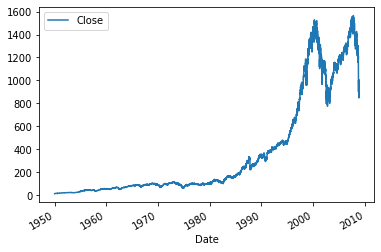

In [133]:
VISUALIZE_DATASET = True
if VISUALIZE_DATASET:
  dataset = StockPriceDataset(start_date='1950-01-03', 
                              end_date='2008-11-16',
                              interval='1d',
                              nb_samples=15,
                              transform=normalize_by_last_unknown_price)

  print("head of the dataset =", dataset.data.head()['Close'])

  print("\n Plot of the 'Close' data :")
  dataset.data.plot(None, ['Close'])

  print("len dataset =", len(dataset))

## Environment 

In [134]:
import gym

In [135]:
NB_OBSERVATION = 1
NB_STEPS_TRAIN = 100
NB_STEPS_TEST = 10000

In [136]:
class StockPricesEnvironment(gym.Env) : 
  def __init__(self):
      self.dataset = StockPriceDataset(start_date='1950-01-03', 
                              end_date='2008-11-16',
                              interval='1d',
                              nb_samples=NB_OBSERVATION,
                              transform=normalize_by_last_unknown_price)
      
  def reset(self, nb_steps): 
    self.compteur = 0
    self.date = np.random.randint(len(self.dataset)-(nb_steps+NB_OBSERVATION)) #date à partir de laquelle va commencer notre simulation (101 car 100 prix par episodes et 1 jour d'observ)
    observation,_ = self.dataset[self.date] #1 jour d'observation et un jour de projection dans le futur
    return observation


  def step(self,action, nb_steps): 
    obs, nextDay = self.dataset[self.date]
    today = obs[-1]

    variation = nextDay - today
    eps = 0.001

    """
    REWARD SYSTEM:
    -------------
    Hold : Action 0 | Sell : Action 1 | Buy : Action 2

    > Decreasing price : buy(0) sell(+2) hold(0)
    > Stable price : buy(+1) sell(+1) hold(+2)
    > Increasing price : buy(+2) sell(0) hold(0)
    """

    reward = 0
    if action == 0:  # ne pas vendre, ne pas acheter (hold)
      # si le prix va baisser
      if variation < -eps:
        reward = 0
      # si le prix reste fixe
      elif variation >= -eps and variation <= eps:
        reward = +2
      # si le prix va monter
      else : 
        reward = +1

    if action == 1:  # vendre
      # si le prix va baisser
      if variation < -eps:
        reward = +2
      # si le prix reste fixe
      elif variation >= -eps and variation <= eps:
        reward = +1
      # si le prix va monter
      else : 
        reward = 0

      if action == 2:  # acheter
        # si le prix va baisser
        if variation < -eps:
          reward = 0
        # si le prix reste fixe
        elif variation >= -eps and variation <= eps:
          reward = +1
        # si le prix va monter
        else : 
          reward = +2

    self.date += 1
    observation, next = self.dataset[self.date]
    self.compteur += 1
    done = self.compteur >= nb_steps
    info = dict()
    return observation, reward, done, info

## Test with random policy

In [137]:
env = StockPricesEnvironment()
env.reset(NB_STEPS_TRAIN) #initialisation de l'env
reward_tot = 0
while True:
  action = np.random.randint(0,3)
  observation, reward, done, info = env.step(action, NB_STEPS_TRAIN)
  reward_tot += reward
  if done:
    break
  print(observation)
print(reward_tot)


[*********************100%***********************]  1 of 1 completed
tensor([1.0127], dtype=torch.float64)
tensor([1.0141], dtype=torch.float64)
tensor([0.9773], dtype=torch.float64)
tensor([1.0075], dtype=torch.float64)
tensor([0.9861], dtype=torch.float64)
tensor([0.9819], dtype=torch.float64)
tensor([0.9999], dtype=torch.float64)
tensor([0.9981], dtype=torch.float64)
tensor([0.9585], dtype=torch.float64)
tensor([1.0175], dtype=torch.float64)
tensor([0.9840], dtype=torch.float64)
tensor([1.0168], dtype=torch.float64)
tensor([1.0101], dtype=torch.float64)
tensor([1.0073], dtype=torch.float64)
tensor([0.9999], dtype=torch.float64)
tensor([0.9752], dtype=torch.float64)
tensor([1.0033], dtype=torch.float64)
tensor([1.0014], dtype=torch.float64)
tensor([0.9803], dtype=torch.float64)
tensor([0.9954], dtype=torch.float64)
tensor([0.9699], dtype=torch.float64)
tensor([1.0025], dtype=torch.float64)
tensor([0.9862], dtype=torch.float64)
tensor([0.9827], dtype=torch.float64)
tensor([1.0249], dt

## Q learning

In [138]:
import random, datetime, os, copy

In [139]:
from torch.nn import LSTM, Module, Dropout, ModuleList, Sigmoid,Linear,GRU

In [140]:
class StockAI(Module):
    def __init__(self, input_size, hidden_size , num_layers, keep_prob, output_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size 
        self.num_layers = num_layers
        # self.gru = GRU(self.input_size,hidden_size,num_layers,dropout=1-keep_prob,batch_first=True)
        self.lstm = LSTM(self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers,dropout=1-keep_prob, batch_first=True)
        self.fc = Linear(self.hidden_size*self.num_layers,output_size)

    def forward(self,x):
      x = torch.unsqueeze(x, -1).float()
      output, (hidden,cell) = self.lstm(x)
      hidden = hidden.permute(1,0,2).reshape(-1,self.hidden_size*self.num_layers)
      x = self.fc(hidden)
      return x


In [141]:
class QNet(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, keep_prob, output_size) -> None:
        super().__init__()
        self.online = StockAI(input_size,lstm_size,num_layers,keep_prob,output_size)
        self.target = copy.deepcopy(self.online )

    def forward(self,x,model):
      if model == "online":
        out = self.online(x)
      elif model == "target":
        out = self.target(x)
      return out

In [142]:
# random sample at each reset
observation = env.reset(NB_STEPS_TRAIN)
print(observation)

tensor([1.0053], dtype=torch.float64)


In [143]:
# Init of the model
model = StockAI(1,128,2,0.9,3)

In [144]:
print(observation.shape)
x = torch.unsqueeze(observation,dim=0)
print(x.shape)
y = model(x)
print(y.shape)
print(y)

torch.Size([1])
torch.Size([1, 1])
torch.Size([1, 3])
tensor([[ 0.0429,  0.0296, -0.0234]], grad_fn=<AddmmBackward0>)


In [145]:
qnet = QNet(1,128,2,0.9,3)

In [146]:
print(observation.shape)
x = torch.unsqueeze(observation, 0)
y = qnet(x,model="online")
print(x.shape)
print(y.shape)
print(y)

torch.Size([1])
torch.Size([1, 1])
torch.Size([1, 3])
tensor([[-0.0503, -0.0548, -0.0616]], grad_fn=<AddmmBackward0>)


#Agent 

In [147]:
from collections import deque

In [148]:
class Agent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.use_cuda = torch.cuda.is_available()
  
        self.net = QNet(1,128,1,0.8,3).float()

        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 0.2
        self.exploration_rate_decay = 0.7
        self.exploration_rate_min = 0.05
        self.curr_step = 0

        self.save_every = 20 
        self.memory = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.95

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-03)
        self.loss_fn = torch.nn.SmoothL1Loss()

        self.burnin = 100  # min. experiences before training
        self.learn_every = 64  # no. of experiences between updates to Q_online
        self.sync_every = 264  # no. of experiences between Q_target & Q_online sync

    def act(self, state):
        """
        Given a state, choose an epsilon-greedy action and update value of step.

        Inputs:
        state(LazyFrame): A single observation of the current state, dimension is (state_dim)
        Outputs:
        action_idx (int): An integer representing which action the agent will perform
        """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            if self.use_cuda:
                state = state.cuda()
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()


    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None
        # Sample from memory
        state, next_state, action, reward, done = self.recall()
        # Get TD Estimate
        td_est = self.td_estimate(state, action)
        # # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)
        # # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)
        return (td_est.mean().item(), loss)

In [149]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [150]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [151]:
class MetricLogger:
    def __init__(self):

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        self.total_septs = 0

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

        self.writer = SummaryWriter()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1

        #self.writer.add_scalar('Reward', reward, self.total_septs)
        #self.total_septs +=1

        if loss:

            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

            #self.writer.add_scalar('Loss', loss, self.total_septs)
            #self.writer.add_scalar('Qvalue', q, self.total_septs)

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, nb_episodes):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-NB_STEPS_TRAIN:]), 3)

        self.writer.add_scalar('Average Reward', mean_ep_reward, episode+1)

        mean_ep_length = np.round(np.mean(self.ep_lengths[-NB_STEPS_TRAIN:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-NB_STEPS_TRAIN:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-NB_STEPS_TRAIN:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Mean Reward {mean_ep_reward} - "
            #f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            #f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        if episode == nb_episodes-1:
          for metric in ["ep_rewards", "ep_avg_losses", "ep_avg_qs"]:
              plt.plot(getattr(self, f"moving_avg_{metric}"))
              plt.xlabel("Episodes")
              plt.title("Learning Quality")
              if metric == "ep_rewards":
                plt.ylabel("Average Reward")
              elif metric == "ep_avg_losses":
                plt.ylabel("Average Loss")
              elif metric == "ep_avg_qs":
                plt.ylabel("Average Q Value")
              plt.show()
            #plt.clf()

In [152]:
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19999999999999996 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Using CUDA: False



  0%|          | 1/2500 [00:00<04:20,  9.60it/s]

Episode 0 - Mean Reward 78.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.111 - 


  0%|          | 2/2500 [00:00<05:45,  7.22it/s]

Episode 1 - Mean Reward 71.5 - Mean Loss 0.2 - Mean Q Value 0.019 - Time Delta 0.162 - 


  0%|          | 3/2500 [00:00<05:27,  7.63it/s]

Episode 2 - Mean Reward 73.667 - Mean Loss 0.257 - Mean Q Value 0.03 - Time Delta 0.122 - 


  0%|          | 4/2500 [00:00<05:19,  7.82it/s]

Episode 3 - Mean Reward 74.0 - Mean Loss 0.302 - Mean Q Value 0.038 - Time Delta 0.123 - 


  0%|          | 5/2500 [00:00<05:09,  8.07it/s]

Episode 4 - Mean Reward 75.2 - Mean Loss 0.332 - Mean Q Value 0.045 - Time Delta 0.116 - 


  0%|          | 6/2500 [00:00<05:11,  8.00it/s]

Episode 5 - Mean Reward 73.0 - Mean Loss 0.345 - Mean Q Value 0.052 - Time Delta 0.128 - 


  0%|          | 7/2500 [00:00<05:08,  8.09it/s]

Episode 6 - Mean Reward 73.429 - Mean Loss 0.347 - Mean Q Value 0.059 - Time Delta 0.12 - 


  0%|          | 8/2500 [00:00<05:04,  8.18it/s]

Episode 7 - Mean Reward 72.25 - Mean Loss 0.358 - Mean Q Value 0.066 - Time Delta 0.12 - 


  0%|          | 9/2500 [00:01<05:13,  7.94it/s]

Episode 8 - Mean Reward 75.667 - Mean Loss 0.361 - Mean Q Value 0.073 - Time Delta 0.134 - 


  0%|          | 10/2500 [00:01<05:01,  8.25it/s]

Episode 9 - Mean Reward 75.4 - Mean Loss 0.369 - Mean Q Value 0.079 - Time Delta 0.11 - 


  0%|          | 11/2500 [00:01<05:03,  8.21it/s]

Episode 10 - Mean Reward 74.455 - Mean Loss 0.375 - Mean Q Value 0.086 - Time Delta 0.123 - 


  0%|          | 12/2500 [00:01<05:10,  8.02it/s]

Episode 11 - Mean Reward 73.333 - Mean Loss 0.378 - Mean Q Value 0.093 - Time Delta 0.131 - 


  1%|          | 13/2500 [00:01<05:18,  7.81it/s]

Episode 12 - Mean Reward 73.231 - Mean Loss 0.379 - Mean Q Value 0.099 - Time Delta 0.136 - 


  1%|          | 14/2500 [00:01<05:05,  8.14it/s]

Episode 13 - Mean Reward 74.071 - Mean Loss 0.387 - Mean Q Value 0.106 - Time Delta 0.111 - 


  1%|          | 15/2500 [00:01<05:03,  8.20it/s]

Episode 14 - Mean Reward 73.733 - Mean Loss 0.391 - Mean Q Value 0.113 - Time Delta 0.12 - 


  1%|          | 16/2500 [00:01<04:58,  8.33it/s]

Episode 15 - Mean Reward 72.938 - Mean Loss 0.39 - Mean Q Value 0.12 - Time Delta 0.116 - 


  1%|          | 17/2500 [00:02<04:49,  8.57it/s]

Episode 16 - Mean Reward 73.176 - Mean Loss 0.39 - Mean Q Value 0.127 - Time Delta 0.109 - 


  1%|          | 18/2500 [00:02<04:44,  8.72it/s]

Episode 17 - Mean Reward 75.0 - Mean Loss 0.391 - Mean Q Value 0.135 - Time Delta 0.11 - 


  1%|          | 19/2500 [00:02<04:42,  8.77it/s]

Episode 18 - Mean Reward 75.632 - Mean Loss 0.39 - Mean Q Value 0.142 - Time Delta 0.113 - 


  1%|          | 20/2500 [00:02<04:44,  8.70it/s]

Episode 19 - Mean Reward 75.5 - Mean Loss 0.394 - Mean Q Value 0.15 - Time Delta 0.117 - 


  1%|          | 21/2500 [00:02<04:43,  8.74it/s]

Episode 20 - Mean Reward 74.667 - Mean Loss 0.398 - Mean Q Value 0.158 - Time Delta 0.113 - 


  1%|          | 22/2500 [00:02<04:45,  8.68it/s]

Episode 21 - Mean Reward 73.773 - Mean Loss 0.399 - Mean Q Value 0.166 - Time Delta 0.118 - 


  1%|          | 23/2500 [00:02<04:54,  8.42it/s]

Episode 22 - Mean Reward 73.652 - Mean Loss 0.399 - Mean Q Value 0.173 - Time Delta 0.127 - 


  1%|          | 24/2500 [00:02<05:03,  8.15it/s]

Episode 23 - Mean Reward 73.083 - Mean Loss 0.399 - Mean Q Value 0.182 - Time Delta 0.132 - 


  1%|          | 25/2500 [00:03<05:04,  8.14it/s]

Episode 24 - Mean Reward 73.84 - Mean Loss 0.398 - Mean Q Value 0.19 - Time Delta 0.123 - 


  1%|          | 26/2500 [00:03<05:07,  8.04it/s]

Episode 25 - Mean Reward 74.385 - Mean Loss 0.397 - Mean Q Value 0.199 - Time Delta 0.128 - 


  1%|          | 27/2500 [00:03<05:06,  8.07it/s]

Episode 26 - Mean Reward 74.111 - Mean Loss 0.397 - Mean Q Value 0.208 - Time Delta 0.122 - 


  1%|          | 28/2500 [00:03<05:09,  7.99it/s]

Episode 27 - Mean Reward 74.607 - Mean Loss 0.4 - Mean Q Value 0.217 - Time Delta 0.128 - 


  1%|          | 29/2500 [00:03<05:20,  7.71it/s]

Episode 28 - Mean Reward 74.414 - Mean Loss 0.402 - Mean Q Value 0.226 - Time Delta 0.14 - 


  1%|          | 30/2500 [00:03<05:11,  7.92it/s]

Episode 29 - Mean Reward 73.7 - Mean Loss 0.403 - Mean Q Value 0.236 - Time Delta 0.118 - 


  1%|          | 31/2500 [00:03<05:11,  7.93it/s]

Episode 30 - Mean Reward 73.71 - Mean Loss 0.404 - Mean Q Value 0.246 - Time Delta 0.126 - 


  1%|▏         | 32/2500 [00:03<05:09,  7.97it/s]

Episode 31 - Mean Reward 73.562 - Mean Loss 0.404 - Mean Q Value 0.256 - Time Delta 0.124 - 


  1%|▏         | 33/2500 [00:04<04:53,  8.41it/s]

Episode 32 - Mean Reward 72.758 - Mean Loss 0.405 - Mean Q Value 0.267 - Time Delta 0.103 - 


  1%|▏         | 34/2500 [00:04<04:52,  8.43it/s]

Episode 33 - Mean Reward 72.588 - Mean Loss 0.404 - Mean Q Value 0.278 - Time Delta 0.119 - 


  1%|▏         | 35/2500 [00:04<04:43,  8.68it/s]

Episode 34 - Mean Reward 72.686 - Mean Loss 0.404 - Mean Q Value 0.289 - Time Delta 0.107 - 


  1%|▏         | 36/2500 [00:04<04:48,  8.53it/s]

Episode 35 - Mean Reward 72.722 - Mean Loss 0.403 - Mean Q Value 0.301 - Time Delta 0.122 - 


  1%|▏         | 37/2500 [00:04<04:48,  8.54it/s]

Episode 36 - Mean Reward 72.514 - Mean Loss 0.402 - Mean Q Value 0.312 - Time Delta 0.117 - 


  2%|▏         | 38/2500 [00:04<04:46,  8.58it/s]

Episode 37 - Mean Reward 72.316 - Mean Loss 0.403 - Mean Q Value 0.324 - Time Delta 0.115 - 


  2%|▏         | 39/2500 [00:04<04:39,  8.80it/s]

Episode 38 - Mean Reward 71.949 - Mean Loss 0.403 - Mean Q Value 0.336 - Time Delta 0.107 - 


  2%|▏         | 40/2500 [00:04<04:39,  8.79it/s]

Episode 39 - Mean Reward 72.2 - Mean Loss 0.401 - Mean Q Value 0.349 - Time Delta 0.114 - 


  2%|▏         | 41/2500 [00:04<04:37,  8.87it/s]

Episode 40 - Mean Reward 72.024 - Mean Loss 0.4 - Mean Q Value 0.362 - Time Delta 0.111 - 


  2%|▏         | 42/2500 [00:05<04:38,  8.81it/s]

Episode 41 - Mean Reward 71.857 - Mean Loss 0.4 - Mean Q Value 0.375 - Time Delta 0.115 - 


  2%|▏         | 43/2500 [00:05<04:39,  8.79it/s]

Episode 42 - Mean Reward 71.86 - Mean Loss 0.4 - Mean Q Value 0.389 - Time Delta 0.115 - 


  2%|▏         | 44/2500 [00:05<04:34,  8.95it/s]

Episode 43 - Mean Reward 72.0 - Mean Loss 0.402 - Mean Q Value 0.403 - Time Delta 0.107 - 


  2%|▏         | 45/2500 [00:05<04:36,  8.88it/s]

Episode 44 - Mean Reward 72.489 - Mean Loss 0.4 - Mean Q Value 0.418 - Time Delta 0.115 - 


  2%|▏         | 46/2500 [00:05<04:38,  8.83it/s]

Episode 45 - Mean Reward 72.609 - Mean Loss 0.402 - Mean Q Value 0.432 - Time Delta 0.114 - 


  2%|▏         | 47/2500 [00:05<04:38,  8.79it/s]

Episode 46 - Mean Reward 73.021 - Mean Loss 0.401 - Mean Q Value 0.447 - Time Delta 0.116 - 


  2%|▏         | 48/2500 [00:05<04:37,  8.83it/s]

Episode 47 - Mean Reward 73.125 - Mean Loss 0.401 - Mean Q Value 0.463 - Time Delta 0.111 - 


  2%|▏         | 49/2500 [00:05<04:33,  8.95it/s]

Episode 48 - Mean Reward 72.878 - Mean Loss 0.4 - Mean Q Value 0.479 - Time Delta 0.109 - 


  2%|▏         | 50/2500 [00:05<04:36,  8.87it/s]

Episode 49 - Mean Reward 72.66 - Mean Loss 0.398 - Mean Q Value 0.496 - Time Delta 0.115 - 


  2%|▏         | 51/2500 [00:06<04:38,  8.81it/s]

Episode 50 - Mean Reward 72.647 - Mean Loss 0.4 - Mean Q Value 0.513 - Time Delta 0.116 - 


  2%|▏         | 52/2500 [00:06<04:41,  8.71it/s]

Episode 51 - Mean Reward 72.615 - Mean Loss 0.399 - Mean Q Value 0.53 - Time Delta 0.118 - 


  2%|▏         | 53/2500 [00:06<04:37,  8.80it/s]

Episode 52 - Mean Reward 72.415 - Mean Loss 0.398 - Mean Q Value 0.548 - Time Delta 0.111 - 


  2%|▏         | 54/2500 [00:06<04:36,  8.84it/s]

Episode 53 - Mean Reward 72.704 - Mean Loss 0.396 - Mean Q Value 0.566 - Time Delta 0.111 - 


  2%|▏         | 55/2500 [00:06<04:47,  8.52it/s]

Episode 54 - Mean Reward 72.4 - Mean Loss 0.396 - Mean Q Value 0.585 - Time Delta 0.128 - 


  2%|▏         | 56/2500 [00:06<05:02,  8.08it/s]

Episode 55 - Mean Reward 72.714 - Mean Loss 0.395 - Mean Q Value 0.604 - Time Delta 0.138 - 


  2%|▏         | 57/2500 [00:06<05:06,  7.96it/s]

Episode 56 - Mean Reward 72.825 - Mean Loss 0.396 - Mean Q Value 0.623 - Time Delta 0.129 - 


  2%|▏         | 58/2500 [00:06<04:59,  8.16it/s]

Episode 57 - Mean Reward 72.793 - Mean Loss 0.393 - Mean Q Value 0.644 - Time Delta 0.117 - 


  2%|▏         | 59/2500 [00:07<04:49,  8.42it/s]

Episode 58 - Mean Reward 72.661 - Mean Loss 0.392 - Mean Q Value 0.664 - Time Delta 0.11 - 


  2%|▏         | 60/2500 [00:07<04:48,  8.47it/s]

Episode 59 - Mean Reward 72.45 - Mean Loss 0.392 - Mean Q Value 0.685 - Time Delta 0.116 - 


  2%|▏         | 61/2500 [00:07<04:46,  8.52it/s]

Episode 60 - Mean Reward 72.344 - Mean Loss 0.391 - Mean Q Value 0.706 - Time Delta 0.115 - 


  2%|▏         | 62/2500 [00:07<04:53,  8.30it/s]

Episode 61 - Mean Reward 72.371 - Mean Loss 0.39 - Mean Q Value 0.728 - Time Delta 0.128 - 


  3%|▎         | 63/2500 [00:07<04:54,  8.27it/s]

Episode 62 - Mean Reward 72.159 - Mean Loss 0.391 - Mean Q Value 0.749 - Time Delta 0.121 - 


  3%|▎         | 64/2500 [00:07<05:12,  7.78it/s]

Episode 63 - Mean Reward 72.109 - Mean Loss 0.391 - Mean Q Value 0.773 - Time Delta 0.147 - 


  3%|▎         | 66/2500 [00:08<07:13,  5.62it/s]

Episode 64 - Mean Reward 72.046 - Mean Loss 0.392 - Mean Q Value 0.796 - Time Delta 0.395 - 
Episode 65 - Mean Reward 72.106 - Mean Loss 0.391 - Mean Q Value 0.82 - Time Delta 0.107 - 


  3%|▎         | 68/2500 [00:08<05:48,  6.98it/s]

Episode 66 - Mean Reward 72.09 - Mean Loss 0.391 - Mean Q Value 0.845 - Time Delta 0.111 - 
Episode 67 - Mean Reward 72.265 - Mean Loss 0.39 - Mean Q Value 0.87 - Time Delta 0.109 - 


  3%|▎         | 70/2500 [00:08<05:19,  7.61it/s]

Episode 68 - Mean Reward 72.159 - Mean Loss 0.389 - Mean Q Value 0.895 - Time Delta 0.112 - 
Episode 69 - Mean Reward 72.0 - Mean Loss 0.39 - Mean Q Value 0.92 - Time Delta 0.125 - 


  3%|▎         | 72/2500 [00:08<04:54,  8.23it/s]

Episode 70 - Mean Reward 72.042 - Mean Loss 0.389 - Mean Q Value 0.946 - Time Delta 0.114 - 
Episode 71 - Mean Reward 71.889 - Mean Loss 0.39 - Mean Q Value 0.972 - Time Delta 0.111 - 


  3%|▎         | 74/2500 [00:09<04:39,  8.69it/s]

Episode 72 - Mean Reward 71.795 - Mean Loss 0.389 - Mean Q Value 0.999 - Time Delta 0.113 - 
Episode 73 - Mean Reward 71.797 - Mean Loss 0.388 - Mean Q Value 1.027 - Time Delta 0.106 - 


  3%|▎         | 76/2500 [00:09<04:36,  8.78it/s]

Episode 74 - Mean Reward 71.8 - Mean Loss 0.388 - Mean Q Value 1.055 - Time Delta 0.117 - 
Episode 75 - Mean Reward 71.711 - Mean Loss 0.387 - Mean Q Value 1.084 - Time Delta 0.109 - 


  3%|▎         | 78/2500 [00:09<04:37,  8.74it/s]

Episode 76 - Mean Reward 71.844 - Mean Loss 0.386 - Mean Q Value 1.114 - Time Delta 0.116 - 
Episode 77 - Mean Reward 71.923 - Mean Loss 0.385 - Mean Q Value 1.144 - Time Delta 0.115 - 


  3%|▎         | 80/2500 [00:09<04:43,  8.52it/s]

Episode 78 - Mean Reward 71.873 - Mean Loss 0.383 - Mean Q Value 1.174 - Time Delta 0.118 - 
Episode 79 - Mean Reward 71.75 - Mean Loss 0.384 - Mean Q Value 1.205 - Time Delta 0.122 - 


  3%|▎         | 82/2500 [00:09<04:32,  8.86it/s]

Episode 80 - Mean Reward 71.938 - Mean Loss 0.385 - Mean Q Value 1.236 - Time Delta 0.106 - 
Episode 81 - Mean Reward 72.037 - Mean Loss 0.383 - Mean Q Value 1.267 - Time Delta 0.11 - 


  3%|▎         | 84/2500 [00:10<04:27,  9.03it/s]

Episode 82 - Mean Reward 72.06 - Mean Loss 0.381 - Mean Q Value 1.299 - Time Delta 0.108 - 
Episode 83 - Mean Reward 72.071 - Mean Loss 0.38 - Mean Q Value 1.332 - Time Delta 0.109 - 


  3%|▎         | 86/2500 [00:10<04:28,  9.00it/s]

Episode 84 - Mean Reward 72.071 - Mean Loss 0.38 - Mean Q Value 1.364 - Time Delta 0.109 - 
Episode 85 - Mean Reward 72.07 - Mean Loss 0.379 - Mean Q Value 1.397 - Time Delta 0.114 - 


  4%|▎         | 88/2500 [00:10<04:27,  9.02it/s]

Episode 86 - Mean Reward 72.092 - Mean Loss 0.378 - Mean Q Value 1.43 - Time Delta 0.107 - 
Episode 87 - Mean Reward 72.091 - Mean Loss 0.378 - Mean Q Value 1.464 - Time Delta 0.113 - 


  4%|▎         | 90/2500 [00:10<04:28,  8.97it/s]

Episode 88 - Mean Reward 72.079 - Mean Loss 0.379 - Mean Q Value 1.498 - Time Delta 0.121 - 
Episode 89 - Mean Reward 71.967 - Mean Loss 0.377 - Mean Q Value 1.532 - Time Delta 0.106 - 


  4%|▎         | 92/2500 [00:11<04:26,  9.03it/s]

Episode 90 - Mean Reward 71.736 - Mean Loss 0.378 - Mean Q Value 1.567 - Time Delta 0.11 - 
Episode 91 - Mean Reward 71.707 - Mean Loss 0.377 - Mean Q Value 1.602 - Time Delta 0.11 - 


  4%|▍         | 94/2500 [00:11<04:23,  9.12it/s]

Episode 92 - Mean Reward 71.645 - Mean Loss 0.376 - Mean Q Value 1.638 - Time Delta 0.111 - 
Episode 93 - Mean Reward 71.777 - Mean Loss 0.375 - Mean Q Value 1.674 - Time Delta 0.107 - 


  4%|▍         | 96/2500 [00:11<04:28,  8.97it/s]

Episode 94 - Mean Reward 71.674 - Mean Loss 0.375 - Mean Q Value 1.711 - Time Delta 0.116 - 
Episode 95 - Mean Reward 71.812 - Mean Loss 0.374 - Mean Q Value 1.748 - Time Delta 0.111 - 


  4%|▍         | 98/2500 [00:11<04:34,  8.74it/s]

Episode 96 - Mean Reward 71.928 - Mean Loss 0.373 - Mean Q Value 1.785 - Time Delta 0.116 - 
Episode 97 - Mean Reward 71.98 - Mean Loss 0.373 - Mean Q Value 1.823 - Time Delta 0.118 - 


  4%|▍         | 100/2500 [00:11<04:27,  8.97it/s]

Episode 98 - Mean Reward 72.141 - Mean Loss 0.373 - Mean Q Value 1.861 - Time Delta 0.11 - 
Episode 99 - Mean Reward 72.18 - Mean Loss 0.372 - Mean Q Value 1.9 - Time Delta 0.109 - 


  4%|▍         | 102/2500 [00:12<04:25,  9.02it/s]

Episode 100 - Mean Reward 72.06 - Mean Loss 0.375 - Mean Q Value 1.957 - Time Delta 0.107 - 
Episode 101 - Mean Reward 71.94 - Mean Loss 0.375 - Mean Q Value 2.017 - Time Delta 0.113 - 


  4%|▍         | 104/2500 [00:12<04:40,  8.55it/s]

Episode 102 - Mean Reward 71.94 - Mean Loss 0.373 - Mean Q Value 2.077 - Time Delta 0.119 - 
Episode 103 - Mean Reward 71.85 - Mean Loss 0.373 - Mean Q Value 2.138 - Time Delta 0.125 - 


  4%|▍         | 106/2500 [00:12<04:36,  8.67it/s]

Episode 104 - Mean Reward 71.79 - Mean Loss 0.372 - Mean Q Value 2.201 - Time Delta 0.126 - 
Episode 105 - Mean Reward 71.79 - Mean Loss 0.37 - Mean Q Value 2.266 - Time Delta 0.106 - 


  4%|▍         | 107/2500 [00:12<04:46,  8.36it/s]

Episode 106 - Mean Reward 71.86 - Mean Loss 0.37 - Mean Q Value 2.331 - Time Delta 0.129 - 
Episode 107 - Mean Reward 71.86 - Mean Loss 0.369 - Mean Q Value 2.397 - Time Delta 0.099 - 


  4%|▍         | 110/2500 [00:13<04:29,  8.88it/s]

Episode 108 - Mean Reward 71.71 - Mean Loss 0.369 - Mean Q Value 2.463 - Time Delta 0.114 - 
Episode 109 - Mean Reward 71.68 - Mean Loss 0.367 - Mean Q Value 2.532 - Time Delta 0.11 - 


  4%|▍         | 112/2500 [00:13<04:25,  8.98it/s]

Episode 110 - Mean Reward 72.09 - Mean Loss 0.367 - Mean Q Value 2.6 - Time Delta 0.113 - 
Episode 111 - Mean Reward 72.0 - Mean Loss 0.366 - Mean Q Value 2.67 - Time Delta 0.108 - 


  5%|▍         | 114/2500 [00:13<04:23,  9.04it/s]

Episode 112 - Mean Reward 72.0 - Mean Loss 0.366 - Mean Q Value 2.742 - Time Delta 0.112 - 
Episode 113 - Mean Reward 71.96 - Mean Loss 0.364 - Mean Q Value 2.815 - Time Delta 0.108 - 


  5%|▍         | 116/2500 [00:13<04:30,  8.82it/s]

Episode 114 - Mean Reward 72.11 - Mean Loss 0.362 - Mean Q Value 2.888 - Time Delta 0.115 - 
Episode 115 - Mean Reward 72.23 - Mean Loss 0.361 - Mean Q Value 2.962 - Time Delta 0.117 - 


  5%|▍         | 118/2500 [00:14<04:24,  8.99it/s]

Episode 116 - Mean Reward 72.19 - Mean Loss 0.36 - Mean Q Value 3.038 - Time Delta 0.107 - 
Episode 117 - Mean Reward 71.79 - Mean Loss 0.36 - Mean Q Value 3.113 - Time Delta 0.11 - 


  5%|▍         | 120/2500 [00:14<04:21,  9.12it/s]

Episode 118 - Mean Reward 71.6 - Mean Loss 0.358 - Mean Q Value 3.19 - Time Delta 0.11 - 
Episode 119 - Mean Reward 71.58 - Mean Loss 0.357 - Mean Q Value 3.268 - Time Delta 0.107 - 


  5%|▍         | 122/2500 [00:14<04:22,  9.05it/s]

Episode 120 - Mean Reward 71.72 - Mean Loss 0.356 - Mean Q Value 3.346 - Time Delta 0.121 - 
Episode 121 - Mean Reward 71.75 - Mean Loss 0.356 - Mean Q Value 3.425 - Time Delta 0.105 - 


  5%|▍         | 124/2500 [00:14<04:24,  8.97it/s]

Episode 122 - Mean Reward 71.9 - Mean Loss 0.355 - Mean Q Value 3.506 - Time Delta 0.121 - 
Episode 123 - Mean Reward 72.11 - Mean Loss 0.354 - Mean Q Value 3.588 - Time Delta 0.107 - 


  5%|▌         | 126/2500 [00:14<04:27,  8.88it/s]

Episode 124 - Mean Reward 72.2 - Mean Loss 0.354 - Mean Q Value 3.669 - Time Delta 0.12 - 
Episode 125 - Mean Reward 72.15 - Mean Loss 0.354 - Mean Q Value 3.752 - Time Delta 0.11 - 


  5%|▌         | 128/2500 [00:15<04:26,  8.90it/s]

Episode 126 - Mean Reward 72.14 - Mean Loss 0.355 - Mean Q Value 3.835 - Time Delta 0.116 - 
Episode 127 - Mean Reward 72.1 - Mean Loss 0.353 - Mean Q Value 3.919 - Time Delta 0.108 - 


  5%|▌         | 130/2500 [00:15<04:27,  8.84it/s]

Episode 128 - Mean Reward 72.09 - Mean Loss 0.351 - Mean Q Value 4.005 - Time Delta 0.121 - 
Episode 129 - Mean Reward 72.3 - Mean Loss 0.351 - Mean Q Value 4.09 - Time Delta 0.109 - 


  5%|▌         | 132/2500 [00:15<04:29,  8.78it/s]

Episode 130 - Mean Reward 72.26 - Mean Loss 0.351 - Mean Q Value 4.176 - Time Delta 0.112 - 
Episode 131 - Mean Reward 72.33 - Mean Loss 0.351 - Mean Q Value 4.263 - Time Delta 0.116 - 


  5%|▌         | 134/2500 [00:15<04:41,  8.41it/s]

Episode 132 - Mean Reward 72.7 - Mean Loss 0.352 - Mean Q Value 4.35 - Time Delta 0.111 - 
Episode 133 - Mean Reward 72.71 - Mean Loss 0.351 - Mean Q Value 4.438 - Time Delta 0.133 - 


  5%|▌         | 136/2500 [00:16<04:35,  8.57it/s]

Episode 134 - Mean Reward 72.48 - Mean Loss 0.35 - Mean Q Value 4.526 - Time Delta 0.115 - 
Episode 135 - Mean Reward 72.57 - Mean Loss 0.351 - Mean Q Value 4.614 - Time Delta 0.114 - 


  6%|▌         | 138/2500 [00:16<04:31,  8.71it/s]

Episode 136 - Mean Reward 72.44 - Mean Loss 0.351 - Mean Q Value 4.704 - Time Delta 0.125 - 
Episode 137 - Mean Reward 72.51 - Mean Loss 0.349 - Mean Q Value 4.794 - Time Delta 0.105 - 


  6%|▌         | 140/2500 [00:16<04:26,  8.85it/s]

Episode 138 - Mean Reward 72.69 - Mean Loss 0.348 - Mean Q Value 4.884 - Time Delta 0.116 - 
Episode 139 - Mean Reward 72.58 - Mean Loss 0.347 - Mean Q Value 4.975 - Time Delta 0.108 - 


  6%|▌         | 142/2500 [00:16<04:22,  8.99it/s]

Episode 140 - Mean Reward 72.52 - Mean Loss 0.346 - Mean Q Value 5.067 - Time Delta 0.114 - 
Episode 141 - Mean Reward 72.55 - Mean Loss 0.345 - Mean Q Value 5.158 - Time Delta 0.106 - 


  6%|▌         | 144/2500 [00:16<04:35,  8.56it/s]

Episode 142 - Mean Reward 72.6 - Mean Loss 0.344 - Mean Q Value 5.25 - Time Delta 0.128 - 
Episode 143 - Mean Reward 72.46 - Mean Loss 0.343 - Mean Q Value 5.343 - Time Delta 0.119 - 


  6%|▌         | 146/2500 [00:17<04:27,  8.79it/s]

Episode 144 - Mean Reward 72.34 - Mean Loss 0.344 - Mean Q Value 5.435 - Time Delta 0.112 - 
Episode 145 - Mean Reward 72.33 - Mean Loss 0.342 - Mean Q Value 5.528 - Time Delta 0.11 - 


  6%|▌         | 148/2500 [00:17<04:31,  8.67it/s]

Episode 146 - Mean Reward 72.08 - Mean Loss 0.345 - Mean Q Value 5.621 - Time Delta 0.114 - 
Episode 147 - Mean Reward 71.97 - Mean Loss 0.343 - Mean Q Value 5.715 - Time Delta 0.119 - 


  6%|▌         | 150/2500 [00:17<04:23,  8.90it/s]

Episode 148 - Mean Reward 72.09 - Mean Loss 0.342 - Mean Q Value 5.808 - Time Delta 0.105 - 
Episode 149 - Mean Reward 72.08 - Mean Loss 0.342 - Mean Q Value 5.902 - Time Delta 0.112 - 


  6%|▌         | 152/2500 [00:17<04:46,  8.19it/s]

Episode 150 - Mean Reward 72.12 - Mean Loss 0.343 - Mean Q Value 5.996 - Time Delta 0.116 - 
Episode 151 - Mean Reward 72.4 - Mean Loss 0.342 - Mean Q Value 6.089 - Time Delta 0.143 - 


  6%|▌         | 154/2500 [00:18<04:31,  8.65it/s]

Episode 152 - Mean Reward 72.66 - Mean Loss 0.343 - Mean Q Value 6.183 - Time Delta 0.114 - 
Episode 153 - Mean Reward 72.46 - Mean Loss 0.343 - Mean Q Value 6.277 - Time Delta 0.106 - 


  6%|▌         | 156/2500 [00:18<04:22,  8.93it/s]

Episode 154 - Mean Reward 72.54 - Mean Loss 0.343 - Mean Q Value 6.371 - Time Delta 0.117 - 
Episode 155 - Mean Reward 72.5 - Mean Loss 0.342 - Mean Q Value 6.465 - Time Delta 0.103 - 


  6%|▋         | 158/2500 [00:18<04:21,  8.96it/s]

Episode 156 - Mean Reward 72.32 - Mean Loss 0.342 - Mean Q Value 6.558 - Time Delta 0.113 - 
Episode 157 - Mean Reward 72.46 - Mean Loss 0.342 - Mean Q Value 6.652 - Time Delta 0.11 - 


  6%|▋         | 160/2500 [00:18<04:27,  8.75it/s]

Episode 158 - Mean Reward 72.46 - Mean Loss 0.343 - Mean Q Value 6.746 - Time Delta 0.11 - 
Episode 159 - Mean Reward 72.55 - Mean Loss 0.344 - Mean Q Value 6.84 - Time Delta 0.121 - 


  6%|▋         | 162/2500 [00:19<04:25,  8.80it/s]

Episode 160 - Mean Reward 72.73 - Mean Loss 0.345 - Mean Q Value 6.933 - Time Delta 0.109 - 
Episode 161 - Mean Reward 72.52 - Mean Loss 0.345 - Mean Q Value 7.027 - Time Delta 0.116 - 


  7%|▋         | 164/2500 [00:19<04:18,  9.02it/s]

Episode 162 - Mean Reward 72.57 - Mean Loss 0.346 - Mean Q Value 7.12 - Time Delta 0.108 - 
Episode 163 - Mean Reward 72.5 - Mean Loss 0.345 - Mean Q Value 7.213 - Time Delta 0.108 - 


  7%|▋         | 166/2500 [00:19<04:22,  8.90it/s]

Episode 164 - Mean Reward 72.6 - Mean Loss 0.343 - Mean Q Value 7.306 - Time Delta 0.112 - 
Episode 165 - Mean Reward 72.42 - Mean Loss 0.344 - Mean Q Value 7.398 - Time Delta 0.116 - 


  7%|▋         | 168/2500 [00:19<04:17,  9.06it/s]

Episode 166 - Mean Reward 72.29 - Mean Loss 0.346 - Mean Q Value 7.489 - Time Delta 0.106 - 
Episode 167 - Mean Reward 72.14 - Mean Loss 0.346 - Mean Q Value 7.581 - Time Delta 0.11 - 


  7%|▋         | 170/2500 [00:19<04:18,  9.01it/s]

Episode 168 - Mean Reward 72.27 - Mean Loss 0.346 - Mean Q Value 7.672 - Time Delta 0.118 - 
Episode 169 - Mean Reward 72.4 - Mean Loss 0.345 - Mean Q Value 7.763 - Time Delta 0.107 - 


  7%|▋         | 172/2500 [00:20<04:17,  9.02it/s]

Episode 170 - Mean Reward 72.35 - Mean Loss 0.344 - Mean Q Value 7.854 - Time Delta 0.124 - 
Episode 171 - Mean Reward 72.42 - Mean Loss 0.343 - Mean Q Value 7.944 - Time Delta 0.101 - 


  7%|▋         | 174/2500 [00:20<04:16,  9.08it/s]

Episode 172 - Mean Reward 72.54 - Mean Loss 0.342 - Mean Q Value 8.034 - Time Delta 0.115 - 
Episode 173 - Mean Reward 72.59 - Mean Loss 0.341 - Mean Q Value 8.124 - Time Delta 0.106 - 


  7%|▋         | 176/2500 [00:20<04:23,  8.82it/s]

Episode 174 - Mean Reward 72.4 - Mean Loss 0.342 - Mean Q Value 8.214 - Time Delta 0.124 - 
Episode 175 - Mean Reward 72.46 - Mean Loss 0.343 - Mean Q Value 8.302 - Time Delta 0.111 - 


  7%|▋         | 178/2500 [00:20<04:20,  8.91it/s]

Episode 176 - Mean Reward 72.3 - Mean Loss 0.344 - Mean Q Value 8.391 - Time Delta 0.119 - 
Episode 177 - Mean Reward 72.14 - Mean Loss 0.343 - Mean Q Value 8.479 - Time Delta 0.106 - 


  7%|▋         | 180/2500 [00:21<04:21,  8.87it/s]

Episode 178 - Mean Reward 72.22 - Mean Loss 0.343 - Mean Q Value 8.566 - Time Delta 0.111 - 
Episode 179 - Mean Reward 72.2 - Mean Loss 0.341 - Mean Q Value 8.653 - Time Delta 0.115 - 


  7%|▋         | 182/2500 [00:21<04:18,  8.98it/s]

Episode 180 - Mean Reward 72.14 - Mean Loss 0.339 - Mean Q Value 8.74 - Time Delta 0.103 - 
Episode 181 - Mean Reward 72.23 - Mean Loss 0.339 - Mean Q Value 8.826 - Time Delta 0.115 - 


  7%|▋         | 184/2500 [00:21<04:18,  8.96it/s]

Episode 182 - Mean Reward 72.08 - Mean Loss 0.339 - Mean Q Value 8.911 - Time Delta 0.109 - 
Episode 183 - Mean Reward 71.99 - Mean Loss 0.341 - Mean Q Value 8.996 - Time Delta 0.114 - 


  7%|▋         | 186/2500 [00:21<04:21,  8.86it/s]

Episode 184 - Mean Reward 71.95 - Mean Loss 0.34 - Mean Q Value 9.08 - Time Delta 0.121 - 
Episode 185 - Mean Reward 71.9 - Mean Loss 0.341 - Mean Q Value 9.164 - Time Delta 0.109 - 


  8%|▊         | 188/2500 [00:21<04:16,  9.02it/s]

Episode 186 - Mean Reward 71.85 - Mean Loss 0.342 - Mean Q Value 9.246 - Time Delta 0.112 - 
Episode 187 - Mean Reward 71.81 - Mean Loss 0.34 - Mean Q Value 9.328 - Time Delta 0.107 - 


  8%|▊         | 190/2500 [00:22<04:18,  8.93it/s]

Episode 188 - Mean Reward 71.8 - Mean Loss 0.338 - Mean Q Value 9.409 - Time Delta 0.118 - 
Episode 189 - Mean Reward 71.9 - Mean Loss 0.338 - Mean Q Value 9.49 - Time Delta 0.11 - 


  8%|▊         | 192/2500 [00:22<04:17,  8.97it/s]

Episode 190 - Mean Reward 72.03 - Mean Loss 0.336 - Mean Q Value 9.57 - Time Delta 0.11 - 
Episode 191 - Mean Reward 72.12 - Mean Loss 0.337 - Mean Q Value 9.648 - Time Delta 0.112 - 


  8%|▊         | 194/2500 [00:22<04:23,  8.74it/s]

Episode 192 - Mean Reward 72.35 - Mean Loss 0.339 - Mean Q Value 9.727 - Time Delta 0.12 - 
Episode 193 - Mean Reward 72.18 - Mean Loss 0.339 - Mean Q Value 9.805 - Time Delta 0.115 - 


  8%|▊         | 196/2500 [00:22<04:26,  8.65it/s]

Episode 194 - Mean Reward 72.42 - Mean Loss 0.34 - Mean Q Value 9.881 - Time Delta 0.122 - 
Episode 195 - Mean Reward 72.31 - Mean Loss 0.343 - Mean Q Value 9.957 - Time Delta 0.113 - 


  8%|▊         | 198/2500 [00:23<04:32,  8.44it/s]

Episode 196 - Mean Reward 72.18 - Mean Loss 0.345 - Mean Q Value 10.031 - Time Delta 0.122 - 
Episode 197 - Mean Reward 72.25 - Mean Loss 0.344 - Mean Q Value 10.105 - Time Delta 0.121 - 


  8%|▊         | 200/2500 [00:23<04:25,  8.65it/s]

Episode 198 - Mean Reward 72.15 - Mean Loss 0.347 - Mean Q Value 10.179 - Time Delta 0.113 - 
Episode 199 - Mean Reward 72.14 - Mean Loss 0.348 - Mean Q Value 10.25 - Time Delta 0.112 - 


  8%|▊         | 202/2500 [00:23<04:19,  8.85it/s]

Episode 200 - Mean Reward 72.21 - Mean Loss 0.349 - Mean Q Value 10.322 - Time Delta 0.121 - 
Episode 201 - Mean Reward 72.53 - Mean Loss 0.347 - Mean Q Value 10.391 - Time Delta 0.103 - 


  8%|▊         | 204/2500 [00:23<04:18,  8.89it/s]

Episode 202 - Mean Reward 72.36 - Mean Loss 0.347 - Mean Q Value 10.459 - Time Delta 0.122 - 
Episode 203 - Mean Reward 72.62 - Mean Loss 0.347 - Mean Q Value 10.526 - Time Delta 0.106 - 


  8%|▊         | 206/2500 [00:24<04:18,  8.89it/s]

Episode 204 - Mean Reward 72.65 - Mean Loss 0.347 - Mean Q Value 10.592 - Time Delta 0.118 - 
Episode 205 - Mean Reward 72.74 - Mean Loss 0.347 - Mean Q Value 10.656 - Time Delta 0.109 - 


  8%|▊         | 208/2500 [00:24<04:29,  8.50it/s]

Episode 206 - Mean Reward 72.73 - Mean Loss 0.346 - Mean Q Value 10.719 - Time Delta 0.13 - 
Episode 207 - Mean Reward 72.76 - Mean Loss 0.346 - Mean Q Value 10.782 - Time Delta 0.118 - 


  8%|▊         | 210/2500 [00:24<04:37,  8.26it/s]

Episode 208 - Mean Reward 72.54 - Mean Loss 0.344 - Mean Q Value 10.844 - Time Delta 0.134 - 
Episode 209 - Mean Reward 72.5 - Mean Loss 0.348 - Mean Q Value 10.905 - Time Delta 0.117 - 


  8%|▊         | 212/2500 [00:24<04:26,  8.58it/s]

Episode 210 - Mean Reward 72.36 - Mean Loss 0.35 - Mean Q Value 10.966 - Time Delta 0.115 - 
Episode 211 - Mean Reward 72.43 - Mean Loss 0.351 - Mean Q Value 11.026 - Time Delta 0.11 - 


  9%|▊         | 214/2500 [00:24<04:22,  8.69it/s]

Episode 212 - Mean Reward 72.6 - Mean Loss 0.351 - Mean Q Value 11.084 - Time Delta 0.12 - 
Episode 213 - Mean Reward 72.53 - Mean Loss 0.351 - Mean Q Value 11.141 - Time Delta 0.11 - 


  9%|▊         | 216/2500 [00:25<04:34,  8.33it/s]

Episode 214 - Mean Reward 72.33 - Mean Loss 0.357 - Mean Q Value 11.197 - Time Delta 0.12 - 
Episode 215 - Mean Reward 72.4 - Mean Loss 0.357 - Mean Q Value 11.253 - Time Delta 0.128 - 


  9%|▊         | 218/2500 [00:25<04:37,  8.24it/s]

Episode 216 - Mean Reward 72.48 - Mean Loss 0.357 - Mean Q Value 11.306 - Time Delta 0.128 - 
Episode 217 - Mean Reward 72.46 - Mean Loss 0.355 - Mean Q Value 11.36 - Time Delta 0.119 - 


  9%|▉         | 220/2500 [00:25<04:39,  8.15it/s]

Episode 218 - Mean Reward 72.44 - Mean Loss 0.357 - Mean Q Value 11.413 - Time Delta 0.134 - 
Episode 219 - Mean Reward 72.39 - Mean Loss 0.36 - Mean Q Value 11.464 - Time Delta 0.116 - 


  9%|▉         | 222/2500 [00:25<04:44,  8.00it/s]

Episode 220 - Mean Reward 72.25 - Mean Loss 0.36 - Mean Q Value 11.513 - Time Delta 0.152 - 
Episode 221 - Mean Reward 72.52 - Mean Loss 0.358 - Mean Q Value 11.563 - Time Delta 0.111 - 


  9%|▉         | 224/2500 [00:26<04:48,  7.90it/s]

Episode 222 - Mean Reward 72.47 - Mean Loss 0.358 - Mean Q Value 11.611 - Time Delta 0.132 - 
Episode 223 - Mean Reward 72.2 - Mean Loss 0.357 - Mean Q Value 11.657 - Time Delta 0.125 - 


  9%|▉         | 226/2500 [00:26<04:44,  7.99it/s]

Episode 224 - Mean Reward 71.99 - Mean Loss 0.359 - Mean Q Value 11.703 - Time Delta 0.122 - 
Episode 225 - Mean Reward 72.22 - Mean Loss 0.358 - Mean Q Value 11.748 - Time Delta 0.125 - 


  9%|▉         | 228/2500 [00:26<04:43,  8.01it/s]

Episode 226 - Mean Reward 72.43 - Mean Loss 0.356 - Mean Q Value 11.793 - Time Delta 0.113 - 
Episode 227 - Mean Reward 72.34 - Mean Loss 0.359 - Mean Q Value 11.836 - Time Delta 0.133 - 


  9%|▉         | 230/2500 [00:26<04:50,  7.82it/s]

Episode 228 - Mean Reward 72.45 - Mean Loss 0.361 - Mean Q Value 11.877 - Time Delta 0.118 - 
Episode 229 - Mean Reward 72.66 - Mean Loss 0.36 - Mean Q Value 11.919 - Time Delta 0.14 - 


  9%|▉         | 232/2500 [00:27<04:57,  7.63it/s]

Episode 230 - Mean Reward 72.92 - Mean Loss 0.36 - Mean Q Value 11.959 - Time Delta 0.127 - 
Episode 231 - Mean Reward 72.93 - Mean Loss 0.362 - Mean Q Value 11.998 - Time Delta 0.139 - 


  9%|▉         | 234/2500 [00:27<04:57,  7.61it/s]

Episode 232 - Mean Reward 73.14 - Mean Loss 0.359 - Mean Q Value 12.037 - Time Delta 0.141 - 
Episode 233 - Mean Reward 73.43 - Mean Loss 0.36 - Mean Q Value 12.076 - Time Delta 0.125 - 


  9%|▉         | 236/2500 [00:27<04:49,  7.82it/s]

Episode 234 - Mean Reward 73.73 - Mean Loss 0.361 - Mean Q Value 12.115 - Time Delta 0.132 - 
Episode 235 - Mean Reward 74.02 - Mean Loss 0.361 - Mean Q Value 12.153 - Time Delta 0.12 - 


 10%|▉         | 238/2500 [00:28<04:41,  8.05it/s]

Episode 236 - Mean Reward 74.39 - Mean Loss 0.362 - Mean Q Value 12.191 - Time Delta 0.135 - 
Episode 237 - Mean Reward 74.66 - Mean Loss 0.361 - Mean Q Value 12.229 - Time Delta 0.111 - 


 10%|▉         | 240/2500 [00:28<04:49,  7.82it/s]

Episode 238 - Mean Reward 74.95 - Mean Loss 0.361 - Mean Q Value 12.267 - Time Delta 0.147 - 
Episode 239 - Mean Reward 75.14 - Mean Loss 0.362 - Mean Q Value 12.304 - Time Delta 0.121 - 


 10%|▉         | 242/2500 [00:28<04:33,  8.26it/s]

Episode 240 - Mean Reward 75.52 - Mean Loss 0.364 - Mean Q Value 12.342 - Time Delta 0.111 - 
Episode 241 - Mean Reward 75.76 - Mean Loss 0.364 - Mean Q Value 12.381 - Time Delta 0.117 - 


 10%|▉         | 244/2500 [00:28<04:32,  8.29it/s]

Episode 242 - Mean Reward 75.87 - Mean Loss 0.366 - Mean Q Value 12.419 - Time Delta 0.129 - 
Episode 243 - Mean Reward 76.17 - Mean Loss 0.366 - Mean Q Value 12.458 - Time Delta 0.114 - 


 10%|▉         | 246/2500 [00:28<04:23,  8.56it/s]

Episode 244 - Mean Reward 76.14 - Mean Loss 0.367 - Mean Q Value 12.497 - Time Delta 0.112 - 
Episode 245 - Mean Reward 76.29 - Mean Loss 0.369 - Mean Q Value 12.537 - Time Delta 0.114 - 


 10%|▉         | 248/2500 [00:29<04:29,  8.37it/s]

Episode 246 - Mean Reward 76.57 - Mean Loss 0.366 - Mean Q Value 12.578 - Time Delta 0.123 - 
Episode 247 - Mean Reward 76.97 - Mean Loss 0.369 - Mean Q Value 12.619 - Time Delta 0.121 - 


 10%|█         | 250/2500 [00:29<04:25,  8.46it/s]

Episode 248 - Mean Reward 77.25 - Mean Loss 0.371 - Mean Q Value 12.661 - Time Delta 0.124 - 
Episode 249 - Mean Reward 77.34 - Mean Loss 0.371 - Mean Q Value 12.703 - Time Delta 0.112 - 


 10%|█         | 252/2500 [00:29<04:16,  8.76it/s]

Episode 250 - Mean Reward 77.64 - Mean Loss 0.368 - Mean Q Value 12.746 - Time Delta 0.115 - 
Episode 251 - Mean Reward 77.33 - Mean Loss 0.37 - Mean Q Value 12.79 - Time Delta 0.107 - 


 10%|█         | 254/2500 [00:29<04:13,  8.85it/s]

Episode 252 - Mean Reward 77.12 - Mean Loss 0.371 - Mean Q Value 12.832 - Time Delta 0.114 - 
Episode 253 - Mean Reward 77.27 - Mean Loss 0.373 - Mean Q Value 12.874 - Time Delta 0.111 - 


 10%|█         | 256/2500 [00:30<04:12,  8.88it/s]

Episode 254 - Mean Reward 77.31 - Mean Loss 0.375 - Mean Q Value 12.916 - Time Delta 0.118 - 
Episode 255 - Mean Reward 77.16 - Mean Loss 0.379 - Mean Q Value 12.958 - Time Delta 0.108 - 


 10%|█         | 258/2500 [00:30<04:14,  8.80it/s]

Episode 256 - Mean Reward 77.28 - Mean Loss 0.38 - Mean Q Value 12.999 - Time Delta 0.111 - 
Episode 257 - Mean Reward 77.11 - Mean Loss 0.382 - Mean Q Value 13.039 - Time Delta 0.117 - 


 10%|█         | 260/2500 [00:30<04:12,  8.87it/s]

Episode 258 - Mean Reward 77.17 - Mean Loss 0.38 - Mean Q Value 13.078 - Time Delta 0.117 - 
Episode 259 - Mean Reward 77.35 - Mean Loss 0.381 - Mean Q Value 13.116 - Time Delta 0.108 - 


 10%|█         | 262/2500 [00:30<04:13,  8.83it/s]

Episode 260 - Mean Reward 77.44 - Mean Loss 0.382 - Mean Q Value 13.155 - Time Delta 0.119 - 
Episode 261 - Mean Reward 77.77 - Mean Loss 0.383 - Mean Q Value 13.192 - Time Delta 0.11 - 


 11%|█         | 264/2500 [00:31<04:10,  8.92it/s]

Episode 262 - Mean Reward 78.12 - Mean Loss 0.381 - Mean Q Value 13.23 - Time Delta 0.112 - 
Episode 263 - Mean Reward 78.36 - Mean Loss 0.382 - Mean Q Value 13.267 - Time Delta 0.111 - 


 11%|█         | 266/2500 [00:31<04:13,  8.80it/s]

Episode 264 - Mean Reward 78.44 - Mean Loss 0.383 - Mean Q Value 13.304 - Time Delta 0.117 - 
Episode 265 - Mean Reward 78.67 - Mean Loss 0.386 - Mean Q Value 13.341 - Time Delta 0.114 - 


 11%|█         | 268/2500 [00:31<04:14,  8.78it/s]

Episode 266 - Mean Reward 79.04 - Mean Loss 0.385 - Mean Q Value 13.379 - Time Delta 0.122 - 
Episode 267 - Mean Reward 79.14 - Mean Loss 0.386 - Mean Q Value 13.418 - Time Delta 0.108 - 


 11%|█         | 270/2500 [00:31<04:13,  8.80it/s]

Episode 268 - Mean Reward 79.54 - Mean Loss 0.385 - Mean Q Value 13.458 - Time Delta 0.121 - 
Episode 269 - Mean Reward 79.75 - Mean Loss 0.386 - Mean Q Value 13.5 - Time Delta 0.107 - 


 11%|█         | 272/2500 [00:31<04:12,  8.83it/s]

Episode 270 - Mean Reward 80.01 - Mean Loss 0.389 - Mean Q Value 13.542 - Time Delta 0.117 - 
Episode 271 - Mean Reward 80.24 - Mean Loss 0.391 - Mean Q Value 13.585 - Time Delta 0.11 - 


 11%|█         | 274/2500 [00:32<04:15,  8.72it/s]

Episode 272 - Mean Reward 80.43 - Mean Loss 0.391 - Mean Q Value 13.631 - Time Delta 0.105 - 
Episode 273 - Mean Reward 80.49 - Mean Loss 0.397 - Mean Q Value 13.677 - Time Delta 0.124 - 


 11%|█         | 276/2500 [00:32<04:34,  8.12it/s]

Episode 274 - Mean Reward 80.85 - Mean Loss 0.395 - Mean Q Value 13.724 - Time Delta 0.119 - 
Episode 275 - Mean Reward 81.07 - Mean Loss 0.394 - Mean Q Value 13.773 - Time Delta 0.14 - 


 11%|█         | 278/2500 [00:32<04:23,  8.43it/s]

Episode 276 - Mean Reward 81.48 - Mean Loss 0.395 - Mean Q Value 13.822 - Time Delta 0.117 - 
Episode 277 - Mean Reward 81.96 - Mean Loss 0.397 - Mean Q Value 13.872 - Time Delta 0.112 - 


 11%|█         | 280/2500 [00:32<04:12,  8.79it/s]

Episode 278 - Mean Reward 82.04 - Mean Loss 0.401 - Mean Q Value 13.922 - Time Delta 0.112 - 
Episode 279 - Mean Reward 82.33 - Mean Loss 0.404 - Mean Q Value 13.973 - Time Delta 0.107 - 


 11%|█▏        | 282/2500 [00:33<04:07,  8.97it/s]

Episode 280 - Mean Reward 82.58 - Mean Loss 0.405 - Mean Q Value 14.024 - Time Delta 0.119 - 
Episode 281 - Mean Reward 82.67 - Mean Loss 0.408 - Mean Q Value 14.076 - Time Delta 0.102 - 


 11%|█▏        | 284/2500 [00:33<04:11,  8.80it/s]

Episode 282 - Mean Reward 82.79 - Mean Loss 0.409 - Mean Q Value 14.127 - Time Delta 0.112 - 
Episode 283 - Mean Reward 83.33 - Mean Loss 0.408 - Mean Q Value 14.179 - Time Delta 0.117 - 


 11%|█▏        | 286/2500 [00:33<04:12,  8.77it/s]

Episode 284 - Mean Reward 83.63 - Mean Loss 0.412 - Mean Q Value 14.23 - Time Delta 0.133 - 
Episode 285 - Mean Reward 84.11 - Mean Loss 0.414 - Mean Q Value 14.281 - Time Delta 0.102 - 


 12%|█▏        | 288/2500 [00:33<04:11,  8.81it/s]

Episode 286 - Mean Reward 84.42 - Mean Loss 0.413 - Mean Q Value 14.332 - Time Delta 0.12 - 
Episode 287 - Mean Reward 84.8 - Mean Loss 0.416 - Mean Q Value 14.383 - Time Delta 0.108 - 


 12%|█▏        | 290/2500 [00:34<04:03,  9.07it/s]

Episode 288 - Mean Reward 85.01 - Mean Loss 0.421 - Mean Q Value 14.434 - Time Delta 0.111 - 
Episode 289 - Mean Reward 85.21 - Mean Loss 0.426 - Mean Q Value 14.484 - Time Delta 0.105 - 


 12%|█▏        | 292/2500 [00:34<04:05,  9.01it/s]

Episode 290 - Mean Reward 85.47 - Mean Loss 0.429 - Mean Q Value 14.534 - Time Delta 0.108 - 
Episode 291 - Mean Reward 85.65 - Mean Loss 0.432 - Mean Q Value 14.583 - Time Delta 0.114 - 


 12%|█▏        | 294/2500 [00:34<04:10,  8.81it/s]

Episode 292 - Mean Reward 85.84 - Mean Loss 0.429 - Mean Q Value 14.632 - Time Delta 0.109 - 
Episode 293 - Mean Reward 86.08 - Mean Loss 0.431 - Mean Q Value 14.68 - Time Delta 0.121 - 


 12%|█▏        | 296/2500 [00:34<04:07,  8.91it/s]

Episode 294 - Mean Reward 86.07 - Mean Loss 0.433 - Mean Q Value 14.728 - Time Delta 0.113 - 
Episode 295 - Mean Reward 86.42 - Mean Loss 0.432 - Mean Q Value 14.776 - Time Delta 0.11 - 


 12%|█▏        | 298/2500 [00:34<04:04,  9.02it/s]

Episode 296 - Mean Reward 86.53 - Mean Loss 0.436 - Mean Q Value 14.824 - Time Delta 0.12 - 
Episode 297 - Mean Reward 86.82 - Mean Loss 0.441 - Mean Q Value 14.872 - Time Delta 0.102 - 


 12%|█▏        | 300/2500 [00:35<04:04,  8.99it/s]

Episode 298 - Mean Reward 86.83 - Mean Loss 0.441 - Mean Q Value 14.919 - Time Delta 0.114 - 
Episode 299 - Mean Reward 86.89 - Mean Loss 0.443 - Mean Q Value 14.965 - Time Delta 0.11 - 


 12%|█▏        | 302/2500 [00:35<04:02,  9.06it/s]

Episode 300 - Mean Reward 86.97 - Mean Loss 0.445 - Mean Q Value 15.012 - Time Delta 0.115 - 
Episode 301 - Mean Reward 87.07 - Mean Loss 0.446 - Mean Q Value 15.059 - Time Delta 0.106 - 


 12%|█▏        | 304/2500 [00:35<04:13,  8.68it/s]

Episode 302 - Mean Reward 87.32 - Mean Loss 0.45 - Mean Q Value 15.106 - Time Delta 0.128 - 
Episode 303 - Mean Reward 87.41 - Mean Loss 0.452 - Mean Q Value 15.152 - Time Delta 0.114 - 


 12%|█▏        | 306/2500 [00:35<04:06,  8.91it/s]

Episode 304 - Mean Reward 87.53 - Mean Loss 0.454 - Mean Q Value 15.199 - Time Delta 0.11 - 
Episode 305 - Mean Reward 87.65 - Mean Loss 0.456 - Mean Q Value 15.246 - Time Delta 0.109 - 


 12%|█▏        | 308/2500 [00:36<04:05,  8.93it/s]

Episode 306 - Mean Reward 87.6 - Mean Loss 0.457 - Mean Q Value 15.292 - Time Delta 0.113 - 
Episode 307 - Mean Reward 87.67 - Mean Loss 0.458 - Mean Q Value 15.339 - Time Delta 0.111 - 


 12%|█▏        | 310/2500 [00:36<04:05,  8.92it/s]

Episode 308 - Mean Reward 87.93 - Mean Loss 0.459 - Mean Q Value 15.386 - Time Delta 0.113 - 
Episode 309 - Mean Reward 88.36 - Mean Loss 0.459 - Mean Q Value 15.433 - Time Delta 0.112 - 


 12%|█▏        | 312/2500 [00:36<04:12,  8.68it/s]

Episode 310 - Mean Reward 88.26 - Mean Loss 0.456 - Mean Q Value 15.479 - Time Delta 0.115 - 
Episode 311 - Mean Reward 88.58 - Mean Loss 0.459 - Mean Q Value 15.526 - Time Delta 0.12 - 


 13%|█▎        | 314/2500 [00:36<04:07,  8.81it/s]

Episode 312 - Mean Reward 88.5 - Mean Loss 0.459 - Mean Q Value 15.572 - Time Delta 0.12 - 
Episode 313 - Mean Reward 88.75 - Mean Loss 0.464 - Mean Q Value 15.619 - Time Delta 0.106 - 


 13%|█▎        | 316/2500 [00:36<04:03,  8.98it/s]

Episode 314 - Mean Reward 89.01 - Mean Loss 0.461 - Mean Q Value 15.666 - Time Delta 0.12 - 
Episode 315 - Mean Reward 89.16 - Mean Loss 0.469 - Mean Q Value 15.713 - Time Delta 0.102 - 


 13%|█▎        | 318/2500 [00:37<03:58,  9.13it/s]

Episode 316 - Mean Reward 89.36 - Mean Loss 0.472 - Mean Q Value 15.76 - Time Delta 0.116 - 
Episode 317 - Mean Reward 89.65 - Mean Loss 0.474 - Mean Q Value 15.806 - Time Delta 0.102 - 


 13%|█▎        | 320/2500 [00:37<04:04,  8.92it/s]

Episode 318 - Mean Reward 90.03 - Mean Loss 0.476 - Mean Q Value 15.853 - Time Delta 0.123 - 
Episode 319 - Mean Reward 90.45 - Mean Loss 0.477 - Mean Q Value 15.899 - Time Delta 0.109 - 


 13%|█▎        | 322/2500 [00:37<04:11,  8.66it/s]

Episode 320 - Mean Reward 90.85 - Mean Loss 0.48 - Mean Q Value 15.946 - Time Delta 0.122 - 
Episode 321 - Mean Reward 90.93 - Mean Loss 0.482 - Mean Q Value 15.992 - Time Delta 0.117 - 


 13%|█▎        | 324/2500 [00:37<04:15,  8.51it/s]

Episode 322 - Mean Reward 90.97 - Mean Loss 0.483 - Mean Q Value 16.039 - Time Delta 0.117 - 
Episode 323 - Mean Reward 91.39 - Mean Loss 0.49 - Mean Q Value 16.085 - Time Delta 0.121 - 


 13%|█▎        | 326/2500 [00:38<04:11,  8.66it/s]

Episode 324 - Mean Reward 91.53 - Mean Loss 0.487 - Mean Q Value 16.131 - Time Delta 0.111 - 
Episode 325 - Mean Reward 91.42 - Mean Loss 0.493 - Mean Q Value 16.177 - Time Delta 0.115 - 


 13%|█▎        | 328/2500 [00:38<04:15,  8.50it/s]

Episode 326 - Mean Reward 91.54 - Mean Loss 0.499 - Mean Q Value 16.223 - Time Delta 0.116 - 
Episode 327 - Mean Reward 91.78 - Mean Loss 0.498 - Mean Q Value 16.269 - Time Delta 0.123 - 


 13%|█▎        | 330/2500 [00:38<04:31,  8.00it/s]

Episode 328 - Mean Reward 92.0 - Mean Loss 0.501 - Mean Q Value 16.314 - Time Delta 0.151 - 
Episode 329 - Mean Reward 92.09 - Mean Loss 0.506 - Mean Q Value 16.359 - Time Delta 0.118 - 


 13%|█▎        | 332/2500 [00:38<04:18,  8.39it/s]

Episode 330 - Mean Reward 91.99 - Mean Loss 0.507 - Mean Q Value 16.404 - Time Delta 0.122 - 
Episode 331 - Mean Reward 91.91 - Mean Loss 0.51 - Mean Q Value 16.448 - Time Delta 0.108 - 


 13%|█▎        | 334/2500 [00:39<04:11,  8.61it/s]

Episode 332 - Mean Reward 91.67 - Mean Loss 0.512 - Mean Q Value 16.491 - Time Delta 0.114 - 
Episode 333 - Mean Reward 91.37 - Mean Loss 0.514 - Mean Q Value 16.532 - Time Delta 0.113 - 


 13%|█▎        | 336/2500 [00:39<04:09,  8.67it/s]

Episode 334 - Mean Reward 91.45 - Mean Loss 0.516 - Mean Q Value 16.573 - Time Delta 0.118 - 
Episode 335 - Mean Reward 90.98 - Mean Loss 0.516 - Mean Q Value 16.613 - Time Delta 0.112 - 


 14%|█▎        | 338/2500 [00:39<04:15,  8.47it/s]

Episode 336 - Mean Reward 90.75 - Mean Loss 0.518 - Mean Q Value 16.652 - Time Delta 0.115 - 
Episode 337 - Mean Reward 90.44 - Mean Loss 0.52 - Mean Q Value 16.692 - Time Delta 0.125 - 


 14%|█▎        | 340/2500 [00:39<04:15,  8.46it/s]

Episode 338 - Mean Reward 90.1 - Mean Loss 0.526 - Mean Q Value 16.731 - Time Delta 0.129 - 
Episode 339 - Mean Reward 90.23 - Mean Loss 0.528 - Mean Q Value 16.769 - Time Delta 0.111 - 


 14%|█▎        | 342/2500 [00:40<04:09,  8.65it/s]

Episode 340 - Mean Reward 90.12 - Mean Loss 0.527 - Mean Q Value 16.806 - Time Delta 0.114 - 
Episode 341 - Mean Reward 90.12 - Mean Loss 0.53 - Mean Q Value 16.843 - Time Delta 0.113 - 


 14%|█▍        | 344/2500 [00:40<04:07,  8.70it/s]

Episode 342 - Mean Reward 90.06 - Mean Loss 0.531 - Mean Q Value 16.88 - Time Delta 0.116 - 
Episode 343 - Mean Reward 90.06 - Mean Loss 0.533 - Mean Q Value 16.916 - Time Delta 0.113 - 


 14%|█▍        | 346/2500 [00:40<04:04,  8.81it/s]

Episode 344 - Mean Reward 90.28 - Mean Loss 0.533 - Mean Q Value 16.95 - Time Delta 0.119 - 
Episode 345 - Mean Reward 90.29 - Mean Loss 0.531 - Mean Q Value 16.983 - Time Delta 0.108 - 


 14%|█▍        | 348/2500 [00:40<04:07,  8.68it/s]

Episode 346 - Mean Reward 90.26 - Mean Loss 0.534 - Mean Q Value 17.015 - Time Delta 0.128 - 
Episode 347 - Mean Reward 89.96 - Mean Loss 0.538 - Mean Q Value 17.045 - Time Delta 0.109 - 


 14%|█▍        | 350/2500 [00:40<04:02,  8.87it/s]

Episode 348 - Mean Reward 89.71 - Mean Loss 0.538 - Mean Q Value 17.074 - Time Delta 0.117 - 
Episode 349 - Mean Reward 90.02 - Mean Loss 0.542 - Mean Q Value 17.103 - Time Delta 0.106 - 


 14%|█▍        | 352/2500 [00:41<04:08,  8.66it/s]

Episode 350 - Mean Reward 89.76 - Mean Loss 0.544 - Mean Q Value 17.13 - Time Delta 0.113 - 
Episode 351 - Mean Reward 90.21 - Mean Loss 0.544 - Mean Q Value 17.157 - Time Delta 0.122 - 


 14%|█▍        | 354/2500 [00:41<04:11,  8.54it/s]

Episode 352 - Mean Reward 90.36 - Mean Loss 0.545 - Mean Q Value 17.183 - Time Delta 0.112 - 
Episode 353 - Mean Reward 90.42 - Mean Loss 0.545 - Mean Q Value 17.21 - Time Delta 0.123 - 


 14%|█▍        | 356/2500 [00:41<04:22,  8.18it/s]

Episode 354 - Mean Reward 90.65 - Mean Loss 0.542 - Mean Q Value 17.237 - Time Delta 0.115 - 
Episode 355 - Mean Reward 90.93 - Mean Loss 0.54 - Mean Q Value 17.265 - Time Delta 0.136 - 


 14%|█▍        | 358/2500 [00:41<04:14,  8.43it/s]

Episode 356 - Mean Reward 91.07 - Mean Loss 0.539 - Mean Q Value 17.293 - Time Delta 0.12 - 
Episode 357 - Mean Reward 91.41 - Mean Loss 0.539 - Mean Q Value 17.321 - Time Delta 0.112 - 


 14%|█▍        | 360/2500 [00:42<04:08,  8.60it/s]

Episode 358 - Mean Reward 91.64 - Mean Loss 0.54 - Mean Q Value 17.349 - Time Delta 0.109 - 
Episode 359 - Mean Reward 91.74 - Mean Loss 0.538 - Mean Q Value 17.377 - Time Delta 0.118 - 


 14%|█▍        | 362/2500 [00:42<04:16,  8.35it/s]

Episode 360 - Mean Reward 91.65 - Mean Loss 0.537 - Mean Q Value 17.406 - Time Delta 0.125 - 
Episode 361 - Mean Reward 91.8 - Mean Loss 0.535 - Mean Q Value 17.434 - Time Delta 0.122 - 


 15%|█▍        | 364/2500 [00:42<04:06,  8.68it/s]

Episode 362 - Mean Reward 91.78 - Mean Loss 0.538 - Mean Q Value 17.462 - Time Delta 0.121 - 
Episode 363 - Mean Reward 91.89 - Mean Loss 0.538 - Mean Q Value 17.489 - Time Delta 0.103 - 


 15%|█▍        | 366/2500 [00:42<04:02,  8.80it/s]

Episode 364 - Mean Reward 91.96 - Mean Loss 0.54 - Mean Q Value 17.517 - Time Delta 0.126 - 
Episode 365 - Mean Reward 92.05 - Mean Loss 0.539 - Mean Q Value 17.545 - Time Delta 0.102 - 


 15%|█▍        | 368/2500 [00:43<04:01,  8.83it/s]

Episode 366 - Mean Reward 91.93 - Mean Loss 0.539 - Mean Q Value 17.572 - Time Delta 0.121 - 
Episode 367 - Mean Reward 91.99 - Mean Loss 0.542 - Mean Q Value 17.597 - Time Delta 0.107 - 


 15%|█▍        | 370/2500 [00:43<03:59,  8.89it/s]

Episode 368 - Mean Reward 91.8 - Mean Loss 0.542 - Mean Q Value 17.622 - Time Delta 0.111 - 
Episode 369 - Mean Reward 91.82 - Mean Loss 0.543 - Mean Q Value 17.645 - Time Delta 0.113 - 


 15%|█▍        | 372/2500 [00:43<03:56,  8.98it/s]

Episode 370 - Mean Reward 91.87 - Mean Loss 0.542 - Mean Q Value 17.667 - Time Delta 0.108 - 
Episode 371 - Mean Reward 92.03 - Mean Loss 0.545 - Mean Q Value 17.687 - Time Delta 0.112 - 


 15%|█▍        | 374/2500 [00:43<04:00,  8.84it/s]

Episode 372 - Mean Reward 92.01 - Mean Loss 0.546 - Mean Q Value 17.706 - Time Delta 0.111 - 
Episode 373 - Mean Reward 92.35 - Mean Loss 0.542 - Mean Q Value 17.723 - Time Delta 0.117 - 


 15%|█▌        | 376/2500 [00:43<03:58,  8.90it/s]

Episode 374 - Mean Reward 92.37 - Mean Loss 0.545 - Mean Q Value 17.739 - Time Delta 0.108 - 
Episode 375 - Mean Reward 92.21 - Mean Loss 0.548 - Mean Q Value 17.753 - Time Delta 0.114 - 


 15%|█▌        | 378/2500 [00:44<03:55,  9.00it/s]

Episode 376 - Mean Reward 91.97 - Mean Loss 0.548 - Mean Q Value 17.766 - Time Delta 0.11 - 
Episode 377 - Mean Reward 91.8 - Mean Loss 0.549 - Mean Q Value 17.779 - Time Delta 0.109 - 


 15%|█▌        | 380/2500 [00:44<03:52,  9.12it/s]

Episode 378 - Mean Reward 91.6 - Mean Loss 0.549 - Mean Q Value 17.79 - Time Delta 0.115 - 
Episode 379 - Mean Reward 91.57 - Mean Loss 0.55 - Mean Q Value 17.8 - Time Delta 0.104 - 


 15%|█▌        | 382/2500 [00:44<03:51,  9.14it/s]

Episode 380 - Mean Reward 91.35 - Mean Loss 0.553 - Mean Q Value 17.81 - Time Delta 0.12 - 
Episode 381 - Mean Reward 91.34 - Mean Loss 0.556 - Mean Q Value 17.818 - Time Delta 0.102 - 


 15%|█▌        | 384/2500 [00:44<04:02,  8.74it/s]

Episode 382 - Mean Reward 91.56 - Mean Loss 0.559 - Mean Q Value 17.826 - Time Delta 0.13 - 
Episode 383 - Mean Reward 91.35 - Mean Loss 0.565 - Mean Q Value 17.833 - Time Delta 0.112 - 


 15%|█▌        | 386/2500 [00:45<04:02,  8.70it/s]

Episode 384 - Mean Reward 91.22 - Mean Loss 0.565 - Mean Q Value 17.841 - Time Delta 0.122 - 
Episode 385 - Mean Reward 90.89 - Mean Loss 0.565 - Mean Q Value 17.848 - Time Delta 0.111 - 


 16%|█▌        | 388/2500 [00:45<04:01,  8.74it/s]

Episode 386 - Mean Reward 90.93 - Mean Loss 0.566 - Mean Q Value 17.855 - Time Delta 0.109 - 
Episode 387 - Mean Reward 90.76 - Mean Loss 0.567 - Mean Q Value 17.862 - Time Delta 0.117 - 


 16%|█▌        | 390/2500 [00:45<04:00,  8.78it/s]

Episode 388 - Mean Reward 90.64 - Mean Loss 0.565 - Mean Q Value 17.869 - Time Delta 0.111 - 
Episode 389 - Mean Reward 90.48 - Mean Loss 0.563 - Mean Q Value 17.876 - Time Delta 0.115 - 


 16%|█▌        | 392/2500 [00:45<04:00,  8.75it/s]

Episode 390 - Mean Reward 90.48 - Mean Loss 0.561 - Mean Q Value 17.885 - Time Delta 0.115 - 
Episode 391 - Mean Reward 90.35 - Mean Loss 0.562 - Mean Q Value 17.894 - Time Delta 0.115 - 


 16%|█▌        | 394/2500 [00:45<04:02,  8.68it/s]

Episode 392 - Mean Reward 90.24 - Mean Loss 0.566 - Mean Q Value 17.903 - Time Delta 0.127 - 
Episode 393 - Mean Reward 90.34 - Mean Loss 0.565 - Mean Q Value 17.912 - Time Delta 0.108 - 


 16%|█▌        | 396/2500 [00:46<03:58,  8.82it/s]

Episode 394 - Mean Reward 90.41 - Mean Loss 0.563 - Mean Q Value 17.921 - Time Delta 0.118 - 
Episode 395 - Mean Reward 90.07 - Mean Loss 0.561 - Mean Q Value 17.931 - Time Delta 0.107 - 


 16%|█▌        | 398/2500 [00:46<04:01,  8.70it/s]

Episode 396 - Mean Reward 90.09 - Mean Loss 0.559 - Mean Q Value 17.939 - Time Delta 0.121 - 
Episode 397 - Mean Reward 89.77 - Mean Loss 0.555 - Mean Q Value 17.948 - Time Delta 0.113 - 


 16%|█▌        | 400/2500 [00:46<04:06,  8.51it/s]

Episode 398 - Mean Reward 90.06 - Mean Loss 0.555 - Mean Q Value 17.957 - Time Delta 0.126 - 
Episode 399 - Mean Reward 90.18 - Mean Loss 0.555 - Mean Q Value 17.966 - Time Delta 0.116 - 


 16%|█▌        | 402/2500 [00:46<04:15,  8.20it/s]

Episode 400 - Mean Reward 90.35 - Mean Loss 0.553 - Mean Q Value 17.976 - Time Delta 0.12 - 
Episode 401 - Mean Reward 90.33 - Mean Loss 0.555 - Mean Q Value 17.986 - Time Delta 0.131 - 


 16%|█▌        | 404/2500 [00:47<04:19,  8.06it/s]

Episode 402 - Mean Reward 90.36 - Mean Loss 0.552 - Mean Q Value 17.996 - Time Delta 0.123 - 
Episode 403 - Mean Reward 90.2 - Mean Loss 0.551 - Mean Q Value 18.007 - Time Delta 0.128 - 


 16%|█▌        | 406/2500 [00:47<04:07,  8.45it/s]

Episode 404 - Mean Reward 90.38 - Mean Loss 0.551 - Mean Q Value 18.017 - Time Delta 0.113 - 
Episode 405 - Mean Reward 90.37 - Mean Loss 0.553 - Mean Q Value 18.028 - Time Delta 0.113 - 


 16%|█▋        | 408/2500 [00:47<04:03,  8.58it/s]

Episode 406 - Mean Reward 90.56 - Mean Loss 0.556 - Mean Q Value 18.039 - Time Delta 0.122 - 
Episode 407 - Mean Reward 90.97 - Mean Loss 0.557 - Mean Q Value 18.049 - Time Delta 0.11 - 


 16%|█▋        | 410/2500 [00:47<04:04,  8.56it/s]

Episode 408 - Mean Reward 90.86 - Mean Loss 0.559 - Mean Q Value 18.059 - Time Delta 0.118 - 
Episode 409 - Mean Reward 90.7 - Mean Loss 0.565 - Mean Q Value 18.069 - Time Delta 0.116 - 


 16%|█▋        | 412/2500 [00:48<04:01,  8.66it/s]

Episode 410 - Mean Reward 90.85 - Mean Loss 0.567 - Mean Q Value 18.078 - Time Delta 0.119 - 
Episode 411 - Mean Reward 90.8 - Mean Loss 0.571 - Mean Q Value 18.087 - Time Delta 0.111 - 


 17%|█▋        | 414/2500 [00:48<03:57,  8.80it/s]

Episode 412 - Mean Reward 91.0 - Mean Loss 0.57 - Mean Q Value 18.095 - Time Delta 0.116 - 
Episode 413 - Mean Reward 90.88 - Mean Loss 0.568 - Mean Q Value 18.103 - Time Delta 0.109 - 


 17%|█▋        | 416/2500 [00:48<04:00,  8.65it/s]

Episode 414 - Mean Reward 91.03 - Mean Loss 0.57 - Mean Q Value 18.112 - Time Delta 0.117 - 
Episode 415 - Mean Reward 90.99 - Mean Loss 0.564 - Mean Q Value 18.121 - Time Delta 0.118 - 


 17%|█▋        | 418/2500 [00:48<04:07,  8.40it/s]

Episode 416 - Mean Reward 90.98 - Mean Loss 0.564 - Mean Q Value 18.131 - Time Delta 0.118 - 
Episode 417 - Mean Reward 91.04 - Mean Loss 0.566 - Mean Q Value 18.14 - Time Delta 0.125 - 


 17%|█▋        | 420/2500 [00:49<04:05,  8.48it/s]

Episode 418 - Mean Reward 90.93 - Mean Loss 0.564 - Mean Q Value 18.15 - Time Delta 0.116 - 
Episode 419 - Mean Reward 90.68 - Mean Loss 0.563 - Mean Q Value 18.159 - Time Delta 0.118 - 


 17%|█▋        | 422/2500 [00:49<03:58,  8.70it/s]

Episode 420 - Mean Reward 90.61 - Mean Loss 0.561 - Mean Q Value 18.168 - Time Delta 0.11 - 
Episode 421 - Mean Reward 90.73 - Mean Loss 0.562 - Mean Q Value 18.177 - Time Delta 0.114 - 


 17%|█▋        | 424/2500 [00:49<03:58,  8.71it/s]

Episode 422 - Mean Reward 90.83 - Mean Loss 0.563 - Mean Q Value 18.185 - Time Delta 0.111 - 
Episode 423 - Mean Reward 90.82 - Mean Loss 0.56 - Mean Q Value 18.194 - Time Delta 0.117 - 


 17%|█▋        | 426/2500 [00:49<04:00,  8.62it/s]

Episode 424 - Mean Reward 90.9 - Mean Loss 0.563 - Mean Q Value 18.203 - Time Delta 0.129 - 
Episode 425 - Mean Reward 90.83 - Mean Loss 0.563 - Mean Q Value 18.212 - Time Delta 0.109 - 


 17%|█▋        | 428/2500 [00:49<03:58,  8.70it/s]

Episode 426 - Mean Reward 90.61 - Mean Loss 0.56 - Mean Q Value 18.221 - Time Delta 0.123 - 
Episode 427 - Mean Reward 90.53 - Mean Loss 0.561 - Mean Q Value 18.23 - Time Delta 0.108 - 


 17%|█▋        | 430/2500 [00:50<03:53,  8.87it/s]

Episode 428 - Mean Reward 90.45 - Mean Loss 0.558 - Mean Q Value 18.238 - Time Delta 0.115 - 
Episode 429 - Mean Reward 90.35 - Mean Loss 0.562 - Mean Q Value 18.247 - Time Delta 0.108 - 


 17%|█▋        | 432/2500 [00:50<03:54,  8.81it/s]

Episode 430 - Mean Reward 90.31 - Mean Loss 0.561 - Mean Q Value 18.255 - Time Delta 0.113 - 
Episode 431 - Mean Reward 90.64 - Mean Loss 0.557 - Mean Q Value 18.264 - Time Delta 0.114 - 


 17%|█▋        | 434/2500 [00:50<04:03,  8.47it/s]

Episode 432 - Mean Reward 90.9 - Mean Loss 0.556 - Mean Q Value 18.274 - Time Delta 0.138 - 
Episode 433 - Mean Reward 91.0 - Mean Loss 0.556 - Mean Q Value 18.283 - Time Delta 0.112 - 


 17%|█▋        | 436/2500 [00:50<03:59,  8.61it/s]

Episode 434 - Mean Reward 90.87 - Mean Loss 0.555 - Mean Q Value 18.293 - Time Delta 0.114 - 
Episode 435 - Mean Reward 90.74 - Mean Loss 0.556 - Mean Q Value 18.302 - Time Delta 0.115 - 


 18%|█▊        | 438/2500 [00:51<03:58,  8.64it/s]

Episode 436 - Mean Reward 90.87 - Mean Loss 0.553 - Mean Q Value 18.31 - Time Delta 0.119 - 
Episode 437 - Mean Reward 90.84 - Mean Loss 0.555 - Mean Q Value 18.317 - Time Delta 0.113 - 


 18%|█▊        | 440/2500 [00:51<03:59,  8.61it/s]

Episode 438 - Mean Reward 90.65 - Mean Loss 0.55 - Mean Q Value 18.324 - Time Delta 0.115 - 
Episode 439 - Mean Reward 90.28 - Mean Loss 0.549 - Mean Q Value 18.332 - Time Delta 0.117 - 


 18%|█▊        | 442/2500 [00:51<03:54,  8.76it/s]

Episode 440 - Mean Reward 89.98 - Mean Loss 0.549 - Mean Q Value 18.339 - Time Delta 0.121 - 
Episode 441 - Mean Reward 89.92 - Mean Loss 0.548 - Mean Q Value 18.346 - Time Delta 0.106 - 


 18%|█▊        | 444/2500 [00:51<03:54,  8.75it/s]

Episode 442 - Mean Reward 90.2 - Mean Loss 0.546 - Mean Q Value 18.353 - Time Delta 0.128 - 
Episode 443 - Mean Reward 90.2 - Mean Loss 0.544 - Mean Q Value 18.359 - Time Delta 0.105 - 


 18%|█▊        | 446/2500 [00:52<04:01,  8.52it/s]

Episode 444 - Mean Reward 90.13 - Mean Loss 0.544 - Mean Q Value 18.366 - Time Delta 0.129 - 
Episode 445 - Mean Reward 90.18 - Mean Loss 0.547 - Mean Q Value 18.373 - Time Delta 0.114 - 


 18%|█▊        | 448/2500 [00:52<03:58,  8.60it/s]

Episode 446 - Mean Reward 90.15 - Mean Loss 0.545 - Mean Q Value 18.38 - Time Delta 0.118 - 
Episode 447 - Mean Reward 90.34 - Mean Loss 0.543 - Mean Q Value 18.388 - Time Delta 0.113 - 


 18%|█▊        | 450/2500 [00:52<03:56,  8.65it/s]

Episode 448 - Mean Reward 90.46 - Mean Loss 0.544 - Mean Q Value 18.395 - Time Delta 0.115 - 
Episode 449 - Mean Reward 90.53 - Mean Loss 0.543 - Mean Q Value 18.402 - Time Delta 0.115 - 


 18%|█▊        | 452/2500 [00:52<03:54,  8.75it/s]

Episode 450 - Mean Reward 90.62 - Mean Loss 0.546 - Mean Q Value 18.409 - Time Delta 0.116 - 
Episode 451 - Mean Reward 90.23 - Mean Loss 0.547 - Mean Q Value 18.415 - Time Delta 0.112 - 


 18%|█▊        | 454/2500 [00:52<03:47,  8.98it/s]

Episode 452 - Mean Reward 90.18 - Mean Loss 0.545 - Mean Q Value 18.421 - Time Delta 0.113 - 
Episode 453 - Mean Reward 90.11 - Mean Loss 0.547 - Mean Q Value 18.427 - Time Delta 0.106 - 


 18%|█▊        | 456/2500 [00:53<03:56,  8.65it/s]

Episode 454 - Mean Reward 90.18 - Mean Loss 0.547 - Mean Q Value 18.431 - Time Delta 0.128 - 
Episode 455 - Mean Reward 90.31 - Mean Loss 0.546 - Mean Q Value 18.435 - Time Delta 0.114 - 


 18%|█▊        | 458/2500 [00:53<03:54,  8.72it/s]

Episode 456 - Mean Reward 90.23 - Mean Loss 0.547 - Mean Q Value 18.438 - Time Delta 0.121 - 
Episode 457 - Mean Reward 90.21 - Mean Loss 0.547 - Mean Q Value 18.44 - Time Delta 0.108 - 


 18%|█▊        | 460/2500 [00:53<03:46,  8.99it/s]

Episode 458 - Mean Reward 90.25 - Mean Loss 0.549 - Mean Q Value 18.443 - Time Delta 0.115 - 
Episode 459 - Mean Reward 90.19 - Mean Loss 0.552 - Mean Q Value 18.444 - Time Delta 0.104 - 


 18%|█▊        | 462/2500 [00:53<03:47,  8.97it/s]

Episode 460 - Mean Reward 90.34 - Mean Loss 0.552 - Mean Q Value 18.446 - Time Delta 0.122 - 
Episode 461 - Mean Reward 90.18 - Mean Loss 0.555 - Mean Q Value 18.447 - Time Delta 0.105 - 


 19%|█▊        | 464/2500 [00:54<03:59,  8.50it/s]

Episode 462 - Mean Reward 90.18 - Mean Loss 0.555 - Mean Q Value 18.448 - Time Delta 0.12 - 
Episode 463 - Mean Reward 90.11 - Mean Loss 0.556 - Mean Q Value 18.449 - Time Delta 0.125 - 


 19%|█▊        | 466/2500 [00:54<03:51,  8.80it/s]

Episode 464 - Mean Reward 90.03 - Mean Loss 0.553 - Mean Q Value 18.45 - Time Delta 0.108 - 
Episode 465 - Mean Reward 90.04 - Mean Loss 0.554 - Mean Q Value 18.451 - Time Delta 0.111 - 


 19%|█▊        | 468/2500 [00:54<03:50,  8.82it/s]

Episode 466 - Mean Reward 90.0 - Mean Loss 0.554 - Mean Q Value 18.451 - Time Delta 0.116 - 
Episode 467 - Mean Reward 90.05 - Mean Loss 0.551 - Mean Q Value 18.451 - Time Delta 0.111 - 


 19%|█▉        | 470/2500 [00:54<03:48,  8.89it/s]

Episode 468 - Mean Reward 90.11 - Mean Loss 0.551 - Mean Q Value 18.451 - Time Delta 0.109 - 
Episode 469 - Mean Reward 90.11 - Mean Loss 0.55 - Mean Q Value 18.451 - Time Delta 0.113 - 


 19%|█▉        | 472/2500 [00:55<03:49,  8.85it/s]

Episode 470 - Mean Reward 90.07 - Mean Loss 0.554 - Mean Q Value 18.45 - Time Delta 0.105 - 
Episode 471 - Mean Reward 89.95 - Mean Loss 0.557 - Mean Q Value 18.449 - Time Delta 0.12 - 


 19%|█▉        | 474/2500 [00:55<03:46,  8.95it/s]

Episode 472 - Mean Reward 89.88 - Mean Loss 0.556 - Mean Q Value 18.447 - Time Delta 0.122 - 
Episode 473 - Mean Reward 89.78 - Mean Loss 0.559 - Mean Q Value 18.444 - Time Delta 0.103 - 


 19%|█▉        | 476/2500 [00:55<03:48,  8.86it/s]

Episode 474 - Mean Reward 89.91 - Mean Loss 0.559 - Mean Q Value 18.44 - Time Delta 0.117 - 
Episode 475 - Mean Reward 89.99 - Mean Loss 0.557 - Mean Q Value 18.436 - Time Delta 0.112 - 


 19%|█▉        | 478/2500 [00:55<03:44,  8.99it/s]

Episode 476 - Mean Reward 90.17 - Mean Loss 0.558 - Mean Q Value 18.431 - Time Delta 0.112 - 
Episode 477 - Mean Reward 90.27 - Mean Loss 0.563 - Mean Q Value 18.426 - Time Delta 0.108 - 


 19%|█▉        | 480/2500 [00:55<03:49,  8.80it/s]

Episode 478 - Mean Reward 90.67 - Mean Loss 0.561 - Mean Q Value 18.421 - Time Delta 0.114 - 
Episode 479 - Mean Reward 90.63 - Mean Loss 0.56 - Mean Q Value 18.415 - Time Delta 0.117 - 


 19%|█▉        | 482/2500 [00:56<03:48,  8.82it/s]

Episode 480 - Mean Reward 90.68 - Mean Loss 0.56 - Mean Q Value 18.409 - Time Delta 0.106 - 
Episode 481 - Mean Reward 90.53 - Mean Loss 0.557 - Mean Q Value 18.404 - Time Delta 0.118 - 


 19%|█▉        | 484/2500 [00:56<03:46,  8.90it/s]

Episode 482 - Mean Reward 90.63 - Mean Loss 0.553 - Mean Q Value 18.398 - Time Delta 0.114 - 
Episode 483 - Mean Reward 90.49 - Mean Loss 0.549 - Mean Q Value 18.393 - Time Delta 0.11 - 


 19%|█▉        | 486/2500 [00:56<03:50,  8.73it/s]

Episode 484 - Mean Reward 90.49 - Mean Loss 0.551 - Mean Q Value 18.388 - Time Delta 0.116 - 
Episode 485 - Mean Reward 90.48 - Mean Loss 0.55 - Mean Q Value 18.383 - Time Delta 0.117 - 


 20%|█▉        | 488/2500 [00:56<03:51,  8.70it/s]

Episode 486 - Mean Reward 90.25 - Mean Loss 0.555 - Mean Q Value 18.378 - Time Delta 0.115 - 
Episode 487 - Mean Reward 90.42 - Mean Loss 0.555 - Mean Q Value 18.371 - Time Delta 0.116 - 


 20%|█▉        | 490/2500 [00:57<03:48,  8.78it/s]

Episode 488 - Mean Reward 90.52 - Mean Loss 0.554 - Mean Q Value 18.364 - Time Delta 0.119 - 
Episode 489 - Mean Reward 90.64 - Mean Loss 0.556 - Mean Q Value 18.357 - Time Delta 0.109 - 


 20%|█▉        | 492/2500 [00:57<03:55,  8.52it/s]

Episode 490 - Mean Reward 90.45 - Mean Loss 0.559 - Mean Q Value 18.349 - Time Delta 0.135 - 
Episode 491 - Mean Reward 90.44 - Mean Loss 0.557 - Mean Q Value 18.341 - Time Delta 0.111 - 


 20%|█▉        | 494/2500 [00:57<03:49,  8.74it/s]

Episode 492 - Mean Reward 90.39 - Mean Loss 0.556 - Mean Q Value 18.333 - Time Delta 0.115 - 
Episode 493 - Mean Reward 90.26 - Mean Loss 0.558 - Mean Q Value 18.324 - Time Delta 0.109 - 


 20%|█▉        | 496/2500 [00:57<03:43,  8.98it/s]

Episode 494 - Mean Reward 90.35 - Mean Loss 0.558 - Mean Q Value 18.316 - Time Delta 0.109 - 
Episode 495 - Mean Reward 90.58 - Mean Loss 0.562 - Mean Q Value 18.31 - Time Delta 0.109 - 


 20%|█▉        | 498/2500 [00:57<03:44,  8.92it/s]

Episode 496 - Mean Reward 90.86 - Mean Loss 0.565 - Mean Q Value 18.304 - Time Delta 0.111 - 
Episode 497 - Mean Reward 90.98 - Mean Loss 0.565 - Mean Q Value 18.298 - Time Delta 0.114 - 


 20%|██        | 500/2500 [00:58<03:49,  8.72it/s]

Episode 498 - Mean Reward 90.72 - Mean Loss 0.565 - Mean Q Value 18.293 - Time Delta 0.115 - 
Episode 499 - Mean Reward 90.6 - Mean Loss 0.562 - Mean Q Value 18.288 - Time Delta 0.118 - 


 20%|██        | 502/2500 [00:58<03:58,  8.39it/s]

Episode 500 - Mean Reward 90.58 - Mean Loss 0.564 - Mean Q Value 18.281 - Time Delta 0.112 - 
Episode 501 - Mean Reward 90.38 - Mean Loss 0.564 - Mean Q Value 18.275 - Time Delta 0.132 - 


 20%|██        | 504/2500 [00:58<03:48,  8.72it/s]

Episode 502 - Mean Reward 90.57 - Mean Loss 0.571 - Mean Q Value 18.269 - Time Delta 0.108 - 
Episode 503 - Mean Reward 90.54 - Mean Loss 0.572 - Mean Q Value 18.263 - Time Delta 0.112 - 


 20%|██        | 506/2500 [00:58<03:47,  8.76it/s]

Episode 504 - Mean Reward 90.23 - Mean Loss 0.573 - Mean Q Value 18.257 - Time Delta 0.119 - 
Episode 505 - Mean Reward 90.22 - Mean Loss 0.573 - Mean Q Value 18.25 - Time Delta 0.111 - 


 20%|██        | 508/2500 [00:59<03:56,  8.42it/s]

Episode 506 - Mean Reward 90.13 - Mean Loss 0.57 - Mean Q Value 18.243 - Time Delta 0.122 - 
Episode 507 - Mean Reward 90.06 - Mean Loss 0.57 - Mean Q Value 18.235 - Time Delta 0.124 - 


 20%|██        | 510/2500 [00:59<03:55,  8.46it/s]

Episode 508 - Mean Reward 90.17 - Mean Loss 0.572 - Mean Q Value 18.228 - Time Delta 0.133 - 
Episode 509 - Mean Reward 89.98 - Mean Loss 0.563 - Mean Q Value 18.221 - Time Delta 0.107 - 


 20%|██        | 512/2500 [00:59<03:56,  8.41it/s]

Episode 510 - Mean Reward 89.91 - Mean Loss 0.562 - Mean Q Value 18.214 - Time Delta 0.121 - 
Episode 511 - Mean Reward 90.08 - Mean Loss 0.557 - Mean Q Value 18.206 - Time Delta 0.118 - 


 21%|██        | 514/2500 [00:59<03:49,  8.67it/s]

Episode 512 - Mean Reward 89.94 - Mean Loss 0.562 - Mean Q Value 18.199 - Time Delta 0.116 - 
Episode 513 - Mean Reward 89.98 - Mean Loss 0.563 - Mean Q Value 18.191 - Time Delta 0.109 - 


 21%|██        | 516/2500 [01:00<03:42,  8.92it/s]

Episode 514 - Mean Reward 89.91 - Mean Loss 0.562 - Mean Q Value 18.182 - Time Delta 0.116 - 
Episode 515 - Mean Reward 89.83 - Mean Loss 0.563 - Mean Q Value 18.174 - Time Delta 0.105 - 


 21%|██        | 518/2500 [01:00<03:48,  8.66it/s]

Episode 516 - Mean Reward 90.0 - Mean Loss 0.562 - Mean Q Value 18.164 - Time Delta 0.124 - 
Episode 517 - Mean Reward 89.91 - Mean Loss 0.56 - Mean Q Value 18.155 - Time Delta 0.115 - 


 21%|██        | 520/2500 [01:00<03:48,  8.65it/s]

Episode 518 - Mean Reward 90.0 - Mean Loss 0.56 - Mean Q Value 18.147 - Time Delta 0.106 - 
Episode 519 - Mean Reward 90.18 - Mean Loss 0.557 - Mean Q Value 18.139 - Time Delta 0.123 - 


 21%|██        | 522/2500 [01:00<03:48,  8.65it/s]

Episode 520 - Mean Reward 90.21 - Mean Loss 0.558 - Mean Q Value 18.131 - Time Delta 0.115 - 
Episode 521 - Mean Reward 90.14 - Mean Loss 0.558 - Mean Q Value 18.124 - Time Delta 0.116 - 


 21%|██        | 524/2500 [01:00<03:43,  8.86it/s]

Episode 522 - Mean Reward 89.95 - Mean Loss 0.559 - Mean Q Value 18.117 - Time Delta 0.115 - 
Episode 523 - Mean Reward 89.95 - Mean Loss 0.559 - Mean Q Value 18.109 - Time Delta 0.107 - 


 21%|██        | 526/2500 [01:01<03:43,  8.82it/s]

Episode 524 - Mean Reward 89.92 - Mean Loss 0.559 - Mean Q Value 18.102 - Time Delta 0.123 - 
Episode 525 - Mean Reward 89.87 - Mean Loss 0.558 - Mean Q Value 18.094 - Time Delta 0.108 - 


 21%|██        | 528/2500 [01:01<03:51,  8.51it/s]

Episode 526 - Mean Reward 90.04 - Mean Loss 0.557 - Mean Q Value 18.086 - Time Delta 0.128 - 
Episode 527 - Mean Reward 90.23 - Mean Loss 0.556 - Mean Q Value 18.078 - Time Delta 0.117 - 


 21%|██        | 530/2500 [01:01<03:46,  8.71it/s]

Episode 528 - Mean Reward 90.12 - Mean Loss 0.556 - Mean Q Value 18.071 - Time Delta 0.109 - 
Episode 529 - Mean Reward 90.39 - Mean Loss 0.549 - Mean Q Value 18.064 - Time Delta 0.114 - 


 21%|██▏       | 532/2500 [01:01<03:43,  8.80it/s]

Episode 530 - Mean Reward 90.45 - Mean Loss 0.552 - Mean Q Value 18.057 - Time Delta 0.114 - 
Episode 531 - Mean Reward 90.27 - Mean Loss 0.553 - Mean Q Value 18.05 - Time Delta 0.112 - 


 21%|██▏       | 534/2500 [01:02<03:39,  8.97it/s]

Episode 532 - Mean Reward 90.15 - Mean Loss 0.554 - Mean Q Value 18.043 - Time Delta 0.107 - 
Episode 533 - Mean Reward 90.24 - Mean Loss 0.556 - Mean Q Value 18.037 - Time Delta 0.11 - 


 21%|██▏       | 536/2500 [01:02<03:43,  8.78it/s]

Episode 534 - Mean Reward 90.58 - Mean Loss 0.557 - Mean Q Value 18.031 - Time Delta 0.116 - 
Episode 535 - Mean Reward 90.94 - Mean Loss 0.556 - Mean Q Value 18.026 - Time Delta 0.117 - 


 22%|██▏       | 538/2500 [01:02<03:42,  8.80it/s]

Episode 536 - Mean Reward 90.9 - Mean Loss 0.559 - Mean Q Value 18.02 - Time Delta 0.124 - 
Episode 537 - Mean Reward 91.0 - Mean Loss 0.557 - Mean Q Value 18.015 - Time Delta 0.106 - 


 22%|██▏       | 540/2500 [01:02<03:41,  8.85it/s]

Episode 538 - Mean Reward 91.35 - Mean Loss 0.558 - Mean Q Value 18.009 - Time Delta 0.121 - 
Episode 539 - Mean Reward 91.4 - Mean Loss 0.558 - Mean Q Value 18.003 - Time Delta 0.106 - 


 22%|██▏       | 542/2500 [01:03<03:47,  8.61it/s]

Episode 540 - Mean Reward 91.72 - Mean Loss 0.558 - Mean Q Value 17.997 - Time Delta 0.123 - 
Episode 541 - Mean Reward 91.74 - Mean Loss 0.557 - Mean Q Value 17.99 - Time Delta 0.117 - 


 22%|██▏       | 544/2500 [01:03<03:49,  8.54it/s]

Episode 542 - Mean Reward 91.56 - Mean Loss 0.556 - Mean Q Value 17.984 - Time Delta 0.125 - 
Episode 543 - Mean Reward 91.56 - Mean Loss 0.557 - Mean Q Value 17.977 - Time Delta 0.112 - 


 22%|██▏       | 546/2500 [01:03<03:52,  8.40it/s]

Episode 544 - Mean Reward 91.56 - Mean Loss 0.558 - Mean Q Value 17.969 - Time Delta 0.122 - 
Episode 545 - Mean Reward 91.25 - Mean Loss 0.557 - Mean Q Value 17.961 - Time Delta 0.122 - 


 22%|██▏       | 548/2500 [01:03<03:51,  8.42it/s]

Episode 546 - Mean Reward 91.19 - Mean Loss 0.557 - Mean Q Value 17.952 - Time Delta 0.114 - 
Episode 547 - Mean Reward 91.09 - Mean Loss 0.556 - Mean Q Value 17.943 - Time Delta 0.122 - 


 22%|██▏       | 550/2500 [01:04<03:55,  8.29it/s]

Episode 548 - Mean Reward 91.17 - Mean Loss 0.556 - Mean Q Value 17.934 - Time Delta 0.125 - 
Episode 549 - Mean Reward 90.99 - Mean Loss 0.555 - Mean Q Value 17.925 - Time Delta 0.121 - 


 22%|██▏       | 552/2500 [01:04<03:56,  8.23it/s]

Episode 550 - Mean Reward 91.08 - Mean Loss 0.553 - Mean Q Value 17.916 - Time Delta 0.122 - 
Episode 551 - Mean Reward 91.21 - Mean Loss 0.553 - Mean Q Value 17.909 - Time Delta 0.122 - 


 22%|██▏       | 554/2500 [01:04<04:09,  7.79it/s]

Episode 552 - Mean Reward 91.68 - Mean Loss 0.558 - Mean Q Value 17.901 - Time Delta 0.136 - 
Episode 553 - Mean Reward 91.69 - Mean Loss 0.558 - Mean Q Value 17.893 - Time Delta 0.134 - 


 22%|██▏       | 556/2500 [01:04<04:00,  8.08it/s]

Episode 554 - Mean Reward 91.66 - Mean Loss 0.56 - Mean Q Value 17.885 - Time Delta 0.134 - 
Episode 555 - Mean Reward 91.37 - Mean Loss 0.56 - Mean Q Value 17.878 - Time Delta 0.109 - 


 22%|██▏       | 558/2500 [01:05<03:51,  8.38it/s]

Episode 556 - Mean Reward 91.24 - Mean Loss 0.564 - Mean Q Value 17.87 - Time Delta 0.127 - 
Episode 557 - Mean Reward 91.25 - Mean Loss 0.571 - Mean Q Value 17.864 - Time Delta 0.106 - 


 22%|██▏       | 560/2500 [01:05<03:49,  8.44it/s]

Episode 558 - Mean Reward 91.37 - Mean Loss 0.57 - Mean Q Value 17.857 - Time Delta 0.124 - 
Episode 559 - Mean Reward 91.14 - Mean Loss 0.568 - Mean Q Value 17.852 - Time Delta 0.113 - 


 22%|██▏       | 562/2500 [01:05<03:58,  8.11it/s]

Episode 560 - Mean Reward 91.12 - Mean Loss 0.568 - Mean Q Value 17.847 - Time Delta 0.133 - 
Episode 561 - Mean Reward 91.06 - Mean Loss 0.566 - Mean Q Value 17.843 - Time Delta 0.124 - 


 23%|██▎       | 564/2500 [01:05<03:54,  8.25it/s]

Episode 562 - Mean Reward 91.02 - Mean Loss 0.566 - Mean Q Value 17.839 - Time Delta 0.126 - 
Episode 563 - Mean Reward 90.96 - Mean Loss 0.566 - Mean Q Value 17.835 - Time Delta 0.114 - 


 23%|██▎       | 566/2500 [01:05<03:47,  8.49it/s]

Episode 564 - Mean Reward 91.12 - Mean Loss 0.565 - Mean Q Value 17.831 - Time Delta 0.117 - 
Episode 565 - Mean Reward 91.08 - Mean Loss 0.562 - Mean Q Value 17.829 - Time Delta 0.112 - 


 23%|██▎       | 568/2500 [01:06<03:46,  8.54it/s]

Episode 566 - Mean Reward 91.15 - Mean Loss 0.562 - Mean Q Value 17.826 - Time Delta 0.112 - 
Episode 567 - Mean Reward 91.03 - Mean Loss 0.567 - Mean Q Value 17.824 - Time Delta 0.119 - 


 23%|██▎       | 570/2500 [01:06<03:50,  8.39it/s]

Episode 568 - Mean Reward 90.64 - Mean Loss 0.567 - Mean Q Value 17.822 - Time Delta 0.12 - 
Episode 569 - Mean Reward 90.7 - Mean Loss 0.57 - Mean Q Value 17.82 - Time Delta 0.122 - 


 23%|██▎       | 572/2500 [01:06<03:48,  8.42it/s]

Episode 570 - Mean Reward 90.69 - Mean Loss 0.568 - Mean Q Value 17.819 - Time Delta 0.129 - 
Episode 571 - Mean Reward 90.67 - Mean Loss 0.563 - Mean Q Value 17.817 - Time Delta 0.111 - 


 23%|██▎       | 574/2500 [01:06<03:54,  8.23it/s]

Episode 572 - Mean Reward 90.69 - Mean Loss 0.563 - Mean Q Value 17.815 - Time Delta 0.13 - 
Episode 573 - Mean Reward 90.46 - Mean Loss 0.563 - Mean Q Value 17.814 - Time Delta 0.121 - 


 23%|██▎       | 576/2500 [01:07<03:55,  8.16it/s]

Episode 574 - Mean Reward 90.1 - Mean Loss 0.561 - Mean Q Value 17.815 - Time Delta 0.123 - 
Episode 575 - Mean Reward 90.07 - Mean Loss 0.561 - Mean Q Value 17.814 - Time Delta 0.123 - 


 23%|██▎       | 578/2500 [01:07<04:03,  7.88it/s]

Episode 576 - Mean Reward 90.0 - Mean Loss 0.559 - Mean Q Value 17.814 - Time Delta 0.128 - 
Episode 577 - Mean Reward 89.84 - Mean Loss 0.555 - Mean Q Value 17.814 - Time Delta 0.133 - 


 23%|██▎       | 580/2500 [01:07<04:04,  7.85it/s]

Episode 578 - Mean Reward 89.9 - Mean Loss 0.557 - Mean Q Value 17.814 - Time Delta 0.128 - 
Episode 579 - Mean Reward 90.06 - Mean Loss 0.557 - Mean Q Value 17.814 - Time Delta 0.128 - 


 23%|██▎       | 582/2500 [01:07<04:10,  7.66it/s]

Episode 580 - Mean Reward 90.34 - Mean Loss 0.554 - Mean Q Value 17.813 - Time Delta 0.134 - 
Episode 581 - Mean Reward 90.52 - Mean Loss 0.556 - Mean Q Value 17.813 - Time Delta 0.133 - 


 23%|██▎       | 584/2500 [01:08<04:07,  7.74it/s]

Episode 582 - Mean Reward 90.5 - Mean Loss 0.561 - Mean Q Value 17.812 - Time Delta 0.126 - 
Episode 583 - Mean Reward 90.76 - Mean Loss 0.56 - Mean Q Value 17.811 - Time Delta 0.129 - 


 23%|██▎       | 586/2500 [01:08<04:16,  7.47it/s]

Episode 584 - Mean Reward 90.83 - Mean Loss 0.555 - Mean Q Value 17.811 - Time Delta 0.142 - 
Episode 585 - Mean Reward 91.03 - Mean Loss 0.554 - Mean Q Value 17.811 - Time Delta 0.136 - 


 24%|██▎       | 588/2500 [01:08<04:06,  7.75it/s]

Episode 586 - Mean Reward 91.12 - Mean Loss 0.552 - Mean Q Value 17.811 - Time Delta 0.134 - 
Episode 587 - Mean Reward 91.22 - Mean Loss 0.549 - Mean Q Value 17.811 - Time Delta 0.118 - 


 24%|██▎       | 590/2500 [01:09<03:56,  8.07it/s]

Episode 588 - Mean Reward 91.29 - Mean Loss 0.55 - Mean Q Value 17.812 - Time Delta 0.121 - 
Episode 589 - Mean Reward 91.21 - Mean Loss 0.552 - Mean Q Value 17.813 - Time Delta 0.117 - 


 24%|██▎       | 592/2500 [01:09<04:10,  7.62it/s]

Episode 590 - Mean Reward 91.23 - Mean Loss 0.551 - Mean Q Value 17.814 - Time Delta 0.128 - 
Episode 591 - Mean Reward 91.38 - Mean Loss 0.555 - Mean Q Value 17.815 - Time Delta 0.145 - 


 24%|██▍       | 594/2500 [01:09<04:26,  7.16it/s]

Episode 592 - Mean Reward 91.24 - Mean Loss 0.552 - Mean Q Value 17.816 - Time Delta 0.141 - 
Episode 593 - Mean Reward 91.44 - Mean Loss 0.551 - Mean Q Value 17.818 - Time Delta 0.153 - 


 24%|██▍       | 596/2500 [01:09<04:18,  7.36it/s]

Episode 594 - Mean Reward 91.36 - Mean Loss 0.553 - Mean Q Value 17.818 - Time Delta 0.127 - 
Episode 595 - Mean Reward 91.28 - Mean Loss 0.549 - Mean Q Value 17.816 - Time Delta 0.136 - 


 24%|██▍       | 598/2500 [01:10<04:10,  7.59it/s]

Episode 596 - Mean Reward 91.26 - Mean Loss 0.547 - Mean Q Value 17.813 - Time Delta 0.127 - 
Episode 597 - Mean Reward 91.21 - Mean Loss 0.549 - Mean Q Value 17.809 - Time Delta 0.129 - 


 24%|██▍       | 600/2500 [01:10<04:04,  7.77it/s]

Episode 598 - Mean Reward 91.26 - Mean Loss 0.549 - Mean Q Value 17.805 - Time Delta 0.141 - 
Episode 599 - Mean Reward 91.44 - Mean Loss 0.549 - Mean Q Value 17.801 - Time Delta 0.115 - 


 24%|██▍       | 602/2500 [01:10<04:04,  7.77it/s]

Episode 600 - Mean Reward 91.34 - Mean Loss 0.549 - Mean Q Value 17.797 - Time Delta 0.139 - 
Episode 601 - Mean Reward 91.47 - Mean Loss 0.547 - Mean Q Value 17.794 - Time Delta 0.121 - 


 24%|██▍       | 604/2500 [01:10<03:51,  8.18it/s]

Episode 602 - Mean Reward 91.32 - Mean Loss 0.543 - Mean Q Value 17.79 - Time Delta 0.127 - 
Episode 603 - Mean Reward 91.54 - Mean Loss 0.544 - Mean Q Value 17.786 - Time Delta 0.109 - 


 24%|██▍       | 606/2500 [01:11<03:58,  7.93it/s]

Episode 604 - Mean Reward 91.54 - Mean Loss 0.542 - Mean Q Value 17.782 - Time Delta 0.137 - 
Episode 605 - Mean Reward 91.59 - Mean Loss 0.546 - Mean Q Value 17.778 - Time Delta 0.125 - 


 24%|██▍       | 608/2500 [01:11<04:01,  7.82it/s]

Episode 606 - Mean Reward 91.53 - Mean Loss 0.547 - Mean Q Value 17.775 - Time Delta 0.145 - 
Episode 607 - Mean Reward 91.35 - Mean Loss 0.546 - Mean Q Value 17.771 - Time Delta 0.119 - 


 24%|██▍       | 610/2500 [01:11<04:02,  7.79it/s]

Episode 608 - Mean Reward 91.35 - Mean Loss 0.551 - Mean Q Value 17.768 - Time Delta 0.125 - 
Episode 609 - Mean Reward 91.41 - Mean Loss 0.552 - Mean Q Value 17.765 - Time Delta 0.132 - 


 24%|██▍       | 612/2500 [01:11<03:55,  8.03it/s]

Episode 610 - Mean Reward 91.7 - Mean Loss 0.554 - Mean Q Value 17.763 - Time Delta 0.12 - 
Episode 611 - Mean Reward 91.54 - Mean Loss 0.556 - Mean Q Value 17.761 - Time Delta 0.121 - 


 25%|██▍       | 614/2500 [01:12<03:48,  8.26it/s]

Episode 612 - Mean Reward 91.43 - Mean Loss 0.552 - Mean Q Value 17.761 - Time Delta 0.115 - 
Episode 613 - Mean Reward 91.41 - Mean Loss 0.55 - Mean Q Value 17.761 - Time Delta 0.12 - 


 25%|██▍       | 616/2500 [01:12<03:57,  7.93it/s]

Episode 614 - Mean Reward 91.17 - Mean Loss 0.555 - Mean Q Value 17.761 - Time Delta 0.134 - 
Episode 615 - Mean Reward 91.13 - Mean Loss 0.555 - Mean Q Value 17.761 - Time Delta 0.129 - 


 25%|██▍       | 618/2500 [01:12<04:07,  7.59it/s]

Episode 616 - Mean Reward 90.84 - Mean Loss 0.553 - Mean Q Value 17.762 - Time Delta 0.144 - 
Episode 617 - Mean Reward 90.79 - Mean Loss 0.553 - Mean Q Value 17.762 - Time Delta 0.132 - 


 25%|██▍       | 620/2500 [01:12<03:57,  7.92it/s]

Episode 618 - Mean Reward 90.57 - Mean Loss 0.555 - Mean Q Value 17.762 - Time Delta 0.131 - 
Episode 619 - Mean Reward 90.67 - Mean Loss 0.556 - Mean Q Value 17.761 - Time Delta 0.114 - 


 25%|██▍       | 622/2500 [01:13<03:53,  8.03it/s]

Episode 620 - Mean Reward 90.65 - Mean Loss 0.555 - Mean Q Value 17.761 - Time Delta 0.13 - 
Episode 621 - Mean Reward 90.81 - Mean Loss 0.553 - Mean Q Value 17.76 - Time Delta 0.117 - 


 25%|██▍       | 624/2500 [01:13<03:52,  8.06it/s]

Episode 622 - Mean Reward 90.86 - Mean Loss 0.552 - Mean Q Value 17.759 - Time Delta 0.128 - 
Episode 623 - Mean Reward 90.99 - Mean Loss 0.551 - Mean Q Value 17.759 - Time Delta 0.12 - 


 25%|██▌       | 626/2500 [01:13<03:53,  8.03it/s]

Episode 624 - Mean Reward 90.91 - Mean Loss 0.548 - Mean Q Value 17.759 - Time Delta 0.123 - 
Episode 625 - Mean Reward 90.83 - Mean Loss 0.545 - Mean Q Value 17.759 - Time Delta 0.126 - 


 25%|██▌       | 628/2500 [01:13<03:51,  8.10it/s]

Episode 626 - Mean Reward 90.79 - Mean Loss 0.544 - Mean Q Value 17.76 - Time Delta 0.13 - 
Episode 627 - Mean Reward 90.47 - Mean Loss 0.542 - Mean Q Value 17.761 - Time Delta 0.118 - 


 25%|██▌       | 630/2500 [01:14<03:49,  8.14it/s]

Episode 628 - Mean Reward 90.61 - Mean Loss 0.542 - Mean Q Value 17.763 - Time Delta 0.124 - 
Episode 629 - Mean Reward 90.32 - Mean Loss 0.543 - Mean Q Value 17.765 - Time Delta 0.121 - 


 25%|██▌       | 632/2500 [01:14<03:46,  8.24it/s]

Episode 630 - Mean Reward 90.42 - Mean Loss 0.54 - Mean Q Value 17.768 - Time Delta 0.118 - 
Episode 631 - Mean Reward 90.58 - Mean Loss 0.539 - Mean Q Value 17.771 - Time Delta 0.122 - 


 25%|██▌       | 634/2500 [01:14<03:42,  8.37it/s]

Episode 632 - Mean Reward 90.49 - Mean Loss 0.539 - Mean Q Value 17.775 - Time Delta 0.123 - 
Episode 633 - Mean Reward 90.58 - Mean Loss 0.542 - Mean Q Value 17.779 - Time Delta 0.113 - 


 25%|██▌       | 636/2500 [01:14<03:46,  8.22it/s]

Episode 634 - Mean Reward 90.45 - Mean Loss 0.539 - Mean Q Value 17.783 - Time Delta 0.124 - 
Episode 635 - Mean Reward 90.73 - Mean Loss 0.542 - Mean Q Value 17.787 - Time Delta 0.123 - 


 26%|██▌       | 638/2500 [01:15<03:41,  8.40it/s]

Episode 636 - Mean Reward 90.84 - Mean Loss 0.54 - Mean Q Value 17.791 - Time Delta 0.124 - 
Episode 637 - Mean Reward 91.01 - Mean Loss 0.542 - Mean Q Value 17.796 - Time Delta 0.111 - 


 26%|██▌       | 640/2500 [01:15<03:48,  8.14it/s]

Episode 638 - Mean Reward 91.18 - Mean Loss 0.543 - Mean Q Value 17.801 - Time Delta 0.14 - 
Episode 639 - Mean Reward 91.6 - Mean Loss 0.545 - Mean Q Value 17.805 - Time Delta 0.117 - 


 26%|██▌       | 642/2500 [01:15<03:55,  7.89it/s]

Episode 640 - Mean Reward 91.76 - Mean Loss 0.545 - Mean Q Value 17.81 - Time Delta 0.127 - 
Episode 641 - Mean Reward 91.91 - Mean Loss 0.547 - Mean Q Value 17.814 - Time Delta 0.133 - 


 26%|██▌       | 644/2500 [01:15<04:08,  7.45it/s]

Episode 642 - Mean Reward 92.15 - Mean Loss 0.546 - Mean Q Value 17.818 - Time Delta 0.142 - 
Episode 643 - Mean Reward 92.18 - Mean Loss 0.546 - Mean Q Value 17.822 - Time Delta 0.14 - 


 26%|██▌       | 646/2500 [01:16<04:10,  7.39it/s]

Episode 644 - Mean Reward 92.15 - Mean Loss 0.544 - Mean Q Value 17.826 - Time Delta 0.135 - 
Episode 645 - Mean Reward 92.18 - Mean Loss 0.544 - Mean Q Value 17.831 - Time Delta 0.138 - 


 26%|██▌       | 648/2500 [01:16<03:54,  7.89it/s]

Episode 646 - Mean Reward 92.27 - Mean Loss 0.544 - Mean Q Value 17.836 - Time Delta 0.119 - 
Episode 647 - Mean Reward 92.66 - Mean Loss 0.543 - Mean Q Value 17.841 - Time Delta 0.118 - 


 26%|██▌       | 650/2500 [01:16<03:50,  8.03it/s]

Episode 648 - Mean Reward 92.5 - Mean Loss 0.545 - Mean Q Value 17.846 - Time Delta 0.134 - 
Episode 649 - Mean Reward 92.63 - Mean Loss 0.547 - Mean Q Value 17.85 - Time Delta 0.115 - 


 26%|██▌       | 652/2500 [01:16<03:53,  7.93it/s]

Episode 650 - Mean Reward 92.56 - Mean Loss 0.546 - Mean Q Value 17.856 - Time Delta 0.143 - 
Episode 651 - Mean Reward 92.74 - Mean Loss 0.549 - Mean Q Value 17.861 - Time Delta 0.117 - 


 26%|██▌       | 654/2500 [01:17<03:58,  7.75it/s]

Episode 652 - Mean Reward 92.29 - Mean Loss 0.547 - Mean Q Value 17.866 - Time Delta 0.149 - 
Episode 653 - Mean Reward 92.2 - Mean Loss 0.545 - Mean Q Value 17.871 - Time Delta 0.12 - 


 26%|██▌       | 656/2500 [01:17<04:04,  7.56it/s]

Episode 654 - Mean Reward 92.23 - Mean Loss 0.545 - Mean Q Value 17.877 - Time Delta 0.142 - 
Episode 655 - Mean Reward 92.35 - Mean Loss 0.546 - Mean Q Value 17.883 - Time Delta 0.131 - 


 26%|██▋       | 658/2500 [01:17<03:49,  8.03it/s]

Episode 656 - Mean Reward 92.39 - Mean Loss 0.544 - Mean Q Value 17.889 - Time Delta 0.125 - 
Episode 657 - Mean Reward 92.26 - Mean Loss 0.537 - Mean Q Value 17.896 - Time Delta 0.111 - 


 26%|██▋       | 660/2500 [01:17<03:54,  7.86it/s]

Episode 658 - Mean Reward 92.34 - Mean Loss 0.538 - Mean Q Value 17.903 - Time Delta 0.144 - 
Episode 659 - Mean Reward 92.27 - Mean Loss 0.537 - Mean Q Value 17.909 - Time Delta 0.12 - 


 26%|██▋       | 662/2500 [01:18<03:40,  8.34it/s]

Episode 660 - Mean Reward 92.26 - Mean Loss 0.54 - Mean Q Value 17.914 - Time Delta 0.12 - 
Episode 661 - Mean Reward 92.29 - Mean Loss 0.542 - Mean Q Value 17.919 - Time Delta 0.108 - 


 27%|██▋       | 664/2500 [01:18<03:36,  8.48it/s]

Episode 662 - Mean Reward 92.14 - Mean Loss 0.542 - Mean Q Value 17.924 - Time Delta 0.127 - 
Episode 663 - Mean Reward 92.13 - Mean Loss 0.541 - Mean Q Value 17.929 - Time Delta 0.109 - 


 27%|██▋       | 666/2500 [01:18<03:35,  8.50it/s]

Episode 664 - Mean Reward 92.01 - Mean Loss 0.543 - Mean Q Value 17.933 - Time Delta 0.12 - 
Episode 665 - Mean Reward 91.97 - Mean Loss 0.543 - Mean Q Value 17.937 - Time Delta 0.116 - 


 27%|██▋       | 668/2500 [01:18<03:39,  8.36it/s]

Episode 666 - Mean Reward 92.0 - Mean Loss 0.544 - Mean Q Value 17.94 - Time Delta 0.119 - 
Episode 667 - Mean Reward 92.11 - Mean Loss 0.541 - Mean Q Value 17.944 - Time Delta 0.123 - 


 27%|██▋       | 670/2500 [01:19<03:33,  8.57it/s]

Episode 668 - Mean Reward 92.5 - Mean Loss 0.542 - Mean Q Value 17.947 - Time Delta 0.119 - 
Episode 669 - Mean Reward 92.32 - Mean Loss 0.54 - Mean Q Value 17.95 - Time Delta 0.11 - 


 27%|██▋       | 672/2500 [01:19<03:34,  8.53it/s]

Episode 670 - Mean Reward 92.34 - Mean Loss 0.538 - Mean Q Value 17.952 - Time Delta 0.129 - 
Episode 671 - Mean Reward 92.27 - Mean Loss 0.538 - Mean Q Value 17.955 - Time Delta 0.11 - 


 27%|██▋       | 674/2500 [01:19<03:42,  8.21it/s]

Episode 672 - Mean Reward 92.33 - Mean Loss 0.538 - Mean Q Value 17.956 - Time Delta 0.117 - 
Episode 673 - Mean Reward 92.38 - Mean Loss 0.536 - Mean Q Value 17.957 - Time Delta 0.133 - 


 27%|██▋       | 676/2500 [01:19<03:39,  8.31it/s]

Episode 674 - Mean Reward 92.67 - Mean Loss 0.534 - Mean Q Value 17.957 - Time Delta 0.117 - 
Episode 675 - Mean Reward 93.05 - Mean Loss 0.536 - Mean Q Value 17.958 - Time Delta 0.12 - 


 27%|██▋       | 678/2500 [01:20<03:43,  8.14it/s]

Episode 676 - Mean Reward 92.92 - Mean Loss 0.536 - Mean Q Value 17.961 - Time Delta 0.135 - 
Episode 677 - Mean Reward 92.98 - Mean Loss 0.534 - Mean Q Value 17.963 - Time Delta 0.119 - 


 27%|██▋       | 680/2500 [01:20<03:34,  8.47it/s]

Episode 678 - Mean Reward 92.99 - Mean Loss 0.532 - Mean Q Value 17.966 - Time Delta 0.116 - 
Episode 679 - Mean Reward 92.85 - Mean Loss 0.534 - Mean Q Value 17.969 - Time Delta 0.112 - 


 27%|██▋       | 682/2500 [01:20<03:30,  8.65it/s]

Episode 680 - Mean Reward 92.49 - Mean Loss 0.536 - Mean Q Value 17.973 - Time Delta 0.126 - 
Episode 681 - Mean Reward 92.42 - Mean Loss 0.534 - Mean Q Value 17.978 - Time Delta 0.105 - 


 27%|██▋       | 684/2500 [01:20<03:25,  8.82it/s]

Episode 682 - Mean Reward 92.36 - Mean Loss 0.533 - Mean Q Value 17.984 - Time Delta 0.124 - 
Episode 683 - Mean Reward 92.38 - Mean Loss 0.533 - Mean Q Value 17.99 - Time Delta 0.103 - 


 27%|██▋       | 686/2500 [01:21<03:39,  8.25it/s]

Episode 684 - Mean Reward 92.42 - Mean Loss 0.535 - Mean Q Value 17.996 - Time Delta 0.146 - 
Episode 685 - Mean Reward 92.42 - Mean Loss 0.534 - Mean Q Value 18.002 - Time Delta 0.116 - 


 28%|██▊       | 688/2500 [01:21<03:48,  7.93it/s]

Episode 686 - Mean Reward 92.4 - Mean Loss 0.534 - Mean Q Value 18.008 - Time Delta 0.135 - 
Episode 687 - Mean Reward 92.39 - Mean Loss 0.535 - Mean Q Value 18.014 - Time Delta 0.129 - 


 28%|██▊       | 690/2500 [01:21<03:48,  7.92it/s]

Episode 688 - Mean Reward 92.38 - Mean Loss 0.533 - Mean Q Value 18.02 - Time Delta 0.134 - 
Episode 689 - Mean Reward 92.45 - Mean Loss 0.528 - Mean Q Value 18.025 - Time Delta 0.121 - 


 28%|██▊       | 692/2500 [01:21<03:41,  8.18it/s]

Episode 690 - Mean Reward 92.42 - Mean Loss 0.531 - Mean Q Value 18.03 - Time Delta 0.117 - 
Episode 691 - Mean Reward 92.06 - Mean Loss 0.529 - Mean Q Value 18.035 - Time Delta 0.12 - 


 28%|██▊       | 694/2500 [01:22<03:42,  8.12it/s]

Episode 692 - Mean Reward 92.24 - Mean Loss 0.529 - Mean Q Value 18.041 - Time Delta 0.129 - 
Episode 693 - Mean Reward 92.32 - Mean Loss 0.53 - Mean Q Value 18.046 - Time Delta 0.121 - 


 28%|██▊       | 696/2500 [01:22<03:40,  8.17it/s]

Episode 694 - Mean Reward 92.3 - Mean Loss 0.53 - Mean Q Value 18.051 - Time Delta 0.126 - 
Episode 695 - Mean Reward 92.31 - Mean Loss 0.532 - Mean Q Value 18.058 - Time Delta 0.119 - 


 28%|██▊       | 698/2500 [01:22<03:34,  8.41it/s]

Episode 696 - Mean Reward 92.27 - Mean Loss 0.532 - Mean Q Value 18.066 - Time Delta 0.119 - 
Episode 697 - Mean Reward 92.27 - Mean Loss 0.533 - Mean Q Value 18.074 - Time Delta 0.113 - 


 28%|██▊       | 700/2500 [01:22<03:30,  8.54it/s]

Episode 698 - Mean Reward 92.42 - Mean Loss 0.532 - Mean Q Value 18.082 - Time Delta 0.121 - 
Episode 699 - Mean Reward 92.4 - Mean Loss 0.532 - Mean Q Value 18.091 - Time Delta 0.111 - 


 28%|██▊       | 702/2500 [01:22<03:34,  8.40it/s]

Episode 700 - Mean Reward 92.35 - Mean Loss 0.532 - Mean Q Value 18.1 - Time Delta 0.126 - 
Episode 701 - Mean Reward 92.15 - Mean Loss 0.537 - Mean Q Value 18.108 - Time Delta 0.117 - 


 28%|██▊       | 704/2500 [01:23<03:31,  8.49it/s]

Episode 702 - Mean Reward 92.26 - Mean Loss 0.536 - Mean Q Value 18.117 - Time Delta 0.125 - 
Episode 703 - Mean Reward 92.19 - Mean Loss 0.537 - Mean Q Value 18.125 - Time Delta 0.11 - 


 28%|██▊       | 706/2500 [01:23<03:29,  8.56it/s]

Episode 704 - Mean Reward 92.31 - Mean Loss 0.542 - Mean Q Value 18.133 - Time Delta 0.116 - 
Episode 705 - Mean Reward 92.3 - Mean Loss 0.539 - Mean Q Value 18.14 - Time Delta 0.116 - 


 28%|██▊       | 708/2500 [01:23<03:27,  8.65it/s]

Episode 706 - Mean Reward 92.26 - Mean Loss 0.539 - Mean Q Value 18.148 - Time Delta 0.11 - 
Episode 707 - Mean Reward 92.32 - Mean Loss 0.539 - Mean Q Value 18.154 - Time Delta 0.118 - 


 28%|██▊       | 710/2500 [01:23<03:23,  8.81it/s]

Episode 708 - Mean Reward 92.29 - Mean Loss 0.531 - Mean Q Value 18.161 - Time Delta 0.111 - 
Episode 709 - Mean Reward 92.27 - Mean Loss 0.531 - Mean Q Value 18.167 - Time Delta 0.112 - 


 28%|██▊       | 712/2500 [01:24<03:32,  8.43it/s]

Episode 710 - Mean Reward 92.19 - Mean Loss 0.529 - Mean Q Value 18.173 - Time Delta 0.128 - 
Episode 711 - Mean Reward 92.31 - Mean Loss 0.526 - Mean Q Value 18.18 - Time Delta 0.121 - 


 29%|██▊       | 714/2500 [01:24<03:29,  8.53it/s]

Episode 712 - Mean Reward 92.42 - Mean Loss 0.526 - Mean Q Value 18.186 - Time Delta 0.124 - 
Episode 713 - Mean Reward 92.41 - Mean Loss 0.525 - Mean Q Value 18.192 - Time Delta 0.11 - 


 29%|██▊       | 716/2500 [01:24<03:25,  8.70it/s]

Episode 714 - Mean Reward 92.53 - Mean Loss 0.521 - Mean Q Value 18.198 - Time Delta 0.121 - 
Episode 715 - Mean Reward 92.72 - Mean Loss 0.52 - Mean Q Value 18.204 - Time Delta 0.107 - 


 29%|██▊       | 718/2500 [01:24<03:20,  8.90it/s]

Episode 716 - Mean Reward 92.86 - Mean Loss 0.522 - Mean Q Value 18.21 - Time Delta 0.116 - 
Episode 717 - Mean Reward 93.01 - Mean Loss 0.522 - Mean Q Value 18.215 - Time Delta 0.105 - 


 29%|██▉       | 720/2500 [01:25<03:25,  8.65it/s]

Episode 718 - Mean Reward 93.24 - Mean Loss 0.52 - Mean Q Value 18.222 - Time Delta 0.118 - 
Episode 719 - Mean Reward 93.02 - Mean Loss 0.52 - Mean Q Value 18.228 - Time Delta 0.119 - 


 29%|██▉       | 722/2500 [01:25<03:21,  8.81it/s]

Episode 720 - Mean Reward 93.01 - Mean Loss 0.52 - Mean Q Value 18.235 - Time Delta 0.115 - 
Episode 721 - Mean Reward 92.66 - Mean Loss 0.521 - Mean Q Value 18.243 - Time Delta 0.109 - 


 29%|██▉       | 724/2500 [01:25<03:24,  8.66it/s]

Episode 722 - Mean Reward 92.63 - Mean Loss 0.524 - Mean Q Value 18.25 - Time Delta 0.118 - 
Episode 723 - Mean Reward 92.64 - Mean Loss 0.523 - Mean Q Value 18.257 - Time Delta 0.117 - 


 29%|██▉       | 726/2500 [01:25<03:24,  8.68it/s]

Episode 724 - Mean Reward 92.79 - Mean Loss 0.522 - Mean Q Value 18.266 - Time Delta 0.114 - 
Episode 725 - Mean Reward 92.93 - Mean Loss 0.527 - Mean Q Value 18.274 - Time Delta 0.116 - 


 29%|██▉       | 728/2500 [01:25<03:22,  8.73it/s]

Episode 726 - Mean Reward 93.05 - Mean Loss 0.526 - Mean Q Value 18.282 - Time Delta 0.112 - 
Episode 727 - Mean Reward 93.12 - Mean Loss 0.527 - Mean Q Value 18.29 - Time Delta 0.115 - 


 29%|██▉       | 730/2500 [01:26<03:23,  8.69it/s]

Episode 728 - Mean Reward 93.12 - Mean Loss 0.529 - Mean Q Value 18.298 - Time Delta 0.133 - 
Episode 729 - Mean Reward 93.24 - Mean Loss 0.526 - Mean Q Value 18.304 - Time Delta 0.104 - 


 29%|██▉       | 732/2500 [01:26<03:24,  8.66it/s]

Episode 730 - Mean Reward 93.17 - Mean Loss 0.529 - Mean Q Value 18.31 - Time Delta 0.121 - 
Episode 731 - Mean Reward 93.09 - Mean Loss 0.536 - Mean Q Value 18.315 - Time Delta 0.112 - 


 29%|██▉       | 734/2500 [01:26<03:21,  8.75it/s]

Episode 732 - Mean Reward 93.33 - Mean Loss 0.539 - Mean Q Value 18.32 - Time Delta 0.117 - 
Episode 733 - Mean Reward 93.18 - Mean Loss 0.542 - Mean Q Value 18.324 - Time Delta 0.11 - 


 29%|██▉       | 736/2500 [01:26<03:19,  8.86it/s]

Episode 734 - Mean Reward 92.86 - Mean Loss 0.542 - Mean Q Value 18.328 - Time Delta 0.118 - 
Episode 735 - Mean Reward 92.54 - Mean Loss 0.543 - Mean Q Value 18.332 - Time Delta 0.107 - 


 30%|██▉       | 738/2500 [01:27<03:24,  8.62it/s]

Episode 736 - Mean Reward 92.44 - Mean Loss 0.543 - Mean Q Value 18.337 - Time Delta 0.121 - 
Episode 737 - Mean Reward 92.67 - Mean Loss 0.541 - Mean Q Value 18.342 - Time Delta 0.118 - 


 30%|██▉       | 740/2500 [01:27<03:19,  8.81it/s]

Episode 738 - Mean Reward 92.5 - Mean Loss 0.538 - Mean Q Value 18.346 - Time Delta 0.114 - 
Episode 739 - Mean Reward 92.23 - Mean Loss 0.537 - Mean Q Value 18.351 - Time Delta 0.109 - 


 30%|██▉       | 742/2500 [01:27<03:22,  8.69it/s]

Episode 740 - Mean Reward 92.25 - Mean Loss 0.536 - Mean Q Value 18.356 - Time Delta 0.118 - 
Episode 741 - Mean Reward 92.39 - Mean Loss 0.538 - Mean Q Value 18.362 - Time Delta 0.115 - 


 30%|██▉       | 744/2500 [01:27<03:20,  8.74it/s]

Episode 742 - Mean Reward 92.03 - Mean Loss 0.541 - Mean Q Value 18.367 - Time Delta 0.114 - 
Episode 743 - Mean Reward 91.97 - Mean Loss 0.545 - Mean Q Value 18.372 - Time Delta 0.114 - 


 30%|██▉       | 746/2500 [01:28<03:19,  8.77it/s]

Episode 744 - Mean Reward 92.14 - Mean Loss 0.547 - Mean Q Value 18.378 - Time Delta 0.121 - 
Episode 745 - Mean Reward 92.28 - Mean Loss 0.549 - Mean Q Value 18.383 - Time Delta 0.108 - 


 30%|██▉       | 748/2500 [01:28<03:23,  8.60it/s]

Episode 746 - Mean Reward 92.29 - Mean Loss 0.55 - Mean Q Value 18.388 - Time Delta 0.129 - 
Episode 747 - Mean Reward 91.78 - Mean Loss 0.554 - Mean Q Value 18.393 - Time Delta 0.111 - 


 30%|███       | 750/2500 [01:28<03:19,  8.75it/s]

Episode 748 - Mean Reward 91.92 - Mean Loss 0.552 - Mean Q Value 18.398 - Time Delta 0.115 - 
Episode 749 - Mean Reward 91.67 - Mean Loss 0.549 - Mean Q Value 18.402 - Time Delta 0.11 - 


 30%|███       | 752/2500 [01:28<03:20,  8.73it/s]

Episode 750 - Mean Reward 91.49 - Mean Loss 0.552 - Mean Q Value 18.406 - Time Delta 0.115 - 
Episode 751 - Mean Reward 91.32 - Mean Loss 0.547 - Mean Q Value 18.409 - Time Delta 0.114 - 


 30%|███       | 754/2500 [01:28<03:16,  8.89it/s]

Episode 752 - Mean Reward 91.39 - Mean Loss 0.547 - Mean Q Value 18.412 - Time Delta 0.117 - 
Episode 753 - Mean Reward 91.57 - Mean Loss 0.547 - Mean Q Value 18.416 - Time Delta 0.106 - 


 30%|███       | 756/2500 [01:29<03:21,  8.65it/s]

Episode 754 - Mean Reward 91.39 - Mean Loss 0.546 - Mean Q Value 18.419 - Time Delta 0.122 - 
Episode 755 - Mean Reward 91.55 - Mean Loss 0.547 - Mean Q Value 18.422 - Time Delta 0.116 - 


 30%|███       | 758/2500 [01:29<03:18,  8.77it/s]

Episode 756 - Mean Reward 91.92 - Mean Loss 0.549 - Mean Q Value 18.425 - Time Delta 0.114 - 
Episode 757 - Mean Reward 91.86 - Mean Loss 0.55 - Mean Q Value 18.427 - Time Delta 0.111 - 


 30%|███       | 760/2500 [01:29<03:19,  8.73it/s]

Episode 758 - Mean Reward 91.68 - Mean Loss 0.55 - Mean Q Value 18.43 - Time Delta 0.117 - 
Episode 759 - Mean Reward 92.24 - Mean Loss 0.55 - Mean Q Value 18.433 - Time Delta 0.114 - 


 30%|███       | 762/2500 [01:29<03:29,  8.29it/s]

Episode 760 - Mean Reward 92.21 - Mean Loss 0.549 - Mean Q Value 18.436 - Time Delta 0.126 - 
Episode 761 - Mean Reward 92.36 - Mean Loss 0.549 - Mean Q Value 18.438 - Time Delta 0.127 - 


 31%|███       | 764/2500 [01:30<03:28,  8.31it/s]

Episode 762 - Mean Reward 92.72 - Mean Loss 0.551 - Mean Q Value 18.44 - Time Delta 0.128 - 
Episode 763 - Mean Reward 92.96 - Mean Loss 0.552 - Mean Q Value 18.442 - Time Delta 0.114 - 


 31%|███       | 765/2500 [01:30<03:28,  8.30it/s]

Episode 764 - Mean Reward 93.03 - Mean Loss 0.554 - Mean Q Value 18.443 - Time Delta 0.121 - 
Episode 765 - Mean Reward 93.23 - Mean Loss 0.554 - Mean Q Value 18.444 - Time Delta 0.1 - 


 31%|███       | 768/2500 [01:30<03:17,  8.76it/s]

Episode 766 - Mean Reward 93.26 - Mean Loss 0.552 - Mean Q Value 18.444 - Time Delta 0.111 - 
Episode 767 - Mean Reward 93.36 - Mean Loss 0.551 - Mean Q Value 18.444 - Time Delta 0.116 - 


 31%|███       | 770/2500 [01:30<03:17,  8.76it/s]

Episode 768 - Mean Reward 93.11 - Mean Loss 0.552 - Mean Q Value 18.444 - Time Delta 0.112 - 
Episode 769 - Mean Reward 93.36 - Mean Loss 0.555 - Mean Q Value 18.444 - Time Delta 0.116 - 


 31%|███       | 772/2500 [01:31<03:19,  8.65it/s]

Episode 770 - Mean Reward 93.13 - Mean Loss 0.554 - Mean Q Value 18.445 - Time Delta 0.115 - 
Episode 771 - Mean Reward 93.21 - Mean Loss 0.556 - Mean Q Value 18.446 - Time Delta 0.118 - 


 31%|███       | 774/2500 [01:31<03:20,  8.62it/s]

Episode 772 - Mean Reward 93.28 - Mean Loss 0.556 - Mean Q Value 18.448 - Time Delta 0.118 - 
Episode 773 - Mean Reward 93.32 - Mean Loss 0.557 - Mean Q Value 18.45 - Time Delta 0.115 - 


 31%|███       | 776/2500 [01:31<03:19,  8.64it/s]

Episode 774 - Mean Reward 93.34 - Mean Loss 0.557 - Mean Q Value 18.453 - Time Delta 0.116 - 
Episode 775 - Mean Reward 92.97 - Mean Loss 0.557 - Mean Q Value 18.457 - Time Delta 0.115 - 


 31%|███       | 778/2500 [01:31<03:16,  8.75it/s]

Episode 776 - Mean Reward 93.33 - Mean Loss 0.557 - Mean Q Value 18.46 - Time Delta 0.119 - 
Episode 777 - Mean Reward 93.32 - Mean Loss 0.562 - Mean Q Value 18.463 - Time Delta 0.109 - 


 31%|███       | 780/2500 [01:32<03:14,  8.85it/s]

Episode 778 - Mean Reward 93.12 - Mean Loss 0.564 - Mean Q Value 18.466 - Time Delta 0.121 - 
Episode 779 - Mean Reward 93.4 - Mean Loss 0.564 - Mean Q Value 18.468 - Time Delta 0.106 - 


 31%|███▏      | 782/2500 [01:32<03:19,  8.60it/s]

Episode 780 - Mean Reward 93.71 - Mean Loss 0.562 - Mean Q Value 18.469 - Time Delta 0.126 - 
Episode 781 - Mean Reward 93.81 - Mean Loss 0.565 - Mean Q Value 18.471 - Time Delta 0.115 - 


 31%|███▏      | 784/2500 [01:32<03:24,  8.37it/s]

Episode 782 - Mean Reward 93.93 - Mean Loss 0.56 - Mean Q Value 18.472 - Time Delta 0.122 - 
Episode 783 - Mean Reward 93.69 - Mean Loss 0.56 - Mean Q Value 18.474 - Time Delta 0.123 - 


 31%|███▏      | 786/2500 [01:32<03:17,  8.70it/s]

Episode 784 - Mean Reward 93.6 - Mean Loss 0.559 - Mean Q Value 18.475 - Time Delta 0.111 - 
Episode 785 - Mean Reward 93.69 - Mean Loss 0.56 - Mean Q Value 18.476 - Time Delta 0.11 - 


 32%|███▏      | 788/2500 [01:32<03:12,  8.88it/s]

Episode 786 - Mean Reward 93.69 - Mean Loss 0.561 - Mean Q Value 18.477 - Time Delta 0.106 - 
Episode 787 - Mean Reward 93.31 - Mean Loss 0.564 - Mean Q Value 18.478 - Time Delta 0.113 - 


 32%|███▏      | 790/2500 [01:33<03:11,  8.91it/s]

Episode 788 - Mean Reward 93.27 - Mean Loss 0.567 - Mean Q Value 18.478 - Time Delta 0.114 - 
Episode 789 - Mean Reward 93.32 - Mean Loss 0.568 - Mean Q Value 18.479 - Time Delta 0.11 - 


 32%|███▏      | 792/2500 [01:33<03:17,  8.66it/s]

Episode 790 - Mean Reward 93.53 - Mean Loss 0.565 - Mean Q Value 18.48 - Time Delta 0.123 - 
Episode 791 - Mean Reward 93.89 - Mean Loss 0.565 - Mean Q Value 18.48 - Time Delta 0.115 - 


 32%|███▏      | 794/2500 [01:33<03:19,  8.57it/s]

Episode 792 - Mean Reward 93.9 - Mean Loss 0.566 - Mean Q Value 18.48 - Time Delta 0.131 - 
Episode 793 - Mean Reward 93.54 - Mean Loss 0.568 - Mean Q Value 18.48 - Time Delta 0.109 - 


 32%|███▏      | 796/2500 [01:33<03:17,  8.61it/s]

Episode 794 - Mean Reward 93.59 - Mean Loss 0.568 - Mean Q Value 18.479 - Time Delta 0.125 - 
Episode 795 - Mean Reward 93.51 - Mean Loss 0.565 - Mean Q Value 18.478 - Time Delta 0.109 - 


 32%|███▏      | 798/2500 [01:34<03:11,  8.91it/s]

Episode 796 - Mean Reward 93.36 - Mean Loss 0.564 - Mean Q Value 18.477 - Time Delta 0.115 - 
Episode 797 - Mean Reward 93.35 - Mean Loss 0.561 - Mean Q Value 18.475 - Time Delta 0.103 - 


 32%|███▏      | 800/2500 [01:34<03:19,  8.51it/s]

Episode 798 - Mean Reward 93.21 - Mean Loss 0.563 - Mean Q Value 18.474 - Time Delta 0.12 - 
Episode 799 - Mean Reward 93.21 - Mean Loss 0.563 - Mean Q Value 18.472 - Time Delta 0.124 - 


 32%|███▏      | 802/2500 [01:34<03:18,  8.54it/s]

Episode 800 - Mean Reward 93.34 - Mean Loss 0.564 - Mean Q Value 18.469 - Time Delta 0.121 - 
Episode 801 - Mean Reward 93.52 - Mean Loss 0.563 - Mean Q Value 18.466 - Time Delta 0.113 - 


 32%|███▏      | 804/2500 [01:34<03:16,  8.64it/s]

Episode 802 - Mean Reward 93.35 - Mean Loss 0.564 - Mean Q Value 18.463 - Time Delta 0.113 - 
Episode 803 - Mean Reward 93.61 - Mean Loss 0.563 - Mean Q Value 18.461 - Time Delta 0.115 - 


 32%|███▏      | 806/2500 [01:35<03:14,  8.73it/s]

Episode 804 - Mean Reward 93.5 - Mean Loss 0.559 - Mean Q Value 18.459 - Time Delta 0.111 - 
Episode 805 - Mean Reward 93.64 - Mean Loss 0.557 - Mean Q Value 18.458 - Time Delta 0.115 - 


 32%|███▏      | 808/2500 [01:35<03:17,  8.57it/s]

Episode 806 - Mean Reward 93.91 - Mean Loss 0.56 - Mean Q Value 18.457 - Time Delta 0.118 - 
Episode 807 - Mean Reward 93.82 - Mean Loss 0.563 - Mean Q Value 18.458 - Time Delta 0.12 - 


 32%|███▏      | 810/2500 [01:35<03:19,  8.46it/s]

Episode 808 - Mean Reward 93.9 - Mean Loss 0.564 - Mean Q Value 18.457 - Time Delta 0.128 - 
Episode 809 - Mean Reward 94.05 - Mean Loss 0.563 - Mean Q Value 18.457 - Time Delta 0.114 - 


 32%|███▏      | 812/2500 [01:35<03:16,  8.60it/s]

Episode 810 - Mean Reward 93.54 - Mean Loss 0.564 - Mean Q Value 18.455 - Time Delta 0.117 - 
Episode 811 - Mean Reward 93.6 - Mean Loss 0.564 - Mean Q Value 18.454 - Time Delta 0.113 - 


 33%|███▎      | 814/2500 [01:35<03:14,  8.68it/s]

Episode 812 - Mean Reward 93.54 - Mean Loss 0.565 - Mean Q Value 18.452 - Time Delta 0.126 - 
Episode 813 - Mean Reward 93.52 - Mean Loss 0.565 - Mean Q Value 18.45 - Time Delta 0.106 - 


 33%|███▎      | 816/2500 [01:36<03:21,  8.34it/s]

Episode 814 - Mean Reward 93.66 - Mean Loss 0.565 - Mean Q Value 18.448 - Time Delta 0.13 - 
Episode 815 - Mean Reward 93.63 - Mean Loss 0.568 - Mean Q Value 18.445 - Time Delta 0.121 - 


 33%|███▎      | 818/2500 [01:36<03:26,  8.16it/s]

Episode 816 - Mean Reward 93.58 - Mean Loss 0.566 - Mean Q Value 18.443 - Time Delta 0.119 - 
Episode 817 - Mean Reward 93.49 - Mean Loss 0.567 - Mean Q Value 18.44 - Time Delta 0.129 - 


 33%|███▎      | 820/2500 [01:36<03:20,  8.38it/s]

Episode 818 - Mean Reward 93.33 - Mean Loss 0.568 - Mean Q Value 18.438 - Time Delta 0.119 - 
Episode 819 - Mean Reward 93.23 - Mean Loss 0.569 - Mean Q Value 18.434 - Time Delta 0.114 - 


 33%|███▎      | 822/2500 [01:36<03:15,  8.60it/s]

Episode 820 - Mean Reward 93.32 - Mean Loss 0.572 - Mean Q Value 18.431 - Time Delta 0.117 - 
Episode 821 - Mean Reward 93.67 - Mean Loss 0.573 - Mean Q Value 18.426 - Time Delta 0.111 - 


 33%|███▎      | 824/2500 [01:37<03:14,  8.64it/s]

Episode 822 - Mean Reward 93.87 - Mean Loss 0.57 - Mean Q Value 18.422 - Time Delta 0.118 - 
Episode 823 - Mean Reward 93.66 - Mean Loss 0.574 - Mean Q Value 18.417 - Time Delta 0.113 - 


 33%|███▎      | 826/2500 [01:37<03:17,  8.47it/s]

Episode 824 - Mean Reward 93.43 - Mean Loss 0.575 - Mean Q Value 18.411 - Time Delta 0.126 - 
Episode 825 - Mean Reward 93.52 - Mean Loss 0.57 - Mean Q Value 18.405 - Time Delta 0.116 - 


 33%|███▎      | 828/2500 [01:37<03:15,  8.57it/s]

Episode 826 - Mean Reward 93.33 - Mean Loss 0.572 - Mean Q Value 18.399 - Time Delta 0.126 - 
Episode 827 - Mean Reward 93.58 - Mean Loss 0.571 - Mean Q Value 18.392 - Time Delta 0.108 - 


 33%|███▎      | 830/2500 [01:37<03:12,  8.67it/s]

Episode 828 - Mean Reward 93.62 - Mean Loss 0.571 - Mean Q Value 18.387 - Time Delta 0.123 - 
Episode 829 - Mean Reward 93.43 - Mean Loss 0.572 - Mean Q Value 18.383 - Time Delta 0.107 - 


 33%|███▎      | 832/2500 [01:38<03:14,  8.58it/s]

Episode 830 - Mean Reward 93.33 - Mean Loss 0.572 - Mean Q Value 18.38 - Time Delta 0.118 - 
Episode 831 - Mean Reward 93.31 - Mean Loss 0.566 - Mean Q Value 18.378 - Time Delta 0.117 - 


 33%|███▎      | 834/2500 [01:38<03:12,  8.64it/s]

Episode 832 - Mean Reward 93.1 - Mean Loss 0.56 - Mean Q Value 18.377 - Time Delta 0.12 - 
Episode 833 - Mean Reward 93.27 - Mean Loss 0.553 - Mean Q Value 18.376 - Time Delta 0.111 - 


 33%|███▎      | 836/2500 [01:38<03:13,  8.59it/s]

Episode 834 - Mean Reward 93.49 - Mean Loss 0.553 - Mean Q Value 18.376 - Time Delta 0.128 - 
Episode 835 - Mean Reward 93.74 - Mean Loss 0.551 - Mean Q Value 18.375 - Time Delta 0.109 - 


 34%|███▎      | 838/2500 [01:38<03:12,  8.65it/s]

Episode 836 - Mean Reward 94.07 - Mean Loss 0.556 - Mean Q Value 18.374 - Time Delta 0.116 - 
Episode 837 - Mean Reward 93.82 - Mean Loss 0.558 - Mean Q Value 18.373 - Time Delta 0.114 - 


 34%|███▎      | 840/2500 [01:39<03:14,  8.53it/s]

Episode 838 - Mean Reward 93.79 - Mean Loss 0.56 - Mean Q Value 18.372 - Time Delta 0.12 - 
Episode 839 - Mean Reward 93.82 - Mean Loss 0.565 - Mean Q Value 18.371 - Time Delta 0.118 - 


 34%|███▎      | 842/2500 [01:39<03:12,  8.63it/s]

Episode 840 - Mean Reward 93.96 - Mean Loss 0.566 - Mean Q Value 18.371 - Time Delta 0.125 - 
Episode 841 - Mean Reward 93.65 - Mean Loss 0.566 - Mean Q Value 18.371 - Time Delta 0.107 - 


 34%|███▍      | 844/2500 [01:39<03:18,  8.34it/s]

Episode 842 - Mean Reward 93.77 - Mean Loss 0.566 - Mean Q Value 18.371 - Time Delta 0.123 - 
Episode 843 - Mean Reward 93.72 - Mean Loss 0.561 - Mean Q Value 18.372 - Time Delta 0.124 - 


 34%|███▍      | 846/2500 [01:39<03:13,  8.55it/s]

Episode 844 - Mean Reward 93.57 - Mean Loss 0.56 - Mean Q Value 18.373 - Time Delta 0.123 - 
Episode 845 - Mean Reward 93.68 - Mean Loss 0.557 - Mean Q Value 18.374 - Time Delta 0.108 - 


 34%|███▍      | 848/2500 [01:39<03:13,  8.54it/s]

Episode 846 - Mean Reward 93.56 - Mean Loss 0.557 - Mean Q Value 18.376 - Time Delta 0.118 - 
Episode 847 - Mean Reward 93.76 - Mean Loss 0.556 - Mean Q Value 18.379 - Time Delta 0.117 - 


 34%|███▍      | 850/2500 [01:40<03:21,  8.20it/s]

Episode 848 - Mean Reward 93.84 - Mean Loss 0.553 - Mean Q Value 18.382 - Time Delta 0.128 - 
Episode 849 - Mean Reward 94.18 - Mean Loss 0.554 - Mean Q Value 18.386 - Time Delta 0.126 - 


 34%|███▍      | 852/2500 [01:40<03:15,  8.44it/s]

Episode 850 - Mean Reward 94.45 - Mean Loss 0.553 - Mean Q Value 18.39 - Time Delta 0.111 - 
Episode 851 - Mean Reward 94.43 - Mean Loss 0.554 - Mean Q Value 18.395 - Time Delta 0.118 - 


 34%|███▍      | 854/2500 [01:40<03:13,  8.50it/s]

Episode 852 - Mean Reward 94.47 - Mean Loss 0.552 - Mean Q Value 18.4 - Time Delta 0.124 - 
Episode 853 - Mean Reward 94.53 - Mean Loss 0.553 - Mean Q Value 18.405 - Time Delta 0.112 - 


 34%|███▍      | 856/2500 [01:40<03:08,  8.72it/s]

Episode 854 - Mean Reward 94.42 - Mean Loss 0.553 - Mean Q Value 18.411 - Time Delta 0.118 - 
Episode 855 - Mean Reward 94.27 - Mean Loss 0.554 - Mean Q Value 18.416 - Time Delta 0.108 - 


 34%|███▍      | 858/2500 [01:41<03:10,  8.61it/s]

Episode 856 - Mean Reward 93.82 - Mean Loss 0.55 - Mean Q Value 18.422 - Time Delta 0.118 - 
Episode 857 - Mean Reward 93.77 - Mean Loss 0.55 - Mean Q Value 18.428 - Time Delta 0.117 - 


 34%|███▍      | 860/2500 [01:41<03:12,  8.53it/s]

Episode 858 - Mean Reward 93.55 - Mean Loss 0.547 - Mean Q Value 18.434 - Time Delta 0.125 - 
Episode 859 - Mean Reward 93.17 - Mean Loss 0.548 - Mean Q Value 18.44 - Time Delta 0.113 - 


 34%|███▍      | 862/2500 [01:41<03:11,  8.53it/s]

Episode 860 - Mean Reward 93.17 - Mean Loss 0.546 - Mean Q Value 18.446 - Time Delta 0.133 - 
Episode 861 - Mean Reward 93.06 - Mean Loss 0.544 - Mean Q Value 18.453 - Time Delta 0.106 - 


 35%|███▍      | 864/2500 [01:41<03:11,  8.56it/s]

Episode 862 - Mean Reward 92.78 - Mean Loss 0.541 - Mean Q Value 18.46 - Time Delta 0.121 - 
Episode 863 - Mean Reward 92.54 - Mean Loss 0.541 - Mean Q Value 18.467 - Time Delta 0.113 - 


 35%|███▍      | 866/2500 [01:42<03:11,  8.53it/s]

Episode 864 - Mean Reward 92.78 - Mean Loss 0.538 - Mean Q Value 18.476 - Time Delta 0.119 - 
Episode 865 - Mean Reward 92.46 - Mean Loss 0.54 - Mean Q Value 18.484 - Time Delta 0.116 - 


 35%|███▍      | 868/2500 [01:42<03:09,  8.63it/s]

Episode 866 - Mean Reward 92.53 - Mean Loss 0.539 - Mean Q Value 18.493 - Time Delta 0.113 - 
Episode 867 - Mean Reward 92.41 - Mean Loss 0.538 - Mean Q Value 18.503 - Time Delta 0.116 - 


 35%|███▍      | 870/2500 [01:42<03:10,  8.56it/s]

Episode 868 - Mean Reward 92.39 - Mean Loss 0.536 - Mean Q Value 18.511 - Time Delta 0.111 - 
Episode 869 - Mean Reward 92.34 - Mean Loss 0.536 - Mean Q Value 18.52 - Time Delta 0.122 - 


 35%|███▍      | 872/2500 [01:42<03:04,  8.82it/s]

Episode 870 - Mean Reward 92.5 - Mean Loss 0.536 - Mean Q Value 18.528 - Time Delta 0.108 - 
Episode 871 - Mean Reward 92.65 - Mean Loss 0.535 - Mean Q Value 18.536 - Time Delta 0.111 - 


 35%|███▍      | 874/2500 [01:43<03:00,  9.00it/s]

Episode 872 - Mean Reward 92.43 - Mean Loss 0.536 - Mean Q Value 18.543 - Time Delta 0.117 - 
Episode 873 - Mean Reward 92.28 - Mean Loss 0.535 - Mean Q Value 18.549 - Time Delta 0.104 - 


 35%|███▌      | 876/2500 [01:43<03:00,  8.99it/s]

Episode 874 - Mean Reward 92.04 - Mean Loss 0.535 - Mean Q Value 18.554 - Time Delta 0.115 - 
Episode 875 - Mean Reward 92.19 - Mean Loss 0.541 - Mean Q Value 18.558 - Time Delta 0.109 - 


 35%|███▌      | 878/2500 [01:43<03:04,  8.80it/s]

Episode 876 - Mean Reward 91.85 - Mean Loss 0.543 - Mean Q Value 18.561 - Time Delta 0.121 - 
Episode 877 - Mean Reward 91.98 - Mean Loss 0.543 - Mean Q Value 18.565 - Time Delta 0.112 - 


 35%|███▌      | 880/2500 [01:43<03:06,  8.70it/s]

Episode 878 - Mean Reward 92.03 - Mean Loss 0.541 - Mean Q Value 18.567 - Time Delta 0.128 - 
Episode 879 - Mean Reward 91.88 - Mean Loss 0.54 - Mean Q Value 18.569 - Time Delta 0.109 - 


 35%|███▌      | 882/2500 [01:43<03:04,  8.79it/s]

Episode 880 - Mean Reward 91.9 - Mean Loss 0.544 - Mean Q Value 18.57 - Time Delta 0.117 - 
Episode 881 - Mean Reward 91.75 - Mean Loss 0.541 - Mean Q Value 18.571 - Time Delta 0.11 - 


 35%|███▌      | 884/2500 [01:44<03:05,  8.71it/s]

Episode 882 - Mean Reward 91.64 - Mean Loss 0.544 - Mean Q Value 18.57 - Time Delta 0.112 - 
Episode 883 - Mean Reward 91.59 - Mean Loss 0.544 - Mean Q Value 18.569 - Time Delta 0.119 - 


 35%|███▌      | 886/2500 [01:44<03:04,  8.75it/s]

Episode 884 - Mean Reward 91.42 - Mean Loss 0.546 - Mean Q Value 18.567 - Time Delta 0.113 - 
Episode 885 - Mean Reward 90.96 - Mean Loss 0.545 - Mean Q Value 18.564 - Time Delta 0.114 - 


 36%|███▌      | 888/2500 [01:44<03:03,  8.78it/s]

Episode 886 - Mean Reward 90.85 - Mean Loss 0.543 - Mean Q Value 18.562 - Time Delta 0.118 - 
Episode 887 - Mean Reward 90.8 - Mean Loss 0.541 - Mean Q Value 18.559 - Time Delta 0.11 - 


 36%|███▌      | 890/2500 [01:44<03:07,  8.61it/s]

Episode 888 - Mean Reward 90.53 - Mean Loss 0.541 - Mean Q Value 18.557 - Time Delta 0.131 - 
Episode 889 - Mean Reward 90.54 - Mean Loss 0.539 - Mean Q Value 18.554 - Time Delta 0.11 - 


 36%|███▌      | 892/2500 [01:45<03:04,  8.70it/s]

Episode 890 - Mean Reward 90.33 - Mean Loss 0.537 - Mean Q Value 18.551 - Time Delta 0.123 - 
Episode 891 - Mean Reward 90.03 - Mean Loss 0.536 - Mean Q Value 18.549 - Time Delta 0.108 - 


 36%|███▌      | 894/2500 [01:45<03:02,  8.82it/s]

Episode 892 - Mean Reward 89.84 - Mean Loss 0.536 - Mean Q Value 18.547 - Time Delta 0.12 - 
Episode 893 - Mean Reward 89.96 - Mean Loss 0.533 - Mean Q Value 18.545 - Time Delta 0.106 - 


 36%|███▌      | 896/2500 [01:45<03:05,  8.65it/s]

Episode 894 - Mean Reward 89.78 - Mean Loss 0.532 - Mean Q Value 18.543 - Time Delta 0.125 - 
Episode 895 - Mean Reward 89.67 - Mean Loss 0.534 - Mean Q Value 18.541 - Time Delta 0.113 - 


 36%|███▌      | 898/2500 [01:45<03:09,  8.46it/s]

Episode 896 - Mean Reward 89.68 - Mean Loss 0.538 - Mean Q Value 18.539 - Time Delta 0.13 - 
Episode 897 - Mean Reward 89.81 - Mean Loss 0.54 - Mean Q Value 18.536 - Time Delta 0.114 - 


 36%|███▌      | 900/2500 [01:46<03:07,  8.52it/s]

Episode 898 - Mean Reward 89.82 - Mean Loss 0.538 - Mean Q Value 18.533 - Time Delta 0.128 - 
Episode 899 - Mean Reward 89.64 - Mean Loss 0.538 - Mean Q Value 18.53 - Time Delta 0.109 - 


 36%|███▌      | 902/2500 [01:46<03:05,  8.61it/s]

Episode 900 - Mean Reward 89.38 - Mean Loss 0.535 - Mean Q Value 18.527 - Time Delta 0.116 - 
Episode 901 - Mean Reward 89.46 - Mean Loss 0.536 - Mean Q Value 18.524 - Time Delta 0.114 - 


 36%|███▌      | 904/2500 [01:46<03:04,  8.66it/s]

Episode 902 - Mean Reward 89.46 - Mean Loss 0.54 - Mean Q Value 18.521 - Time Delta 0.117 - 
Episode 903 - Mean Reward 89.07 - Mean Loss 0.538 - Mean Q Value 18.517 - Time Delta 0.113 - 


 36%|███▌      | 906/2500 [01:46<03:10,  8.39it/s]

Episode 904 - Mean Reward 89.27 - Mean Loss 0.537 - Mean Q Value 18.513 - Time Delta 0.129 - 
Episode 905 - Mean Reward 89.29 - Mean Loss 0.539 - Mean Q Value 18.509 - Time Delta 0.119 - 


 36%|███▋      | 908/2500 [01:46<03:09,  8.40it/s]

Episode 906 - Mean Reward 89.21 - Mean Loss 0.538 - Mean Q Value 18.504 - Time Delta 0.126 - 
Episode 907 - Mean Reward 89.25 - Mean Loss 0.537 - Mean Q Value 18.499 - Time Delta 0.114 - 


 36%|███▋      | 910/2500 [01:47<03:08,  8.44it/s]

Episode 908 - Mean Reward 89.05 - Mean Loss 0.542 - Mean Q Value 18.495 - Time Delta 0.122 - 
Episode 909 - Mean Reward 88.97 - Mean Loss 0.544 - Mean Q Value 18.49 - Time Delta 0.115 - 


 36%|███▋      | 912/2500 [01:47<03:08,  8.42it/s]

Episode 910 - Mean Reward 89.52 - Mean Loss 0.542 - Mean Q Value 18.486 - Time Delta 0.123 - 
Episode 911 - Mean Reward 89.52 - Mean Loss 0.542 - Mean Q Value 18.481 - Time Delta 0.116 - 


 37%|███▋      | 914/2500 [01:47<03:05,  8.53it/s]

Episode 912 - Mean Reward 89.71 - Mean Loss 0.543 - Mean Q Value 18.475 - Time Delta 0.117 - 
Episode 913 - Mean Reward 89.76 - Mean Loss 0.543 - Mean Q Value 18.469 - Time Delta 0.115 - 


 37%|███▋      | 916/2500 [01:47<03:05,  8.54it/s]

Episode 914 - Mean Reward 89.85 - Mean Loss 0.542 - Mean Q Value 18.464 - Time Delta 0.125 - 
Episode 915 - Mean Reward 89.79 - Mean Loss 0.54 - Mean Q Value 18.459 - Time Delta 0.111 - 


 37%|███▋      | 918/2500 [01:48<03:03,  8.60it/s]

Episode 916 - Mean Reward 90.04 - Mean Loss 0.541 - Mean Q Value 18.453 - Time Delta 0.123 - 
Episode 917 - Mean Reward 90.17 - Mean Loss 0.542 - Mean Q Value 18.448 - Time Delta 0.11 - 


 37%|███▋      | 920/2500 [01:48<03:01,  8.71it/s]

Episode 918 - Mean Reward 90.05 - Mean Loss 0.542 - Mean Q Value 18.443 - Time Delta 0.111 - 
Episode 919 - Mean Reward 90.28 - Mean Loss 0.54 - Mean Q Value 18.437 - Time Delta 0.115 - 


 37%|███▋      | 922/2500 [01:48<02:58,  8.83it/s]

Episode 920 - Mean Reward 90.09 - Mean Loss 0.539 - Mean Q Value 18.432 - Time Delta 0.124 - 
Episode 921 - Mean Reward 89.94 - Mean Loss 0.539 - Mean Q Value 18.427 - Time Delta 0.104 - 


 37%|███▋      | 924/2500 [01:48<03:04,  8.55it/s]

Episode 922 - Mean Reward 90.0 - Mean Loss 0.544 - Mean Q Value 18.422 - Time Delta 0.126 - 
Episode 923 - Mean Reward 90.0 - Mean Loss 0.546 - Mean Q Value 18.417 - Time Delta 0.117 - 


 37%|███▋      | 926/2500 [01:49<03:04,  8.53it/s]

Episode 924 - Mean Reward 90.26 - Mean Loss 0.547 - Mean Q Value 18.412 - Time Delta 0.123 - 
Episode 925 - Mean Reward 90.31 - Mean Loss 0.555 - Mean Q Value 18.408 - Time Delta 0.114 - 


 37%|███▋      | 928/2500 [01:49<03:05,  8.47it/s]

Episode 926 - Mean Reward 90.51 - Mean Loss 0.554 - Mean Q Value 18.404 - Time Delta 0.125 - 
Episode 927 - Mean Reward 90.43 - Mean Loss 0.555 - Mean Q Value 18.4 - Time Delta 0.114 - 


 37%|███▋      | 930/2500 [01:49<03:04,  8.51it/s]

Episode 928 - Mean Reward 90.32 - Mean Loss 0.554 - Mean Q Value 18.395 - Time Delta 0.116 - 
Episode 929 - Mean Reward 90.41 - Mean Loss 0.554 - Mean Q Value 18.389 - Time Delta 0.118 - 


 37%|███▋      | 932/2500 [01:49<03:03,  8.55it/s]

Episode 930 - Mean Reward 90.5 - Mean Loss 0.553 - Mean Q Value 18.383 - Time Delta 0.116 - 
Episode 931 - Mean Reward 90.5 - Mean Loss 0.554 - Mean Q Value 18.377 - Time Delta 0.117 - 


 37%|███▋      | 934/2500 [01:50<03:03,  8.54it/s]

Episode 932 - Mean Reward 90.35 - Mean Loss 0.557 - Mean Q Value 18.37 - Time Delta 0.124 - 
Episode 933 - Mean Reward 90.16 - Mean Loss 0.557 - Mean Q Value 18.364 - Time Delta 0.113 - 


 37%|███▋      | 936/2500 [01:50<03:00,  8.65it/s]

Episode 934 - Mean Reward 90.26 - Mean Loss 0.556 - Mean Q Value 18.358 - Time Delta 0.111 - 
Episode 935 - Mean Reward 90.03 - Mean Loss 0.555 - Mean Q Value 18.352 - Time Delta 0.116 - 


 38%|███▊      | 938/2500 [01:50<03:08,  8.30it/s]

Episode 936 - Mean Reward 89.83 - Mean Loss 0.55 - Mean Q Value 18.346 - Time Delta 0.122 - 
Episode 937 - Mean Reward 89.89 - Mean Loss 0.554 - Mean Q Value 18.339 - Time Delta 0.127 - 


 38%|███▊      | 940/2500 [01:50<03:00,  8.64it/s]

Episode 938 - Mean Reward 89.96 - Mean Loss 0.552 - Mean Q Value 18.333 - Time Delta 0.115 - 
Episode 939 - Mean Reward 89.88 - Mean Loss 0.548 - Mean Q Value 18.326 - Time Delta 0.109 - 


 38%|███▊      | 942/2500 [01:50<02:59,  8.69it/s]

Episode 940 - Mean Reward 89.72 - Mean Loss 0.55 - Mean Q Value 18.319 - Time Delta 0.125 - 
Episode 941 - Mean Reward 89.88 - Mean Loss 0.552 - Mean Q Value 18.312 - Time Delta 0.107 - 


 38%|███▊      | 944/2500 [01:51<02:59,  8.67it/s]

Episode 942 - Mean Reward 89.75 - Mean Loss 0.55 - Mean Q Value 18.304 - Time Delta 0.127 - 
Episode 943 - Mean Reward 89.74 - Mean Loss 0.552 - Mean Q Value 18.296 - Time Delta 0.107 - 


 38%|███▊      | 946/2500 [01:51<03:01,  8.57it/s]

Episode 944 - Mean Reward 89.67 - Mean Loss 0.556 - Mean Q Value 18.288 - Time Delta 0.116 - 
Episode 945 - Mean Reward 89.63 - Mean Loss 0.557 - Mean Q Value 18.279 - Time Delta 0.119 - 


 38%|███▊      | 948/2500 [01:51<02:57,  8.74it/s]

Episode 946 - Mean Reward 89.6 - Mean Loss 0.556 - Mean Q Value 18.27 - Time Delta 0.115 - 
Episode 947 - Mean Reward 89.59 - Mean Loss 0.554 - Mean Q Value 18.26 - Time Delta 0.11 - 


 38%|███▊      | 950/2500 [01:51<02:55,  8.82it/s]

Episode 948 - Mean Reward 89.44 - Mean Loss 0.565 - Mean Q Value 18.25 - Time Delta 0.11 - 
Episode 949 - Mean Reward 89.18 - Mean Loss 0.564 - Mean Q Value 18.24 - Time Delta 0.114 - 


 38%|███▊      | 952/2500 [01:52<02:55,  8.82it/s]

Episode 950 - Mean Reward 89.01 - Mean Loss 0.561 - Mean Q Value 18.228 - Time Delta 0.121 - 
Episode 951 - Mean Reward 89.09 - Mean Loss 0.561 - Mean Q Value 18.217 - Time Delta 0.107 - 


 38%|███▊      | 954/2500 [01:52<02:53,  8.92it/s]

Episode 952 - Mean Reward 89.1 - Mean Loss 0.562 - Mean Q Value 18.205 - Time Delta 0.117 - 
Episode 953 - Mean Reward 88.92 - Mean Loss 0.564 - Mean Q Value 18.193 - Time Delta 0.108 - 


 38%|███▊      | 956/2500 [01:52<02:56,  8.76it/s]

Episode 954 - Mean Reward 89.03 - Mean Loss 0.565 - Mean Q Value 18.181 - Time Delta 0.119 - 
Episode 955 - Mean Reward 88.89 - Mean Loss 0.563 - Mean Q Value 18.169 - Time Delta 0.114 - 


 38%|███▊      | 958/2500 [01:52<02:59,  8.57it/s]

Episode 956 - Mean Reward 89.27 - Mean Loss 0.562 - Mean Q Value 18.157 - Time Delta 0.13 - 
Episode 957 - Mean Reward 89.39 - Mean Loss 0.564 - Mean Q Value 18.144 - Time Delta 0.111 - 


 38%|███▊      | 960/2500 [01:53<03:04,  8.33it/s]

Episode 958 - Mean Reward 89.64 - Mean Loss 0.565 - Mean Q Value 18.131 - Time Delta 0.127 - 
Episode 959 - Mean Reward 89.93 - Mean Loss 0.566 - Mean Q Value 18.118 - Time Delta 0.121 - 


 38%|███▊      | 962/2500 [01:53<03:03,  8.39it/s]

Episode 960 - Mean Reward 89.71 - Mean Loss 0.568 - Mean Q Value 18.105 - Time Delta 0.12 - 
Episode 961 - Mean Reward 89.75 - Mean Loss 0.571 - Mean Q Value 18.092 - Time Delta 0.118 - 


 39%|███▊      | 964/2500 [01:53<02:59,  8.58it/s]

Episode 962 - Mean Reward 89.79 - Mean Loss 0.57 - Mean Q Value 18.08 - Time Delta 0.114 - 
Episode 963 - Mean Reward 89.77 - Mean Loss 0.571 - Mean Q Value 18.067 - Time Delta 0.114 - 


 39%|███▊      | 966/2500 [01:53<02:56,  8.68it/s]

Episode 964 - Mean Reward 89.46 - Mean Loss 0.576 - Mean Q Value 18.055 - Time Delta 0.113 - 
Episode 965 - Mean Reward 89.51 - Mean Loss 0.574 - Mean Q Value 18.042 - Time Delta 0.114 - 


 39%|███▊      | 968/2500 [01:53<02:54,  8.79it/s]

Episode 966 - Mean Reward 89.35 - Mean Loss 0.577 - Mean Q Value 18.029 - Time Delta 0.116 - 
Episode 967 - Mean Reward 89.38 - Mean Loss 0.578 - Mean Q Value 18.015 - Time Delta 0.11 - 


 39%|███▉      | 970/2500 [01:54<02:55,  8.73it/s]

Episode 968 - Mean Reward 89.49 - Mean Loss 0.578 - Mean Q Value 18.003 - Time Delta 0.132 - 
Episode 969 - Mean Reward 89.39 - Mean Loss 0.575 - Mean Q Value 17.99 - Time Delta 0.104 - 


 39%|███▉      | 972/2500 [01:54<03:02,  8.35it/s]

Episode 970 - Mean Reward 89.31 - Mean Loss 0.578 - Mean Q Value 17.977 - Time Delta 0.123 - 
Episode 971 - Mean Reward 88.99 - Mean Loss 0.576 - Mean Q Value 17.963 - Time Delta 0.125 - 


 39%|███▉      | 974/2500 [01:54<02:55,  8.69it/s]

Episode 972 - Mean Reward 89.24 - Mean Loss 0.577 - Mean Q Value 17.95 - Time Delta 0.115 - 
Episode 973 - Mean Reward 89.39 - Mean Loss 0.577 - Mean Q Value 17.938 - Time Delta 0.108 - 


 39%|███▉      | 976/2500 [01:54<02:53,  8.78it/s]

Episode 974 - Mean Reward 89.57 - Mean Loss 0.578 - Mean Q Value 17.926 - Time Delta 0.116 - 
Episode 975 - Mean Reward 89.51 - Mean Loss 0.572 - Mean Q Value 17.914 - Time Delta 0.111 - 


 39%|███▉      | 978/2500 [01:55<02:58,  8.55it/s]

Episode 976 - Mean Reward 89.66 - Mean Loss 0.573 - Mean Q Value 17.902 - Time Delta 0.114 - 
Episode 977 - Mean Reward 89.47 - Mean Loss 0.57 - Mean Q Value 17.891 - Time Delta 0.124 - 


 39%|███▉      | 980/2500 [01:55<02:57,  8.54it/s]

Episode 978 - Mean Reward 89.43 - Mean Loss 0.573 - Mean Q Value 17.88 - Time Delta 0.121 - 
Episode 979 - Mean Reward 89.55 - Mean Loss 0.573 - Mean Q Value 17.871 - Time Delta 0.115 - 


 39%|███▉      | 982/2500 [01:55<02:56,  8.59it/s]

Episode 980 - Mean Reward 89.31 - Mean Loss 0.57 - Mean Q Value 17.862 - Time Delta 0.113 - 
Episode 981 - Mean Reward 89.29 - Mean Loss 0.572 - Mean Q Value 17.854 - Time Delta 0.118 - 


 39%|███▉      | 984/2500 [01:55<02:54,  8.70it/s]

Episode 982 - Mean Reward 89.17 - Mean Loss 0.571 - Mean Q Value 17.847 - Time Delta 0.112 - 
Episode 983 - Mean Reward 89.38 - Mean Loss 0.574 - Mean Q Value 17.841 - Time Delta 0.114 - 


 39%|███▉      | 986/2500 [01:56<02:53,  8.73it/s]

Episode 984 - Mean Reward 89.72 - Mean Loss 0.573 - Mean Q Value 17.835 - Time Delta 0.12 - 
Episode 985 - Mean Reward 90.01 - Mean Loss 0.575 - Mean Q Value 17.83 - Time Delta 0.11 - 


 40%|███▉      | 988/2500 [01:56<02:58,  8.47it/s]

Episode 986 - Mean Reward 90.19 - Mean Loss 0.577 - Mean Q Value 17.824 - Time Delta 0.139 - 
Episode 987 - Mean Reward 90.34 - Mean Loss 0.578 - Mean Q Value 17.819 - Time Delta 0.109 - 


 40%|███▉      | 990/2500 [01:56<02:55,  8.63it/s]

Episode 988 - Mean Reward 90.6 - Mean Loss 0.575 - Mean Q Value 17.813 - Time Delta 0.123 - 
Episode 989 - Mean Reward 90.52 - Mean Loss 0.577 - Mean Q Value 17.807 - Time Delta 0.107 - 


 40%|███▉      | 992/2500 [01:56<02:56,  8.57it/s]

Episode 990 - Mean Reward 90.52 - Mean Loss 0.58 - Mean Q Value 17.802 - Time Delta 0.123 - 
Episode 991 - Mean Reward 90.6 - Mean Loss 0.58 - Mean Q Value 17.796 - Time Delta 0.114 - 


 40%|███▉      | 994/2500 [01:57<02:52,  8.72it/s]

Episode 992 - Mean Reward 90.69 - Mean Loss 0.581 - Mean Q Value 17.79 - Time Delta 0.119 - 
Episode 993 - Mean Reward 90.61 - Mean Loss 0.582 - Mean Q Value 17.784 - Time Delta 0.109 - 


 40%|███▉      | 996/2500 [01:57<02:57,  8.49it/s]

Episode 994 - Mean Reward 90.73 - Mean Loss 0.59 - Mean Q Value 17.777 - Time Delta 0.13 - 
Episode 995 - Mean Reward 90.96 - Mean Loss 0.597 - Mean Q Value 17.77 - Time Delta 0.114 - 


 40%|███▉      | 998/2500 [01:57<02:58,  8.42it/s]

Episode 996 - Mean Reward 90.83 - Mean Loss 0.591 - Mean Q Value 17.764 - Time Delta 0.111 - 
Episode 997 - Mean Reward 90.62 - Mean Loss 0.591 - Mean Q Value 17.758 - Time Delta 0.126 - 


 40%|████      | 1000/2500 [01:57<02:57,  8.47it/s]

Episode 998 - Mean Reward 90.41 - Mean Loss 0.593 - Mean Q Value 17.752 - Time Delta 0.126 - 
Episode 999 - Mean Reward 90.35 - Mean Loss 0.595 - Mean Q Value 17.746 - Time Delta 0.111 - 


 40%|████      | 1002/2500 [01:57<02:55,  8.55it/s]

Episode 1000 - Mean Reward 90.35 - Mean Loss 0.595 - Mean Q Value 17.741 - Time Delta 0.119 - 
Episode 1001 - Mean Reward 90.04 - Mean Loss 0.59 - Mean Q Value 17.735 - Time Delta 0.114 - 


 40%|████      | 1004/2500 [01:58<03:03,  8.15it/s]

Episode 1002 - Mean Reward 89.87 - Mean Loss 0.587 - Mean Q Value 17.731 - Time Delta 0.132 - 
Episode 1003 - Mean Reward 89.74 - Mean Loss 0.589 - Mean Q Value 17.727 - Time Delta 0.126 - 


 40%|████      | 1006/2500 [01:58<03:01,  8.24it/s]

Episode 1004 - Mean Reward 89.7 - Mean Loss 0.589 - Mean Q Value 17.723 - Time Delta 0.126 - 
Episode 1005 - Mean Reward 89.62 - Mean Loss 0.586 - Mean Q Value 17.72 - Time Delta 0.116 - 


 40%|████      | 1008/2500 [01:58<03:04,  8.10it/s]

Episode 1006 - Mean Reward 89.71 - Mean Loss 0.587 - Mean Q Value 17.717 - Time Delta 0.131 - 
Episode 1007 - Mean Reward 89.71 - Mean Loss 0.584 - Mean Q Value 17.714 - Time Delta 0.122 - 


 40%|████      | 1010/2500 [01:58<03:01,  8.19it/s]

Episode 1008 - Mean Reward 89.73 - Mean Loss 0.58 - Mean Q Value 17.711 - Time Delta 0.124 - 
Episode 1009 - Mean Reward 89.81 - Mean Loss 0.579 - Mean Q Value 17.708 - Time Delta 0.118 - 


 40%|████      | 1012/2500 [01:59<03:00,  8.26it/s]

Episode 1010 - Mean Reward 89.43 - Mean Loss 0.581 - Mean Q Value 17.705 - Time Delta 0.122 - 
Episode 1011 - Mean Reward 89.31 - Mean Loss 0.583 - Mean Q Value 17.701 - Time Delta 0.119 - 


 41%|████      | 1014/2500 [01:59<02:57,  8.36it/s]

Episode 1012 - Mean Reward 89.21 - Mean Loss 0.58 - Mean Q Value 17.698 - Time Delta 0.124 - 
Episode 1013 - Mean Reward 89.37 - Mean Loss 0.58 - Mean Q Value 17.694 - Time Delta 0.114 - 


 41%|████      | 1016/2500 [01:59<02:56,  8.39it/s]

Episode 1014 - Mean Reward 89.43 - Mean Loss 0.577 - Mean Q Value 17.69 - Time Delta 0.121 - 
Episode 1015 - Mean Reward 89.42 - Mean Loss 0.577 - Mean Q Value 17.685 - Time Delta 0.117 - 


 41%|████      | 1018/2500 [01:59<02:53,  8.52it/s]

Episode 1016 - Mean Reward 89.06 - Mean Loss 0.578 - Mean Q Value 17.681 - Time Delta 0.12 - 
Episode 1017 - Mean Reward 89.02 - Mean Loss 0.576 - Mean Q Value 17.676 - Time Delta 0.112 - 


 41%|████      | 1020/2500 [02:00<02:56,  8.39it/s]

Episode 1018 - Mean Reward 89.11 - Mean Loss 0.575 - Mean Q Value 17.671 - Time Delta 0.123 - 
Episode 1019 - Mean Reward 89.05 - Mean Loss 0.575 - Mean Q Value 17.666 - Time Delta 0.12 - 


 41%|████      | 1022/2500 [02:00<02:55,  8.40it/s]

Episode 1020 - Mean Reward 89.14 - Mean Loss 0.575 - Mean Q Value 17.66 - Time Delta 0.137 - 
Episode 1021 - Mean Reward 89.18 - Mean Loss 0.574 - Mean Q Value 17.655 - Time Delta 0.106 - 


 41%|████      | 1024/2500 [02:00<03:02,  8.07it/s]

Episode 1022 - Mean Reward 89.11 - Mean Loss 0.573 - Mean Q Value 17.65 - Time Delta 0.129 - 
Episode 1023 - Mean Reward 89.3 - Mean Loss 0.568 - Mean Q Value 17.645 - Time Delta 0.129 - 


 41%|████      | 1026/2500 [02:00<02:59,  8.22it/s]

Episode 1024 - Mean Reward 89.0 - Mean Loss 0.566 - Mean Q Value 17.64 - Time Delta 0.129 - 
Episode 1025 - Mean Reward 89.05 - Mean Loss 0.56 - Mean Q Value 17.635 - Time Delta 0.113 - 


 41%|████      | 1028/2500 [02:01<03:00,  8.17it/s]

Episode 1026 - Mean Reward 88.98 - Mean Loss 0.56 - Mean Q Value 17.63 - Time Delta 0.134 - 
Episode 1027 - Mean Reward 88.86 - Mean Loss 0.56 - Mean Q Value 17.624 - Time Delta 0.116 - 


 41%|████      | 1030/2500 [02:01<03:00,  8.15it/s]

Episode 1028 - Mean Reward 88.74 - Mean Loss 0.56 - Mean Q Value 17.619 - Time Delta 0.117 - 
Episode 1029 - Mean Reward 88.6 - Mean Loss 0.56 - Mean Q Value 17.613 - Time Delta 0.127 - 


 41%|████▏     | 1032/2500 [02:01<02:51,  8.54it/s]

Episode 1030 - Mean Reward 88.46 - Mean Loss 0.562 - Mean Q Value 17.607 - Time Delta 0.116 - 
Episode 1031 - Mean Reward 88.62 - Mean Loss 0.563 - Mean Q Value 17.601 - Time Delta 0.109 - 


 41%|████▏     | 1034/2500 [02:01<02:48,  8.73it/s]

Episode 1032 - Mean Reward 88.82 - Mean Loss 0.563 - Mean Q Value 17.595 - Time Delta 0.121 - 
Episode 1033 - Mean Reward 88.85 - Mean Loss 0.563 - Mean Q Value 17.589 - Time Delta 0.106 - 


 41%|████▏     | 1036/2500 [02:02<02:48,  8.70it/s]

Episode 1034 - Mean Reward 88.85 - Mean Loss 0.565 - Mean Q Value 17.582 - Time Delta 0.123 - 
Episode 1035 - Mean Reward 88.76 - Mean Loss 0.564 - Mean Q Value 17.576 - Time Delta 0.11 - 


 42%|████▏     | 1038/2500 [02:02<02:52,  8.47it/s]

Episode 1036 - Mean Reward 88.86 - Mean Loss 0.565 - Mean Q Value 17.569 - Time Delta 0.12 - 
Episode 1037 - Mean Reward 88.86 - Mean Loss 0.559 - Mean Q Value 17.563 - Time Delta 0.122 - 


 42%|████▏     | 1040/2500 [02:02<02:59,  8.12it/s]

Episode 1038 - Mean Reward 88.78 - Mean Loss 0.559 - Mean Q Value 17.558 - Time Delta 0.14 - 
Episode 1039 - Mean Reward 88.87 - Mean Loss 0.561 - Mean Q Value 17.552 - Time Delta 0.12 - 


 42%|████▏     | 1042/2500 [02:02<02:55,  8.29it/s]

Episode 1040 - Mean Reward 88.53 - Mean Loss 0.56 - Mean Q Value 17.547 - Time Delta 0.118 - 
Episode 1041 - Mean Reward 88.58 - Mean Loss 0.556 - Mean Q Value 17.542 - Time Delta 0.118 - 


 42%|████▏     | 1044/2500 [02:03<02:54,  8.34it/s]

Episode 1042 - Mean Reward 88.62 - Mean Loss 0.556 - Mean Q Value 17.537 - Time Delta 0.122 - 
Episode 1043 - Mean Reward 88.69 - Mean Loss 0.554 - Mean Q Value 17.533 - Time Delta 0.118 - 


 42%|████▏     | 1046/2500 [02:03<02:54,  8.32it/s]

Episode 1044 - Mean Reward 88.89 - Mean Loss 0.549 - Mean Q Value 17.528 - Time Delta 0.126 - 
Episode 1045 - Mean Reward 89.0 - Mean Loss 0.549 - Mean Q Value 17.524 - Time Delta 0.116 - 


 42%|████▏     | 1048/2500 [02:03<03:03,  7.90it/s]

Episode 1046 - Mean Reward 89.14 - Mean Loss 0.549 - Mean Q Value 17.52 - Time Delta 0.13 - 
Episode 1047 - Mean Reward 89.11 - Mean Loss 0.549 - Mean Q Value 17.515 - Time Delta 0.134 - 


 42%|████▏     | 1050/2500 [02:03<02:58,  8.13it/s]

Episode 1048 - Mean Reward 89.22 - Mean Loss 0.538 - Mean Q Value 17.511 - Time Delta 0.128 - 
Episode 1049 - Mean Reward 89.23 - Mean Loss 0.537 - Mean Q Value 17.507 - Time Delta 0.114 - 


 42%|████▏     | 1052/2500 [02:04<02:51,  8.42it/s]

Episode 1050 - Mean Reward 89.44 - Mean Loss 0.538 - Mean Q Value 17.503 - Time Delta 0.122 - 
Episode 1051 - Mean Reward 89.32 - Mean Loss 0.539 - Mean Q Value 17.499 - Time Delta 0.108 - 


 42%|████▏     | 1054/2500 [02:04<02:51,  8.42it/s]

Episode 1052 - Mean Reward 89.21 - Mean Loss 0.538 - Mean Q Value 17.496 - Time Delta 0.13 - 
Episode 1053 - Mean Reward 89.28 - Mean Loss 0.535 - Mean Q Value 17.492 - Time Delta 0.112 - 


 42%|████▏     | 1056/2500 [02:04<03:01,  7.95it/s]

Episode 1054 - Mean Reward 89.26 - Mean Loss 0.535 - Mean Q Value 17.487 - Time Delta 0.125 - 
Episode 1055 - Mean Reward 89.21 - Mean Loss 0.534 - Mean Q Value 17.482 - Time Delta 0.138 - 


 42%|████▏     | 1058/2500 [02:04<03:01,  7.94it/s]

Episode 1056 - Mean Reward 89.16 - Mean Loss 0.534 - Mean Q Value 17.477 - Time Delta 0.133 - 
Episode 1057 - Mean Reward 89.21 - Mean Loss 0.534 - Mean Q Value 17.472 - Time Delta 0.121 - 


 42%|████▏     | 1060/2500 [02:05<02:53,  8.31it/s]

Episode 1058 - Mean Reward 88.98 - Mean Loss 0.533 - Mean Q Value 17.466 - Time Delta 0.12 - 
Episode 1059 - Mean Reward 88.83 - Mean Loss 0.534 - Mean Q Value 17.461 - Time Delta 0.112 - 


 42%|████▏     | 1062/2500 [02:05<02:54,  8.26it/s]

Episode 1060 - Mean Reward 89.2 - Mean Loss 0.534 - Mean Q Value 17.455 - Time Delta 0.121 - 
Episode 1061 - Mean Reward 89.24 - Mean Loss 0.537 - Mean Q Value 17.448 - Time Delta 0.122 - 


 43%|████▎     | 1064/2500 [02:05<02:54,  8.22it/s]

Episode 1062 - Mean Reward 89.17 - Mean Loss 0.537 - Mean Q Value 17.441 - Time Delta 0.115 - 
Episode 1063 - Mean Reward 89.41 - Mean Loss 0.535 - Mean Q Value 17.433 - Time Delta 0.128 - 


 43%|████▎     | 1066/2500 [02:05<02:52,  8.32it/s]

Episode 1064 - Mean Reward 89.37 - Mean Loss 0.53 - Mean Q Value 17.425 - Time Delta 0.133 - 
Episode 1065 - Mean Reward 89.78 - Mean Loss 0.532 - Mean Q Value 17.416 - Time Delta 0.109 - 


 43%|████▎     | 1068/2500 [02:05<02:45,  8.63it/s]

Episode 1066 - Mean Reward 89.82 - Mean Loss 0.533 - Mean Q Value 17.407 - Time Delta 0.121 - 
Episode 1067 - Mean Reward 89.76 - Mean Loss 0.534 - Mean Q Value 17.399 - Time Delta 0.106 - 


 43%|████▎     | 1070/2500 [02:06<02:47,  8.53it/s]

Episode 1068 - Mean Reward 89.62 - Mean Loss 0.536 - Mean Q Value 17.391 - Time Delta 0.118 - 
Episode 1069 - Mean Reward 89.61 - Mean Loss 0.538 - Mean Q Value 17.383 - Time Delta 0.119 - 


 43%|████▎     | 1072/2500 [02:06<02:49,  8.43it/s]

Episode 1070 - Mean Reward 89.81 - Mean Loss 0.535 - Mean Q Value 17.376 - Time Delta 0.118 - 
Episode 1071 - Mean Reward 89.86 - Mean Loss 0.538 - Mean Q Value 17.37 - Time Delta 0.121 - 


 43%|████▎     | 1074/2500 [02:06<02:55,  8.14it/s]

Episode 1072 - Mean Reward 89.82 - Mean Loss 0.536 - Mean Q Value 17.364 - Time Delta 0.143 - 
Episode 1073 - Mean Reward 89.72 - Mean Loss 0.539 - Mean Q Value 17.358 - Time Delta 0.116 - 


 43%|████▎     | 1076/2500 [02:06<02:51,  8.31it/s]

Episode 1074 - Mean Reward 89.61 - Mean Loss 0.54 - Mean Q Value 17.353 - Time Delta 0.124 - 
Episode 1075 - Mean Reward 89.8 - Mean Loss 0.538 - Mean Q Value 17.347 - Time Delta 0.114 - 


 43%|████▎     | 1078/2500 [02:07<02:50,  8.32it/s]

Episode 1076 - Mean Reward 89.71 - Mean Loss 0.535 - Mean Q Value 17.343 - Time Delta 0.123 - 
Episode 1077 - Mean Reward 89.65 - Mean Loss 0.533 - Mean Q Value 17.338 - Time Delta 0.118 - 


 43%|████▎     | 1080/2500 [02:07<02:48,  8.41it/s]

Episode 1078 - Mean Reward 89.69 - Mean Loss 0.534 - Mean Q Value 17.334 - Time Delta 0.116 - 
Episode 1079 - Mean Reward 89.51 - Mean Loss 0.533 - Mean Q Value 17.33 - Time Delta 0.119 - 


 43%|████▎     | 1082/2500 [02:07<02:52,  8.24it/s]

Episode 1080 - Mean Reward 89.43 - Mean Loss 0.53 - Mean Q Value 17.325 - Time Delta 0.134 - 
Episode 1081 - Mean Reward 89.53 - Mean Loss 0.528 - Mean Q Value 17.321 - Time Delta 0.117 - 


 43%|████▎     | 1084/2500 [02:07<02:49,  8.34it/s]

Episode 1082 - Mean Reward 89.53 - Mean Loss 0.528 - Mean Q Value 17.316 - Time Delta 0.128 - 
Episode 1083 - Mean Reward 89.55 - Mean Loss 0.524 - Mean Q Value 17.312 - Time Delta 0.112 - 


 43%|████▎     | 1086/2500 [02:08<02:47,  8.44it/s]

Episode 1084 - Mean Reward 89.6 - Mean Loss 0.523 - Mean Q Value 17.308 - Time Delta 0.124 - 
Episode 1085 - Mean Reward 89.46 - Mean Loss 0.52 - Mean Q Value 17.305 - Time Delta 0.112 - 


 44%|████▎     | 1088/2500 [02:08<02:51,  8.23it/s]

Episode 1086 - Mean Reward 89.45 - Mean Loss 0.52 - Mean Q Value 17.302 - Time Delta 0.139 - 
Episode 1087 - Mean Reward 89.38 - Mean Loss 0.517 - Mean Q Value 17.301 - Time Delta 0.114 - 


 44%|████▎     | 1090/2500 [02:08<02:51,  8.21it/s]

Episode 1088 - Mean Reward 89.62 - Mean Loss 0.517 - Mean Q Value 17.3 - Time Delta 0.123 - 
Episode 1089 - Mean Reward 89.53 - Mean Loss 0.516 - Mean Q Value 17.3 - Time Delta 0.121 - 


 44%|████▎     | 1092/2500 [02:08<02:47,  8.39it/s]

Episode 1090 - Mean Reward 89.79 - Mean Loss 0.514 - Mean Q Value 17.299 - Time Delta 0.125 - 
Episode 1091 - Mean Reward 90.06 - Mean Loss 0.513 - Mean Q Value 17.301 - Time Delta 0.111 - 


 44%|████▍     | 1094/2500 [02:09<02:47,  8.37it/s]

Episode 1092 - Mean Reward 90.26 - Mean Loss 0.514 - Mean Q Value 17.302 - Time Delta 0.12 - 
Episode 1093 - Mean Reward 90.37 - Mean Loss 0.515 - Mean Q Value 17.304 - Time Delta 0.119 - 


 44%|████▍     | 1096/2500 [02:09<02:46,  8.43it/s]

Episode 1094 - Mean Reward 90.34 - Mean Loss 0.504 - Mean Q Value 17.307 - Time Delta 0.128 - 
Episode 1095 - Mean Reward 90.34 - Mean Loss 0.497 - Mean Q Value 17.309 - Time Delta 0.111 - 


 44%|████▍     | 1098/2500 [02:09<02:43,  8.56it/s]

Episode 1096 - Mean Reward 90.41 - Mean Loss 0.497 - Mean Q Value 17.313 - Time Delta 0.125 - 
Episode 1097 - Mean Reward 90.37 - Mean Loss 0.495 - Mean Q Value 17.316 - Time Delta 0.108 - 


 44%|████▍     | 1100/2500 [02:09<02:44,  8.52it/s]

Episode 1098 - Mean Reward 90.66 - Mean Loss 0.495 - Mean Q Value 17.32 - Time Delta 0.133 - 
Episode 1099 - Mean Reward 91.15 - Mean Loss 0.494 - Mean Q Value 17.324 - Time Delta 0.108 - 


 44%|████▍     | 1102/2500 [02:10<02:43,  8.56it/s]

Episode 1100 - Mean Reward 91.48 - Mean Loss 0.495 - Mean Q Value 17.328 - Time Delta 0.125 - 
Episode 1101 - Mean Reward 91.56 - Mean Loss 0.495 - Mean Q Value 17.332 - Time Delta 0.11 - 


 44%|████▍     | 1104/2500 [02:10<02:43,  8.55it/s]

Episode 1102 - Mean Reward 91.86 - Mean Loss 0.494 - Mean Q Value 17.336 - Time Delta 0.123 - 
Episode 1103 - Mean Reward 92.06 - Mean Loss 0.493 - Mean Q Value 17.34 - Time Delta 0.113 - 


 44%|████▍     | 1106/2500 [02:10<02:43,  8.51it/s]

Episode 1104 - Mean Reward 92.22 - Mean Loss 0.492 - Mean Q Value 17.343 - Time Delta 0.119 - 
Episode 1105 - Mean Reward 92.32 - Mean Loss 0.498 - Mean Q Value 17.346 - Time Delta 0.117 - 


 44%|████▍     | 1108/2500 [02:10<02:48,  8.27it/s]

Episode 1106 - Mean Reward 92.35 - Mean Loss 0.495 - Mean Q Value 17.348 - Time Delta 0.144 - 
Episode 1107 - Mean Reward 92.34 - Mean Loss 0.501 - Mean Q Value 17.351 - Time Delta 0.11 - 


 44%|████▍     | 1110/2500 [02:11<02:52,  8.04it/s]

Episode 1108 - Mean Reward 92.38 - Mean Loss 0.499 - Mean Q Value 17.353 - Time Delta 0.12 - 
Episode 1109 - Mean Reward 92.15 - Mean Loss 0.5 - Mean Q Value 17.356 - Time Delta 0.133 - 


 44%|████▍     | 1112/2500 [02:11<02:51,  8.08it/s]

Episode 1110 - Mean Reward 92.39 - Mean Loss 0.498 - Mean Q Value 17.358 - Time Delta 0.119 - 
Episode 1111 - Mean Reward 92.61 - Mean Loss 0.5 - Mean Q Value 17.362 - Time Delta 0.126 - 


 45%|████▍     | 1114/2500 [02:11<02:48,  8.24it/s]

Episode 1112 - Mean Reward 92.51 - Mean Loss 0.501 - Mean Q Value 17.366 - Time Delta 0.12 - 
Episode 1113 - Mean Reward 92.41 - Mean Loss 0.503 - Mean Q Value 17.369 - Time Delta 0.119 - 


 45%|████▍     | 1116/2500 [02:11<02:52,  8.02it/s]

Episode 1114 - Mean Reward 92.24 - Mean Loss 0.503 - Mean Q Value 17.373 - Time Delta 0.132 - 
Episode 1115 - Mean Reward 92.47 - Mean Loss 0.505 - Mean Q Value 17.378 - Time Delta 0.125 - 


 45%|████▍     | 1118/2500 [02:12<02:49,  8.17it/s]

Episode 1116 - Mean Reward 92.45 - Mean Loss 0.508 - Mean Q Value 17.383 - Time Delta 0.126 - 
Episode 1117 - Mean Reward 92.24 - Mean Loss 0.51 - Mean Q Value 17.389 - Time Delta 0.116 - 


 45%|████▍     | 1120/2500 [02:12<02:51,  8.04it/s]

Episode 1118 - Mean Reward 92.52 - Mean Loss 0.511 - Mean Q Value 17.395 - Time Delta 0.138 - 
Episode 1119 - Mean Reward 92.25 - Mean Loss 0.514 - Mean Q Value 17.401 - Time Delta 0.118 - 


 45%|████▍     | 1122/2500 [02:12<02:53,  7.93it/s]

Episode 1120 - Mean Reward 92.25 - Mean Loss 0.513 - Mean Q Value 17.407 - Time Delta 0.118 - 
Episode 1121 - Mean Reward 92.09 - Mean Loss 0.512 - Mean Q Value 17.414 - Time Delta 0.135 - 


 45%|████▍     | 1124/2500 [02:12<02:57,  7.75it/s]

Episode 1122 - Mean Reward 92.03 - Mean Loss 0.509 - Mean Q Value 17.42 - Time Delta 0.135 - 
Episode 1123 - Mean Reward 91.93 - Mean Loss 0.508 - Mean Q Value 17.427 - Time Delta 0.13 - 


 45%|████▌     | 1126/2500 [02:13<02:50,  8.05it/s]

Episode 1124 - Mean Reward 92.16 - Mean Loss 0.507 - Mean Q Value 17.433 - Time Delta 0.122 - 
Episode 1125 - Mean Reward 91.86 - Mean Loss 0.51 - Mean Q Value 17.439 - Time Delta 0.118 - 


 45%|████▌     | 1128/2500 [02:13<02:47,  8.21it/s]

Episode 1126 - Mean Reward 91.67 - Mean Loss 0.508 - Mean Q Value 17.444 - Time Delta 0.131 - 
Episode 1127 - Mean Reward 91.64 - Mean Loss 0.507 - Mean Q Value 17.45 - Time Delta 0.111 - 


 45%|████▌     | 1130/2500 [02:13<02:47,  8.18it/s]

Episode 1128 - Mean Reward 91.77 - Mean Loss 0.508 - Mean Q Value 17.455 - Time Delta 0.125 - 
Episode 1129 - Mean Reward 91.76 - Mean Loss 0.509 - Mean Q Value 17.46 - Time Delta 0.121 - 


 45%|████▌     | 1132/2500 [02:13<02:53,  7.90it/s]

Episode 1130 - Mean Reward 91.91 - Mean Loss 0.505 - Mean Q Value 17.465 - Time Delta 0.135 - 
Episode 1131 - Mean Reward 91.9 - Mean Loss 0.504 - Mean Q Value 17.47 - Time Delta 0.128 - 


 45%|████▌     | 1134/2500 [02:14<02:47,  8.14it/s]

Episode 1132 - Mean Reward 91.87 - Mean Loss 0.502 - Mean Q Value 17.474 - Time Delta 0.127 - 
Episode 1133 - Mean Reward 91.96 - Mean Loss 0.502 - Mean Q Value 17.478 - Time Delta 0.114 - 


 45%|████▌     | 1136/2500 [02:14<02:45,  8.24it/s]

Episode 1134 - Mean Reward 92.04 - Mean Loss 0.502 - Mean Q Value 17.482 - Time Delta 0.12 - 
Episode 1135 - Mean Reward 92.24 - Mean Loss 0.502 - Mean Q Value 17.485 - Time Delta 0.12 - 


 46%|████▌     | 1138/2500 [02:14<02:42,  8.36it/s]

Episode 1136 - Mean Reward 92.46 - Mean Loss 0.502 - Mean Q Value 17.489 - Time Delta 0.121 - 
Episode 1137 - Mean Reward 92.25 - Mean Loss 0.505 - Mean Q Value 17.492 - Time Delta 0.116 - 


 46%|████▌     | 1140/2500 [02:14<02:42,  8.37it/s]

Episode 1138 - Mean Reward 92.33 - Mean Loss 0.503 - Mean Q Value 17.496 - Time Delta 0.123 - 
Episode 1139 - Mean Reward 92.31 - Mean Loss 0.505 - Mean Q Value 17.499 - Time Delta 0.117 - 


 46%|████▌     | 1142/2500 [02:15<02:43,  8.30it/s]

Episode 1140 - Mean Reward 92.53 - Mean Loss 0.503 - Mean Q Value 17.502 - Time Delta 0.128 - 
Episode 1141 - Mean Reward 92.22 - Mean Loss 0.506 - Mean Q Value 17.505 - Time Delta 0.117 - 


 46%|████▌     | 1144/2500 [02:15<02:45,  8.19it/s]

Episode 1142 - Mean Reward 92.11 - Mean Loss 0.506 - Mean Q Value 17.508 - Time Delta 0.124 - 
Episode 1143 - Mean Reward 92.17 - Mean Loss 0.507 - Mean Q Value 17.511 - Time Delta 0.124 - 


 46%|████▌     | 1146/2500 [02:15<02:42,  8.32it/s]

Episode 1144 - Mean Reward 91.98 - Mean Loss 0.507 - Mean Q Value 17.515 - Time Delta 0.123 - 
Episode 1145 - Mean Reward 91.74 - Mean Loss 0.508 - Mean Q Value 17.518 - Time Delta 0.115 - 


 46%|████▌     | 1148/2500 [02:15<02:43,  8.29it/s]

Episode 1146 - Mean Reward 91.85 - Mean Loss 0.513 - Mean Q Value 17.522 - Time Delta 0.127 - 
Episode 1147 - Mean Reward 91.85 - Mean Loss 0.515 - Mean Q Value 17.527 - Time Delta 0.117 - 


 46%|████▌     | 1150/2500 [02:15<02:46,  8.11it/s]

Episode 1148 - Mean Reward 91.86 - Mean Loss 0.516 - Mean Q Value 17.531 - Time Delta 0.146 - 
Episode 1149 - Mean Reward 91.77 - Mean Loss 0.516 - Mean Q Value 17.535 - Time Delta 0.111 - 


 46%|████▌     | 1152/2500 [02:16<02:45,  8.16it/s]

Episode 1150 - Mean Reward 91.74 - Mean Loss 0.516 - Mean Q Value 17.539 - Time Delta 0.13 - 
Episode 1151 - Mean Reward 91.71 - Mean Loss 0.515 - Mean Q Value 17.543 - Time Delta 0.116 - 


 46%|████▌     | 1154/2500 [02:16<02:47,  8.05it/s]

Episode 1152 - Mean Reward 91.84 - Mean Loss 0.517 - Mean Q Value 17.547 - Time Delta 0.122 - 
Episode 1153 - Mean Reward 91.91 - Mean Loss 0.517 - Mean Q Value 17.55 - Time Delta 0.128 - 


 46%|████▌     | 1156/2500 [02:16<02:42,  8.28it/s]

Episode 1154 - Mean Reward 92.07 - Mean Loss 0.516 - Mean Q Value 17.555 - Time Delta 0.114 - 
Episode 1155 - Mean Reward 92.19 - Mean Loss 0.517 - Mean Q Value 17.559 - Time Delta 0.12 - 


 46%|████▋     | 1158/2500 [02:16<02:43,  8.19it/s]

Episode 1156 - Mean Reward 92.15 - Mean Loss 0.52 - Mean Q Value 17.563 - Time Delta 0.119 - 
Episode 1157 - Mean Reward 92.09 - Mean Loss 0.517 - Mean Q Value 17.567 - Time Delta 0.126 - 


 46%|████▋     | 1160/2500 [02:17<02:45,  8.12it/s]

Episode 1158 - Mean Reward 92.25 - Mean Loss 0.522 - Mean Q Value 17.571 - Time Delta 0.124 - 
Episode 1159 - Mean Reward 92.2 - Mean Loss 0.521 - Mean Q Value 17.575 - Time Delta 0.124 - 


 46%|████▋     | 1162/2500 [02:17<02:41,  8.26it/s]

Episode 1160 - Mean Reward 92.09 - Mean Loss 0.52 - Mean Q Value 17.579 - Time Delta 0.131 - 
Episode 1161 - Mean Reward 92.05 - Mean Loss 0.515 - Mean Q Value 17.583 - Time Delta 0.11 - 


 47%|████▋     | 1164/2500 [02:17<02:39,  8.35it/s]

Episode 1162 - Mean Reward 92.08 - Mean Loss 0.516 - Mean Q Value 17.589 - Time Delta 0.126 - 
Episode 1163 - Mean Reward 91.89 - Mean Loss 0.515 - Mean Q Value 17.595 - Time Delta 0.113 - 


 47%|████▋     | 1166/2500 [02:17<02:46,  8.01it/s]

Episode 1164 - Mean Reward 91.97 - Mean Loss 0.519 - Mean Q Value 17.602 - Time Delta 0.137 - 
Episode 1165 - Mean Reward 91.57 - Mean Loss 0.517 - Mean Q Value 17.61 - Time Delta 0.125 - 


 47%|████▋     | 1168/2500 [02:18<02:44,  8.11it/s]

Episode 1166 - Mean Reward 91.84 - Mean Loss 0.515 - Mean Q Value 17.618 - Time Delta 0.126 - 
Episode 1167 - Mean Reward 91.89 - Mean Loss 0.514 - Mean Q Value 17.626 - Time Delta 0.118 - 


 47%|████▋     | 1170/2500 [02:18<02:39,  8.36it/s]

Episode 1168 - Mean Reward 92.28 - Mean Loss 0.515 - Mean Q Value 17.634 - Time Delta 0.117 - 
Episode 1169 - Mean Reward 92.29 - Mean Loss 0.513 - Mean Q Value 17.642 - Time Delta 0.116 - 


 47%|████▋     | 1172/2500 [02:18<02:37,  8.41it/s]

Episode 1170 - Mean Reward 92.18 - Mean Loss 0.514 - Mean Q Value 17.649 - Time Delta 0.116 - 
Episode 1171 - Mean Reward 92.42 - Mean Loss 0.515 - Mean Q Value 17.657 - Time Delta 0.119 - 


 47%|████▋     | 1174/2500 [02:18<02:39,  8.32it/s]

Episode 1172 - Mean Reward 92.24 - Mean Loss 0.518 - Mean Q Value 17.663 - Time Delta 0.122 - 
Episode 1173 - Mean Reward 92.44 - Mean Loss 0.514 - Mean Q Value 17.671 - Time Delta 0.121 - 


 47%|████▋     | 1176/2500 [02:19<02:40,  8.27it/s]

Episode 1174 - Mean Reward 92.7 - Mean Loss 0.513 - Mean Q Value 17.678 - Time Delta 0.12 - 
Episode 1175 - Mean Reward 92.61 - Mean Loss 0.513 - Mean Q Value 17.686 - Time Delta 0.122 - 


 47%|████▋     | 1178/2500 [02:19<02:36,  8.46it/s]

Episode 1176 - Mean Reward 92.63 - Mean Loss 0.515 - Mean Q Value 17.693 - Time Delta 0.12 - 
Episode 1177 - Mean Reward 92.79 - Mean Loss 0.514 - Mean Q Value 17.7 - Time Delta 0.113 - 


 47%|████▋     | 1180/2500 [02:19<02:35,  8.49it/s]

Episode 1178 - Mean Reward 92.56 - Mean Loss 0.513 - Mean Q Value 17.706 - Time Delta 0.132 - 
Episode 1179 - Mean Reward 92.48 - Mean Loss 0.516 - Mean Q Value 17.712 - Time Delta 0.107 - 


 47%|████▋     | 1182/2500 [02:19<02:32,  8.63it/s]

Episode 1180 - Mean Reward 92.65 - Mean Loss 0.517 - Mean Q Value 17.717 - Time Delta 0.125 - 
Episode 1181 - Mean Reward 92.64 - Mean Loss 0.517 - Mean Q Value 17.723 - Time Delta 0.106 - 


 47%|████▋     | 1184/2500 [02:20<02:37,  8.37it/s]

Episode 1182 - Mean Reward 92.82 - Mean Loss 0.516 - Mean Q Value 17.728 - Time Delta 0.138 - 
Episode 1183 - Mean Reward 92.78 - Mean Loss 0.516 - Mean Q Value 17.733 - Time Delta 0.112 - 


 47%|████▋     | 1186/2500 [02:20<02:33,  8.56it/s]

Episode 1184 - Mean Reward 92.67 - Mean Loss 0.519 - Mean Q Value 17.738 - Time Delta 0.117 - 
Episode 1185 - Mean Reward 92.76 - Mean Loss 0.52 - Mean Q Value 17.743 - Time Delta 0.112 - 


 48%|████▊     | 1188/2500 [02:20<02:33,  8.57it/s]

Episode 1186 - Mean Reward 92.45 - Mean Loss 0.521 - Mean Q Value 17.747 - Time Delta 0.124 - 
Episode 1187 - Mean Reward 92.6 - Mean Loss 0.523 - Mean Q Value 17.75 - Time Delta 0.111 - 


 48%|████▊     | 1190/2500 [02:20<02:33,  8.53it/s]

Episode 1188 - Mean Reward 92.49 - Mean Loss 0.528 - Mean Q Value 17.752 - Time Delta 0.119 - 
Episode 1189 - Mean Reward 92.71 - Mean Loss 0.528 - Mean Q Value 17.754 - Time Delta 0.117 - 


 48%|████▊     | 1192/2500 [02:21<02:35,  8.42it/s]

Episode 1190 - Mean Reward 92.75 - Mean Loss 0.531 - Mean Q Value 17.757 - Time Delta 0.121 - 
Episode 1191 - Mean Reward 92.76 - Mean Loss 0.533 - Mean Q Value 17.759 - Time Delta 0.12 - 


 48%|████▊     | 1194/2500 [02:21<02:44,  7.96it/s]

Episode 1192 - Mean Reward 92.79 - Mean Loss 0.531 - Mean Q Value 17.761 - Time Delta 0.131 - 
Episode 1193 - Mean Reward 92.92 - Mean Loss 0.532 - Mean Q Value 17.764 - Time Delta 0.133 - 


 48%|████▊     | 1196/2500 [02:21<02:36,  8.35it/s]

Episode 1194 - Mean Reward 92.8 - Mean Loss 0.534 - Mean Q Value 17.765 - Time Delta 0.124 - 
Episode 1195 - Mean Reward 92.73 - Mean Loss 0.535 - Mean Q Value 17.767 - Time Delta 0.107 - 


 48%|████▊     | 1198/2500 [02:21<02:33,  8.47it/s]

Episode 1196 - Mean Reward 92.8 - Mean Loss 0.535 - Mean Q Value 17.768 - Time Delta 0.118 - 
Episode 1197 - Mean Reward 93.07 - Mean Loss 0.535 - Mean Q Value 17.769 - Time Delta 0.116 - 


 48%|████▊     | 1200/2500 [02:22<02:37,  8.24it/s]

Episode 1198 - Mean Reward 93.19 - Mean Loss 0.537 - Mean Q Value 17.769 - Time Delta 0.119 - 
Episode 1199 - Mean Reward 92.78 - Mean Loss 0.536 - Mean Q Value 17.769 - Time Delta 0.129 - 


 48%|████▊     | 1202/2500 [02:22<02:33,  8.47it/s]

Episode 1200 - Mean Reward 92.71 - Mean Loss 0.537 - Mean Q Value 17.768 - Time Delta 0.121 - 
Episode 1201 - Mean Reward 92.78 - Mean Loss 0.537 - Mean Q Value 17.768 - Time Delta 0.111 - 


 48%|████▊     | 1204/2500 [02:22<02:31,  8.53it/s]

Episode 1202 - Mean Reward 93.03 - Mean Loss 0.536 - Mean Q Value 17.767 - Time Delta 0.113 - 
Episode 1203 - Mean Reward 93.17 - Mean Loss 0.536 - Mean Q Value 17.766 - Time Delta 0.119 - 


 48%|████▊     | 1206/2500 [02:22<02:31,  8.54it/s]

Episode 1204 - Mean Reward 92.88 - Mean Loss 0.535 - Mean Q Value 17.766 - Time Delta 0.113 - 
Episode 1205 - Mean Reward 92.76 - Mean Loss 0.533 - Mean Q Value 17.767 - Time Delta 0.12 - 


 48%|████▊     | 1208/2500 [02:22<02:31,  8.55it/s]

Episode 1206 - Mean Reward 92.64 - Mean Loss 0.538 - Mean Q Value 17.767 - Time Delta 0.115 - 
Episode 1207 - Mean Reward 92.73 - Mean Loss 0.534 - Mean Q Value 17.768 - Time Delta 0.118 - 


 48%|████▊     | 1210/2500 [02:23<02:34,  8.36it/s]

Episode 1208 - Mean Reward 92.99 - Mean Loss 0.535 - Mean Q Value 17.769 - Time Delta 0.131 - 
Episode 1209 - Mean Reward 93.26 - Mean Loss 0.535 - Mean Q Value 17.768 - Time Delta 0.116 - 


 48%|████▊     | 1212/2500 [02:23<02:32,  8.46it/s]

Episode 1210 - Mean Reward 93.15 - Mean Loss 0.539 - Mean Q Value 17.769 - Time Delta 0.119 - 
Episode 1211 - Mean Reward 93.08 - Mean Loss 0.535 - Mean Q Value 17.769 - Time Delta 0.115 - 


 49%|████▊     | 1214/2500 [02:23<02:29,  8.63it/s]

Episode 1212 - Mean Reward 93.13 - Mean Loss 0.539 - Mean Q Value 17.769 - Time Delta 0.122 - 
Episode 1213 - Mean Reward 92.91 - Mean Loss 0.539 - Mean Q Value 17.77 - Time Delta 0.108 - 


 49%|████▊     | 1216/2500 [02:23<02:28,  8.65it/s]

Episode 1214 - Mean Reward 92.89 - Mean Loss 0.539 - Mean Q Value 17.771 - Time Delta 0.119 - 
Episode 1215 - Mean Reward 92.75 - Mean Loss 0.538 - Mean Q Value 17.772 - Time Delta 0.113 - 


 49%|████▊     | 1218/2500 [02:24<02:31,  8.46it/s]

Episode 1216 - Mean Reward 92.69 - Mean Loss 0.534 - Mean Q Value 17.773 - Time Delta 0.115 - 
Episode 1217 - Mean Reward 92.58 - Mean Loss 0.532 - Mean Q Value 17.773 - Time Delta 0.125 - 


 49%|████▉     | 1220/2500 [02:24<02:34,  8.31it/s]

Episode 1218 - Mean Reward 92.26 - Mean Loss 0.539 - Mean Q Value 17.774 - Time Delta 0.126 - 
Episode 1219 - Mean Reward 92.54 - Mean Loss 0.537 - Mean Q Value 17.773 - Time Delta 0.12 - 


 49%|████▉     | 1222/2500 [02:24<02:29,  8.56it/s]

Episode 1220 - Mean Reward 92.61 - Mean Loss 0.537 - Mean Q Value 17.774 - Time Delta 0.116 - 
Episode 1221 - Mean Reward 92.52 - Mean Loss 0.537 - Mean Q Value 17.775 - Time Delta 0.112 - 


 49%|████▉     | 1224/2500 [02:24<02:27,  8.68it/s]

Episode 1222 - Mean Reward 92.59 - Mean Loss 0.537 - Mean Q Value 17.776 - Time Delta 0.111 - 
Episode 1223 - Mean Reward 92.58 - Mean Loss 0.537 - Mean Q Value 17.777 - Time Delta 0.115 - 


 49%|████▉     | 1226/2500 [02:25<02:24,  8.81it/s]

Episode 1224 - Mean Reward 92.51 - Mean Loss 0.537 - Mean Q Value 17.778 - Time Delta 0.121 - 
Episode 1225 - Mean Reward 92.4 - Mean Loss 0.539 - Mean Q Value 17.78 - Time Delta 0.105 - 


 49%|████▉     | 1228/2500 [02:25<02:25,  8.73it/s]

Episode 1226 - Mean Reward 92.52 - Mean Loss 0.539 - Mean Q Value 17.782 - Time Delta 0.131 - 
Episode 1227 - Mean Reward 92.35 - Mean Loss 0.538 - Mean Q Value 17.784 - Time Delta 0.105 - 


 49%|████▉     | 1230/2500 [02:25<02:25,  8.71it/s]

Episode 1228 - Mean Reward 92.56 - Mean Loss 0.538 - Mean Q Value 17.787 - Time Delta 0.118 - 
Episode 1229 - Mean Reward 92.86 - Mean Loss 0.543 - Mean Q Value 17.79 - Time Delta 0.113 - 


 49%|████▉     | 1232/2500 [02:25<02:29,  8.51it/s]

Episode 1230 - Mean Reward 92.75 - Mean Loss 0.543 - Mean Q Value 17.794 - Time Delta 0.125 - 
Episode 1231 - Mean Reward 92.54 - Mean Loss 0.542 - Mean Q Value 17.799 - Time Delta 0.117 - 


 49%|████▉     | 1234/2500 [02:26<02:27,  8.60it/s]

Episode 1232 - Mean Reward 92.48 - Mean Loss 0.544 - Mean Q Value 17.803 - Time Delta 0.113 - 
Episode 1233 - Mean Reward 92.6 - Mean Loss 0.544 - Mean Q Value 17.808 - Time Delta 0.117 - 


 49%|████▉     | 1236/2500 [02:26<02:29,  8.46it/s]

Episode 1234 - Mean Reward 92.44 - Mean Loss 0.542 - Mean Q Value 17.813 - Time Delta 0.123 - 
Episode 1235 - Mean Reward 92.41 - Mean Loss 0.542 - Mean Q Value 17.818 - Time Delta 0.118 - 


 50%|████▉     | 1238/2500 [02:26<02:27,  8.54it/s]

Episode 1236 - Mean Reward 92.34 - Mean Loss 0.542 - Mean Q Value 17.823 - Time Delta 0.113 - 
Episode 1237 - Mean Reward 92.63 - Mean Loss 0.541 - Mean Q Value 17.828 - Time Delta 0.118 - 


 50%|████▉     | 1240/2500 [02:26<02:26,  8.57it/s]

Episode 1238 - Mean Reward 92.56 - Mean Loss 0.543 - Mean Q Value 17.833 - Time Delta 0.117 - 
Episode 1239 - Mean Reward 92.6 - Mean Loss 0.543 - Mean Q Value 17.838 - Time Delta 0.116 - 


 50%|████▉     | 1242/2500 [02:26<02:35,  8.07it/s]

Episode 1240 - Mean Reward 92.64 - Mean Loss 0.547 - Mean Q Value 17.842 - Time Delta 0.136 - 
Episode 1241 - Mean Reward 92.68 - Mean Loss 0.546 - Mean Q Value 17.847 - Time Delta 0.128 - 


 50%|████▉     | 1244/2500 [02:27<02:39,  7.86it/s]

Episode 1242 - Mean Reward 92.89 - Mean Loss 0.546 - Mean Q Value 17.852 - Time Delta 0.131 - 
Episode 1243 - Mean Reward 92.9 - Mean Loss 0.545 - Mean Q Value 17.857 - Time Delta 0.13 - 


 50%|████▉     | 1246/2500 [02:27<02:32,  8.22it/s]

Episode 1244 - Mean Reward 93.06 - Mean Loss 0.546 - Mean Q Value 17.861 - Time Delta 0.125 - 
Episode 1245 - Mean Reward 93.19 - Mean Loss 0.544 - Mean Q Value 17.866 - Time Delta 0.11 - 


 50%|████▉     | 1248/2500 [02:27<02:30,  8.34it/s]

Episode 1246 - Mean Reward 93.15 - Mean Loss 0.543 - Mean Q Value 17.87 - Time Delta 0.127 - 
Episode 1247 - Mean Reward 93.15 - Mean Loss 0.542 - Mean Q Value 17.875 - Time Delta 0.112 - 


 50%|█████     | 1250/2500 [02:27<02:25,  8.57it/s]

Episode 1248 - Mean Reward 93.1 - Mean Loss 0.541 - Mean Q Value 17.88 - Time Delta 0.116 - 
Episode 1249 - Mean Reward 93.21 - Mean Loss 0.542 - Mean Q Value 17.885 - Time Delta 0.112 - 


 50%|█████     | 1252/2500 [02:28<02:25,  8.60it/s]

Episode 1250 - Mean Reward 93.29 - Mean Loss 0.541 - Mean Q Value 17.89 - Time Delta 0.118 - 
Episode 1251 - Mean Reward 93.47 - Mean Loss 0.541 - Mean Q Value 17.895 - Time Delta 0.114 - 


 50%|█████     | 1254/2500 [02:28<02:23,  8.66it/s]

Episode 1252 - Mean Reward 93.53 - Mean Loss 0.539 - Mean Q Value 17.9 - Time Delta 0.123 - 
Episode 1253 - Mean Reward 93.42 - Mean Loss 0.543 - Mean Q Value 17.905 - Time Delta 0.109 - 


 50%|█████     | 1256/2500 [02:28<02:23,  8.65it/s]

Episode 1254 - Mean Reward 93.43 - Mean Loss 0.543 - Mean Q Value 17.91 - Time Delta 0.122 - 
Episode 1255 - Mean Reward 93.32 - Mean Loss 0.545 - Mean Q Value 17.916 - Time Delta 0.111 - 


 50%|█████     | 1258/2500 [02:28<02:21,  8.80it/s]

Episode 1256 - Mean Reward 93.32 - Mean Loss 0.545 - Mean Q Value 17.922 - Time Delta 0.123 - 
Episode 1257 - Mean Reward 93.47 - Mean Loss 0.548 - Mean Q Value 17.927 - Time Delta 0.104 - 


 50%|█████     | 1260/2500 [02:29<02:21,  8.76it/s]

Episode 1258 - Mean Reward 93.46 - Mean Loss 0.546 - Mean Q Value 17.933 - Time Delta 0.124 - 
Episode 1259 - Mean Reward 93.49 - Mean Loss 0.544 - Mean Q Value 17.94 - Time Delta 0.109 - 


 50%|█████     | 1262/2500 [02:29<02:23,  8.64it/s]

Episode 1260 - Mean Reward 93.41 - Mean Loss 0.543 - Mean Q Value 17.947 - Time Delta 0.126 - 
Episode 1261 - Mean Reward 93.29 - Mean Loss 0.543 - Mean Q Value 17.953 - Time Delta 0.111 - 


 51%|█████     | 1264/2500 [02:29<02:24,  8.57it/s]

Episode 1262 - Mean Reward 93.23 - Mean Loss 0.547 - Mean Q Value 17.958 - Time Delta 0.125 - 
Episode 1263 - Mean Reward 93.18 - Mean Loss 0.549 - Mean Q Value 17.963 - Time Delta 0.113 - 


 51%|█████     | 1266/2500 [02:29<02:21,  8.70it/s]

Episode 1264 - Mean Reward 93.15 - Mean Loss 0.548 - Mean Q Value 17.968 - Time Delta 0.118 - 
Episode 1265 - Mean Reward 93.33 - Mean Loss 0.549 - Mean Q Value 17.972 - Time Delta 0.11 - 


 51%|█████     | 1268/2500 [02:30<02:22,  8.63it/s]

Episode 1266 - Mean Reward 93.12 - Mean Loss 0.556 - Mean Q Value 17.976 - Time Delta 0.117 - 
Episode 1267 - Mean Reward 93.17 - Mean Loss 0.556 - Mean Q Value 17.979 - Time Delta 0.117 - 


 51%|█████     | 1270/2500 [02:30<02:21,  8.67it/s]

Episode 1268 - Mean Reward 92.85 - Mean Loss 0.553 - Mean Q Value 17.982 - Time Delta 0.118 - 
Episode 1269 - Mean Reward 92.73 - Mean Loss 0.552 - Mean Q Value 17.985 - Time Delta 0.113 - 


 51%|█████     | 1272/2500 [02:30<02:21,  8.68it/s]

Episode 1270 - Mean Reward 92.6 - Mean Loss 0.552 - Mean Q Value 17.988 - Time Delta 0.123 - 
Episode 1271 - Mean Reward 92.49 - Mean Loss 0.55 - Mean Q Value 17.991 - Time Delta 0.11 - 


 51%|█████     | 1274/2500 [02:30<02:21,  8.69it/s]

Episode 1272 - Mean Reward 92.6 - Mean Loss 0.55 - Mean Q Value 17.994 - Time Delta 0.123 - 
Episode 1273 - Mean Reward 92.5 - Mean Loss 0.55 - Mean Q Value 17.998 - Time Delta 0.109 - 


 51%|█████     | 1276/2500 [02:30<02:19,  8.75it/s]

Episode 1274 - Mean Reward 92.27 - Mean Loss 0.551 - Mean Q Value 18.002 - Time Delta 0.126 - 
Episode 1275 - Mean Reward 92.39 - Mean Loss 0.554 - Mean Q Value 18.006 - Time Delta 0.105 - 


 51%|█████     | 1278/2500 [02:31<02:19,  8.76it/s]

Episode 1276 - Mean Reward 92.38 - Mean Loss 0.554 - Mean Q Value 18.01 - Time Delta 0.117 - 
Episode 1277 - Mean Reward 92.28 - Mean Loss 0.555 - Mean Q Value 18.016 - Time Delta 0.112 - 


 51%|█████     | 1280/2500 [02:31<02:25,  8.40it/s]

Episode 1278 - Mean Reward 92.42 - Mean Loss 0.554 - Mean Q Value 18.022 - Time Delta 0.117 - 
Episode 1279 - Mean Reward 92.28 - Mean Loss 0.552 - Mean Q Value 18.028 - Time Delta 0.128 - 


 51%|█████▏    | 1282/2500 [02:31<02:33,  7.96it/s]

Episode 1280 - Mean Reward 92.23 - Mean Loss 0.553 - Mean Q Value 18.034 - Time Delta 0.144 - 
Episode 1281 - Mean Reward 92.17 - Mean Loss 0.554 - Mean Q Value 18.041 - Time Delta 0.124 - 


 51%|█████▏    | 1284/2500 [02:31<02:26,  8.33it/s]

Episode 1282 - Mean Reward 91.99 - Mean Loss 0.554 - Mean Q Value 18.047 - Time Delta 0.121 - 
Episode 1283 - Mean Reward 91.71 - Mean Loss 0.555 - Mean Q Value 18.055 - Time Delta 0.111 - 


 51%|█████▏    | 1286/2500 [02:32<02:24,  8.42it/s]

Episode 1284 - Mean Reward 91.46 - Mean Loss 0.553 - Mean Q Value 18.061 - Time Delta 0.117 - 
Episode 1285 - Mean Reward 91.48 - Mean Loss 0.553 - Mean Q Value 18.069 - Time Delta 0.118 - 


 52%|█████▏    | 1288/2500 [02:32<02:24,  8.39it/s]

Episode 1286 - Mean Reward 91.68 - Mean Loss 0.551 - Mean Q Value 18.077 - Time Delta 0.118 - 
Episode 1287 - Mean Reward 91.55 - Mean Loss 0.552 - Mean Q Value 18.085 - Time Delta 0.121 - 


 52%|█████▏    | 1290/2500 [02:32<02:22,  8.52it/s]

Episode 1288 - Mean Reward 91.54 - Mean Loss 0.552 - Mean Q Value 18.093 - Time Delta 0.128 - 
Episode 1289 - Mean Reward 91.58 - Mean Loss 0.551 - Mean Q Value 18.1 - Time Delta 0.107 - 


 52%|█████▏    | 1292/2500 [02:32<02:19,  8.66it/s]

Episode 1290 - Mean Reward 91.53 - Mean Loss 0.55 - Mean Q Value 18.108 - Time Delta 0.122 - 
Episode 1291 - Mean Reward 91.76 - Mean Loss 0.549 - Mean Q Value 18.116 - Time Delta 0.108 - 


 52%|█████▏    | 1294/2500 [02:33<02:19,  8.66it/s]

Episode 1292 - Mean Reward 91.66 - Mean Loss 0.551 - Mean Q Value 18.123 - Time Delta 0.125 - 
Episode 1293 - Mean Reward 91.42 - Mean Loss 0.548 - Mean Q Value 18.131 - Time Delta 0.109 - 


 52%|█████▏    | 1296/2500 [02:33<02:21,  8.52it/s]

Episode 1294 - Mean Reward 91.63 - Mean Loss 0.547 - Mean Q Value 18.138 - Time Delta 0.117 - 
Episode 1295 - Mean Reward 91.66 - Mean Loss 0.546 - Mean Q Value 18.146 - Time Delta 0.121 - 


 52%|█████▏    | 1298/2500 [02:33<02:23,  8.39it/s]

Episode 1296 - Mean Reward 91.85 - Mean Loss 0.546 - Mean Q Value 18.153 - Time Delta 0.129 - 
Episode 1297 - Mean Reward 91.8 - Mean Loss 0.549 - Mean Q Value 18.161 - Time Delta 0.115 - 


 52%|█████▏    | 1300/2500 [02:33<02:21,  8.48it/s]

Episode 1298 - Mean Reward 91.53 - Mean Loss 0.546 - Mean Q Value 18.169 - Time Delta 0.124 - 
Episode 1299 - Mean Reward 91.6 - Mean Loss 0.546 - Mean Q Value 18.178 - Time Delta 0.112 - 


 52%|█████▏    | 1302/2500 [02:34<02:18,  8.65it/s]

Episode 1300 - Mean Reward 91.53 - Mean Loss 0.543 - Mean Q Value 18.187 - Time Delta 0.12 - 
Episode 1301 - Mean Reward 91.66 - Mean Loss 0.546 - Mean Q Value 18.196 - Time Delta 0.109 - 


 52%|█████▏    | 1304/2500 [02:34<02:18,  8.65it/s]

Episode 1302 - Mean Reward 91.44 - Mean Loss 0.548 - Mean Q Value 18.205 - Time Delta 0.116 - 
Episode 1303 - Mean Reward 91.35 - Mean Loss 0.547 - Mean Q Value 18.214 - Time Delta 0.115 - 


 52%|█████▏    | 1306/2500 [02:34<02:24,  8.25it/s]

Episode 1304 - Mean Reward 91.3 - Mean Loss 0.548 - Mean Q Value 18.222 - Time Delta 0.12 - 
Episode 1305 - Mean Reward 91.32 - Mean Loss 0.546 - Mean Q Value 18.229 - Time Delta 0.131 - 


 52%|█████▏    | 1308/2500 [02:34<02:19,  8.55it/s]

Episode 1306 - Mean Reward 91.47 - Mean Loss 0.544 - Mean Q Value 18.236 - Time Delta 0.119 - 
Episode 1307 - Mean Reward 91.25 - Mean Loss 0.546 - Mean Q Value 18.243 - Time Delta 0.109 - 


 52%|█████▏    | 1310/2500 [02:34<02:17,  8.68it/s]

Episode 1308 - Mean Reward 91.01 - Mean Loss 0.547 - Mean Q Value 18.25 - Time Delta 0.117 - 
Episode 1309 - Mean Reward 90.86 - Mean Loss 0.545 - Mean Q Value 18.258 - Time Delta 0.11 - 


 52%|█████▏    | 1312/2500 [02:35<02:16,  8.68it/s]

Episode 1310 - Mean Reward 90.87 - Mean Loss 0.541 - Mean Q Value 18.265 - Time Delta 0.121 - 
Episode 1311 - Mean Reward 90.71 - Mean Loss 0.545 - Mean Q Value 18.272 - Time Delta 0.112 - 


 53%|█████▎    | 1314/2500 [02:35<02:16,  8.69it/s]

Episode 1312 - Mean Reward 90.89 - Mean Loss 0.548 - Mean Q Value 18.279 - Time Delta 0.109 - 
Episode 1313 - Mean Reward 90.95 - Mean Loss 0.545 - Mean Q Value 18.286 - Time Delta 0.119 - 


 53%|█████▎    | 1316/2500 [02:35<02:21,  8.36it/s]

Episode 1314 - Mean Reward 90.9 - Mean Loss 0.545 - Mean Q Value 18.292 - Time Delta 0.129 - 
Episode 1315 - Mean Reward 90.79 - Mean Loss 0.546 - Mean Q Value 18.298 - Time Delta 0.12 - 


 53%|█████▎    | 1318/2500 [02:35<02:16,  8.63it/s]

Episode 1316 - Mean Reward 91.13 - Mean Loss 0.546 - Mean Q Value 18.305 - Time Delta 0.112 - 
Episode 1317 - Mean Reward 91.29 - Mean Loss 0.546 - Mean Q Value 18.31 - Time Delta 0.112 - 


 53%|█████▎    | 1320/2500 [02:36<02:15,  8.74it/s]

Episode 1318 - Mean Reward 91.47 - Mean Loss 0.538 - Mean Q Value 18.316 - Time Delta 0.115 - 
Episode 1319 - Mean Reward 91.49 - Mean Loss 0.539 - Mean Q Value 18.322 - Time Delta 0.112 - 


 53%|█████▎    | 1322/2500 [02:36<02:15,  8.68it/s]

Episode 1320 - Mean Reward 91.34 - Mean Loss 0.541 - Mean Q Value 18.326 - Time Delta 0.124 - 
Episode 1321 - Mean Reward 91.37 - Mean Loss 0.543 - Mean Q Value 18.331 - Time Delta 0.11 - 


 53%|█████▎    | 1324/2500 [02:36<02:17,  8.58it/s]

Episode 1322 - Mean Reward 91.36 - Mean Loss 0.543 - Mean Q Value 18.335 - Time Delta 0.123 - 
Episode 1323 - Mean Reward 91.27 - Mean Loss 0.543 - Mean Q Value 18.339 - Time Delta 0.115 - 


 53%|█████▎    | 1326/2500 [02:36<02:15,  8.69it/s]

Episode 1324 - Mean Reward 91.3 - Mean Loss 0.543 - Mean Q Value 18.344 - Time Delta 0.124 - 
Episode 1325 - Mean Reward 91.29 - Mean Loss 0.538 - Mean Q Value 18.348 - Time Delta 0.106 - 


 53%|█████▎    | 1328/2500 [02:37<02:15,  8.65it/s]

Episode 1326 - Mean Reward 91.32 - Mean Loss 0.541 - Mean Q Value 18.352 - Time Delta 0.114 - 
Episode 1327 - Mean Reward 91.65 - Mean Loss 0.543 - Mean Q Value 18.356 - Time Delta 0.118 - 


 53%|█████▎    | 1330/2500 [02:37<02:15,  8.67it/s]

Episode 1328 - Mean Reward 91.43 - Mean Loss 0.544 - Mean Q Value 18.36 - Time Delta 0.122 - 
Episode 1329 - Mean Reward 91.19 - Mean Loss 0.539 - Mean Q Value 18.363 - Time Delta 0.111 - 


 53%|█████▎    | 1332/2500 [02:37<02:16,  8.59it/s]

Episode 1330 - Mean Reward 91.21 - Mean Loss 0.542 - Mean Q Value 18.366 - Time Delta 0.118 - 
Episode 1331 - Mean Reward 91.36 - Mean Loss 0.542 - Mean Q Value 18.368 - Time Delta 0.117 - 


 53%|█████▎    | 1334/2500 [02:37<02:16,  8.56it/s]

Episode 1332 - Mean Reward 91.42 - Mean Loss 0.546 - Mean Q Value 18.37 - Time Delta 0.121 - 
Episode 1333 - Mean Reward 91.26 - Mean Loss 0.547 - Mean Q Value 18.371 - Time Delta 0.114 - 


 53%|█████▎    | 1336/2500 [02:38<02:16,  8.56it/s]

Episode 1334 - Mean Reward 91.34 - Mean Loss 0.547 - Mean Q Value 18.372 - Time Delta 0.123 - 
Episode 1335 - Mean Reward 91.37 - Mean Loss 0.55 - Mean Q Value 18.372 - Time Delta 0.113 - 


 54%|█████▎    | 1338/2500 [02:38<02:15,  8.60it/s]

Episode 1336 - Mean Reward 91.26 - Mean Loss 0.553 - Mean Q Value 18.371 - Time Delta 0.129 - 
Episode 1337 - Mean Reward 91.36 - Mean Loss 0.552 - Mean Q Value 18.37 - Time Delta 0.107 - 


 54%|█████▎    | 1340/2500 [02:38<02:18,  8.40it/s]

Episode 1338 - Mean Reward 91.38 - Mean Loss 0.554 - Mean Q Value 18.368 - Time Delta 0.123 - 
Episode 1339 - Mean Reward 91.51 - Mean Loss 0.554 - Mean Q Value 18.366 - Time Delta 0.121 - 


 54%|█████▎    | 1342/2500 [02:38<02:19,  8.28it/s]

Episode 1340 - Mean Reward 91.36 - Mean Loss 0.551 - Mean Q Value 18.363 - Time Delta 0.13 - 
Episode 1341 - Mean Reward 91.11 - Mean Loss 0.551 - Mean Q Value 18.36 - Time Delta 0.118 - 


 54%|█████▍    | 1344/2500 [02:38<02:15,  8.52it/s]

Episode 1342 - Mean Reward 90.8 - Mean Loss 0.555 - Mean Q Value 18.356 - Time Delta 0.117 - 
Episode 1343 - Mean Reward 90.67 - Mean Loss 0.557 - Mean Q Value 18.352 - Time Delta 0.112 - 


 54%|█████▍    | 1346/2500 [02:39<02:14,  8.59it/s]

Episode 1344 - Mean Reward 90.68 - Mean Loss 0.558 - Mean Q Value 18.349 - Time Delta 0.119 - 
Episode 1345 - Mean Reward 90.63 - Mean Loss 0.559 - Mean Q Value 18.345 - Time Delta 0.113 - 


 54%|█████▍    | 1348/2500 [02:39<02:14,  8.56it/s]

Episode 1346 - Mean Reward 90.4 - Mean Loss 0.558 - Mean Q Value 18.341 - Time Delta 0.119 - 
Episode 1347 - Mean Reward 90.49 - Mean Loss 0.558 - Mean Q Value 18.336 - Time Delta 0.116 - 


 54%|█████▍    | 1350/2500 [02:39<02:17,  8.35it/s]

Episode 1348 - Mean Reward 90.38 - Mean Loss 0.557 - Mean Q Value 18.332 - Time Delta 0.118 - 
Episode 1349 - Mean Reward 90.2 - Mean Loss 0.557 - Mean Q Value 18.328 - Time Delta 0.126 - 


 54%|█████▍    | 1352/2500 [02:39<02:16,  8.42it/s]

Episode 1350 - Mean Reward 90.06 - Mean Loss 0.557 - Mean Q Value 18.324 - Time Delta 0.124 - 
Episode 1351 - Mean Reward 89.8 - Mean Loss 0.557 - Mean Q Value 18.321 - Time Delta 0.114 - 


 54%|█████▍    | 1354/2500 [02:40<02:13,  8.56it/s]

Episode 1352 - Mean Reward 89.68 - Mean Loss 0.56 - Mean Q Value 18.317 - Time Delta 0.125 - 
Episode 1353 - Mean Reward 89.85 - Mean Loss 0.561 - Mean Q Value 18.314 - Time Delta 0.108 - 


 54%|█████▍    | 1356/2500 [02:40<02:12,  8.66it/s]

Episode 1354 - Mean Reward 89.88 - Mean Loss 0.563 - Mean Q Value 18.311 - Time Delta 0.128 - 
Episode 1355 - Mean Reward 89.94 - Mean Loss 0.562 - Mean Q Value 18.307 - Time Delta 0.104 - 


 54%|█████▍    | 1358/2500 [02:40<02:12,  8.62it/s]

Episode 1356 - Mean Reward 90.01 - Mean Loss 0.56 - Mean Q Value 18.304 - Time Delta 0.124 - 
Episode 1357 - Mean Reward 89.97 - Mean Loss 0.558 - Mean Q Value 18.301 - Time Delta 0.112 - 


 54%|█████▍    | 1360/2500 [02:40<02:15,  8.40it/s]

Episode 1358 - Mean Reward 89.86 - Mean Loss 0.557 - Mean Q Value 18.297 - Time Delta 0.131 - 
Episode 1359 - Mean Reward 89.72 - Mean Loss 0.558 - Mean Q Value 18.293 - Time Delta 0.116 - 


 54%|█████▍    | 1362/2500 [02:41<02:14,  8.44it/s]

Episode 1360 - Mean Reward 89.9 - Mean Loss 0.558 - Mean Q Value 18.289 - Time Delta 0.118 - 
Episode 1361 - Mean Reward 90.18 - Mean Loss 0.561 - Mean Q Value 18.285 - Time Delta 0.118 - 


 55%|█████▍    | 1364/2500 [02:41<02:11,  8.63it/s]

Episode 1362 - Mean Reward 90.27 - Mean Loss 0.558 - Mean Q Value 18.282 - Time Delta 0.115 - 
Episode 1363 - Mean Reward 90.29 - Mean Loss 0.558 - Mean Q Value 18.279 - Time Delta 0.112 - 


 55%|█████▍    | 1366/2500 [02:41<02:11,  8.59it/s]

Episode 1364 - Mean Reward 90.35 - Mean Loss 0.555 - Mean Q Value 18.276 - Time Delta 0.116 - 
Episode 1365 - Mean Reward 90.25 - Mean Loss 0.554 - Mean Q Value 18.274 - Time Delta 0.118 - 


 55%|█████▍    | 1368/2500 [02:41<02:20,  8.08it/s]

Episode 1366 - Mean Reward 90.24 - Mean Loss 0.546 - Mean Q Value 18.271 - Time Delta 0.118 - 
Episode 1367 - Mean Reward 90.06 - Mean Loss 0.547 - Mean Q Value 18.269 - Time Delta 0.14 - 


 55%|█████▍    | 1370/2500 [02:42<02:17,  8.23it/s]

Episode 1368 - Mean Reward 90.07 - Mean Loss 0.551 - Mean Q Value 18.266 - Time Delta 0.122 - 
Episode 1369 - Mean Reward 90.24 - Mean Loss 0.556 - Mean Q Value 18.263 - Time Delta 0.117 - 


 55%|█████▍    | 1372/2500 [02:42<02:11,  8.59it/s]

Episode 1370 - Mean Reward 90.33 - Mean Loss 0.559 - Mean Q Value 18.26 - Time Delta 0.119 - 
Episode 1371 - Mean Reward 90.34 - Mean Loss 0.557 - Mean Q Value 18.257 - Time Delta 0.106 - 


 55%|█████▍    | 1374/2500 [02:42<02:11,  8.58it/s]

Episode 1372 - Mean Reward 90.39 - Mean Loss 0.555 - Mean Q Value 18.252 - Time Delta 0.126 - 
Episode 1373 - Mean Reward 90.22 - Mean Loss 0.555 - Mean Q Value 18.247 - Time Delta 0.11 - 


 55%|█████▌    | 1376/2500 [02:42<02:18,  8.14it/s]

Episode 1374 - Mean Reward 90.17 - Mean Loss 0.554 - Mean Q Value 18.242 - Time Delta 0.132 - 
Episode 1375 - Mean Reward 89.81 - Mean Loss 0.55 - Mean Q Value 18.236 - Time Delta 0.127 - 


 55%|█████▌    | 1378/2500 [02:43<02:13,  8.43it/s]

Episode 1376 - Mean Reward 89.83 - Mean Loss 0.551 - Mean Q Value 18.229 - Time Delta 0.117 - 
Episode 1377 - Mean Reward 89.83 - Mean Loss 0.554 - Mean Q Value 18.222 - Time Delta 0.113 - 


 55%|█████▌    | 1380/2500 [02:43<02:12,  8.43it/s]

Episode 1378 - Mean Reward 89.86 - Mean Loss 0.558 - Mean Q Value 18.215 - Time Delta 0.115 - 
Episode 1379 - Mean Reward 89.93 - Mean Loss 0.558 - Mean Q Value 18.208 - Time Delta 0.121 - 


 55%|█████▌    | 1382/2500 [02:43<02:10,  8.59it/s]

Episode 1380 - Mean Reward 90.04 - Mean Loss 0.555 - Mean Q Value 18.199 - Time Delta 0.113 - 
Episode 1381 - Mean Reward 89.98 - Mean Loss 0.559 - Mean Q Value 18.19 - Time Delta 0.116 - 


 55%|█████▌    | 1384/2500 [02:43<02:09,  8.63it/s]

Episode 1382 - Mean Reward 89.78 - Mean Loss 0.564 - Mean Q Value 18.18 - Time Delta 0.122 - 
Episode 1383 - Mean Reward 89.75 - Mean Loss 0.563 - Mean Q Value 18.169 - Time Delta 0.111 - 


 55%|█████▌    | 1386/2500 [02:43<02:08,  8.66it/s]

Episode 1384 - Mean Reward 89.85 - Mean Loss 0.563 - Mean Q Value 18.157 - Time Delta 0.132 - 
Episode 1385 - Mean Reward 89.94 - Mean Loss 0.561 - Mean Q Value 18.145 - Time Delta 0.103 - 


 56%|█████▌    | 1388/2500 [02:44<02:09,  8.61it/s]

Episode 1386 - Mean Reward 90.19 - Mean Loss 0.562 - Mean Q Value 18.132 - Time Delta 0.121 - 
Episode 1387 - Mean Reward 90.44 - Mean Loss 0.563 - Mean Q Value 18.12 - Time Delta 0.114 - 


 56%|█████▌    | 1390/2500 [02:44<02:05,  8.81it/s]

Episode 1388 - Mean Reward 90.26 - Mean Loss 0.557 - Mean Q Value 18.108 - Time Delta 0.12 - 
Episode 1389 - Mean Reward 90.07 - Mean Loss 0.557 - Mean Q Value 18.097 - Time Delta 0.104 - 


 56%|█████▌    | 1392/2500 [02:44<02:07,  8.71it/s]

Episode 1390 - Mean Reward 90.0 - Mean Loss 0.557 - Mean Q Value 18.084 - Time Delta 0.129 - 
Episode 1391 - Mean Reward 89.69 - Mean Loss 0.557 - Mean Q Value 18.072 - Time Delta 0.107 - 


 56%|█████▌    | 1394/2500 [02:44<02:15,  8.17it/s]

Episode 1392 - Mean Reward 89.64 - Mean Loss 0.554 - Mean Q Value 18.06 - Time Delta 0.122 - 
Episode 1393 - Mean Reward 89.61 - Mean Loss 0.557 - Mean Q Value 18.048 - Time Delta 0.135 - 


 56%|█████▌    | 1396/2500 [02:45<02:10,  8.47it/s]

Episode 1394 - Mean Reward 89.51 - Mean Loss 0.556 - Mean Q Value 18.035 - Time Delta 0.112 - 
Episode 1395 - Mean Reward 89.57 - Mean Loss 0.556 - Mean Q Value 18.023 - Time Delta 0.116 - 


 56%|█████▌    | 1398/2500 [02:45<02:05,  8.80it/s]

Episode 1396 - Mean Reward 89.2 - Mean Loss 0.558 - Mean Q Value 18.01 - Time Delta 0.111 - 
Episode 1397 - Mean Reward 88.93 - Mean Loss 0.556 - Mean Q Value 17.998 - Time Delta 0.108 - 


 56%|█████▌    | 1400/2500 [02:45<02:05,  8.76it/s]

Episode 1398 - Mean Reward 89.15 - Mean Loss 0.556 - Mean Q Value 17.986 - Time Delta 0.121 - 
Episode 1399 - Mean Reward 89.06 - Mean Loss 0.555 - Mean Q Value 17.973 - Time Delta 0.11 - 


 56%|█████▌    | 1402/2500 [02:45<02:04,  8.79it/s]

Episode 1400 - Mean Reward 89.1 - Mean Loss 0.559 - Mean Q Value 17.96 - Time Delta 0.123 - 
Episode 1401 - Mean Reward 89.06 - Mean Loss 0.556 - Mean Q Value 17.948 - Time Delta 0.107 - 


 56%|█████▌    | 1404/2500 [02:46<02:07,  8.58it/s]

Episode 1402 - Mean Reward 88.97 - Mean Loss 0.556 - Mean Q Value 17.935 - Time Delta 0.134 - 
Episode 1403 - Mean Reward 89.05 - Mean Loss 0.555 - Mean Q Value 17.923 - Time Delta 0.109 - 


 56%|█████▌    | 1406/2500 [02:46<02:07,  8.55it/s]

Episode 1404 - Mean Reward 89.1 - Mean Loss 0.554 - Mean Q Value 17.911 - Time Delta 0.121 - 
Episode 1405 - Mean Reward 88.95 - Mean Loss 0.554 - Mean Q Value 17.899 - Time Delta 0.115 - 


 56%|█████▋    | 1408/2500 [02:46<02:07,  8.56it/s]

Episode 1406 - Mean Reward 88.9 - Mean Loss 0.551 - Mean Q Value 17.888 - Time Delta 0.12 - 
Episode 1407 - Mean Reward 89.16 - Mean Loss 0.549 - Mean Q Value 17.877 - Time Delta 0.114 - 


 56%|█████▋    | 1410/2500 [02:46<02:06,  8.60it/s]

Episode 1408 - Mean Reward 89.29 - Mean Loss 0.547 - Mean Q Value 17.866 - Time Delta 0.124 - 
Episode 1409 - Mean Reward 89.31 - Mean Loss 0.55 - Mean Q Value 17.855 - Time Delta 0.11 - 


 56%|█████▋    | 1412/2500 [02:46<02:07,  8.51it/s]

Episode 1410 - Mean Reward 89.27 - Mean Loss 0.552 - Mean Q Value 17.844 - Time Delta 0.116 - 
Episode 1411 - Mean Reward 89.28 - Mean Loss 0.551 - Mean Q Value 17.834 - Time Delta 0.12 - 


 57%|█████▋    | 1414/2500 [02:47<02:05,  8.62it/s]

Episode 1412 - Mean Reward 88.98 - Mean Loss 0.546 - Mean Q Value 17.823 - Time Delta 0.116 - 
Episode 1413 - Mean Reward 89.25 - Mean Loss 0.546 - Mean Q Value 17.812 - Time Delta 0.114 - 


 57%|█████▋    | 1416/2500 [02:47<02:04,  8.69it/s]

Episode 1414 - Mean Reward 89.36 - Mean Loss 0.547 - Mean Q Value 17.801 - Time Delta 0.117 - 
Episode 1415 - Mean Reward 89.22 - Mean Loss 0.545 - Mean Q Value 17.79 - Time Delta 0.112 - 


 57%|█████▋    | 1418/2500 [02:47<02:01,  8.89it/s]

Episode 1416 - Mean Reward 88.96 - Mean Loss 0.546 - Mean Q Value 17.778 - Time Delta 0.119 - 
Episode 1417 - Mean Reward 89.01 - Mean Loss 0.545 - Mean Q Value 17.766 - Time Delta 0.104 - 


 57%|█████▋    | 1420/2500 [02:47<02:05,  8.63it/s]

Episode 1418 - Mean Reward 88.99 - Mean Loss 0.547 - Mean Q Value 17.755 - Time Delta 0.126 - 
Episode 1419 - Mean Reward 88.88 - Mean Loss 0.547 - Mean Q Value 17.744 - Time Delta 0.114 - 


 57%|█████▋    | 1422/2500 [02:48<02:04,  8.67it/s]

Episode 1420 - Mean Reward 88.89 - Mean Loss 0.544 - Mean Q Value 17.734 - Time Delta 0.13 - 
Episode 1421 - Mean Reward 89.02 - Mean Loss 0.542 - Mean Q Value 17.725 - Time Delta 0.104 - 


 57%|█████▋    | 1424/2500 [02:48<02:05,  8.57it/s]

Episode 1422 - Mean Reward 88.88 - Mean Loss 0.543 - Mean Q Value 17.715 - Time Delta 0.119 - 
Episode 1423 - Mean Reward 89.0 - Mean Loss 0.545 - Mean Q Value 17.705 - Time Delta 0.118 - 


 57%|█████▋    | 1426/2500 [02:48<02:04,  8.61it/s]

Episode 1424 - Mean Reward 88.79 - Mean Loss 0.552 - Mean Q Value 17.696 - Time Delta 0.117 - 
Episode 1425 - Mean Reward 88.94 - Mean Loss 0.553 - Mean Q Value 17.686 - Time Delta 0.115 - 


 57%|█████▋    | 1428/2500 [02:48<02:07,  8.38it/s]

Episode 1426 - Mean Reward 88.88 - Mean Loss 0.55 - Mean Q Value 17.676 - Time Delta 0.114 - 
Episode 1427 - Mean Reward 88.65 - Mean Loss 0.549 - Mean Q Value 17.665 - Time Delta 0.128 - 


 57%|█████▋    | 1430/2500 [02:49<02:07,  8.37it/s]

Episode 1428 - Mean Reward 88.54 - Mean Loss 0.547 - Mean Q Value 17.655 - Time Delta 0.128 - 
Episode 1429 - Mean Reward 88.55 - Mean Loss 0.548 - Mean Q Value 17.645 - Time Delta 0.114 - 


 57%|█████▋    | 1432/2500 [02:49<02:07,  8.36it/s]

Episode 1430 - Mean Reward 88.69 - Mean Loss 0.547 - Mean Q Value 17.635 - Time Delta 0.119 - 
Episode 1431 - Mean Reward 88.76 - Mean Loss 0.548 - Mean Q Value 17.625 - Time Delta 0.12 - 


 57%|█████▋    | 1434/2500 [02:49<02:04,  8.53it/s]

Episode 1432 - Mean Reward 88.84 - Mean Loss 0.541 - Mean Q Value 17.615 - Time Delta 0.123 - 
Episode 1433 - Mean Reward 88.79 - Mean Loss 0.542 - Mean Q Value 17.605 - Time Delta 0.109 - 


 57%|█████▋    | 1436/2500 [02:49<02:03,  8.59it/s]

Episode 1434 - Mean Reward 88.73 - Mean Loss 0.544 - Mean Q Value 17.596 - Time Delta 0.121 - 
Episode 1435 - Mean Reward 88.91 - Mean Loss 0.544 - Mean Q Value 17.588 - Time Delta 0.112 - 


 58%|█████▊    | 1438/2500 [02:50<02:04,  8.51it/s]

Episode 1436 - Mean Reward 88.72 - Mean Loss 0.541 - Mean Q Value 17.581 - Time Delta 0.122 - 
Episode 1437 - Mean Reward 88.58 - Mean Loss 0.543 - Mean Q Value 17.574 - Time Delta 0.116 - 


 58%|█████▊    | 1440/2500 [02:50<02:05,  8.45it/s]

Episode 1438 - Mean Reward 88.53 - Mean Loss 0.54 - Mean Q Value 17.568 - Time Delta 0.122 - 
Episode 1439 - Mean Reward 88.3 - Mean Loss 0.54 - Mean Q Value 17.562 - Time Delta 0.117 - 


 58%|█████▊    | 1442/2500 [02:50<02:04,  8.51it/s]

Episode 1440 - Mean Reward 88.64 - Mean Loss 0.538 - Mean Q Value 17.558 - Time Delta 0.114 - 
Episode 1441 - Mean Reward 88.81 - Mean Loss 0.539 - Mean Q Value 17.554 - Time Delta 0.119 - 


 58%|█████▊    | 1444/2500 [02:50<02:05,  8.40it/s]

Episode 1442 - Mean Reward 89.06 - Mean Loss 0.538 - Mean Q Value 17.55 - Time Delta 0.117 - 
Episode 1443 - Mean Reward 89.15 - Mean Loss 0.537 - Mean Q Value 17.547 - Time Delta 0.123 - 


 58%|█████▊    | 1446/2500 [02:50<02:05,  8.37it/s]

Episode 1444 - Mean Reward 88.93 - Mean Loss 0.539 - Mean Q Value 17.545 - Time Delta 0.129 - 
Episode 1445 - Mean Reward 88.94 - Mean Loss 0.539 - Mean Q Value 17.543 - Time Delta 0.114 - 


 58%|█████▊    | 1448/2500 [02:51<02:10,  8.04it/s]

Episode 1446 - Mean Reward 89.09 - Mean Loss 0.541 - Mean Q Value 17.541 - Time Delta 0.147 - 
Episode 1447 - Mean Reward 89.08 - Mean Loss 0.541 - Mean Q Value 17.539 - Time Delta 0.116 - 


 58%|█████▊    | 1450/2500 [02:51<02:07,  8.21it/s]

Episode 1448 - Mean Reward 88.92 - Mean Loss 0.542 - Mean Q Value 17.537 - Time Delta 0.127 - 
Episode 1449 - Mean Reward 89.12 - Mean Loss 0.546 - Mean Q Value 17.534 - Time Delta 0.114 - 


 58%|█████▊    | 1452/2500 [02:51<02:03,  8.46it/s]

Episode 1450 - Mean Reward 89.08 - Mean Loss 0.547 - Mean Q Value 17.531 - Time Delta 0.123 - 
Episode 1451 - Mean Reward 89.22 - Mean Loss 0.551 - Mean Q Value 17.527 - Time Delta 0.109 - 


 58%|█████▊    | 1454/2500 [02:51<02:00,  8.66it/s]

Episode 1452 - Mean Reward 89.18 - Mean Loss 0.549 - Mean Q Value 17.522 - Time Delta 0.117 - 
Episode 1453 - Mean Reward 89.07 - Mean Loss 0.544 - Mean Q Value 17.518 - Time Delta 0.109 - 


 58%|█████▊    | 1456/2500 [02:52<02:07,  8.18it/s]

Episode 1454 - Mean Reward 88.88 - Mean Loss 0.543 - Mean Q Value 17.513 - Time Delta 0.144 - 
Episode 1455 - Mean Reward 88.95 - Mean Loss 0.54 - Mean Q Value 17.508 - Time Delta 0.118 - 


 58%|█████▊    | 1458/2500 [02:52<02:10,  8.00it/s]

Episode 1456 - Mean Reward 88.9 - Mean Loss 0.542 - Mean Q Value 17.504 - Time Delta 0.124 - 
Episode 1457 - Mean Reward 88.94 - Mean Loss 0.542 - Mean Q Value 17.5 - Time Delta 0.13 - 


 58%|█████▊    | 1460/2500 [02:52<02:05,  8.30it/s]

Episode 1458 - Mean Reward 88.87 - Mean Loss 0.542 - Mean Q Value 17.497 - Time Delta 0.125 - 
Episode 1459 - Mean Reward 88.87 - Mean Loss 0.542 - Mean Q Value 17.493 - Time Delta 0.11 - 


 58%|█████▊    | 1462/2500 [02:52<02:01,  8.51it/s]

Episode 1460 - Mean Reward 88.87 - Mean Loss 0.543 - Mean Q Value 17.49 - Time Delta 0.116 - 
Episode 1461 - Mean Reward 88.77 - Mean Loss 0.541 - Mean Q Value 17.487 - Time Delta 0.113 - 


 59%|█████▊    | 1464/2500 [02:53<02:03,  8.36it/s]

Episode 1462 - Mean Reward 88.81 - Mean Loss 0.541 - Mean Q Value 17.484 - Time Delta 0.121 - 
Episode 1463 - Mean Reward 88.95 - Mean Loss 0.54 - Mean Q Value 17.481 - Time Delta 0.123 - 


 59%|█████▊    | 1466/2500 [02:53<02:02,  8.43it/s]

Episode 1464 - Mean Reward 88.75 - Mean Loss 0.546 - Mean Q Value 17.478 - Time Delta 0.124 - 
Episode 1465 - Mean Reward 88.78 - Mean Loss 0.546 - Mean Q Value 17.474 - Time Delta 0.113 - 


 59%|█████▊    | 1468/2500 [02:53<02:01,  8.46it/s]

Episode 1466 - Mean Reward 88.73 - Mean Loss 0.549 - Mean Q Value 17.47 - Time Delta 0.13 - 
Episode 1467 - Mean Reward 89.03 - Mean Loss 0.547 - Mean Q Value 17.465 - Time Delta 0.109 - 


 59%|█████▉    | 1470/2500 [02:53<02:00,  8.58it/s]

Episode 1468 - Mean Reward 89.27 - Mean Loss 0.545 - Mean Q Value 17.46 - Time Delta 0.129 - 
Episode 1469 - Mean Reward 89.22 - Mean Loss 0.54 - Mean Q Value 17.455 - Time Delta 0.105 - 


 59%|█████▉    | 1472/2500 [02:54<02:03,  8.33it/s]

Episode 1470 - Mean Reward 89.07 - Mean Loss 0.538 - Mean Q Value 17.45 - Time Delta 0.124 - 
Episode 1471 - Mean Reward 88.57 - Mean Loss 0.538 - Mean Q Value 17.445 - Time Delta 0.123 - 


 59%|█████▉    | 1474/2500 [02:54<02:00,  8.50it/s]

Episode 1472 - Mean Reward 88.23 - Mean Loss 0.541 - Mean Q Value 17.44 - Time Delta 0.123 - 
Episode 1473 - Mean Reward 88.17 - Mean Loss 0.541 - Mean Q Value 17.435 - Time Delta 0.11 - 


 59%|█████▉    | 1476/2500 [02:54<01:59,  8.58it/s]

Episode 1474 - Mean Reward 88.04 - Mean Loss 0.544 - Mean Q Value 17.43 - Time Delta 0.119 - 
Episode 1475 - Mean Reward 88.07 - Mean Loss 0.545 - Mean Q Value 17.425 - Time Delta 0.112 - 


 59%|█████▉    | 1478/2500 [02:54<01:57,  8.70it/s]

Episode 1476 - Mean Reward 87.84 - Mean Loss 0.542 - Mean Q Value 17.421 - Time Delta 0.119 - 
Episode 1477 - Mean Reward 87.74 - Mean Loss 0.538 - Mean Q Value 17.416 - Time Delta 0.11 - 


 59%|█████▉    | 1480/2500 [02:55<02:00,  8.49it/s]

Episode 1478 - Mean Reward 87.78 - Mean Loss 0.535 - Mean Q Value 17.411 - Time Delta 0.122 - 
Episode 1479 - Mean Reward 88.09 - Mean Loss 0.538 - Mean Q Value 17.407 - Time Delta 0.119 - 


 59%|█████▉    | 1482/2500 [02:55<01:59,  8.52it/s]

Episode 1480 - Mean Reward 88.03 - Mean Loss 0.539 - Mean Q Value 17.403 - Time Delta 0.125 - 
Episode 1481 - Mean Reward 88.34 - Mean Loss 0.535 - Mean Q Value 17.4 - Time Delta 0.111 - 


 59%|█████▉    | 1484/2500 [02:55<01:58,  8.60it/s]

Episode 1482 - Mean Reward 88.82 - Mean Loss 0.53 - Mean Q Value 17.398 - Time Delta 0.13 - 
Episode 1483 - Mean Reward 88.98 - Mean Loss 0.535 - Mean Q Value 17.396 - Time Delta 0.105 - 


 59%|█████▉    | 1486/2500 [02:55<01:56,  8.73it/s]

Episode 1484 - Mean Reward 89.06 - Mean Loss 0.534 - Mean Q Value 17.395 - Time Delta 0.12 - 
Episode 1485 - Mean Reward 88.99 - Mean Loss 0.539 - Mean Q Value 17.394 - Time Delta 0.108 - 


 60%|█████▉    | 1488/2500 [02:56<01:57,  8.63it/s]

Episode 1486 - Mean Reward 89.09 - Mean Loss 0.54 - Mean Q Value 17.392 - Time Delta 0.121 - 
Episode 1487 - Mean Reward 88.79 - Mean Loss 0.538 - Mean Q Value 17.391 - Time Delta 0.114 - 


 60%|█████▉    | 1490/2500 [02:56<02:00,  8.37it/s]

Episode 1488 - Mean Reward 88.99 - Mean Loss 0.541 - Mean Q Value 17.39 - Time Delta 0.119 - 
Episode 1489 - Mean Reward 89.13 - Mean Loss 0.541 - Mean Q Value 17.389 - Time Delta 0.125 - 


 60%|█████▉    | 1492/2500 [02:56<01:59,  8.44it/s]

Episode 1490 - Mean Reward 89.21 - Mean Loss 0.541 - Mean Q Value 17.388 - Time Delta 0.117 - 
Episode 1491 - Mean Reward 89.2 - Mean Loss 0.541 - Mean Q Value 17.386 - Time Delta 0.119 - 


 60%|█████▉    | 1494/2500 [02:56<02:00,  8.32it/s]

Episode 1492 - Mean Reward 89.12 - Mean Loss 0.541 - Mean Q Value 17.384 - Time Delta 0.126 - 
Episode 1493 - Mean Reward 89.39 - Mean Loss 0.54 - Mean Q Value 17.382 - Time Delta 0.119 - 


 60%|█████▉    | 1496/2500 [02:56<01:59,  8.39it/s]

Episode 1494 - Mean Reward 89.36 - Mean Loss 0.542 - Mean Q Value 17.381 - Time Delta 0.12 - 
Episode 1495 - Mean Reward 89.37 - Mean Loss 0.542 - Mean Q Value 17.379 - Time Delta 0.117 - 


 60%|█████▉    | 1498/2500 [02:57<01:57,  8.54it/s]

Episode 1496 - Mean Reward 89.51 - Mean Loss 0.542 - Mean Q Value 17.377 - Time Delta 0.129 - 
Episode 1497 - Mean Reward 89.71 - Mean Loss 0.541 - Mean Q Value 17.375 - Time Delta 0.106 - 


 60%|██████    | 1500/2500 [02:57<01:58,  8.46it/s]

Episode 1498 - Mean Reward 89.42 - Mean Loss 0.544 - Mean Q Value 17.373 - Time Delta 0.132 - 
Episode 1499 - Mean Reward 89.53 - Mean Loss 0.547 - Mean Q Value 17.37 - Time Delta 0.111 - 


 60%|██████    | 1502/2500 [02:57<01:56,  8.54it/s]

Episode 1500 - Mean Reward 89.51 - Mean Loss 0.544 - Mean Q Value 17.367 - Time Delta 0.12 - 
Episode 1501 - Mean Reward 89.61 - Mean Loss 0.547 - Mean Q Value 17.363 - Time Delta 0.113 - 


 60%|██████    | 1504/2500 [02:57<01:58,  8.40it/s]

Episode 1502 - Mean Reward 89.76 - Mean Loss 0.545 - Mean Q Value 17.36 - Time Delta 0.127 - 
Episode 1503 - Mean Reward 89.65 - Mean Loss 0.547 - Mean Q Value 17.356 - Time Delta 0.117 - 


 60%|██████    | 1506/2500 [02:58<01:55,  8.61it/s]

Episode 1504 - Mean Reward 89.83 - Mean Loss 0.55 - Mean Q Value 17.352 - Time Delta 0.118 - 
Episode 1505 - Mean Reward 89.8 - Mean Loss 0.551 - Mean Q Value 17.348 - Time Delta 0.111 - 


 60%|██████    | 1508/2500 [02:58<02:01,  8.14it/s]

Episode 1506 - Mean Reward 89.68 - Mean Loss 0.549 - Mean Q Value 17.344 - Time Delta 0.114 - 
Episode 1507 - Mean Reward 89.4 - Mean Loss 0.551 - Mean Q Value 17.34 - Time Delta 0.14 - 


 60%|██████    | 1510/2500 [02:58<02:00,  8.23it/s]

Episode 1508 - Mean Reward 89.32 - Mean Loss 0.551 - Mean Q Value 17.337 - Time Delta 0.119 - 
Episode 1509 - Mean Reward 89.28 - Mean Loss 0.548 - Mean Q Value 17.333 - Time Delta 0.121 - 


 60%|██████    | 1512/2500 [02:58<01:56,  8.51it/s]

Episode 1510 - Mean Reward 89.3 - Mean Loss 0.548 - Mean Q Value 17.33 - Time Delta 0.115 - 
Episode 1511 - Mean Reward 89.26 - Mean Loss 0.551 - Mean Q Value 17.327 - Time Delta 0.113 - 


 61%|██████    | 1514/2500 [02:59<01:53,  8.70it/s]

Episode 1512 - Mean Reward 89.37 - Mean Loss 0.55 - Mean Q Value 17.326 - Time Delta 0.117 - 
Episode 1513 - Mean Reward 89.09 - Mean Loss 0.552 - Mean Q Value 17.324 - Time Delta 0.11 - 


 61%|██████    | 1516/2500 [02:59<01:54,  8.57it/s]

Episode 1514 - Mean Reward 88.86 - Mean Loss 0.553 - Mean Q Value 17.324 - Time Delta 0.125 - 
Episode 1515 - Mean Reward 88.78 - Mean Loss 0.552 - Mean Q Value 17.324 - Time Delta 0.114 - 


 61%|██████    | 1518/2500 [02:59<01:55,  8.53it/s]

Episode 1516 - Mean Reward 88.83 - Mean Loss 0.553 - Mean Q Value 17.325 - Time Delta 0.121 - 
Episode 1517 - Mean Reward 88.71 - Mean Loss 0.555 - Mean Q Value 17.327 - Time Delta 0.115 - 


 61%|██████    | 1520/2500 [02:59<01:54,  8.56it/s]

Episode 1518 - Mean Reward 88.81 - Mean Loss 0.556 - Mean Q Value 17.328 - Time Delta 0.124 - 
Episode 1519 - Mean Reward 88.67 - Mean Loss 0.556 - Mean Q Value 17.329 - Time Delta 0.111 - 


 61%|██████    | 1522/2500 [03:00<01:53,  8.64it/s]

Episode 1520 - Mean Reward 88.81 - Mean Loss 0.555 - Mean Q Value 17.329 - Time Delta 0.111 - 
Episode 1521 - Mean Reward 88.93 - Mean Loss 0.556 - Mean Q Value 17.33 - Time Delta 0.118 - 


 61%|██████    | 1524/2500 [03:00<01:52,  8.69it/s]

Episode 1522 - Mean Reward 89.09 - Mean Loss 0.555 - Mean Q Value 17.332 - Time Delta 0.119 - 
Episode 1523 - Mean Reward 88.92 - Mean Loss 0.558 - Mean Q Value 17.333 - Time Delta 0.111 - 


 61%|██████    | 1526/2500 [03:00<01:54,  8.53it/s]

Episode 1524 - Mean Reward 88.87 - Mean Loss 0.553 - Mean Q Value 17.334 - Time Delta 0.125 - 
Episode 1525 - Mean Reward 88.91 - Mean Loss 0.551 - Mean Q Value 17.335 - Time Delta 0.116 - 


 61%|██████    | 1528/2500 [03:00<01:52,  8.63it/s]

Episode 1526 - Mean Reward 89.19 - Mean Loss 0.553 - Mean Q Value 17.337 - Time Delta 0.119 - 
Episode 1527 - Mean Reward 89.34 - Mean Loss 0.554 - Mean Q Value 17.339 - Time Delta 0.111 - 


 61%|██████    | 1530/2500 [03:00<01:51,  8.67it/s]

Episode 1528 - Mean Reward 89.56 - Mean Loss 0.555 - Mean Q Value 17.341 - Time Delta 0.125 - 
Episode 1529 - Mean Reward 89.65 - Mean Loss 0.554 - Mean Q Value 17.344 - Time Delta 0.108 - 


 61%|██████▏   | 1532/2500 [03:01<01:52,  8.57it/s]

Episode 1530 - Mean Reward 89.5 - Mean Loss 0.553 - Mean Q Value 17.346 - Time Delta 0.132 - 
Episode 1531 - Mean Reward 89.2 - Mean Loss 0.55 - Mean Q Value 17.349 - Time Delta 0.108 - 


 61%|██████▏   | 1534/2500 [03:01<01:56,  8.30it/s]

Episode 1532 - Mean Reward 89.04 - Mean Loss 0.551 - Mean Q Value 17.352 - Time Delta 0.119 - 
Episode 1533 - Mean Reward 89.22 - Mean Loss 0.552 - Mean Q Value 17.356 - Time Delta 0.127 - 


 61%|██████▏   | 1536/2500 [03:01<01:53,  8.50it/s]

Episode 1534 - Mean Reward 89.17 - Mean Loss 0.552 - Mean Q Value 17.359 - Time Delta 0.126 - 
Episode 1535 - Mean Reward 88.9 - Mean Loss 0.55 - Mean Q Value 17.361 - Time Delta 0.107 - 


 62%|██████▏   | 1538/2500 [03:01<01:52,  8.59it/s]

Episode 1536 - Mean Reward 88.91 - Mean Loss 0.55 - Mean Q Value 17.364 - Time Delta 0.119 - 
Episode 1537 - Mean Reward 89.03 - Mean Loss 0.549 - Mean Q Value 17.366 - Time Delta 0.113 - 


 62%|██████▏   | 1540/2500 [03:02<01:50,  8.69it/s]

Episode 1538 - Mean Reward 89.09 - Mean Loss 0.55 - Mean Q Value 17.367 - Time Delta 0.12 - 
Episode 1539 - Mean Reward 89.2 - Mean Loss 0.55 - Mean Q Value 17.368 - Time Delta 0.109 - 


 62%|██████▏   | 1542/2500 [03:02<01:55,  8.31it/s]

Episode 1540 - Mean Reward 88.76 - Mean Loss 0.551 - Mean Q Value 17.368 - Time Delta 0.123 - 
Episode 1541 - Mean Reward 88.97 - Mean Loss 0.548 - Mean Q Value 17.368 - Time Delta 0.127 - 


 62%|██████▏   | 1544/2500 [03:02<01:56,  8.18it/s]

Episode 1542 - Mean Reward 88.98 - Mean Loss 0.548 - Mean Q Value 17.368 - Time Delta 0.135 - 
Episode 1543 - Mean Reward 89.04 - Mean Loss 0.549 - Mean Q Value 17.367 - Time Delta 0.117 - 


 62%|██████▏   | 1546/2500 [03:02<01:53,  8.41it/s]

Episode 1544 - Mean Reward 89.2 - Mean Loss 0.545 - Mean Q Value 17.367 - Time Delta 0.121 - 
Episode 1545 - Mean Reward 89.16 - Mean Loss 0.544 - Mean Q Value 17.366 - Time Delta 0.112 - 


 62%|██████▏   | 1548/2500 [03:03<01:53,  8.38it/s]

Episode 1546 - Mean Reward 88.94 - Mean Loss 0.54 - Mean Q Value 17.364 - Time Delta 0.122 - 
Episode 1547 - Mean Reward 88.97 - Mean Loss 0.538 - Mean Q Value 17.363 - Time Delta 0.118 - 


 62%|██████▏   | 1550/2500 [03:03<01:50,  8.57it/s]

Episode 1548 - Mean Reward 89.39 - Mean Loss 0.538 - Mean Q Value 17.361 - Time Delta 0.122 - 
Episode 1549 - Mean Reward 89.45 - Mean Loss 0.538 - Mean Q Value 17.361 - Time Delta 0.109 - 


 62%|██████▏   | 1552/2500 [03:03<01:55,  8.22it/s]

Episode 1550 - Mean Reward 89.54 - Mean Loss 0.54 - Mean Q Value 17.361 - Time Delta 0.136 - 
Episode 1551 - Mean Reward 89.57 - Mean Loss 0.536 - Mean Q Value 17.361 - Time Delta 0.12 - 


 62%|██████▏   | 1554/2500 [03:03<01:54,  8.23it/s]

Episode 1552 - Mean Reward 89.83 - Mean Loss 0.537 - Mean Q Value 17.361 - Time Delta 0.125 - 
Episode 1553 - Mean Reward 89.84 - Mean Loss 0.539 - Mean Q Value 17.361 - Time Delta 0.119 - 


 62%|██████▏   | 1556/2500 [03:04<01:53,  8.33it/s]

Episode 1554 - Mean Reward 90.05 - Mean Loss 0.538 - Mean Q Value 17.362 - Time Delta 0.117 - 
Episode 1555 - Mean Reward 90.17 - Mean Loss 0.539 - Mean Q Value 17.362 - Time Delta 0.12 - 


 62%|██████▏   | 1558/2500 [03:04<01:50,  8.50it/s]

Episode 1556 - Mean Reward 90.24 - Mean Loss 0.539 - Mean Q Value 17.363 - Time Delta 0.118 - 
Episode 1557 - Mean Reward 90.2 - Mean Loss 0.541 - Mean Q Value 17.363 - Time Delta 0.113 - 


 62%|██████▏   | 1560/2500 [03:04<01:52,  8.37it/s]

Episode 1558 - Mean Reward 90.03 - Mean Loss 0.537 - Mean Q Value 17.364 - Time Delta 0.115 - 
Episode 1559 - Mean Reward 90.03 - Mean Loss 0.536 - Mean Q Value 17.364 - Time Delta 0.126 - 


 62%|██████▏   | 1562/2500 [03:04<01:51,  8.44it/s]

Episode 1560 - Mean Reward 89.97 - Mean Loss 0.536 - Mean Q Value 17.365 - Time Delta 0.124 - 
Episode 1561 - Mean Reward 90.0 - Mean Loss 0.536 - Mean Q Value 17.365 - Time Delta 0.113 - 


 63%|██████▎   | 1564/2500 [03:05<01:51,  8.36it/s]

Episode 1562 - Mean Reward 90.0 - Mean Loss 0.537 - Mean Q Value 17.365 - Time Delta 0.128 - 
Episode 1563 - Mean Reward 89.93 - Mean Loss 0.538 - Mean Q Value 17.365 - Time Delta 0.116 - 


 63%|██████▎   | 1566/2500 [03:05<01:49,  8.50it/s]

Episode 1564 - Mean Reward 90.16 - Mean Loss 0.537 - Mean Q Value 17.366 - Time Delta 0.124 - 
Episode 1565 - Mean Reward 90.27 - Mean Loss 0.537 - Mean Q Value 17.368 - Time Delta 0.11 - 


 63%|██████▎   | 1568/2500 [03:05<01:53,  8.23it/s]

Episode 1566 - Mean Reward 90.15 - Mean Loss 0.536 - Mean Q Value 17.371 - Time Delta 0.123 - 
Episode 1567 - Mean Reward 90.06 - Mean Loss 0.536 - Mean Q Value 17.375 - Time Delta 0.126 - 


 63%|██████▎   | 1570/2500 [03:05<01:54,  8.10it/s]

Episode 1568 - Mean Reward 90.13 - Mean Loss 0.54 - Mean Q Value 17.379 - Time Delta 0.142 - 
Episode 1569 - Mean Reward 89.96 - Mean Loss 0.542 - Mean Q Value 17.384 - Time Delta 0.114 - 


 63%|██████▎   | 1572/2500 [03:06<01:50,  8.37it/s]

Episode 1570 - Mean Reward 90.28 - Mean Loss 0.54 - Mean Q Value 17.39 - Time Delta 0.119 - 
Episode 1571 - Mean Reward 90.8 - Mean Loss 0.54 - Mean Q Value 17.397 - Time Delta 0.114 - 


 63%|██████▎   | 1574/2500 [03:06<01:49,  8.49it/s]

Episode 1572 - Mean Reward 91.27 - Mean Loss 0.54 - Mean Q Value 17.404 - Time Delta 0.116 - 
Episode 1573 - Mean Reward 91.41 - Mean Loss 0.539 - Mean Q Value 17.411 - Time Delta 0.116 - 


 63%|██████▎   | 1576/2500 [03:06<01:50,  8.36it/s]

Episode 1574 - Mean Reward 91.75 - Mean Loss 0.536 - Mean Q Value 17.418 - Time Delta 0.119 - 
Episode 1575 - Mean Reward 91.97 - Mean Loss 0.537 - Mean Q Value 17.426 - Time Delta 0.123 - 


 63%|██████▎   | 1578/2500 [03:06<01:50,  8.36it/s]

Episode 1576 - Mean Reward 92.07 - Mean Loss 0.537 - Mean Q Value 17.433 - Time Delta 0.129 - 
Episode 1577 - Mean Reward 92.21 - Mean Loss 0.54 - Mean Q Value 17.44 - Time Delta 0.113 - 


 63%|██████▎   | 1580/2500 [03:06<01:46,  8.65it/s]

Episode 1578 - Mean Reward 92.09 - Mean Loss 0.538 - Mean Q Value 17.447 - Time Delta 0.12 - 
Episode 1579 - Mean Reward 91.86 - Mean Loss 0.538 - Mean Q Value 17.454 - Time Delta 0.106 - 


 63%|██████▎   | 1582/2500 [03:07<01:46,  8.62it/s]

Episode 1580 - Mean Reward 91.71 - Mean Loss 0.539 - Mean Q Value 17.46 - Time Delta 0.127 - 
Episode 1581 - Mean Reward 91.39 - Mean Loss 0.541 - Mean Q Value 17.466 - Time Delta 0.109 - 


 63%|██████▎   | 1584/2500 [03:07<01:48,  8.47it/s]

Episode 1582 - Mean Reward 91.1 - Mean Loss 0.543 - Mean Q Value 17.471 - Time Delta 0.124 - 
Episode 1583 - Mean Reward 91.07 - Mean Loss 0.538 - Mean Q Value 17.476 - Time Delta 0.117 - 


 63%|██████▎   | 1586/2500 [03:07<01:49,  8.31it/s]

Episode 1584 - Mean Reward 91.2 - Mean Loss 0.541 - Mean Q Value 17.482 - Time Delta 0.118 - 
Episode 1585 - Mean Reward 91.22 - Mean Loss 0.539 - Mean Q Value 17.487 - Time Delta 0.126 - 


 64%|██████▎   | 1588/2500 [03:07<01:48,  8.37it/s]

Episode 1586 - Mean Reward 90.91 - Mean Loss 0.539 - Mean Q Value 17.492 - Time Delta 0.118 - 
Episode 1587 - Mean Reward 91.0 - Mean Loss 0.539 - Mean Q Value 17.498 - Time Delta 0.119 - 


 64%|██████▎   | 1590/2500 [03:08<01:50,  8.21it/s]

Episode 1588 - Mean Reward 90.71 - Mean Loss 0.54 - Mean Q Value 17.503 - Time Delta 0.121 - 
Episode 1589 - Mean Reward 90.59 - Mean Loss 0.543 - Mean Q Value 17.507 - Time Delta 0.126 - 


 64%|██████▎   | 1592/2500 [03:08<01:47,  8.45it/s]

Episode 1590 - Mean Reward 90.56 - Mean Loss 0.541 - Mean Q Value 17.512 - Time Delta 0.121 - 
Episode 1591 - Mean Reward 90.52 - Mean Loss 0.545 - Mean Q Value 17.516 - Time Delta 0.111 - 


 64%|██████▍   | 1594/2500 [03:08<01:50,  8.20it/s]

Episode 1592 - Mean Reward 90.65 - Mean Loss 0.547 - Mean Q Value 17.52 - Time Delta 0.143 - 
Episode 1593 - Mean Reward 90.62 - Mean Loss 0.551 - Mean Q Value 17.524 - Time Delta 0.113 - 


 64%|██████▍   | 1596/2500 [03:08<01:48,  8.31it/s]

Episode 1594 - Mean Reward 90.76 - Mean Loss 0.552 - Mean Q Value 17.528 - Time Delta 0.134 - 
Episode 1595 - Mean Reward 90.52 - Mean Loss 0.553 - Mean Q Value 17.532 - Time Delta 0.108 - 


 64%|██████▍   | 1598/2500 [03:09<01:48,  8.32it/s]

Episode 1596 - Mean Reward 90.39 - Mean Loss 0.552 - Mean Q Value 17.536 - Time Delta 0.123 - 
Episode 1597 - Mean Reward 90.1 - Mean Loss 0.557 - Mean Q Value 17.539 - Time Delta 0.118 - 


 64%|██████▍   | 1600/2500 [03:09<01:48,  8.29it/s]

Episode 1598 - Mean Reward 90.03 - Mean Loss 0.558 - Mean Q Value 17.542 - Time Delta 0.133 - 
Episode 1599 - Mean Reward 89.83 - Mean Loss 0.56 - Mean Q Value 17.545 - Time Delta 0.113 - 


 64%|██████▍   | 1602/2500 [03:09<01:48,  8.25it/s]

Episode 1600 - Mean Reward 89.64 - Mean Loss 0.565 - Mean Q Value 17.548 - Time Delta 0.129 - 
Episode 1601 - Mean Reward 89.24 - Mean Loss 0.564 - Mean Q Value 17.551 - Time Delta 0.117 - 


 64%|██████▍   | 1604/2500 [03:09<01:50,  8.13it/s]

Episode 1602 - Mean Reward 88.94 - Mean Loss 0.564 - Mean Q Value 17.556 - Time Delta 0.131 - 
Episode 1603 - Mean Reward 88.81 - Mean Loss 0.565 - Mean Q Value 17.56 - Time Delta 0.121 - 


 64%|██████▍   | 1606/2500 [03:10<01:49,  8.14it/s]

Episode 1604 - Mean Reward 88.87 - Mean Loss 0.565 - Mean Q Value 17.565 - Time Delta 0.125 - 
Episode 1605 - Mean Reward 88.93 - Mean Loss 0.565 - Mean Q Value 17.569 - Time Delta 0.121 - 


 64%|██████▍   | 1608/2500 [03:10<01:47,  8.32it/s]

Episode 1606 - Mean Reward 88.62 - Mean Loss 0.57 - Mean Q Value 17.574 - Time Delta 0.121 - 
Episode 1607 - Mean Reward 88.66 - Mean Loss 0.573 - Mean Q Value 17.578 - Time Delta 0.115 - 


 64%|██████▍   | 1610/2500 [03:10<01:47,  8.29it/s]

Episode 1608 - Mean Reward 88.71 - Mean Loss 0.572 - Mean Q Value 17.582 - Time Delta 0.133 - 
Episode 1609 - Mean Reward 89.1 - Mean Loss 0.572 - Mean Q Value 17.586 - Time Delta 0.112 - 


 64%|██████▍   | 1612/2500 [03:10<01:47,  8.29it/s]

Episode 1610 - Mean Reward 89.1 - Mean Loss 0.57 - Mean Q Value 17.589 - Time Delta 0.136 - 
Episode 1611 - Mean Reward 89.03 - Mean Loss 0.564 - Mean Q Value 17.591 - Time Delta 0.109 - 


 65%|██████▍   | 1614/2500 [03:11<01:42,  8.62it/s]

Episode 1612 - Mean Reward 89.02 - Mean Loss 0.563 - Mean Q Value 17.591 - Time Delta 0.122 - 
Episode 1613 - Mean Reward 89.29 - Mean Loss 0.561 - Mean Q Value 17.592 - Time Delta 0.104 - 


 65%|██████▍   | 1616/2500 [03:11<01:43,  8.52it/s]

Episode 1614 - Mean Reward 89.4 - Mean Loss 0.56 - Mean Q Value 17.591 - Time Delta 0.121 - 
Episode 1615 - Mean Reward 89.66 - Mean Loss 0.559 - Mean Q Value 17.59 - Time Delta 0.117 - 


 65%|██████▍   | 1618/2500 [03:11<01:42,  8.59it/s]

Episode 1616 - Mean Reward 89.63 - Mean Loss 0.56 - Mean Q Value 17.588 - Time Delta 0.12 - 
Episode 1617 - Mean Reward 89.7 - Mean Loss 0.558 - Mean Q Value 17.587 - Time Delta 0.113 - 


 65%|██████▍   | 1620/2500 [03:11<01:44,  8.40it/s]

Episode 1618 - Mean Reward 89.34 - Mean Loss 0.557 - Mean Q Value 17.585 - Time Delta 0.115 - 
Episode 1619 - Mean Reward 89.54 - Mean Loss 0.554 - Mean Q Value 17.583 - Time Delta 0.126 - 


 65%|██████▍   | 1622/2500 [03:12<01:43,  8.49it/s]

Episode 1620 - Mean Reward 89.61 - Mean Loss 0.557 - Mean Q Value 17.581 - Time Delta 0.115 - 
Episode 1621 - Mean Reward 89.34 - Mean Loss 0.555 - Mean Q Value 17.579 - Time Delta 0.118 - 


 65%|██████▍   | 1624/2500 [03:12<01:44,  8.38it/s]

Episode 1622 - Mean Reward 89.27 - Mean Loss 0.555 - Mean Q Value 17.576 - Time Delta 0.123 - 
Episode 1623 - Mean Reward 89.65 - Mean Loss 0.555 - Mean Q Value 17.573 - Time Delta 0.119 - 


 65%|██████▌   | 1626/2500 [03:12<01:45,  8.27it/s]

Episode 1624 - Mean Reward 89.68 - Mean Loss 0.555 - Mean Q Value 17.57 - Time Delta 0.127 - 
Episode 1625 - Mean Reward 89.76 - Mean Loss 0.557 - Mean Q Value 17.566 - Time Delta 0.119 - 


 65%|██████▌   | 1628/2500 [03:12<01:47,  8.15it/s]

Episode 1626 - Mean Reward 89.62 - Mean Loss 0.556 - Mean Q Value 17.562 - Time Delta 0.147 - 
Episode 1627 - Mean Reward 89.63 - Mean Loss 0.554 - Mean Q Value 17.557 - Time Delta 0.109 - 


 65%|██████▌   | 1630/2500 [03:13<01:51,  7.80it/s]

Episode 1628 - Mean Reward 89.57 - Mean Loss 0.555 - Mean Q Value 17.553 - Time Delta 0.137 - 
Episode 1629 - Mean Reward 89.76 - Mean Loss 0.555 - Mean Q Value 17.548 - Time Delta 0.131 - 


 65%|██████▌   | 1632/2500 [03:13<01:46,  8.18it/s]

Episode 1630 - Mean Reward 89.86 - Mean Loss 0.555 - Mean Q Value 17.542 - Time Delta 0.126 - 
Episode 1631 - Mean Reward 89.95 - Mean Loss 0.555 - Mean Q Value 17.537 - Time Delta 0.11 - 


 65%|██████▌   | 1634/2500 [03:13<01:45,  8.23it/s]

Episode 1632 - Mean Reward 89.86 - Mean Loss 0.56 - Mean Q Value 17.531 - Time Delta 0.121 - 
Episode 1633 - Mean Reward 89.75 - Mean Loss 0.561 - Mean Q Value 17.525 - Time Delta 0.121 - 


 65%|██████▌   | 1636/2500 [03:13<01:41,  8.48it/s]

Episode 1634 - Mean Reward 89.77 - Mean Loss 0.559 - Mean Q Value 17.519 - Time Delta 0.115 - 
Episode 1635 - Mean Reward 89.87 - Mean Loss 0.56 - Mean Q Value 17.514 - Time Delta 0.114 - 


 66%|██████▌   | 1638/2500 [03:14<01:45,  8.20it/s]

Episode 1636 - Mean Reward 90.02 - Mean Loss 0.56 - Mean Q Value 17.51 - Time Delta 0.127 - 
Episode 1637 - Mean Reward 89.87 - Mean Loss 0.56 - Mean Q Value 17.506 - Time Delta 0.125 - 


 66%|██████▌   | 1640/2500 [03:14<01:42,  8.40it/s]

Episode 1638 - Mean Reward 89.91 - Mean Loss 0.558 - Mean Q Value 17.502 - Time Delta 0.121 - 
Episode 1639 - Mean Reward 89.83 - Mean Loss 0.554 - Mean Q Value 17.499 - Time Delta 0.113 - 


 66%|██████▌   | 1642/2500 [03:14<01:41,  8.43it/s]

Episode 1640 - Mean Reward 90.13 - Mean Loss 0.556 - Mean Q Value 17.497 - Time Delta 0.126 - 
Episode 1641 - Mean Reward 89.99 - Mean Loss 0.557 - Mean Q Value 17.494 - Time Delta 0.113 - 


 66%|██████▌   | 1644/2500 [03:14<01:41,  8.41it/s]

Episode 1642 - Mean Reward 90.0 - Mean Loss 0.559 - Mean Q Value 17.492 - Time Delta 0.126 - 
Episode 1643 - Mean Reward 89.79 - Mean Loss 0.56 - Mean Q Value 17.489 - Time Delta 0.115 - 


 66%|██████▌   | 1646/2500 [03:14<01:42,  8.37it/s]

Episode 1644 - Mean Reward 89.86 - Mean Loss 0.56 - Mean Q Value 17.487 - Time Delta 0.125 - 
Episode 1645 - Mean Reward 89.87 - Mean Loss 0.56 - Mean Q Value 17.485 - Time Delta 0.118 - 


 66%|██████▌   | 1648/2500 [03:15<01:39,  8.53it/s]

Episode 1646 - Mean Reward 90.1 - Mean Loss 0.561 - Mean Q Value 17.483 - Time Delta 0.121 - 
Episode 1647 - Mean Reward 89.95 - Mean Loss 0.563 - Mean Q Value 17.481 - Time Delta 0.11 - 


 66%|██████▌   | 1650/2500 [03:15<01:38,  8.65it/s]

Episode 1648 - Mean Reward 89.53 - Mean Loss 0.562 - Mean Q Value 17.478 - Time Delta 0.119 - 
Episode 1649 - Mean Reward 89.56 - Mean Loss 0.557 - Mean Q Value 17.474 - Time Delta 0.111 - 


 66%|██████▌   | 1652/2500 [03:15<01:43,  8.17it/s]

Episode 1650 - Mean Reward 89.46 - Mean Loss 0.556 - Mean Q Value 17.471 - Time Delta 0.121 - 
Episode 1651 - Mean Reward 89.59 - Mean Loss 0.558 - Mean Q Value 17.468 - Time Delta 0.134 - 


 66%|██████▌   | 1654/2500 [03:15<01:44,  8.13it/s]

Episode 1652 - Mean Reward 89.6 - Mean Loss 0.56 - Mean Q Value 17.464 - Time Delta 0.123 - 
Episode 1653 - Mean Reward 89.7 - Mean Loss 0.56 - Mean Q Value 17.46 - Time Delta 0.125 - 


 66%|██████▌   | 1656/2500 [03:16<01:41,  8.29it/s]

Episode 1654 - Mean Reward 89.59 - Mean Loss 0.559 - Mean Q Value 17.456 - Time Delta 0.122 - 
Episode 1655 - Mean Reward 89.6 - Mean Loss 0.558 - Mean Q Value 17.452 - Time Delta 0.116 - 


 66%|██████▋   | 1658/2500 [03:16<01:39,  8.50it/s]

Episode 1656 - Mean Reward 89.46 - Mean Loss 0.557 - Mean Q Value 17.448 - Time Delta 0.121 - 
Episode 1657 - Mean Reward 89.37 - Mean Loss 0.557 - Mean Q Value 17.444 - Time Delta 0.11 - 


 66%|██████▋   | 1660/2500 [03:16<01:38,  8.54it/s]

Episode 1658 - Mean Reward 89.74 - Mean Loss 0.561 - Mean Q Value 17.439 - Time Delta 0.133 - 
Episode 1659 - Mean Reward 89.86 - Mean Loss 0.562 - Mean Q Value 17.435 - Time Delta 0.105 - 


 66%|██████▋   | 1662/2500 [03:16<01:38,  8.54it/s]

Episode 1660 - Mean Reward 89.69 - Mean Loss 0.563 - Mean Q Value 17.43 - Time Delta 0.123 - 
Episode 1661 - Mean Reward 89.75 - Mean Loss 0.56 - Mean Q Value 17.426 - Time Delta 0.113 - 


 67%|██████▋   | 1664/2500 [03:17<01:40,  8.32it/s]

Episode 1662 - Mean Reward 89.79 - Mean Loss 0.56 - Mean Q Value 17.421 - Time Delta 0.135 - 
Episode 1663 - Mean Reward 89.86 - Mean Loss 0.562 - Mean Q Value 17.417 - Time Delta 0.114 - 


 67%|██████▋   | 1666/2500 [03:17<01:39,  8.38it/s]

Episode 1664 - Mean Reward 89.74 - Mean Loss 0.56 - Mean Q Value 17.413 - Time Delta 0.122 - 
Episode 1665 - Mean Reward 89.6 - Mean Loss 0.562 - Mean Q Value 17.409 - Time Delta 0.116 - 


 67%|██████▋   | 1668/2500 [03:17<01:38,  8.46it/s]

Episode 1666 - Mean Reward 89.7 - Mean Loss 0.565 - Mean Q Value 17.405 - Time Delta 0.119 - 
Episode 1667 - Mean Reward 89.71 - Mean Loss 0.563 - Mean Q Value 17.4 - Time Delta 0.116 - 


 67%|██████▋   | 1670/2500 [03:17<01:37,  8.50it/s]

Episode 1668 - Mean Reward 89.45 - Mean Loss 0.561 - Mean Q Value 17.394 - Time Delta 0.12 - 
Episode 1669 - Mean Reward 89.72 - Mean Loss 0.559 - Mean Q Value 17.389 - Time Delta 0.116 - 


 67%|██████▋   | 1672/2500 [03:18<01:39,  8.36it/s]

Episode 1670 - Mean Reward 89.5 - Mean Loss 0.561 - Mean Q Value 17.382 - Time Delta 0.117 - 
Episode 1671 - Mean Reward 89.58 - Mean Loss 0.565 - Mean Q Value 17.376 - Time Delta 0.124 - 


 67%|██████▋   | 1674/2500 [03:18<01:37,  8.50it/s]

Episode 1672 - Mean Reward 89.33 - Mean Loss 0.565 - Mean Q Value 17.37 - Time Delta 0.119 - 
Episode 1673 - Mean Reward 89.34 - Mean Loss 0.566 - Mean Q Value 17.363 - Time Delta 0.113 - 


 67%|██████▋   | 1676/2500 [03:18<01:35,  8.59it/s]

Episode 1674 - Mean Reward 89.05 - Mean Loss 0.565 - Mean Q Value 17.357 - Time Delta 0.118 - 
Episode 1675 - Mean Reward 88.8 - Mean Loss 0.564 - Mean Q Value 17.351 - Time Delta 0.113 - 


 67%|██████▋   | 1678/2500 [03:18<01:38,  8.38it/s]

Episode 1676 - Mean Reward 88.9 - Mean Loss 0.565 - Mean Q Value 17.345 - Time Delta 0.121 - 
Episode 1677 - Mean Reward 89.19 - Mean Loss 0.563 - Mean Q Value 17.339 - Time Delta 0.123 - 


 67%|██████▋   | 1680/2500 [03:19<01:40,  8.17it/s]

Episode 1678 - Mean Reward 89.23 - Mean Loss 0.562 - Mean Q Value 17.333 - Time Delta 0.124 - 
Episode 1679 - Mean Reward 89.32 - Mean Loss 0.563 - Mean Q Value 17.327 - Time Delta 0.125 - 


 67%|██████▋   | 1682/2500 [03:19<01:38,  8.30it/s]

Episode 1680 - Mean Reward 89.31 - Mean Loss 0.56 - Mean Q Value 17.321 - Time Delta 0.127 - 
Episode 1681 - Mean Reward 89.39 - Mean Loss 0.558 - Mean Q Value 17.315 - Time Delta 0.113 - 


 67%|██████▋   | 1684/2500 [03:19<01:36,  8.45it/s]

Episode 1682 - Mean Reward 89.43 - Mean Loss 0.556 - Mean Q Value 17.309 - Time Delta 0.116 - 
Episode 1683 - Mean Reward 89.55 - Mean Loss 0.558 - Mean Q Value 17.304 - Time Delta 0.116 - 


 67%|██████▋   | 1686/2500 [03:19<01:35,  8.54it/s]

Episode 1684 - Mean Reward 89.45 - Mean Loss 0.555 - Mean Q Value 17.298 - Time Delta 0.116 - 
Episode 1685 - Mean Reward 89.76 - Mean Loss 0.554 - Mean Q Value 17.292 - Time Delta 0.116 - 


 68%|██████▊   | 1688/2500 [03:19<01:34,  8.60it/s]

Episode 1686 - Mean Reward 89.74 - Mean Loss 0.553 - Mean Q Value 17.286 - Time Delta 0.115 - 
Episode 1687 - Mean Reward 89.83 - Mean Loss 0.554 - Mean Q Value 17.281 - Time Delta 0.116 - 


 68%|██████▊   | 1690/2500 [03:20<01:34,  8.58it/s]

Episode 1688 - Mean Reward 89.91 - Mean Loss 0.553 - Mean Q Value 17.275 - Time Delta 0.13 - 
Episode 1689 - Mean Reward 89.94 - Mean Loss 0.551 - Mean Q Value 17.269 - Time Delta 0.108 - 


 68%|██████▊   | 1692/2500 [03:20<01:34,  8.53it/s]

Episode 1690 - Mean Reward 90.02 - Mean Loss 0.551 - Mean Q Value 17.264 - Time Delta 0.126 - 
Episode 1691 - Mean Reward 90.15 - Mean Loss 0.549 - Mean Q Value 17.259 - Time Delta 0.112 - 


 68%|██████▊   | 1694/2500 [03:20<01:33,  8.60it/s]

Episode 1692 - Mean Reward 90.07 - Mean Loss 0.55 - Mean Q Value 17.255 - Time Delta 0.124 - 
Episode 1693 - Mean Reward 89.94 - Mean Loss 0.547 - Mean Q Value 17.251 - Time Delta 0.109 - 


 68%|██████▊   | 1696/2500 [03:20<01:34,  8.47it/s]

Episode 1694 - Mean Reward 89.88 - Mean Loss 0.544 - Mean Q Value 17.247 - Time Delta 0.124 - 
Episode 1695 - Mean Reward 90.12 - Mean Loss 0.547 - Mean Q Value 17.243 - Time Delta 0.117 - 


 68%|██████▊   | 1698/2500 [03:21<01:35,  8.40it/s]

Episode 1696 - Mean Reward 90.27 - Mean Loss 0.548 - Mean Q Value 17.238 - Time Delta 0.112 - 
Episode 1697 - Mean Reward 90.51 - Mean Loss 0.545 - Mean Q Value 17.235 - Time Delta 0.126 - 


 68%|██████▊   | 1700/2500 [03:21<01:35,  8.41it/s]

Episode 1698 - Mean Reward 90.77 - Mean Loss 0.54 - Mean Q Value 17.233 - Time Delta 0.122 - 
Episode 1699 - Mean Reward 90.91 - Mean Loss 0.537 - Mean Q Value 17.231 - Time Delta 0.116 - 


 68%|██████▊   | 1702/2500 [03:21<01:34,  8.40it/s]

Episode 1700 - Mean Reward 91.19 - Mean Loss 0.531 - Mean Q Value 17.23 - Time Delta 0.126 - 
Episode 1701 - Mean Reward 91.61 - Mean Loss 0.529 - Mean Q Value 17.23 - Time Delta 0.115 - 


 68%|██████▊   | 1704/2500 [03:21<01:35,  8.33it/s]

Episode 1702 - Mean Reward 91.76 - Mean Loss 0.529 - Mean Q Value 17.229 - Time Delta 0.126 - 
Episode 1703 - Mean Reward 91.78 - Mean Loss 0.527 - Mean Q Value 17.227 - Time Delta 0.118 - 


 68%|██████▊   | 1706/2500 [03:22<01:36,  8.24it/s]

Episode 1704 - Mean Reward 91.86 - Mean Loss 0.529 - Mean Q Value 17.226 - Time Delta 0.122 - 
Episode 1705 - Mean Reward 91.91 - Mean Loss 0.53 - Mean Q Value 17.224 - Time Delta 0.123 - 


 68%|██████▊   | 1708/2500 [03:22<01:34,  8.39it/s]

Episode 1706 - Mean Reward 91.95 - Mean Loss 0.527 - Mean Q Value 17.222 - Time Delta 0.126 - 
Episode 1707 - Mean Reward 92.04 - Mean Loss 0.529 - Mean Q Value 17.222 - Time Delta 0.111 - 


 68%|██████▊   | 1710/2500 [03:22<01:32,  8.50it/s]

Episode 1708 - Mean Reward 92.07 - Mean Loss 0.529 - Mean Q Value 17.221 - Time Delta 0.127 - 
Episode 1709 - Mean Reward 91.74 - Mean Loss 0.529 - Mean Q Value 17.221 - Time Delta 0.109 - 


 68%|██████▊   | 1712/2500 [03:22<01:35,  8.23it/s]

Episode 1710 - Mean Reward 91.9 - Mean Loss 0.53 - Mean Q Value 17.221 - Time Delta 0.122 - 
Episode 1711 - Mean Reward 91.81 - Mean Loss 0.53 - Mean Q Value 17.222 - Time Delta 0.128 - 


 69%|██████▊   | 1714/2500 [03:23<01:35,  8.24it/s]

Episode 1712 - Mean Reward 91.91 - Mean Loss 0.535 - Mean Q Value 17.224 - Time Delta 0.128 - 
Episode 1713 - Mean Reward 91.83 - Mean Loss 0.536 - Mean Q Value 17.225 - Time Delta 0.117 - 


 69%|██████▊   | 1716/2500 [03:23<01:34,  8.31it/s]

Episode 1714 - Mean Reward 91.6 - Mean Loss 0.539 - Mean Q Value 17.227 - Time Delta 0.129 - 
Episode 1715 - Mean Reward 91.51 - Mean Loss 0.546 - Mean Q Value 17.229 - Time Delta 0.113 - 


 69%|██████▊   | 1718/2500 [03:23<01:32,  8.48it/s]

Episode 1716 - Mean Reward 91.58 - Mean Loss 0.543 - Mean Q Value 17.231 - Time Delta 0.12 - 
Episode 1717 - Mean Reward 91.61 - Mean Loss 0.543 - Mean Q Value 17.233 - Time Delta 0.112 - 


 69%|██████▉   | 1720/2500 [03:23<01:30,  8.59it/s]

Episode 1718 - Mean Reward 91.97 - Mean Loss 0.543 - Mean Q Value 17.235 - Time Delta 0.123 - 
Episode 1719 - Mean Reward 91.95 - Mean Loss 0.544 - Mean Q Value 17.236 - Time Delta 0.11 - 


 69%|██████▉   | 1722/2500 [03:24<01:34,  8.27it/s]

Episode 1720 - Mean Reward 91.69 - Mean Loss 0.544 - Mean Q Value 17.239 - Time Delta 0.138 - 
Episode 1721 - Mean Reward 91.87 - Mean Loss 0.543 - Mean Q Value 17.242 - Time Delta 0.117 - 


 69%|██████▉   | 1724/2500 [03:24<01:35,  8.10it/s]

Episode 1722 - Mean Reward 91.74 - Mean Loss 0.544 - Mean Q Value 17.245 - Time Delta 0.138 - 
Episode 1723 - Mean Reward 91.34 - Mean Loss 0.54 - Mean Q Value 17.247 - Time Delta 0.118 - 


 69%|██████▉   | 1726/2500 [03:24<01:34,  8.21it/s]

Episode 1724 - Mean Reward 91.37 - Mean Loss 0.542 - Mean Q Value 17.249 - Time Delta 0.129 - 
Episode 1725 - Mean Reward 91.43 - Mean Loss 0.543 - Mean Q Value 17.252 - Time Delta 0.114 - 


 69%|██████▉   | 1728/2500 [03:24<01:33,  8.26it/s]

Episode 1726 - Mean Reward 91.33 - Mean Loss 0.543 - Mean Q Value 17.255 - Time Delta 0.123 - 
Episode 1727 - Mean Reward 91.47 - Mean Loss 0.545 - Mean Q Value 17.259 - Time Delta 0.119 - 


 69%|██████▉   | 1730/2500 [03:25<01:30,  8.46it/s]

Episode 1728 - Mean Reward 91.31 - Mean Loss 0.545 - Mean Q Value 17.263 - Time Delta 0.118 - 
Episode 1729 - Mean Reward 91.02 - Mean Loss 0.547 - Mean Q Value 17.267 - Time Delta 0.114 - 


 69%|██████▉   | 1732/2500 [03:25<01:31,  8.43it/s]

Episode 1730 - Mean Reward 90.9 - Mean Loss 0.551 - Mean Q Value 17.272 - Time Delta 0.117 - 
Episode 1731 - Mean Reward 91.07 - Mean Loss 0.557 - Mean Q Value 17.276 - Time Delta 0.121 - 


 69%|██████▉   | 1734/2500 [03:25<01:29,  8.57it/s]

Episode 1732 - Mean Reward 91.14 - Mean Loss 0.55 - Mean Q Value 17.28 - Time Delta 0.118 - 
Episode 1733 - Mean Reward 91.14 - Mean Loss 0.552 - Mean Q Value 17.284 - Time Delta 0.113 - 


 69%|██████▉   | 1736/2500 [03:25<01:28,  8.63it/s]

Episode 1734 - Mean Reward 91.19 - Mean Loss 0.554 - Mean Q Value 17.289 - Time Delta 0.114 - 
Episode 1735 - Mean Reward 90.86 - Mean Loss 0.555 - Mean Q Value 17.294 - Time Delta 0.116 - 


 70%|██████▉   | 1738/2500 [03:25<01:29,  8.56it/s]

Episode 1736 - Mean Reward 90.86 - Mean Loss 0.555 - Mean Q Value 17.298 - Time Delta 0.12 - 
Episode 1737 - Mean Reward 90.79 - Mean Loss 0.556 - Mean Q Value 17.302 - Time Delta 0.116 - 


 70%|██████▉   | 1740/2500 [03:26<01:28,  8.54it/s]

Episode 1738 - Mean Reward 90.73 - Mean Loss 0.558 - Mean Q Value 17.306 - Time Delta 0.126 - 
Episode 1739 - Mean Reward 90.89 - Mean Loss 0.558 - Mean Q Value 17.31 - Time Delta 0.111 - 


 70%|██████▉   | 1742/2500 [03:26<01:30,  8.38it/s]

Episode 1740 - Mean Reward 90.56 - Mean Loss 0.556 - Mean Q Value 17.314 - Time Delta 0.131 - 
Episode 1741 - Mean Reward 90.62 - Mean Loss 0.554 - Mean Q Value 17.317 - Time Delta 0.115 - 


 70%|██████▉   | 1744/2500 [03:26<01:30,  8.36it/s]

Episode 1742 - Mean Reward 90.74 - Mean Loss 0.551 - Mean Q Value 17.32 - Time Delta 0.126 - 
Episode 1743 - Mean Reward 90.93 - Mean Loss 0.55 - Mean Q Value 17.323 - Time Delta 0.116 - 


 70%|██████▉   | 1746/2500 [03:26<01:29,  8.45it/s]

Episode 1744 - Mean Reward 90.81 - Mean Loss 0.549 - Mean Q Value 17.326 - Time Delta 0.119 - 
Episode 1745 - Mean Reward 90.89 - Mean Loss 0.55 - Mean Q Value 17.329 - Time Delta 0.116 - 


 70%|██████▉   | 1748/2500 [03:27<01:28,  8.51it/s]

Episode 1746 - Mean Reward 90.85 - Mean Loss 0.549 - Mean Q Value 17.332 - Time Delta 0.115 - 
Episode 1747 - Mean Reward 90.91 - Mean Loss 0.547 - Mean Q Value 17.335 - Time Delta 0.118 - 


 70%|███████   | 1750/2500 [03:27<01:36,  7.74it/s]

Episode 1748 - Mean Reward 91.25 - Mean Loss 0.55 - Mean Q Value 17.339 - Time Delta 0.149 - 
Episode 1749 - Mean Reward 91.27 - Mean Loss 0.551 - Mean Q Value 17.342 - Time Delta 0.135 - 


 70%|███████   | 1752/2500 [03:27<01:35,  7.85it/s]

Episode 1750 - Mean Reward 91.31 - Mean Loss 0.551 - Mean Q Value 17.345 - Time Delta 0.136 - 
Episode 1751 - Mean Reward 91.28 - Mean Loss 0.551 - Mean Q Value 17.348 - Time Delta 0.118 - 


 70%|███████   | 1754/2500 [03:27<01:32,  8.10it/s]

Episode 1752 - Mean Reward 91.11 - Mean Loss 0.55 - Mean Q Value 17.35 - Time Delta 0.129 - 
Episode 1753 - Mean Reward 90.94 - Mean Loss 0.549 - Mean Q Value 17.352 - Time Delta 0.112 - 


 70%|███████   | 1756/2500 [03:28<01:29,  8.29it/s]

Episode 1754 - Mean Reward 90.92 - Mean Loss 0.549 - Mean Q Value 17.354 - Time Delta 0.124 - 
Episode 1755 - Mean Reward 90.84 - Mean Loss 0.549 - Mean Q Value 17.356 - Time Delta 0.114 - 


 70%|███████   | 1758/2500 [03:28<01:29,  8.33it/s]

Episode 1756 - Mean Reward 90.95 - Mean Loss 0.55 - Mean Q Value 17.359 - Time Delta 0.118 - 
Episode 1757 - Mean Reward 91.04 - Mean Loss 0.549 - Mean Q Value 17.362 - Time Delta 0.12 - 


 70%|███████   | 1760/2500 [03:28<01:28,  8.32it/s]

Episode 1758 - Mean Reward 90.78 - Mean Loss 0.548 - Mean Q Value 17.364 - Time Delta 0.127 - 
Episode 1759 - Mean Reward 90.61 - Mean Loss 0.549 - Mean Q Value 17.365 - Time Delta 0.116 - 


 70%|███████   | 1762/2500 [03:28<01:31,  8.10it/s]

Episode 1760 - Mean Reward 90.5 - Mean Loss 0.55 - Mean Q Value 17.366 - Time Delta 0.122 - 
Episode 1761 - Mean Reward 90.22 - Mean Loss 0.551 - Mean Q Value 17.365 - Time Delta 0.129 - 


 71%|███████   | 1764/2500 [03:29<01:31,  8.02it/s]

Episode 1762 - Mean Reward 90.05 - Mean Loss 0.552 - Mean Q Value 17.364 - Time Delta 0.138 - 
Episode 1763 - Mean Reward 89.72 - Mean Loss 0.549 - Mean Q Value 17.363 - Time Delta 0.117 - 


 71%|███████   | 1766/2500 [03:29<01:31,  8.02it/s]

Episode 1764 - Mean Reward 89.64 - Mean Loss 0.55 - Mean Q Value 17.361 - Time Delta 0.123 - 
Episode 1765 - Mean Reward 89.79 - Mean Loss 0.55 - Mean Q Value 17.359 - Time Delta 0.126 - 


 71%|███████   | 1768/2500 [03:29<01:28,  8.29it/s]

Episode 1766 - Mean Reward 89.86 - Mean Loss 0.547 - Mean Q Value 17.357 - Time Delta 0.123 - 
Episode 1767 - Mean Reward 89.74 - Mean Loss 0.549 - Mean Q Value 17.355 - Time Delta 0.113 - 


 71%|███████   | 1770/2500 [03:29<01:26,  8.39it/s]

Episode 1768 - Mean Reward 89.67 - Mean Loss 0.549 - Mean Q Value 17.354 - Time Delta 0.123 - 
Episode 1769 - Mean Reward 89.8 - Mean Loss 0.554 - Mean Q Value 17.353 - Time Delta 0.114 - 


 71%|███████   | 1772/2500 [03:30<01:25,  8.50it/s]

Episode 1770 - Mean Reward 90.08 - Mean Loss 0.552 - Mean Q Value 17.353 - Time Delta 0.12 - 
Episode 1771 - Mean Reward 89.87 - Mean Loss 0.548 - Mean Q Value 17.353 - Time Delta 0.114 - 


 71%|███████   | 1774/2500 [03:30<01:24,  8.57it/s]

Episode 1772 - Mean Reward 90.09 - Mean Loss 0.547 - Mean Q Value 17.352 - Time Delta 0.124 - 
Episode 1773 - Mean Reward 90.24 - Mean Loss 0.546 - Mean Q Value 17.351 - Time Delta 0.11 - 


 71%|███████   | 1776/2500 [03:30<01:28,  8.17it/s]

Episode 1774 - Mean Reward 90.49 - Mean Loss 0.548 - Mean Q Value 17.351 - Time Delta 0.132 - 
Episode 1775 - Mean Reward 90.61 - Mean Loss 0.548 - Mean Q Value 17.35 - Time Delta 0.125 - 


 71%|███████   | 1778/2500 [03:30<01:25,  8.42it/s]

Episode 1776 - Mean Reward 90.62 - Mean Loss 0.551 - Mean Q Value 17.349 - Time Delta 0.118 - 
Episode 1777 - Mean Reward 90.45 - Mean Loss 0.551 - Mean Q Value 17.349 - Time Delta 0.113 - 


 71%|███████   | 1780/2500 [03:31<01:23,  8.61it/s]

Episode 1778 - Mean Reward 90.38 - Mean Loss 0.554 - Mean Q Value 17.349 - Time Delta 0.114 - 
Episode 1779 - Mean Reward 90.32 - Mean Loss 0.55 - Mean Q Value 17.348 - Time Delta 0.113 - 


 71%|███████▏  | 1782/2500 [03:31<01:24,  8.53it/s]

Episode 1780 - Mean Reward 90.57 - Mean Loss 0.551 - Mean Q Value 17.349 - Time Delta 0.122 - 
Episode 1781 - Mean Reward 90.75 - Mean Loss 0.553 - Mean Q Value 17.35 - Time Delta 0.116 - 


 71%|███████▏  | 1784/2500 [03:31<01:26,  8.32it/s]

Episode 1782 - Mean Reward 90.74 - Mean Loss 0.555 - Mean Q Value 17.351 - Time Delta 0.118 - 
Episode 1783 - Mean Reward 90.55 - Mean Loss 0.554 - Mean Q Value 17.353 - Time Delta 0.126 - 


 71%|███████▏  | 1786/2500 [03:31<01:23,  8.52it/s]

Episode 1784 - Mean Reward 90.65 - Mean Loss 0.557 - Mean Q Value 17.355 - Time Delta 0.124 - 
Episode 1785 - Mean Reward 90.38 - Mean Loss 0.559 - Mean Q Value 17.357 - Time Delta 0.109 - 


 72%|███████▏  | 1788/2500 [03:31<01:22,  8.66it/s]

Episode 1786 - Mean Reward 90.29 - Mean Loss 0.557 - Mean Q Value 17.36 - Time Delta 0.119 - 
Episode 1787 - Mean Reward 90.44 - Mean Loss 0.554 - Mean Q Value 17.363 - Time Delta 0.11 - 


 72%|███████▏  | 1790/2500 [03:32<01:22,  8.62it/s]

Episode 1788 - Mean Reward 90.52 - Mean Loss 0.552 - Mean Q Value 17.367 - Time Delta 0.127 - 
Episode 1789 - Mean Reward 90.5 - Mean Loss 0.557 - Mean Q Value 17.371 - Time Delta 0.109 - 


 72%|███████▏  | 1792/2500 [03:32<01:25,  8.26it/s]

Episode 1790 - Mean Reward 90.22 - Mean Loss 0.558 - Mean Q Value 17.375 - Time Delta 0.129 - 
Episode 1791 - Mean Reward 90.09 - Mean Loss 0.558 - Mean Q Value 17.379 - Time Delta 0.124 - 


 72%|███████▏  | 1794/2500 [03:32<01:23,  8.43it/s]

Episode 1792 - Mean Reward 90.16 - Mean Loss 0.556 - Mean Q Value 17.383 - Time Delta 0.117 - 
Episode 1793 - Mean Reward 90.06 - Mean Loss 0.554 - Mean Q Value 17.387 - Time Delta 0.116 - 


 72%|███████▏  | 1796/2500 [03:32<01:23,  8.46it/s]

Episode 1794 - Mean Reward 90.0 - Mean Loss 0.553 - Mean Q Value 17.391 - Time Delta 0.12 - 
Episode 1795 - Mean Reward 90.11 - Mean Loss 0.551 - Mean Q Value 17.395 - Time Delta 0.116 - 


 72%|███████▏  | 1798/2500 [03:33<01:25,  8.23it/s]

Episode 1796 - Mean Reward 90.07 - Mean Loss 0.551 - Mean Q Value 17.4 - Time Delta 0.113 - 
Episode 1797 - Mean Reward 90.24 - Mean Loss 0.55 - Mean Q Value 17.404 - Time Delta 0.133 - 


 72%|███████▏  | 1800/2500 [03:33<01:30,  7.71it/s]

Episode 1798 - Mean Reward 90.2 - Mean Loss 0.55 - Mean Q Value 17.407 - Time Delta 0.14 - 
Episode 1799 - Mean Reward 90.29 - Mean Loss 0.55 - Mean Q Value 17.411 - Time Delta 0.136 - 


 72%|███████▏  | 1802/2500 [03:33<01:30,  7.70it/s]

Episode 1800 - Mean Reward 90.27 - Mean Loss 0.551 - Mean Q Value 17.415 - Time Delta 0.141 - 
Episode 1801 - Mean Reward 90.16 - Mean Loss 0.552 - Mean Q Value 17.418 - Time Delta 0.123 - 


 72%|███████▏  | 1804/2500 [03:33<01:26,  8.01it/s]

Episode 1802 - Mean Reward 90.2 - Mean Loss 0.554 - Mean Q Value 17.422 - Time Delta 0.135 - 
Episode 1803 - Mean Reward 90.23 - Mean Loss 0.554 - Mean Q Value 17.425 - Time Delta 0.109 - 


 72%|███████▏  | 1806/2500 [03:34<01:24,  8.20it/s]

Episode 1804 - Mean Reward 89.96 - Mean Loss 0.549 - Mean Q Value 17.428 - Time Delta 0.129 - 
Episode 1805 - Mean Reward 89.99 - Mean Loss 0.547 - Mean Q Value 17.431 - Time Delta 0.113 - 


 72%|███████▏  | 1808/2500 [03:34<01:24,  8.21it/s]

Episode 1806 - Mean Reward 90.19 - Mean Loss 0.547 - Mean Q Value 17.433 - Time Delta 0.127 - 
Episode 1807 - Mean Reward 90.34 - Mean Loss 0.541 - Mean Q Value 17.435 - Time Delta 0.118 - 


 72%|███████▏  | 1810/2500 [03:34<01:23,  8.22it/s]

Episode 1808 - Mean Reward 90.45 - Mean Loss 0.541 - Mean Q Value 17.436 - Time Delta 0.136 - 
Episode 1809 - Mean Reward 90.65 - Mean Loss 0.545 - Mean Q Value 17.438 - Time Delta 0.112 - 


 72%|███████▏  | 1812/2500 [03:34<01:22,  8.35it/s]

Episode 1810 - Mean Reward 90.57 - Mean Loss 0.546 - Mean Q Value 17.439 - Time Delta 0.119 - 
Episode 1811 - Mean Reward 90.74 - Mean Loss 0.55 - Mean Q Value 17.44 - Time Delta 0.118 - 


 73%|███████▎  | 1814/2500 [03:35<01:21,  8.38it/s]

Episode 1812 - Mean Reward 90.49 - Mean Loss 0.544 - Mean Q Value 17.44 - Time Delta 0.123 - 
Episode 1813 - Mean Reward 90.6 - Mean Loss 0.547 - Mean Q Value 17.441 - Time Delta 0.116 - 


 73%|███████▎  | 1816/2500 [03:35<01:19,  8.65it/s]

Episode 1814 - Mean Reward 90.87 - Mean Loss 0.544 - Mean Q Value 17.441 - Time Delta 0.112 - 
Episode 1815 - Mean Reward 90.99 - Mean Loss 0.542 - Mean Q Value 17.443 - Time Delta 0.113 - 


 73%|███████▎  | 1818/2500 [03:35<01:20,  8.52it/s]

Episode 1816 - Mean Reward 91.11 - Mean Loss 0.542 - Mean Q Value 17.444 - Time Delta 0.125 - 
Episode 1817 - Mean Reward 91.2 - Mean Loss 0.543 - Mean Q Value 17.446 - Time Delta 0.115 - 


 73%|███████▎  | 1820/2500 [03:35<01:21,  8.33it/s]

Episode 1818 - Mean Reward 91.1 - Mean Loss 0.543 - Mean Q Value 17.447 - Time Delta 0.131 - 
Episode 1819 - Mean Reward 90.95 - Mean Loss 0.544 - Mean Q Value 17.449 - Time Delta 0.117 - 


 73%|███████▎  | 1822/2500 [03:36<01:20,  8.40it/s]

Episode 1820 - Mean Reward 91.2 - Mean Loss 0.542 - Mean Q Value 17.451 - Time Delta 0.123 - 
Episode 1821 - Mean Reward 91.06 - Mean Loss 0.546 - Mean Q Value 17.453 - Time Delta 0.114 - 


 73%|███████▎  | 1824/2500 [03:36<01:20,  8.39it/s]

Episode 1822 - Mean Reward 91.27 - Mean Loss 0.548 - Mean Q Value 17.454 - Time Delta 0.131 - 
Episode 1823 - Mean Reward 91.6 - Mean Loss 0.549 - Mean Q Value 17.456 - Time Delta 0.112 - 


 73%|███████▎  | 1826/2500 [03:36<01:22,  8.14it/s]

Episode 1824 - Mean Reward 91.71 - Mean Loss 0.548 - Mean Q Value 17.458 - Time Delta 0.124 - 
Episode 1825 - Mean Reward 91.67 - Mean Loss 0.545 - Mean Q Value 17.46 - Time Delta 0.128 - 


 73%|███████▎  | 1828/2500 [03:36<01:21,  8.29it/s]

Episode 1826 - Mean Reward 91.56 - Mean Loss 0.544 - Mean Q Value 17.462 - Time Delta 0.116 - 
Episode 1827 - Mean Reward 91.3 - Mean Loss 0.547 - Mean Q Value 17.464 - Time Delta 0.12 - 


 73%|███████▎  | 1830/2500 [03:37<01:19,  8.43it/s]

Episode 1828 - Mean Reward 91.62 - Mean Loss 0.549 - Mean Q Value 17.466 - Time Delta 0.118 - 
Episode 1829 - Mean Reward 91.66 - Mean Loss 0.552 - Mean Q Value 17.468 - Time Delta 0.116 - 


 73%|███████▎  | 1832/2500 [03:37<01:18,  8.51it/s]

Episode 1830 - Mean Reward 91.83 - Mean Loss 0.55 - Mean Q Value 17.469 - Time Delta 0.124 - 
Episode 1831 - Mean Reward 91.74 - Mean Loss 0.546 - Mean Q Value 17.47 - Time Delta 0.112 - 


 73%|███████▎  | 1834/2500 [03:37<01:18,  8.45it/s]

Episode 1832 - Mean Reward 91.6 - Mean Loss 0.55 - Mean Q Value 17.471 - Time Delta 0.126 - 
Episode 1833 - Mean Reward 91.91 - Mean Loss 0.545 - Mean Q Value 17.472 - Time Delta 0.114 - 


 73%|███████▎  | 1836/2500 [03:37<01:19,  8.38it/s]

Episode 1834 - Mean Reward 91.85 - Mean Loss 0.544 - Mean Q Value 17.472 - Time Delta 0.134 - 
Episode 1835 - Mean Reward 92.28 - Mean Loss 0.544 - Mean Q Value 17.473 - Time Delta 0.111 - 


 74%|███████▎  | 1838/2500 [03:38<01:18,  8.38it/s]

Episode 1836 - Mean Reward 92.08 - Mean Loss 0.545 - Mean Q Value 17.474 - Time Delta 0.124 - 
Episode 1837 - Mean Reward 92.1 - Mean Loss 0.547 - Mean Q Value 17.474 - Time Delta 0.116 - 


 74%|███████▎  | 1840/2500 [03:38<01:17,  8.47it/s]

Episode 1838 - Mean Reward 92.28 - Mean Loss 0.547 - Mean Q Value 17.475 - Time Delta 0.126 - 
Episode 1839 - Mean Reward 92.26 - Mean Loss 0.553 - Mean Q Value 17.476 - Time Delta 0.11 - 


 74%|███████▎  | 1842/2500 [03:38<01:18,  8.38it/s]

Episode 1840 - Mean Reward 92.54 - Mean Loss 0.555 - Mean Q Value 17.477 - Time Delta 0.119 - 
Episode 1841 - Mean Reward 92.72 - Mean Loss 0.555 - Mean Q Value 17.479 - Time Delta 0.121 - 


 74%|███████▍  | 1844/2500 [03:38<01:18,  8.36it/s]

Episode 1842 - Mean Reward 92.69 - Mean Loss 0.553 - Mean Q Value 17.48 - Time Delta 0.12 - 
Episode 1843 - Mean Reward 92.6 - Mean Loss 0.554 - Mean Q Value 17.482 - Time Delta 0.12 - 


 74%|███████▍  | 1846/2500 [03:39<01:18,  8.35it/s]

Episode 1844 - Mean Reward 92.64 - Mean Loss 0.554 - Mean Q Value 17.483 - Time Delta 0.118 - 
Episode 1845 - Mean Reward 92.55 - Mean Loss 0.555 - Mean Q Value 17.485 - Time Delta 0.122 - 


 74%|███████▍  | 1848/2500 [03:39<01:16,  8.48it/s]

Episode 1846 - Mean Reward 92.69 - Mean Loss 0.555 - Mean Q Value 17.487 - Time Delta 0.116 - 
Episode 1847 - Mean Reward 92.64 - Mean Loss 0.558 - Mean Q Value 17.49 - Time Delta 0.116 - 


 74%|███████▍  | 1850/2500 [03:39<01:16,  8.49it/s]

Episode 1848 - Mean Reward 92.59 - Mean Loss 0.555 - Mean Q Value 17.492 - Time Delta 0.126 - 
Episode 1849 - Mean Reward 92.67 - Mean Loss 0.556 - Mean Q Value 17.495 - Time Delta 0.112 - 


 74%|███████▍  | 1852/2500 [03:39<01:17,  8.41it/s]

Episode 1850 - Mean Reward 92.65 - Mean Loss 0.554 - Mean Q Value 17.498 - Time Delta 0.125 - 
Episode 1851 - Mean Reward 92.57 - Mean Loss 0.554 - Mean Q Value 17.501 - Time Delta 0.116 - 


 74%|███████▍  | 1854/2500 [03:39<01:16,  8.48it/s]

Episode 1852 - Mean Reward 92.47 - Mean Loss 0.55 - Mean Q Value 17.506 - Time Delta 0.131 - 
Episode 1853 - Mean Reward 92.58 - Mean Loss 0.549 - Mean Q Value 17.511 - Time Delta 0.107 - 


 74%|███████▍  | 1856/2500 [03:40<01:16,  8.38it/s]

Episode 1854 - Mean Reward 92.59 - Mean Loss 0.549 - Mean Q Value 17.516 - Time Delta 0.122 - 
Episode 1855 - Mean Reward 92.41 - Mean Loss 0.55 - Mean Q Value 17.521 - Time Delta 0.12 - 


 74%|███████▍  | 1858/2500 [03:40<01:15,  8.47it/s]

Episode 1856 - Mean Reward 92.2 - Mean Loss 0.547 - Mean Q Value 17.527 - Time Delta 0.119 - 
Episode 1857 - Mean Reward 92.12 - Mean Loss 0.549 - Mean Q Value 17.533 - Time Delta 0.116 - 


 74%|███████▍  | 1860/2500 [03:40<01:15,  8.46it/s]

Episode 1858 - Mean Reward 92.52 - Mean Loss 0.548 - Mean Q Value 17.54 - Time Delta 0.127 - 
Episode 1859 - Mean Reward 92.59 - Mean Loss 0.547 - Mean Q Value 17.547 - Time Delta 0.113 - 


 74%|███████▍  | 1862/2500 [03:40<01:16,  8.38it/s]

Episode 1860 - Mean Reward 92.68 - Mean Loss 0.544 - Mean Q Value 17.556 - Time Delta 0.132 - 
Episode 1861 - Mean Reward 92.74 - Mean Loss 0.544 - Mean Q Value 17.565 - Time Delta 0.113 - 


 75%|███████▍  | 1864/2500 [03:41<01:15,  8.42it/s]

Episode 1862 - Mean Reward 92.82 - Mean Loss 0.541 - Mean Q Value 17.575 - Time Delta 0.124 - 
Episode 1863 - Mean Reward 93.08 - Mean Loss 0.544 - Mean Q Value 17.586 - Time Delta 0.114 - 


 75%|███████▍  | 1866/2500 [03:41<01:14,  8.56it/s]

Episode 1864 - Mean Reward 93.17 - Mean Loss 0.544 - Mean Q Value 17.596 - Time Delta 0.124 - 
Episode 1865 - Mean Reward 93.21 - Mean Loss 0.542 - Mean Q Value 17.606 - Time Delta 0.109 - 


 75%|███████▍  | 1868/2500 [03:41<01:13,  8.61it/s]

Episode 1866 - Mean Reward 93.2 - Mean Loss 0.541 - Mean Q Value 17.616 - Time Delta 0.127 - 
Episode 1867 - Mean Reward 93.22 - Mean Loss 0.54 - Mean Q Value 17.626 - Time Delta 0.108 - 


 75%|███████▍  | 1870/2500 [03:41<01:14,  8.45it/s]

Episode 1868 - Mean Reward 93.33 - Mean Loss 0.538 - Mean Q Value 17.636 - Time Delta 0.13 - 
Episode 1869 - Mean Reward 92.98 - Mean Loss 0.533 - Mean Q Value 17.645 - Time Delta 0.113 - 


 75%|███████▍  | 1872/2500 [03:42<01:14,  8.48it/s]

Episode 1870 - Mean Reward 92.65 - Mean Loss 0.532 - Mean Q Value 17.654 - Time Delta 0.124 - 
Episode 1871 - Mean Reward 92.66 - Mean Loss 0.533 - Mean Q Value 17.663 - Time Delta 0.114 - 


 75%|███████▍  | 1874/2500 [03:42<01:13,  8.53it/s]

Episode 1872 - Mean Reward 92.36 - Mean Loss 0.532 - Mean Q Value 17.672 - Time Delta 0.121 - 
Episode 1873 - Mean Reward 92.29 - Mean Loss 0.534 - Mean Q Value 17.682 - Time Delta 0.113 - 


 75%|███████▌  | 1876/2500 [03:42<01:13,  8.52it/s]

Episode 1874 - Mean Reward 92.15 - Mean Loss 0.532 - Mean Q Value 17.692 - Time Delta 0.126 - 
Episode 1875 - Mean Reward 92.1 - Mean Loss 0.534 - Mean Q Value 17.702 - Time Delta 0.112 - 


 75%|███████▌  | 1878/2500 [03:42<01:13,  8.43it/s]

Episode 1876 - Mean Reward 92.37 - Mean Loss 0.529 - Mean Q Value 17.711 - Time Delta 0.119 - 
Episode 1877 - Mean Reward 92.2 - Mean Loss 0.531 - Mean Q Value 17.72 - Time Delta 0.12 - 


 75%|███████▌  | 1880/2500 [03:43<01:14,  8.29it/s]

Episode 1878 - Mean Reward 92.21 - Mean Loss 0.528 - Mean Q Value 17.729 - Time Delta 0.134 - 
Episode 1879 - Mean Reward 92.18 - Mean Loss 0.531 - Mean Q Value 17.739 - Time Delta 0.115 - 


 75%|███████▌  | 1882/2500 [03:43<01:14,  8.27it/s]

Episode 1880 - Mean Reward 92.11 - Mean Loss 0.532 - Mean Q Value 17.747 - Time Delta 0.132 - 
Episode 1881 - Mean Reward 91.97 - Mean Loss 0.533 - Mean Q Value 17.756 - Time Delta 0.114 - 


 75%|███████▌  | 1884/2500 [03:43<01:16,  8.07it/s]

Episode 1882 - Mean Reward 91.91 - Mean Loss 0.53 - Mean Q Value 17.765 - Time Delta 0.131 - 
Episode 1883 - Mean Reward 91.93 - Mean Loss 0.529 - Mean Q Value 17.772 - Time Delta 0.124 - 


 75%|███████▌  | 1886/2500 [03:43<01:16,  8.08it/s]

Episode 1884 - Mean Reward 91.66 - Mean Loss 0.529 - Mean Q Value 17.778 - Time Delta 0.127 - 
Episode 1885 - Mean Reward 91.81 - Mean Loss 0.529 - Mean Q Value 17.784 - Time Delta 0.122 - 


 76%|███████▌  | 1888/2500 [03:44<01:13,  8.36it/s]

Episode 1886 - Mean Reward 91.92 - Mean Loss 0.531 - Mean Q Value 17.79 - Time Delta 0.124 - 
Episode 1887 - Mean Reward 91.66 - Mean Loss 0.531 - Mean Q Value 17.795 - Time Delta 0.11 - 


 76%|███████▌  | 1890/2500 [03:44<01:12,  8.46it/s]

Episode 1888 - Mean Reward 91.52 - Mean Loss 0.532 - Mean Q Value 17.799 - Time Delta 0.12 - 
Episode 1889 - Mean Reward 91.61 - Mean Loss 0.528 - Mean Q Value 17.804 - Time Delta 0.115 - 


 76%|███████▌  | 1892/2500 [03:44<01:12,  8.44it/s]

Episode 1890 - Mean Reward 91.88 - Mean Loss 0.529 - Mean Q Value 17.808 - Time Delta 0.116 - 
Episode 1891 - Mean Reward 91.88 - Mean Loss 0.528 - Mean Q Value 17.812 - Time Delta 0.121 - 


 76%|███████▌  | 1894/2500 [03:44<01:11,  8.47it/s]

Episode 1892 - Mean Reward 91.98 - Mean Loss 0.526 - Mean Q Value 17.817 - Time Delta 0.124 - 
Episode 1893 - Mean Reward 91.98 - Mean Loss 0.528 - Mean Q Value 17.822 - Time Delta 0.113 - 


 76%|███████▌  | 1896/2500 [03:45<01:12,  8.35it/s]

Episode 1894 - Mean Reward 91.97 - Mean Loss 0.528 - Mean Q Value 17.826 - Time Delta 0.132 - 
Episode 1895 - Mean Reward 91.87 - Mean Loss 0.527 - Mean Q Value 17.831 - Time Delta 0.115 - 


 76%|███████▌  | 1898/2500 [03:45<01:12,  8.31it/s]

Episode 1896 - Mean Reward 92.03 - Mean Loss 0.528 - Mean Q Value 17.835 - Time Delta 0.129 - 
Episode 1897 - Mean Reward 91.9 - Mean Loss 0.526 - Mean Q Value 17.84 - Time Delta 0.116 - 


 76%|███████▌  | 1900/2500 [03:45<01:11,  8.38it/s]

Episode 1898 - Mean Reward 91.85 - Mean Loss 0.526 - Mean Q Value 17.845 - Time Delta 0.129 - 
Episode 1899 - Mean Reward 91.78 - Mean Loss 0.525 - Mean Q Value 17.85 - Time Delta 0.11 - 


 76%|███████▌  | 1902/2500 [03:45<01:09,  8.55it/s]

Episode 1900 - Mean Reward 91.56 - Mean Loss 0.525 - Mean Q Value 17.855 - Time Delta 0.125 - 
Episode 1901 - Mean Reward 91.68 - Mean Loss 0.523 - Mean Q Value 17.86 - Time Delta 0.108 - 


 76%|███████▌  | 1904/2500 [03:45<01:12,  8.27it/s]

Episode 1902 - Mean Reward 91.53 - Mean Loss 0.52 - Mean Q Value 17.866 - Time Delta 0.133 - 
Episode 1903 - Mean Reward 91.62 - Mean Loss 0.524 - Mean Q Value 17.872 - Time Delta 0.119 - 


 76%|███████▌  | 1906/2500 [03:46<01:11,  8.28it/s]

Episode 1904 - Mean Reward 91.72 - Mean Loss 0.524 - Mean Q Value 17.879 - Time Delta 0.124 - 
Episode 1905 - Mean Reward 91.62 - Mean Loss 0.526 - Mean Q Value 17.886 - Time Delta 0.118 - 


 76%|███████▋  | 1908/2500 [03:46<01:10,  8.35it/s]

Episode 1906 - Mean Reward 91.42 - Mean Loss 0.527 - Mean Q Value 17.892 - Time Delta 0.12 - 
Episode 1907 - Mean Reward 91.33 - Mean Loss 0.527 - Mean Q Value 17.899 - Time Delta 0.118 - 


 76%|███████▋  | 1910/2500 [03:46<01:10,  8.37it/s]

Episode 1908 - Mean Reward 91.19 - Mean Loss 0.53 - Mean Q Value 17.906 - Time Delta 0.131 - 
Episode 1909 - Mean Reward 90.79 - Mean Loss 0.527 - Mean Q Value 17.913 - Time Delta 0.111 - 


 76%|███████▋  | 1912/2500 [03:46<01:11,  8.21it/s]

Episode 1910 - Mean Reward 90.64 - Mean Loss 0.527 - Mean Q Value 17.92 - Time Delta 0.123 - 
Episode 1911 - Mean Reward 90.64 - Mean Loss 0.525 - Mean Q Value 17.926 - Time Delta 0.125 - 


 77%|███████▋  | 1914/2500 [03:47<01:10,  8.27it/s]

Episode 1912 - Mean Reward 90.89 - Mean Loss 0.525 - Mean Q Value 17.933 - Time Delta 0.126 - 
Episode 1913 - Mean Reward 90.67 - Mean Loss 0.526 - Mean Q Value 17.94 - Time Delta 0.116 - 


 77%|███████▋  | 1916/2500 [03:47<01:11,  8.14it/s]

Episode 1914 - Mean Reward 90.73 - Mean Loss 0.53 - Mean Q Value 17.946 - Time Delta 0.127 - 
Episode 1915 - Mean Reward 90.59 - Mean Loss 0.528 - Mean Q Value 17.952 - Time Delta 0.123 - 


 77%|███████▋  | 1918/2500 [03:47<01:09,  8.33it/s]

Episode 1916 - Mean Reward 90.25 - Mean Loss 0.533 - Mean Q Value 17.957 - Time Delta 0.124 - 
Episode 1917 - Mean Reward 90.26 - Mean Loss 0.531 - Mean Q Value 17.961 - Time Delta 0.113 - 


 77%|███████▋  | 1920/2500 [03:47<01:08,  8.45it/s]

Episode 1918 - Mean Reward 90.19 - Mean Loss 0.53 - Mean Q Value 17.965 - Time Delta 0.121 - 
Episode 1919 - Mean Reward 90.22 - Mean Loss 0.532 - Mean Q Value 17.968 - Time Delta 0.114 - 


 77%|███████▋  | 1922/2500 [03:48<01:08,  8.44it/s]

Episode 1920 - Mean Reward 90.05 - Mean Loss 0.53 - Mean Q Value 17.972 - Time Delta 0.132 - 
Episode 1921 - Mean Reward 90.31 - Mean Loss 0.528 - Mean Q Value 17.974 - Time Delta 0.109 - 


 77%|███████▋  | 1924/2500 [03:48<01:07,  8.58it/s]

Episode 1922 - Mean Reward 89.99 - Mean Loss 0.524 - Mean Q Value 17.977 - Time Delta 0.111 - 
Episode 1923 - Mean Reward 89.49 - Mean Loss 0.525 - Mean Q Value 17.979 - Time Delta 0.118 - 


 77%|███████▋  | 1926/2500 [03:48<01:07,  8.49it/s]

Episode 1924 - Mean Reward 89.41 - Mean Loss 0.525 - Mean Q Value 17.981 - Time Delta 0.122 - 
Episode 1925 - Mean Reward 89.35 - Mean Loss 0.528 - Mean Q Value 17.984 - Time Delta 0.117 - 


 77%|███████▋  | 1928/2500 [03:48<01:06,  8.55it/s]

Episode 1926 - Mean Reward 89.34 - Mean Loss 0.533 - Mean Q Value 17.986 - Time Delta 0.117 - 
Episode 1927 - Mean Reward 89.35 - Mean Loss 0.533 - Mean Q Value 17.988 - Time Delta 0.116 - 


 77%|███████▋  | 1930/2500 [03:49<01:07,  8.42it/s]

Episode 1928 - Mean Reward 89.18 - Mean Loss 0.529 - Mean Q Value 17.991 - Time Delta 0.123 - 
Episode 1929 - Mean Reward 89.24 - Mean Loss 0.529 - Mean Q Value 17.993 - Time Delta 0.118 - 


 77%|███████▋  | 1932/2500 [03:49<01:10,  8.10it/s]

Episode 1930 - Mean Reward 89.15 - Mean Loss 0.528 - Mean Q Value 17.995 - Time Delta 0.136 - 
Episode 1931 - Mean Reward 89.25 - Mean Loss 0.528 - Mean Q Value 17.997 - Time Delta 0.122 - 


 77%|███████▋  | 1934/2500 [03:49<01:07,  8.34it/s]

Episode 1932 - Mean Reward 89.63 - Mean Loss 0.533 - Mean Q Value 18.0 - Time Delta 0.126 - 
Episode 1933 - Mean Reward 89.22 - Mean Loss 0.533 - Mean Q Value 18.002 - Time Delta 0.111 - 


 77%|███████▋  | 1936/2500 [03:49<01:08,  8.29it/s]

Episode 1934 - Mean Reward 89.29 - Mean Loss 0.533 - Mean Q Value 18.004 - Time Delta 0.131 - 
Episode 1935 - Mean Reward 89.05 - Mean Loss 0.531 - Mean Q Value 18.004 - Time Delta 0.115 - 


 78%|███████▊  | 1938/2500 [03:50<01:08,  8.23it/s]

Episode 1936 - Mean Reward 89.04 - Mean Loss 0.53 - Mean Q Value 18.004 - Time Delta 0.12 - 
Episode 1937 - Mean Reward 89.29 - Mean Loss 0.528 - Mean Q Value 18.004 - Time Delta 0.125 - 


 78%|███████▊  | 1940/2500 [03:50<01:07,  8.36it/s]

Episode 1938 - Mean Reward 89.38 - Mean Loss 0.527 - Mean Q Value 18.002 - Time Delta 0.127 - 
Episode 1939 - Mean Reward 89.35 - Mean Loss 0.523 - Mean Q Value 18.0 - Time Delta 0.111 - 


 78%|███████▊  | 1942/2500 [03:50<01:06,  8.33it/s]

Episode 1940 - Mean Reward 89.25 - Mean Loss 0.523 - Mean Q Value 17.998 - Time Delta 0.124 - 
Episode 1941 - Mean Reward 89.15 - Mean Loss 0.525 - Mean Q Value 17.996 - Time Delta 0.118 - 


 78%|███████▊  | 1944/2500 [03:50<01:06,  8.42it/s]

Episode 1942 - Mean Reward 88.95 - Mean Loss 0.525 - Mean Q Value 17.993 - Time Delta 0.121 - 
Episode 1943 - Mean Reward 88.68 - Mean Loss 0.523 - Mean Q Value 17.99 - Time Delta 0.115 - 


 78%|███████▊  | 1946/2500 [03:51<01:05,  8.40it/s]

Episode 1944 - Mean Reward 88.37 - Mean Loss 0.526 - Mean Q Value 17.986 - Time Delta 0.126 - 
Episode 1945 - Mean Reward 88.18 - Mean Loss 0.523 - Mean Q Value 17.981 - Time Delta 0.114 - 


 78%|███████▊  | 1948/2500 [03:51<01:05,  8.49it/s]

Episode 1946 - Mean Reward 87.85 - Mean Loss 0.529 - Mean Q Value 17.975 - Time Delta 0.129 - 
Episode 1947 - Mean Reward 87.83 - Mean Loss 0.527 - Mean Q Value 17.969 - Time Delta 0.108 - 


 78%|███████▊  | 1950/2500 [03:51<01:05,  8.36it/s]

Episode 1948 - Mean Reward 87.6 - Mean Loss 0.529 - Mean Q Value 17.962 - Time Delta 0.127 - 
Episode 1949 - Mean Reward 87.21 - Mean Loss 0.527 - Mean Q Value 17.956 - Time Delta 0.118 - 


 78%|███████▊  | 1952/2500 [03:51<01:06,  8.25it/s]

Episode 1950 - Mean Reward 87.15 - Mean Loss 0.527 - Mean Q Value 17.95 - Time Delta 0.127 - 
Episode 1951 - Mean Reward 87.16 - Mean Loss 0.527 - Mean Q Value 17.943 - Time Delta 0.12 - 


 78%|███████▊  | 1954/2500 [03:52<01:04,  8.44it/s]

Episode 1952 - Mean Reward 87.02 - Mean Loss 0.529 - Mean Q Value 17.938 - Time Delta 0.12 - 
Episode 1953 - Mean Reward 87.07 - Mean Loss 0.529 - Mean Q Value 17.932 - Time Delta 0.113 - 


 78%|███████▊  | 1956/2500 [03:52<01:07,  8.07it/s]

Episode 1954 - Mean Reward 87.09 - Mean Loss 0.532 - Mean Q Value 17.926 - Time Delta 0.123 - 
Episode 1955 - Mean Reward 87.01 - Mean Loss 0.533 - Mean Q Value 17.92 - Time Delta 0.133 - 


 78%|███████▊  | 1958/2500 [03:52<01:07,  8.07it/s]

Episode 1956 - Mean Reward 87.19 - Mean Loss 0.534 - Mean Q Value 17.914 - Time Delta 0.118 - 
Episode 1957 - Mean Reward 87.06 - Mean Loss 0.537 - Mean Q Value 17.907 - Time Delta 0.128 - 


 78%|███████▊  | 1960/2500 [03:52<01:05,  8.23it/s]

Episode 1958 - Mean Reward 86.78 - Mean Loss 0.538 - Mean Q Value 17.9 - Time Delta 0.124 - 
Episode 1959 - Mean Reward 86.88 - Mean Loss 0.54 - Mean Q Value 17.894 - Time Delta 0.116 - 


 78%|███████▊  | 1962/2500 [03:52<01:04,  8.34it/s]

Episode 1960 - Mean Reward 86.89 - Mean Loss 0.543 - Mean Q Value 17.886 - Time Delta 0.131 - 
Episode 1961 - Mean Reward 86.94 - Mean Loss 0.542 - Mean Q Value 17.879 - Time Delta 0.109 - 


 79%|███████▊  | 1964/2500 [03:53<01:06,  8.03it/s]

Episode 1962 - Mean Reward 86.83 - Mean Loss 0.546 - Mean Q Value 17.871 - Time Delta 0.132 - 
Episode 1963 - Mean Reward 86.84 - Mean Loss 0.544 - Mean Q Value 17.862 - Time Delta 0.126 - 


 79%|███████▊  | 1966/2500 [03:53<01:05,  8.11it/s]

Episode 1964 - Mean Reward 86.73 - Mean Loss 0.541 - Mean Q Value 17.853 - Time Delta 0.134 - 
Episode 1965 - Mean Reward 86.49 - Mean Loss 0.541 - Mean Q Value 17.844 - Time Delta 0.114 - 


 79%|███████▊  | 1968/2500 [03:53<01:06,  7.96it/s]

Episode 1966 - Mean Reward 86.4 - Mean Loss 0.54 - Mean Q Value 17.834 - Time Delta 0.124 - 
Episode 1967 - Mean Reward 86.58 - Mean Loss 0.54 - Mean Q Value 17.824 - Time Delta 0.131 - 


 79%|███████▉  | 1970/2500 [03:53<01:04,  8.21it/s]

Episode 1968 - Mean Reward 86.6 - Mean Loss 0.541 - Mean Q Value 17.814 - Time Delta 0.124 - 
Episode 1969 - Mean Reward 86.75 - Mean Loss 0.541 - Mean Q Value 17.804 - Time Delta 0.114 - 


 79%|███████▉  | 1972/2500 [03:54<01:05,  8.03it/s]

Episode 1970 - Mean Reward 86.75 - Mean Loss 0.546 - Mean Q Value 17.793 - Time Delta 0.129 - 
Episode 1971 - Mean Reward 86.78 - Mean Loss 0.55 - Mean Q Value 17.782 - Time Delta 0.126 - 


 79%|███████▉  | 1974/2500 [03:54<01:05,  8.09it/s]

Episode 1972 - Mean Reward 86.78 - Mean Loss 0.549 - Mean Q Value 17.771 - Time Delta 0.126 - 
Episode 1973 - Mean Reward 86.55 - Mean Loss 0.548 - Mean Q Value 17.76 - Time Delta 0.121 - 


 79%|███████▉  | 1976/2500 [03:54<01:04,  8.17it/s]

Episode 1974 - Mean Reward 86.59 - Mean Loss 0.551 - Mean Q Value 17.749 - Time Delta 0.123 - 
Episode 1975 - Mean Reward 86.59 - Mean Loss 0.549 - Mean Q Value 17.738 - Time Delta 0.12 - 


 79%|███████▉  | 1978/2500 [03:54<01:05,  8.00it/s]

Episode 1976 - Mean Reward 86.2 - Mean Loss 0.552 - Mean Q Value 17.728 - Time Delta 0.125 - 
Episode 1977 - Mean Reward 86.37 - Mean Loss 0.55 - Mean Q Value 17.717 - Time Delta 0.129 - 


 79%|███████▉  | 1980/2500 [03:55<01:04,  8.03it/s]

Episode 1978 - Mean Reward 86.39 - Mean Loss 0.553 - Mean Q Value 17.707 - Time Delta 0.126 - 
Episode 1979 - Mean Reward 86.18 - Mean Loss 0.552 - Mean Q Value 17.696 - Time Delta 0.123 - 


 79%|███████▉  | 1982/2500 [03:55<01:03,  8.21it/s]

Episode 1980 - Mean Reward 86.05 - Mean Loss 0.553 - Mean Q Value 17.686 - Time Delta 0.127 - 
Episode 1981 - Mean Reward 86.13 - Mean Loss 0.551 - Mean Q Value 17.675 - Time Delta 0.114 - 


 79%|███████▉  | 1984/2500 [03:55<01:02,  8.24it/s]

Episode 1982 - Mean Reward 85.94 - Mean Loss 0.552 - Mean Q Value 17.664 - Time Delta 0.132 - 
Episode 1983 - Mean Reward 86.07 - Mean Loss 0.552 - Mean Q Value 17.654 - Time Delta 0.113 - 


 79%|███████▉  | 1986/2500 [03:55<01:01,  8.40it/s]

Episode 1984 - Mean Reward 86.04 - Mean Loss 0.55 - Mean Q Value 17.644 - Time Delta 0.117 - 
Episode 1985 - Mean Reward 85.99 - Mean Loss 0.55 - Mean Q Value 17.635 - Time Delta 0.117 - 


 80%|███████▉  | 1988/2500 [03:56<01:00,  8.45it/s]

Episode 1986 - Mean Reward 86.06 - Mean Loss 0.561 - Mean Q Value 17.625 - Time Delta 0.118 - 
Episode 1987 - Mean Reward 86.32 - Mean Loss 0.561 - Mean Q Value 17.616 - Time Delta 0.118 - 


 80%|███████▉  | 1990/2500 [03:56<01:03,  8.08it/s]

Episode 1988 - Mean Reward 86.48 - Mean Loss 0.56 - Mean Q Value 17.608 - Time Delta 0.142 - 
Episode 1989 - Mean Reward 86.48 - Mean Loss 0.559 - Mean Q Value 17.598 - Time Delta 0.12 - 


 80%|███████▉  | 1992/2500 [03:56<01:01,  8.22it/s]

Episode 1990 - Mean Reward 86.6 - Mean Loss 0.56 - Mean Q Value 17.59 - Time Delta 0.13 - 
Episode 1991 - Mean Reward 86.54 - Mean Loss 0.563 - Mean Q Value 17.58 - Time Delta 0.112 - 


 80%|███████▉  | 1994/2500 [03:56<01:00,  8.33it/s]

Episode 1992 - Mean Reward 86.33 - Mean Loss 0.564 - Mean Q Value 17.57 - Time Delta 0.132 - 
Episode 1993 - Mean Reward 86.31 - Mean Loss 0.561 - Mean Q Value 17.56 - Time Delta 0.109 - 


 80%|███████▉  | 1996/2500 [03:57<01:00,  8.26it/s]

Episode 1994 - Mean Reward 86.4 - Mean Loss 0.562 - Mean Q Value 17.549 - Time Delta 0.136 - 
Episode 1995 - Mean Reward 86.38 - Mean Loss 0.561 - Mean Q Value 17.537 - Time Delta 0.112 - 


 80%|███████▉  | 1998/2500 [03:57<01:01,  8.23it/s]

Episode 1996 - Mean Reward 86.46 - Mean Loss 0.56 - Mean Q Value 17.526 - Time Delta 0.136 - 
Episode 1997 - Mean Reward 86.47 - Mean Loss 0.56 - Mean Q Value 17.515 - Time Delta 0.112 - 


 80%|████████  | 2000/2500 [03:57<01:00,  8.24it/s]

Episode 1998 - Mean Reward 86.63 - Mean Loss 0.561 - Mean Q Value 17.502 - Time Delta 0.127 - 
Episode 1999 - Mean Reward 86.47 - Mean Loss 0.564 - Mean Q Value 17.489 - Time Delta 0.117 - 


 80%|████████  | 2002/2500 [03:57<00:59,  8.33it/s]

Episode 2000 - Mean Reward 86.54 - Mean Loss 0.568 - Mean Q Value 17.475 - Time Delta 0.119 - 
Episode 2001 - Mean Reward 86.46 - Mean Loss 0.568 - Mean Q Value 17.461 - Time Delta 0.118 - 


 80%|████████  | 2004/2500 [03:58<00:58,  8.41it/s]

Episode 2002 - Mean Reward 86.59 - Mean Loss 0.568 - Mean Q Value 17.445 - Time Delta 0.119 - 
Episode 2003 - Mean Reward 86.61 - Mean Loss 0.566 - Mean Q Value 17.429 - Time Delta 0.116 - 


 80%|████████  | 2006/2500 [03:58<01:01,  8.04it/s]

Episode 2004 - Mean Reward 86.69 - Mean Loss 0.568 - Mean Q Value 17.413 - Time Delta 0.124 - 
Episode 2005 - Mean Reward 86.76 - Mean Loss 0.567 - Mean Q Value 17.397 - Time Delta 0.134 - 


 80%|████████  | 2008/2500 [03:58<01:01,  8.04it/s]

Episode 2006 - Mean Reward 87.15 - Mean Loss 0.564 - Mean Q Value 17.381 - Time Delta 0.125 - 
Episode 2007 - Mean Reward 87.03 - Mean Loss 0.566 - Mean Q Value 17.365 - Time Delta 0.124 - 


 80%|████████  | 2010/2500 [03:58<00:59,  8.22it/s]

Episode 2008 - Mean Reward 86.9 - Mean Loss 0.564 - Mean Q Value 17.35 - Time Delta 0.126 - 
Episode 2009 - Mean Reward 87.08 - Mean Loss 0.567 - Mean Q Value 17.334 - Time Delta 0.114 - 


 80%|████████  | 2012/2500 [03:59<00:57,  8.43it/s]

Episode 2010 - Mean Reward 87.28 - Mean Loss 0.566 - Mean Q Value 17.318 - Time Delta 0.125 - 
Episode 2011 - Mean Reward 87.18 - Mean Loss 0.565 - Mean Q Value 17.302 - Time Delta 0.109 - 


 81%|████████  | 2014/2500 [03:59<00:58,  8.31it/s]

Episode 2012 - Mean Reward 87.12 - Mean Loss 0.565 - Mean Q Value 17.286 - Time Delta 0.129 - 
Episode 2013 - Mean Reward 87.12 - Mean Loss 0.562 - Mean Q Value 17.271 - Time Delta 0.117 - 


 81%|████████  | 2016/2500 [03:59<00:58,  8.27it/s]

Episode 2014 - Mean Reward 87.12 - Mean Loss 0.559 - Mean Q Value 17.255 - Time Delta 0.125 - 
Episode 2015 - Mean Reward 87.4 - Mean Loss 0.558 - Mean Q Value 17.24 - Time Delta 0.119 - 


 81%|████████  | 2018/2500 [03:59<00:57,  8.33it/s]

Episode 2016 - Mean Reward 87.57 - Mean Loss 0.555 - Mean Q Value 17.226 - Time Delta 0.121 - 
Episode 2017 - Mean Reward 87.59 - Mean Loss 0.557 - Mean Q Value 17.211 - Time Delta 0.118 - 


 81%|████████  | 2020/2500 [04:00<00:57,  8.42it/s]

Episode 2018 - Mean Reward 87.58 - Mean Loss 0.557 - Mean Q Value 17.197 - Time Delta 0.113 - 
Episode 2019 - Mean Reward 87.84 - Mean Loss 0.558 - Mean Q Value 17.184 - Time Delta 0.121 - 


 81%|████████  | 2022/2500 [04:00<00:56,  8.51it/s]

Episode 2020 - Mean Reward 87.89 - Mean Loss 0.562 - Mean Q Value 17.17 - Time Delta 0.116 - 
Episode 2021 - Mean Reward 87.77 - Mean Loss 0.563 - Mean Q Value 17.156 - Time Delta 0.117 - 


 81%|████████  | 2024/2500 [04:00<00:58,  8.16it/s]

Episode 2022 - Mean Reward 87.98 - Mean Loss 0.565 - Mean Q Value 17.144 - Time Delta 0.141 - 
Episode 2023 - Mean Reward 88.28 - Mean Loss 0.566 - Mean Q Value 17.132 - Time Delta 0.118 - 


 81%|████████  | 2026/2500 [04:00<00:57,  8.24it/s]

Episode 2024 - Mean Reward 88.25 - Mean Loss 0.563 - Mean Q Value 17.12 - Time Delta 0.135 - 
Episode 2025 - Mean Reward 88.34 - Mean Loss 0.56 - Mean Q Value 17.108 - Time Delta 0.111 - 


 81%|████████  | 2028/2500 [04:01<00:57,  8.28it/s]

Episode 2026 - Mean Reward 88.46 - Mean Loss 0.558 - Mean Q Value 17.096 - Time Delta 0.131 - 
Episode 2027 - Mean Reward 88.46 - Mean Loss 0.557 - Mean Q Value 17.084 - Time Delta 0.113 - 


 81%|████████  | 2030/2500 [04:01<00:57,  8.20it/s]

Episode 2028 - Mean Reward 88.52 - Mean Loss 0.555 - Mean Q Value 17.072 - Time Delta 0.136 - 
Episode 2029 - Mean Reward 88.64 - Mean Loss 0.554 - Mean Q Value 17.061 - Time Delta 0.114 - 


 81%|████████▏ | 2032/2500 [04:01<00:57,  8.09it/s]

Episode 2030 - Mean Reward 88.77 - Mean Loss 0.552 - Mean Q Value 17.05 - Time Delta 0.132 - 
Episode 2031 - Mean Reward 88.58 - Mean Loss 0.551 - Mean Q Value 17.04 - Time Delta 0.12 - 


 81%|████████▏ | 2034/2500 [04:01<00:56,  8.20it/s]

Episode 2032 - Mean Reward 88.39 - Mean Loss 0.542 - Mean Q Value 17.03 - Time Delta 0.121 - 
Episode 2033 - Mean Reward 88.63 - Mean Loss 0.544 - Mean Q Value 17.02 - Time Delta 0.12 - 


 81%|████████▏ | 2036/2500 [04:02<00:55,  8.29it/s]

Episode 2034 - Mean Reward 88.51 - Mean Loss 0.542 - Mean Q Value 17.01 - Time Delta 0.127 - 
Episode 2035 - Mean Reward 88.7 - Mean Loss 0.546 - Mean Q Value 17.001 - Time Delta 0.114 - 


 82%|████████▏ | 2038/2500 [04:02<00:56,  8.21it/s]

Episode 2036 - Mean Reward 88.7 - Mean Loss 0.546 - Mean Q Value 16.993 - Time Delta 0.123 - 
Episode 2037 - Mean Reward 88.46 - Mean Loss 0.545 - Mean Q Value 16.985 - Time Delta 0.123 - 


 82%|████████▏ | 2040/2500 [04:02<00:58,  7.87it/s]

Episode 2038 - Mean Reward 88.1 - Mean Loss 0.549 - Mean Q Value 16.978 - Time Delta 0.124 - 
Episode 2039 - Mean Reward 88.02 - Mean Loss 0.547 - Mean Q Value 16.97 - Time Delta 0.137 - 


 82%|████████▏ | 2042/2500 [04:02<00:57,  7.97it/s]

Episode 2040 - Mean Reward 88.15 - Mean Loss 0.547 - Mean Q Value 16.963 - Time Delta 0.14 - 
Episode 2041 - Mean Reward 88.28 - Mean Loss 0.552 - Mean Q Value 16.956 - Time Delta 0.113 - 


 82%|████████▏ | 2044/2500 [04:03<00:54,  8.43it/s]

Episode 2042 - Mean Reward 88.65 - Mean Loss 0.553 - Mean Q Value 16.949 - Time Delta 0.12 - 
Episode 2043 - Mean Reward 88.95 - Mean Loss 0.56 - Mean Q Value 16.942 - Time Delta 0.107 - 


 82%|████████▏ | 2046/2500 [04:03<00:54,  8.34it/s]

Episode 2044 - Mean Reward 89.29 - Mean Loss 0.561 - Mean Q Value 16.936 - Time Delta 0.14 - 
Episode 2045 - Mean Reward 89.69 - Mean Loss 0.563 - Mean Q Value 16.931 - Time Delta 0.108 - 


 82%|████████▏ | 2048/2500 [04:03<00:55,  8.15it/s]

Episode 2046 - Mean Reward 89.98 - Mean Loss 0.557 - Mean Q Value 16.926 - Time Delta 0.124 - 
Episode 2047 - Mean Reward 90.13 - Mean Loss 0.557 - Mean Q Value 16.922 - Time Delta 0.127 - 


 82%|████████▏ | 2050/2500 [04:03<00:54,  8.25it/s]

Episode 2048 - Mean Reward 90.35 - Mean Loss 0.555 - Mean Q Value 16.918 - Time Delta 0.124 - 
Episode 2049 - Mean Reward 90.56 - Mean Loss 0.556 - Mean Q Value 16.914 - Time Delta 0.117 - 


 82%|████████▏ | 2052/2500 [04:04<00:57,  7.80it/s]

Episode 2050 - Mean Reward 90.79 - Mean Loss 0.558 - Mean Q Value 16.909 - Time Delta 0.12 - 
Episode 2051 - Mean Reward 90.66 - Mean Loss 0.558 - Mean Q Value 16.903 - Time Delta 0.146 - 


 82%|████████▏ | 2054/2500 [04:04<00:55,  8.10it/s]

Episode 2052 - Mean Reward 90.75 - Mean Loss 0.556 - Mean Q Value 16.896 - Time Delta 0.121 - 
Episode 2053 - Mean Reward 90.72 - Mean Loss 0.561 - Mean Q Value 16.89 - Time Delta 0.118 - 


 82%|████████▏ | 2056/2500 [04:04<00:55,  8.04it/s]

Episode 2054 - Mean Reward 90.64 - Mean Loss 0.561 - Mean Q Value 16.883 - Time Delta 0.129 - 
Episode 2055 - Mean Reward 90.84 - Mean Loss 0.562 - Mean Q Value 16.876 - Time Delta 0.123 - 


 82%|████████▏ | 2058/2500 [04:04<00:52,  8.41it/s]

Episode 2056 - Mean Reward 90.83 - Mean Loss 0.56 - Mean Q Value 16.869 - Time Delta 0.123 - 
Episode 2057 - Mean Reward 91.05 - Mean Loss 0.556 - Mean Q Value 16.862 - Time Delta 0.107 - 


 82%|████████▏ | 2060/2500 [04:05<00:51,  8.49it/s]

Episode 2058 - Mean Reward 91.12 - Mean Loss 0.553 - Mean Q Value 16.854 - Time Delta 0.122 - 
Episode 2059 - Mean Reward 91.24 - Mean Loss 0.551 - Mean Q Value 16.847 - Time Delta 0.113 - 


 82%|████████▏ | 2062/2500 [04:05<00:52,  8.38it/s]

Episode 2060 - Mean Reward 91.4 - Mean Loss 0.55 - Mean Q Value 16.84 - Time Delta 0.122 - 
Episode 2061 - Mean Reward 91.52 - Mean Loss 0.554 - Mean Q Value 16.834 - Time Delta 0.12 - 


 83%|████████▎ | 2064/2500 [04:05<00:52,  8.31it/s]

Episode 2062 - Mean Reward 91.85 - Mean Loss 0.552 - Mean Q Value 16.828 - Time Delta 0.131 - 
Episode 2063 - Mean Reward 91.83 - Mean Loss 0.552 - Mean Q Value 16.823 - Time Delta 0.114 - 


 83%|████████▎ | 2066/2500 [04:05<00:54,  7.99it/s]

Episode 2064 - Mean Reward 91.78 - Mean Loss 0.552 - Mean Q Value 16.819 - Time Delta 0.143 - 
Episode 2065 - Mean Reward 91.96 - Mean Loss 0.553 - Mean Q Value 16.815 - Time Delta 0.12 - 


 83%|████████▎ | 2068/2500 [04:05<00:52,  8.16it/s]

Episode 2066 - Mean Reward 92.11 - Mean Loss 0.552 - Mean Q Value 16.811 - Time Delta 0.12 - 
Episode 2067 - Mean Reward 91.85 - Mean Loss 0.557 - Mean Q Value 16.808 - Time Delta 0.12 - 


 83%|████████▎ | 2070/2500 [04:06<00:52,  8.24it/s]

Episode 2068 - Mean Reward 91.69 - Mean Loss 0.56 - Mean Q Value 16.805 - Time Delta 0.127 - 
Episode 2069 - Mean Reward 91.61 - Mean Loss 0.561 - Mean Q Value 16.802 - Time Delta 0.116 - 


 83%|████████▎ | 2072/2500 [04:06<00:52,  8.23it/s]

Episode 2070 - Mean Reward 91.66 - Mean Loss 0.555 - Mean Q Value 16.798 - Time Delta 0.122 - 
Episode 2071 - Mean Reward 91.83 - Mean Loss 0.551 - Mean Q Value 16.795 - Time Delta 0.122 - 


 83%|████████▎ | 2074/2500 [04:06<00:51,  8.20it/s]

Episode 2072 - Mean Reward 91.93 - Mean Loss 0.555 - Mean Q Value 16.792 - Time Delta 0.131 - 
Episode 2073 - Mean Reward 92.25 - Mean Loss 0.559 - Mean Q Value 16.789 - Time Delta 0.116 - 


 83%|████████▎ | 2076/2500 [04:06<00:50,  8.32it/s]

Episode 2074 - Mean Reward 92.3 - Mean Loss 0.558 - Mean Q Value 16.785 - Time Delta 0.128 - 
Episode 2075 - Mean Reward 92.29 - Mean Loss 0.558 - Mean Q Value 16.781 - Time Delta 0.112 - 


 83%|████████▎ | 2078/2500 [04:07<00:50,  8.40it/s]

Episode 2076 - Mean Reward 92.37 - Mean Loss 0.557 - Mean Q Value 16.777 - Time Delta 0.127 - 
Episode 2077 - Mean Reward 92.36 - Mean Loss 0.559 - Mean Q Value 16.774 - Time Delta 0.112 - 


 83%|████████▎ | 2080/2500 [04:07<00:50,  8.26it/s]

Episode 2078 - Mean Reward 92.45 - Mean Loss 0.557 - Mean Q Value 16.77 - Time Delta 0.127 - 
Episode 2079 - Mean Reward 92.82 - Mean Loss 0.557 - Mean Q Value 16.766 - Time Delta 0.12 - 


 83%|████████▎ | 2082/2500 [04:07<00:51,  8.17it/s]

Episode 2080 - Mean Reward 92.89 - Mean Loss 0.555 - Mean Q Value 16.763 - Time Delta 0.126 - 
Episode 2081 - Mean Reward 92.82 - Mean Loss 0.555 - Mean Q Value 16.759 - Time Delta 0.123 - 


 83%|████████▎ | 2084/2500 [04:07<00:50,  8.20it/s]

Episode 2082 - Mean Reward 93.25 - Mean Loss 0.557 - Mean Q Value 16.756 - Time Delta 0.126 - 
Episode 2083 - Mean Reward 93.2 - Mean Loss 0.557 - Mean Q Value 16.753 - Time Delta 0.118 - 


 83%|████████▎ | 2086/2500 [04:08<00:50,  8.23it/s]

Episode 2084 - Mean Reward 93.55 - Mean Loss 0.56 - Mean Q Value 16.75 - Time Delta 0.117 - 
Episode 2085 - Mean Reward 93.24 - Mean Loss 0.561 - Mean Q Value 16.748 - Time Delta 0.124 - 


 84%|████████▎ | 2088/2500 [04:08<00:49,  8.37it/s]

Episode 2086 - Mean Reward 93.12 - Mean Loss 0.547 - Mean Q Value 16.745 - Time Delta 0.12 - 
Episode 2087 - Mean Reward 92.81 - Mean Loss 0.548 - Mean Q Value 16.743 - Time Delta 0.116 - 


 84%|████████▎ | 2090/2500 [04:08<00:49,  8.29it/s]

Episode 2088 - Mean Reward 92.86 - Mean Loss 0.549 - Mean Q Value 16.74 - Time Delta 0.133 - 
Episode 2089 - Mean Reward 92.83 - Mean Loss 0.549 - Mean Q Value 16.738 - Time Delta 0.114 - 


 84%|████████▎ | 2092/2500 [04:08<00:48,  8.44it/s]

Episode 2090 - Mean Reward 92.5 - Mean Loss 0.547 - Mean Q Value 16.735 - Time Delta 0.13 - 
Episode 2091 - Mean Reward 92.54 - Mean Loss 0.544 - Mean Q Value 16.732 - Time Delta 0.107 - 


 84%|████████▍ | 2094/2500 [04:09<00:47,  8.46it/s]

Episode 2092 - Mean Reward 92.67 - Mean Loss 0.545 - Mean Q Value 16.729 - Time Delta 0.126 - 
Episode 2093 - Mean Reward 92.88 - Mean Loss 0.549 - Mean Q Value 16.726 - Time Delta 0.112 - 


 84%|████████▍ | 2096/2500 [04:09<00:48,  8.34it/s]

Episode 2094 - Mean Reward 92.87 - Mean Loss 0.551 - Mean Q Value 16.723 - Time Delta 0.131 - 
Episode 2095 - Mean Reward 92.98 - Mean Loss 0.553 - Mean Q Value 16.72 - Time Delta 0.115 - 


 84%|████████▍ | 2098/2500 [04:09<00:48,  8.26it/s]

Episode 2096 - Mean Reward 92.77 - Mean Loss 0.554 - Mean Q Value 16.718 - Time Delta 0.127 - 
Episode 2097 - Mean Reward 92.54 - Mean Loss 0.559 - Mean Q Value 16.716 - Time Delta 0.119 - 


 84%|████████▍ | 2100/2500 [04:09<00:49,  8.15it/s]

Episode 2098 - Mean Reward 92.37 - Mean Loss 0.565 - Mean Q Value 16.714 - Time Delta 0.132 - 
Episode 2099 - Mean Reward 92.34 - Mean Loss 0.562 - Mean Q Value 16.712 - Time Delta 0.119 - 


 84%|████████▍ | 2102/2500 [04:10<00:48,  8.26it/s]

Episode 2100 - Mean Reward 92.32 - Mean Loss 0.563 - Mean Q Value 16.711 - Time Delta 0.118 - 
Episode 2101 - Mean Reward 92.03 - Mean Loss 0.563 - Mean Q Value 16.71 - Time Delta 0.121 - 


 84%|████████▍ | 2104/2500 [04:10<00:46,  8.45it/s]

Episode 2102 - Mean Reward 91.86 - Mean Loss 0.563 - Mean Q Value 16.71 - Time Delta 0.12 - 
Episode 2103 - Mean Reward 91.83 - Mean Loss 0.565 - Mean Q Value 16.71 - Time Delta 0.113 - 


 84%|████████▍ | 2106/2500 [04:10<00:46,  8.39it/s]

Episode 2104 - Mean Reward 91.87 - Mean Loss 0.563 - Mean Q Value 16.711 - Time Delta 0.132 - 
Episode 2105 - Mean Reward 91.97 - Mean Loss 0.563 - Mean Q Value 16.711 - Time Delta 0.112 - 


 84%|████████▍ | 2108/2500 [04:10<00:47,  8.26it/s]

Episode 2106 - Mean Reward 91.74 - Mean Loss 0.566 - Mean Q Value 16.712 - Time Delta 0.131 - 
Episode 2107 - Mean Reward 91.97 - Mean Loss 0.563 - Mean Q Value 16.713 - Time Delta 0.117 - 


 84%|████████▍ | 2110/2500 [04:11<00:46,  8.33it/s]

Episode 2108 - Mean Reward 91.95 - Mean Loss 0.565 - Mean Q Value 16.715 - Time Delta 0.127 - 
Episode 2109 - Mean Reward 92.17 - Mean Loss 0.565 - Mean Q Value 16.717 - Time Delta 0.113 - 


 84%|████████▍ | 2112/2500 [04:11<00:46,  8.30it/s]

Episode 2110 - Mean Reward 92.02 - Mean Loss 0.563 - Mean Q Value 16.721 - Time Delta 0.126 - 
Episode 2111 - Mean Reward 92.14 - Mean Loss 0.564 - Mean Q Value 16.725 - Time Delta 0.118 - 


 85%|████████▍ | 2114/2500 [04:11<00:46,  8.28it/s]

Episode 2112 - Mean Reward 92.09 - Mean Loss 0.566 - Mean Q Value 16.73 - Time Delta 0.124 - 
Episode 2113 - Mean Reward 91.97 - Mean Loss 0.564 - Mean Q Value 16.736 - Time Delta 0.119 - 


 85%|████████▍ | 2116/2500 [04:11<00:47,  8.05it/s]

Episode 2114 - Mean Reward 92.01 - Mean Loss 0.565 - Mean Q Value 16.743 - Time Delta 0.125 - 
Episode 2115 - Mean Reward 91.84 - Mean Loss 0.564 - Mean Q Value 16.75 - Time Delta 0.13 - 


 85%|████████▍ | 2118/2500 [04:12<00:49,  7.69it/s]

Episode 2116 - Mean Reward 92.01 - Mean Loss 0.567 - Mean Q Value 16.757 - Time Delta 0.133 - 
Episode 2117 - Mean Reward 91.87 - Mean Loss 0.566 - Mean Q Value 16.764 - Time Delta 0.137 - 


 85%|████████▍ | 2120/2500 [04:12<00:50,  7.54it/s]

Episode 2118 - Mean Reward 91.91 - Mean Loss 0.566 - Mean Q Value 16.772 - Time Delta 0.134 - 
Episode 2119 - Mean Reward 91.82 - Mean Loss 0.566 - Mean Q Value 16.779 - Time Delta 0.136 - 


 85%|████████▍ | 2122/2500 [04:12<00:48,  7.87it/s]

Episode 2120 - Mean Reward 91.75 - Mean Loss 0.564 - Mean Q Value 16.786 - Time Delta 0.135 - 
Episode 2121 - Mean Reward 91.87 - Mean Loss 0.563 - Mean Q Value 16.793 - Time Delta 0.112 - 


 85%|████████▍ | 2124/2500 [04:12<00:47,  8.00it/s]

Episode 2122 - Mean Reward 91.97 - Mean Loss 0.562 - Mean Q Value 16.8 - Time Delta 0.13 - 
Episode 2123 - Mean Reward 91.89 - Mean Loss 0.559 - Mean Q Value 16.806 - Time Delta 0.116 - 


 85%|████████▌ | 2126/2500 [04:13<00:45,  8.28it/s]

Episode 2124 - Mean Reward 92.16 - Mean Loss 0.561 - Mean Q Value 16.811 - Time Delta 0.124 - 
Episode 2125 - Mean Reward 92.03 - Mean Loss 0.561 - Mean Q Value 16.817 - Time Delta 0.113 - 


 85%|████████▌ | 2128/2500 [04:13<00:44,  8.40it/s]

Episode 2126 - Mean Reward 92.13 - Mean Loss 0.56 - Mean Q Value 16.822 - Time Delta 0.12 - 
Episode 2127 - Mean Reward 92.24 - Mean Loss 0.558 - Mean Q Value 16.826 - Time Delta 0.115 - 


 85%|████████▌ | 2130/2500 [04:13<00:44,  8.39it/s]

Episode 2128 - Mean Reward 92.27 - Mean Loss 0.559 - Mean Q Value 16.831 - Time Delta 0.123 - 
Episode 2129 - Mean Reward 92.07 - Mean Loss 0.559 - Mean Q Value 16.836 - Time Delta 0.117 - 


 85%|████████▌ | 2132/2500 [04:13<00:44,  8.34it/s]

Episode 2130 - Mean Reward 92.16 - Mean Loss 0.56 - Mean Q Value 16.841 - Time Delta 0.124 - 
Episode 2131 - Mean Reward 92.38 - Mean Loss 0.559 - Mean Q Value 16.848 - Time Delta 0.118 - 


 85%|████████▌ | 2134/2500 [04:14<00:43,  8.42it/s]

Episode 2132 - Mean Reward 92.61 - Mean Loss 0.559 - Mean Q Value 16.854 - Time Delta 0.125 - 
Episode 2133 - Mean Reward 92.45 - Mean Loss 0.558 - Mean Q Value 16.862 - Time Delta 0.113 - 


 85%|████████▌ | 2136/2500 [04:14<00:43,  8.31it/s]

Episode 2134 - Mean Reward 92.44 - Mean Loss 0.561 - Mean Q Value 16.87 - Time Delta 0.117 - 
Episode 2135 - Mean Reward 92.34 - Mean Loss 0.56 - Mean Q Value 16.878 - Time Delta 0.125 - 


 86%|████████▌ | 2138/2500 [04:14<00:44,  8.13it/s]

Episode 2136 - Mean Reward 92.31 - Mean Loss 0.562 - Mean Q Value 16.888 - Time Delta 0.144 - 
Episode 2137 - Mean Reward 92.17 - Mean Loss 0.561 - Mean Q Value 16.898 - Time Delta 0.112 - 


 86%|████████▌ | 2140/2500 [04:14<00:43,  8.23it/s]

Episode 2138 - Mean Reward 92.28 - Mean Loss 0.558 - Mean Q Value 16.909 - Time Delta 0.127 - 
Episode 2139 - Mean Reward 92.14 - Mean Loss 0.561 - Mean Q Value 16.921 - Time Delta 0.116 - 


 86%|████████▌ | 2142/2500 [04:15<00:43,  8.28it/s]

Episode 2140 - Mean Reward 92.16 - Mean Loss 0.56 - Mean Q Value 16.934 - Time Delta 0.134 - 
Episode 2141 - Mean Reward 91.92 - Mean Loss 0.555 - Mean Q Value 16.947 - Time Delta 0.11 - 


 86%|████████▌ | 2144/2500 [04:15<00:43,  8.22it/s]

Episode 2142 - Mean Reward 91.58 - Mean Loss 0.556 - Mean Q Value 16.96 - Time Delta 0.129 - 
Episode 2143 - Mean Reward 91.6 - Mean Loss 0.551 - Mean Q Value 16.973 - Time Delta 0.118 - 


 86%|████████▌ | 2146/2500 [04:15<00:42,  8.33it/s]

Episode 2144 - Mean Reward 91.51 - Mean Loss 0.547 - Mean Q Value 16.986 - Time Delta 0.117 - 
Episode 2145 - Mean Reward 91.49 - Mean Loss 0.547 - Mean Q Value 16.999 - Time Delta 0.119 - 


 86%|████████▌ | 2148/2500 [04:15<00:42,  8.35it/s]

Episode 2146 - Mean Reward 91.35 - Mean Loss 0.548 - Mean Q Value 17.011 - Time Delta 0.118 - 
Episode 2147 - Mean Reward 91.52 - Mean Loss 0.551 - Mean Q Value 17.024 - Time Delta 0.12 - 


 86%|████████▌ | 2150/2500 [04:16<00:42,  8.15it/s]

Episode 2148 - Mean Reward 91.54 - Mean Loss 0.551 - Mean Q Value 17.037 - Time Delta 0.127 - 
Episode 2149 - Mean Reward 91.45 - Mean Loss 0.553 - Mean Q Value 17.05 - Time Delta 0.124 - 


 86%|████████▌ | 2152/2500 [04:16<00:41,  8.42it/s]

Episode 2150 - Mean Reward 91.36 - Mean Loss 0.551 - Mean Q Value 17.064 - Time Delta 0.118 - 
Episode 2151 - Mean Reward 91.42 - Mean Loss 0.549 - Mean Q Value 17.078 - Time Delta 0.113 - 


 86%|████████▌ | 2154/2500 [04:16<00:41,  8.37it/s]

Episode 2152 - Mean Reward 91.45 - Mean Loss 0.55 - Mean Q Value 17.091 - Time Delta 0.126 - 
Episode 2153 - Mean Reward 91.29 - Mean Loss 0.545 - Mean Q Value 17.105 - Time Delta 0.116 - 


 86%|████████▌ | 2156/2500 [04:16<00:40,  8.40it/s]

Episode 2154 - Mean Reward 91.35 - Mean Loss 0.547 - Mean Q Value 17.119 - Time Delta 0.128 - 
Episode 2155 - Mean Reward 91.32 - Mean Loss 0.55 - Mean Q Value 17.133 - Time Delta 0.112 - 


 86%|████████▋ | 2158/2500 [04:16<00:41,  8.28it/s]

Episode 2156 - Mean Reward 91.43 - Mean Loss 0.551 - Mean Q Value 17.147 - Time Delta 0.124 - 
Episode 2157 - Mean Reward 91.19 - Mean Loss 0.551 - Mean Q Value 17.161 - Time Delta 0.121 - 


 86%|████████▋ | 2160/2500 [04:17<00:41,  8.28it/s]

Episode 2158 - Mean Reward 91.35 - Mean Loss 0.554 - Mean Q Value 17.175 - Time Delta 0.124 - 
Episode 2159 - Mean Reward 91.38 - Mean Loss 0.557 - Mean Q Value 17.188 - Time Delta 0.119 - 


 86%|████████▋ | 2162/2500 [04:17<00:40,  8.41it/s]

Episode 2160 - Mean Reward 91.43 - Mean Loss 0.56 - Mean Q Value 17.2 - Time Delta 0.124 - 
Episode 2161 - Mean Reward 91.21 - Mean Loss 0.556 - Mean Q Value 17.21 - Time Delta 0.112 - 


 87%|████████▋ | 2164/2500 [04:17<00:40,  8.37it/s]

Episode 2162 - Mean Reward 91.11 - Mean Loss 0.555 - Mean Q Value 17.22 - Time Delta 0.126 - 
Episode 2163 - Mean Reward 91.16 - Mean Loss 0.555 - Mean Q Value 17.229 - Time Delta 0.116 - 


 87%|████████▋ | 2166/2500 [04:17<00:39,  8.44it/s]

Episode 2164 - Mean Reward 91.35 - Mean Loss 0.555 - Mean Q Value 17.238 - Time Delta 0.124 - 
Episode 2165 - Mean Reward 91.22 - Mean Loss 0.555 - Mean Q Value 17.247 - Time Delta 0.113 - 


 87%|████████▋ | 2168/2500 [04:18<00:40,  8.24it/s]

Episode 2166 - Mean Reward 91.32 - Mean Loss 0.556 - Mean Q Value 17.256 - Time Delta 0.125 - 
Episode 2167 - Mean Reward 91.52 - Mean Loss 0.556 - Mean Q Value 17.265 - Time Delta 0.123 - 


 87%|████████▋ | 2170/2500 [04:18<00:40,  8.19it/s]

Episode 2168 - Mean Reward 91.41 - Mean Loss 0.554 - Mean Q Value 17.273 - Time Delta 0.124 - 
Episode 2169 - Mean Reward 91.45 - Mean Loss 0.555 - Mean Q Value 17.283 - Time Delta 0.122 - 


 87%|████████▋ | 2172/2500 [04:18<00:40,  8.12it/s]

Episode 2170 - Mean Reward 91.58 - Mean Loss 0.558 - Mean Q Value 17.293 - Time Delta 0.144 - 
Episode 2171 - Mean Reward 91.56 - Mean Loss 0.558 - Mean Q Value 17.303 - Time Delta 0.111 - 


 87%|████████▋ | 2174/2500 [04:18<00:39,  8.22it/s]

Episode 2172 - Mean Reward 91.78 - Mean Loss 0.556 - Mean Q Value 17.314 - Time Delta 0.128 - 
Episode 2173 - Mean Reward 91.68 - Mean Loss 0.555 - Mean Q Value 17.325 - Time Delta 0.114 - 


 87%|████████▋ | 2176/2500 [04:19<00:40,  8.10it/s]

Episode 2174 - Mean Reward 91.72 - Mean Loss 0.555 - Mean Q Value 17.336 - Time Delta 0.141 - 
Episode 2175 - Mean Reward 91.91 - Mean Loss 0.555 - Mean Q Value 17.347 - Time Delta 0.114 - 


 87%|████████▋ | 2178/2500 [04:19<00:38,  8.35it/s]

Episode 2176 - Mean Reward 92.16 - Mean Loss 0.554 - Mean Q Value 17.359 - Time Delta 0.118 - 
Episode 2177 - Mean Reward 92.0 - Mean Loss 0.556 - Mean Q Value 17.371 - Time Delta 0.115 - 


 87%|████████▋ | 2180/2500 [04:19<00:37,  8.47it/s]

Episode 2178 - Mean Reward 91.98 - Mean Loss 0.562 - Mean Q Value 17.384 - Time Delta 0.119 - 
Episode 2179 - Mean Reward 91.78 - Mean Loss 0.561 - Mean Q Value 17.396 - Time Delta 0.115 - 


 87%|████████▋ | 2182/2500 [04:19<00:37,  8.37it/s]

Episode 2180 - Mean Reward 91.62 - Mean Loss 0.566 - Mean Q Value 17.408 - Time Delta 0.118 - 
Episode 2181 - Mean Reward 91.49 - Mean Loss 0.57 - Mean Q Value 17.42 - Time Delta 0.122 - 


 87%|████████▋ | 2184/2500 [04:20<00:38,  8.19it/s]

Episode 2182 - Mean Reward 91.36 - Mean Loss 0.568 - Mean Q Value 17.432 - Time Delta 0.122 - 
Episode 2183 - Mean Reward 91.33 - Mean Loss 0.569 - Mean Q Value 17.444 - Time Delta 0.127 - 


 87%|████████▋ | 2186/2500 [04:20<00:38,  8.22it/s]

Episode 2184 - Mean Reward 91.17 - Mean Loss 0.571 - Mean Q Value 17.457 - Time Delta 0.13 - 
Episode 2185 - Mean Reward 91.4 - Mean Loss 0.568 - Mean Q Value 17.469 - Time Delta 0.116 - 


 88%|████████▊ | 2188/2500 [04:20<00:39,  7.91it/s]

Episode 2186 - Mean Reward 91.49 - Mean Loss 0.569 - Mean Q Value 17.481 - Time Delta 0.13 - 
Episode 2187 - Mean Reward 91.61 - Mean Loss 0.568 - Mean Q Value 17.493 - Time Delta 0.132 - 


 88%|████████▊ | 2190/2500 [04:20<00:38,  7.99it/s]

Episode 2188 - Mean Reward 91.87 - Mean Loss 0.567 - Mean Q Value 17.504 - Time Delta 0.136 - 
Episode 2189 - Mean Reward 91.95 - Mean Loss 0.567 - Mean Q Value 17.516 - Time Delta 0.115 - 


 88%|████████▊ | 2192/2500 [04:21<00:39,  7.79it/s]

Episode 2190 - Mean Reward 91.96 - Mean Loss 0.57 - Mean Q Value 17.529 - Time Delta 0.125 - 
Episode 2191 - Mean Reward 92.17 - Mean Loss 0.572 - Mean Q Value 17.541 - Time Delta 0.136 - 


 88%|████████▊ | 2194/2500 [04:21<00:37,  8.08it/s]

Episode 2192 - Mean Reward 91.97 - Mean Loss 0.571 - Mean Q Value 17.553 - Time Delta 0.12 - 
Episode 2193 - Mean Reward 91.92 - Mean Loss 0.567 - Mean Q Value 17.566 - Time Delta 0.119 - 


 88%|████████▊ | 2196/2500 [04:21<00:39,  7.72it/s]

Episode 2194 - Mean Reward 91.84 - Mean Loss 0.565 - Mean Q Value 17.579 - Time Delta 0.139 - 
Episode 2195 - Mean Reward 91.73 - Mean Loss 0.563 - Mean Q Value 17.593 - Time Delta 0.132 - 


 88%|████████▊ | 2198/2500 [04:21<00:37,  8.02it/s]

Episode 2196 - Mean Reward 91.56 - Mean Loss 0.563 - Mean Q Value 17.606 - Time Delta 0.126 - 
Episode 2197 - Mean Reward 91.8 - Mean Loss 0.56 - Mean Q Value 17.619 - Time Delta 0.116 - 


 88%|████████▊ | 2200/2500 [04:22<00:37,  8.01it/s]

Episode 2198 - Mean Reward 91.78 - Mean Loss 0.553 - Mean Q Value 17.632 - Time Delta 0.121 - 
Episode 2199 - Mean Reward 92.09 - Mean Loss 0.553 - Mean Q Value 17.645 - Time Delta 0.128 - 


 88%|████████▊ | 2202/2500 [04:22<00:36,  8.23it/s]

Episode 2200 - Mean Reward 92.23 - Mean Loss 0.551 - Mean Q Value 17.659 - Time Delta 0.126 - 
Episode 2201 - Mean Reward 92.54 - Mean Loss 0.555 - Mean Q Value 17.673 - Time Delta 0.113 - 


 88%|████████▊ | 2204/2500 [04:22<00:35,  8.31it/s]

Episode 2202 - Mean Reward 92.75 - Mean Loss 0.559 - Mean Q Value 17.687 - Time Delta 0.126 - 
Episode 2203 - Mean Reward 92.62 - Mean Loss 0.555 - Mean Q Value 17.701 - Time Delta 0.114 - 


 88%|████████▊ | 2206/2500 [04:22<00:35,  8.30it/s]

Episode 2204 - Mean Reward 92.53 - Mean Loss 0.558 - Mean Q Value 17.716 - Time Delta 0.136 - 
Episode 2205 - Mean Reward 92.73 - Mean Loss 0.558 - Mean Q Value 17.73 - Time Delta 0.11 - 


 88%|████████▊ | 2208/2500 [04:23<00:35,  8.19it/s]

Episode 2206 - Mean Reward 92.7 - Mean Loss 0.557 - Mean Q Value 17.744 - Time Delta 0.132 - 
Episode 2207 - Mean Reward 92.53 - Mean Loss 0.557 - Mean Q Value 17.757 - Time Delta 0.118 - 


 88%|████████▊ | 2210/2500 [04:23<00:35,  8.13it/s]

Episode 2208 - Mean Reward 92.66 - Mean Loss 0.56 - Mean Q Value 17.77 - Time Delta 0.133 - 
Episode 2209 - Mean Reward 92.61 - Mean Loss 0.561 - Mean Q Value 17.783 - Time Delta 0.118 - 


 88%|████████▊ | 2212/2500 [04:23<00:34,  8.27it/s]

Episode 2210 - Mean Reward 92.47 - Mean Loss 0.561 - Mean Q Value 17.795 - Time Delta 0.12 - 
Episode 2211 - Mean Reward 92.57 - Mean Loss 0.563 - Mean Q Value 17.805 - Time Delta 0.119 - 


 89%|████████▊ | 2214/2500 [04:23<00:35,  7.96it/s]

Episode 2212 - Mean Reward 92.6 - Mean Loss 0.561 - Mean Q Value 17.816 - Time Delta 0.128 - 
Episode 2213 - Mean Reward 92.67 - Mean Loss 0.562 - Mean Q Value 17.826 - Time Delta 0.131 - 


 89%|████████▊ | 2216/2500 [04:24<00:35,  8.03it/s]

Episode 2214 - Mean Reward 92.61 - Mean Loss 0.559 - Mean Q Value 17.835 - Time Delta 0.129 - 
Episode 2215 - Mean Reward 92.62 - Mean Loss 0.559 - Mean Q Value 17.843 - Time Delta 0.119 - 


 89%|████████▊ | 2218/2500 [04:24<00:36,  7.75it/s]

Episode 2216 - Mean Reward 92.58 - Mean Loss 0.557 - Mean Q Value 17.852 - Time Delta 0.155 - 
Episode 2217 - Mean Reward 92.75 - Mean Loss 0.559 - Mean Q Value 17.86 - Time Delta 0.118 - 


 89%|████████▉ | 2220/2500 [04:24<00:36,  7.68it/s]

Episode 2218 - Mean Reward 92.73 - Mean Loss 0.56 - Mean Q Value 17.868 - Time Delta 0.135 - 
Episode 2219 - Mean Reward 92.84 - Mean Loss 0.559 - Mean Q Value 17.877 - Time Delta 0.129 - 


 89%|████████▉ | 2222/2500 [04:24<00:35,  7.93it/s]

Episode 2220 - Mean Reward 92.62 - Mean Loss 0.559 - Mean Q Value 17.887 - Time Delta 0.134 - 
Episode 2221 - Mean Reward 92.53 - Mean Loss 0.561 - Mean Q Value 17.897 - Time Delta 0.114 - 


 89%|████████▉ | 2224/2500 [04:25<00:34,  7.93it/s]

Episode 2222 - Mean Reward 92.62 - Mean Loss 0.562 - Mean Q Value 17.908 - Time Delta 0.126 - 
Episode 2223 - Mean Reward 92.68 - Mean Loss 0.566 - Mean Q Value 17.92 - Time Delta 0.126 - 


 89%|████████▉ | 2226/2500 [04:25<00:34,  7.99it/s]

Episode 2224 - Mean Reward 92.4 - Mean Loss 0.564 - Mean Q Value 17.932 - Time Delta 0.136 - 
Episode 2225 - Mean Reward 92.71 - Mean Loss 0.564 - Mean Q Value 17.944 - Time Delta 0.116 - 


 89%|████████▉ | 2228/2500 [04:25<00:33,  8.24it/s]

Episode 2226 - Mean Reward 92.56 - Mean Loss 0.569 - Mean Q Value 17.957 - Time Delta 0.123 - 
Episode 2227 - Mean Reward 92.64 - Mean Loss 0.57 - Mean Q Value 17.97 - Time Delta 0.113 - 


 89%|████████▉ | 2230/2500 [04:25<00:32,  8.30it/s]

Episode 2228 - Mean Reward 92.68 - Mean Loss 0.57 - Mean Q Value 17.982 - Time Delta 0.119 - 
Episode 2229 - Mean Reward 92.67 - Mean Loss 0.569 - Mean Q Value 17.994 - Time Delta 0.12 - 


 89%|████████▉ | 2232/2500 [04:26<00:32,  8.24it/s]

Episode 2230 - Mean Reward 92.63 - Mean Loss 0.569 - Mean Q Value 18.005 - Time Delta 0.128 - 
Episode 2231 - Mean Reward 92.4 - Mean Loss 0.571 - Mean Q Value 18.015 - Time Delta 0.118 - 


 89%|████████▉ | 2234/2500 [04:26<00:32,  8.11it/s]

Episode 2232 - Mean Reward 92.18 - Mean Loss 0.574 - Mean Q Value 18.024 - Time Delta 0.146 - 
Episode 2233 - Mean Reward 92.26 - Mean Loss 0.575 - Mean Q Value 18.032 - Time Delta 0.11 - 


 89%|████████▉ | 2236/2500 [04:26<00:32,  8.16it/s]

Episode 2234 - Mean Reward 92.43 - Mean Loss 0.574 - Mean Q Value 18.039 - Time Delta 0.139 - 
Episode 2235 - Mean Reward 92.59 - Mean Loss 0.571 - Mean Q Value 18.045 - Time Delta 0.111 - 


 90%|████████▉ | 2238/2500 [04:26<00:31,  8.35it/s]

Episode 2236 - Mean Reward 92.78 - Mean Loss 0.571 - Mean Q Value 18.05 - Time Delta 0.128 - 
Episode 2237 - Mean Reward 92.81 - Mean Loss 0.57 - Mean Q Value 18.055 - Time Delta 0.109 - 


 90%|████████▉ | 2240/2500 [04:27<00:30,  8.46it/s]

Episode 2238 - Mean Reward 92.97 - Mean Loss 0.569 - Mean Q Value 18.058 - Time Delta 0.128 - 
Episode 2239 - Mean Reward 93.2 - Mean Loss 0.568 - Mean Q Value 18.061 - Time Delta 0.109 - 


 90%|████████▉ | 2242/2500 [04:27<00:31,  8.22it/s]

Episode 2240 - Mean Reward 93.2 - Mean Loss 0.567 - Mean Q Value 18.063 - Time Delta 0.126 - 
Episode 2241 - Mean Reward 93.39 - Mean Loss 0.57 - Mean Q Value 18.065 - Time Delta 0.124 - 


 90%|████████▉ | 2244/2500 [04:27<00:30,  8.42it/s]

Episode 2242 - Mean Reward 93.39 - Mean Loss 0.574 - Mean Q Value 18.068 - Time Delta 0.121 - 
Episode 2243 - Mean Reward 93.29 - Mean Loss 0.573 - Mean Q Value 18.07 - Time Delta 0.112 - 


 90%|████████▉ | 2246/2500 [04:27<00:30,  8.38it/s]

Episode 2244 - Mean Reward 93.28 - Mean Loss 0.573 - Mean Q Value 18.073 - Time Delta 0.122 - 
Episode 2245 - Mean Reward 93.38 - Mean Loss 0.572 - Mean Q Value 18.076 - Time Delta 0.119 - 


 90%|████████▉ | 2248/2500 [04:28<00:30,  8.37it/s]

Episode 2246 - Mean Reward 93.28 - Mean Loss 0.574 - Mean Q Value 18.078 - Time Delta 0.124 - 
Episode 2247 - Mean Reward 93.02 - Mean Loss 0.573 - Mean Q Value 18.081 - Time Delta 0.116 - 


 90%|█████████ | 2250/2500 [04:28<00:30,  8.18it/s]

Episode 2248 - Mean Reward 93.18 - Mean Loss 0.574 - Mean Q Value 18.085 - Time Delta 0.135 - 
Episode 2249 - Mean Reward 93.22 - Mean Loss 0.571 - Mean Q Value 18.088 - Time Delta 0.117 - 


 90%|█████████ | 2252/2500 [04:28<00:30,  8.25it/s]

Episode 2250 - Mean Reward 93.16 - Mean Loss 0.573 - Mean Q Value 18.092 - Time Delta 0.139 - 
Episode 2251 - Mean Reward 93.22 - Mean Loss 0.572 - Mean Q Value 18.096 - Time Delta 0.107 - 


 90%|█████████ | 2254/2500 [04:28<00:29,  8.34it/s]

Episode 2252 - Mean Reward 93.33 - Mean Loss 0.571 - Mean Q Value 18.1 - Time Delta 0.133 - 
Episode 2253 - Mean Reward 93.52 - Mean Loss 0.571 - Mean Q Value 18.105 - Time Delta 0.108 - 


 90%|█████████ | 2256/2500 [04:29<00:29,  8.27it/s]

Episode 2254 - Mean Reward 93.56 - Mean Loss 0.569 - Mean Q Value 18.109 - Time Delta 0.129 - 
Episode 2255 - Mean Reward 93.78 - Mean Loss 0.566 - Mean Q Value 18.114 - Time Delta 0.117 - 


 90%|█████████ | 2258/2500 [04:29<00:29,  8.30it/s]

Episode 2256 - Mean Reward 93.67 - Mean Loss 0.566 - Mean Q Value 18.118 - Time Delta 0.121 - 
Episode 2257 - Mean Reward 93.82 - Mean Loss 0.568 - Mean Q Value 18.123 - Time Delta 0.12 - 


 90%|█████████ | 2260/2500 [04:29<00:29,  8.26it/s]

Episode 2258 - Mean Reward 93.67 - Mean Loss 0.572 - Mean Q Value 18.129 - Time Delta 0.132 - 
Episode 2259 - Mean Reward 93.64 - Mean Loss 0.572 - Mean Q Value 18.135 - Time Delta 0.114 - 


 90%|█████████ | 2262/2500 [04:29<00:28,  8.37it/s]

Episode 2260 - Mean Reward 93.64 - Mean Loss 0.567 - Mean Q Value 18.142 - Time Delta 0.126 - 
Episode 2261 - Mean Reward 93.7 - Mean Loss 0.568 - Mean Q Value 18.15 - Time Delta 0.113 - 


 91%|█████████ | 2264/2500 [04:30<00:28,  8.41it/s]

Episode 2262 - Mean Reward 93.72 - Mean Loss 0.568 - Mean Q Value 18.159 - Time Delta 0.119 - 
Episode 2263 - Mean Reward 93.7 - Mean Loss 0.567 - Mean Q Value 18.167 - Time Delta 0.118 - 


 91%|█████████ | 2266/2500 [04:30<00:27,  8.44it/s]

Episode 2264 - Mean Reward 93.78 - Mean Loss 0.568 - Mean Q Value 18.177 - Time Delta 0.124 - 
Episode 2265 - Mean Reward 93.88 - Mean Loss 0.567 - Mean Q Value 18.186 - Time Delta 0.114 - 


 91%|█████████ | 2268/2500 [04:30<00:28,  8.12it/s]

Episode 2266 - Mean Reward 93.74 - Mean Loss 0.571 - Mean Q Value 18.196 - Time Delta 0.137 - 
Episode 2267 - Mean Reward 93.54 - Mean Loss 0.569 - Mean Q Value 18.206 - Time Delta 0.121 - 


 91%|█████████ | 2270/2500 [04:30<00:27,  8.26it/s]

Episode 2268 - Mean Reward 93.83 - Mean Loss 0.569 - Mean Q Value 18.217 - Time Delta 0.127 - 
Episode 2269 - Mean Reward 93.8 - Mean Loss 0.566 - Mean Q Value 18.227 - Time Delta 0.114 - 


 91%|█████████ | 2272/2500 [04:31<00:27,  8.24it/s]

Episode 2270 - Mean Reward 93.85 - Mean Loss 0.565 - Mean Q Value 18.238 - Time Delta 0.131 - 
Episode 2271 - Mean Reward 93.81 - Mean Loss 0.565 - Mean Q Value 18.249 - Time Delta 0.115 - 


 91%|█████████ | 2274/2500 [04:31<00:27,  8.27it/s]

Episode 2272 - Mean Reward 93.42 - Mean Loss 0.568 - Mean Q Value 18.259 - Time Delta 0.122 - 
Episode 2273 - Mean Reward 93.36 - Mean Loss 0.569 - Mean Q Value 18.269 - Time Delta 0.12 - 


 91%|█████████ | 2276/2500 [04:31<00:27,  8.07it/s]

Episode 2274 - Mean Reward 93.24 - Mean Loss 0.571 - Mean Q Value 18.279 - Time Delta 0.123 - 
Episode 2275 - Mean Reward 93.04 - Mean Loss 0.571 - Mean Q Value 18.287 - Time Delta 0.129 - 


 91%|█████████ | 2278/2500 [04:31<00:28,  7.91it/s]

Episode 2276 - Mean Reward 92.95 - Mean Loss 0.57 - Mean Q Value 18.295 - Time Delta 0.135 - 
Episode 2277 - Mean Reward 92.87 - Mean Loss 0.566 - Mean Q Value 18.303 - Time Delta 0.125 - 


 91%|█████████ | 2280/2500 [04:32<00:26,  8.22it/s]

Episode 2278 - Mean Reward 92.97 - Mean Loss 0.561 - Mean Q Value 18.31 - Time Delta 0.12 - 
Episode 2279 - Mean Reward 93.1 - Mean Loss 0.558 - Mean Q Value 18.316 - Time Delta 0.115 - 


 91%|█████████▏| 2282/2500 [04:32<00:25,  8.40it/s]

Episode 2280 - Mean Reward 93.35 - Mean Loss 0.554 - Mean Q Value 18.323 - Time Delta 0.129 - 
Episode 2281 - Mean Reward 93.57 - Mean Loss 0.55 - Mean Q Value 18.329 - Time Delta 0.107 - 


 91%|█████████▏| 2284/2500 [04:32<00:26,  8.11it/s]

Episode 2282 - Mean Reward 93.44 - Mean Loss 0.551 - Mean Q Value 18.336 - Time Delta 0.135 - 
Episode 2283 - Mean Reward 93.56 - Mean Loss 0.548 - Mean Q Value 18.342 - Time Delta 0.122 - 


 91%|█████████▏| 2286/2500 [04:32<00:25,  8.30it/s]

Episode 2284 - Mean Reward 93.65 - Mean Loss 0.546 - Mean Q Value 18.348 - Time Delta 0.129 - 
Episode 2285 - Mean Reward 93.52 - Mean Loss 0.546 - Mean Q Value 18.354 - Time Delta 0.11 - 


 92%|█████████▏| 2288/2500 [04:32<00:25,  8.30it/s]

Episode 2286 - Mean Reward 93.62 - Mean Loss 0.546 - Mean Q Value 18.359 - Time Delta 0.127 - 
Episode 2287 - Mean Reward 93.55 - Mean Loss 0.551 - Mean Q Value 18.364 - Time Delta 0.116 - 


 92%|█████████▏| 2290/2500 [04:33<00:25,  8.27it/s]

Episode 2288 - Mean Reward 93.26 - Mean Loss 0.552 - Mean Q Value 18.37 - Time Delta 0.126 - 
Episode 2289 - Mean Reward 93.29 - Mean Loss 0.552 - Mean Q Value 18.375 - Time Delta 0.118 - 


 92%|█████████▏| 2292/2500 [04:33<00:25,  8.21it/s]

Episode 2290 - Mean Reward 93.4 - Mean Loss 0.547 - Mean Q Value 18.381 - Time Delta 0.129 - 
Episode 2291 - Mean Reward 93.33 - Mean Loss 0.546 - Mean Q Value 18.387 - Time Delta 0.118 - 


 92%|█████████▏| 2294/2500 [04:33<00:25,  8.23it/s]

Episode 2292 - Mean Reward 93.42 - Mean Loss 0.548 - Mean Q Value 18.393 - Time Delta 0.133 - 
Episode 2293 - Mean Reward 93.45 - Mean Loss 0.549 - Mean Q Value 18.4 - Time Delta 0.113 - 


 92%|█████████▏| 2296/2500 [04:33<00:24,  8.41it/s]

Episode 2294 - Mean Reward 93.4 - Mean Loss 0.557 - Mean Q Value 18.406 - Time Delta 0.118 - 
Episode 2295 - Mean Reward 93.64 - Mean Loss 0.558 - Mean Q Value 18.412 - Time Delta 0.115 - 


 92%|█████████▏| 2298/2500 [04:34<00:24,  8.38it/s]

Episode 2296 - Mean Reward 93.58 - Mean Loss 0.555 - Mean Q Value 18.418 - Time Delta 0.132 - 
Episode 2297 - Mean Reward 93.56 - Mean Loss 0.557 - Mean Q Value 18.424 - Time Delta 0.111 - 


 92%|█████████▏| 2300/2500 [04:34<00:23,  8.53it/s]

Episode 2298 - Mean Reward 93.57 - Mean Loss 0.558 - Mean Q Value 18.43 - Time Delta 0.123 - 
Episode 2299 - Mean Reward 93.61 - Mean Loss 0.563 - Mean Q Value 18.436 - Time Delta 0.11 - 


 92%|█████████▏| 2302/2500 [04:34<00:24,  8.09it/s]

Episode 2300 - Mean Reward 93.44 - Mean Loss 0.561 - Mean Q Value 18.441 - Time Delta 0.133 - 
Episode 2301 - Mean Reward 93.5 - Mean Loss 0.558 - Mean Q Value 18.446 - Time Delta 0.128 - 


 92%|█████████▏| 2304/2500 [04:34<00:25,  7.72it/s]

Episode 2302 - Mean Reward 93.52 - Mean Loss 0.554 - Mean Q Value 18.45 - Time Delta 0.139 - 
Episode 2303 - Mean Reward 93.69 - Mean Loss 0.556 - Mean Q Value 18.455 - Time Delta 0.133 - 


 92%|█████████▏| 2306/2500 [04:35<00:23,  8.13it/s]

Episode 2304 - Mean Reward 93.57 - Mean Loss 0.558 - Mean Q Value 18.458 - Time Delta 0.122 - 
Episode 2305 - Mean Reward 93.34 - Mean Loss 0.56 - Mean Q Value 18.462 - Time Delta 0.113 - 


 92%|█████████▏| 2308/2500 [04:35<00:23,  8.14it/s]

Episode 2306 - Mean Reward 93.41 - Mean Loss 0.559 - Mean Q Value 18.465 - Time Delta 0.128 - 
Episode 2307 - Mean Reward 93.36 - Mean Loss 0.561 - Mean Q Value 18.468 - Time Delta 0.119 - 


 92%|█████████▏| 2310/2500 [04:35<00:23,  8.03it/s]

Episode 2308 - Mean Reward 93.52 - Mean Loss 0.555 - Mean Q Value 18.472 - Time Delta 0.116 - 
Episode 2309 - Mean Reward 93.37 - Mean Loss 0.55 - Mean Q Value 18.476 - Time Delta 0.134 - 


 92%|█████████▏| 2312/2500 [04:35<00:22,  8.24it/s]

Episode 2310 - Mean Reward 93.51 - Mean Loss 0.555 - Mean Q Value 18.48 - Time Delta 0.118 - 
Episode 2311 - Mean Reward 93.39 - Mean Loss 0.556 - Mean Q Value 18.484 - Time Delta 0.118 - 


 93%|█████████▎| 2314/2500 [04:36<00:22,  8.32it/s]

Episode 2312 - Mean Reward 93.38 - Mean Loss 0.556 - Mean Q Value 18.488 - Time Delta 0.124 - 
Episode 2313 - Mean Reward 93.47 - Mean Loss 0.558 - Mean Q Value 18.492 - Time Delta 0.116 - 


 93%|█████████▎| 2316/2500 [04:36<00:22,  8.23it/s]

Episode 2314 - Mean Reward 93.53 - Mean Loss 0.56 - Mean Q Value 18.496 - Time Delta 0.134 - 
Episode 2315 - Mean Reward 93.65 - Mean Loss 0.56 - Mean Q Value 18.501 - Time Delta 0.115 - 


 93%|█████████▎| 2318/2500 [04:36<00:22,  8.12it/s]

Episode 2316 - Mean Reward 93.61 - Mean Loss 0.558 - Mean Q Value 18.505 - Time Delta 0.132 - 
Episode 2317 - Mean Reward 93.64 - Mean Loss 0.559 - Mean Q Value 18.509 - Time Delta 0.12 - 


 93%|█████████▎| 2320/2500 [04:36<00:21,  8.18it/s]

Episode 2318 - Mean Reward 93.71 - Mean Loss 0.557 - Mean Q Value 18.514 - Time Delta 0.13 - 
Episode 2319 - Mean Reward 93.47 - Mean Loss 0.563 - Mean Q Value 18.517 - Time Delta 0.115 - 


 93%|█████████▎| 2322/2500 [04:37<00:21,  8.19it/s]

Episode 2320 - Mean Reward 93.84 - Mean Loss 0.567 - Mean Q Value 18.521 - Time Delta 0.12 - 
Episode 2321 - Mean Reward 93.45 - Mean Loss 0.565 - Mean Q Value 18.524 - Time Delta 0.124 - 


 93%|█████████▎| 2324/2500 [04:37<00:21,  8.27it/s]

Episode 2322 - Mean Reward 93.28 - Mean Loss 0.567 - Mean Q Value 18.527 - Time Delta 0.122 - 
Episode 2323 - Mean Reward 93.24 - Mean Loss 0.563 - Mean Q Value 18.529 - Time Delta 0.117 - 


 93%|█████████▎| 2326/2500 [04:37<00:21,  8.07it/s]

Episode 2324 - Mean Reward 93.48 - Mean Loss 0.566 - Mean Q Value 18.53 - Time Delta 0.124 - 
Episode 2325 - Mean Reward 93.19 - Mean Loss 0.567 - Mean Q Value 18.53 - Time Delta 0.129 - 


 93%|█████████▎| 2328/2500 [04:37<00:21,  7.96it/s]

Episode 2326 - Mean Reward 93.13 - Mean Loss 0.562 - Mean Q Value 18.53 - Time Delta 0.123 - 
Episode 2327 - Mean Reward 93.12 - Mean Loss 0.562 - Mean Q Value 18.529 - Time Delta 0.13 - 


 93%|█████████▎| 2330/2500 [04:38<00:21,  8.08it/s]

Episode 2328 - Mean Reward 92.98 - Mean Loss 0.562 - Mean Q Value 18.527 - Time Delta 0.134 - 
Episode 2329 - Mean Reward 92.89 - Mean Loss 0.562 - Mean Q Value 18.526 - Time Delta 0.114 - 


 93%|█████████▎| 2332/2500 [04:38<00:20,  8.22it/s]

Episode 2330 - Mean Reward 92.9 - Mean Loss 0.564 - Mean Q Value 18.526 - Time Delta 0.125 - 
Episode 2331 - Mean Reward 92.97 - Mean Loss 0.563 - Mean Q Value 18.525 - Time Delta 0.116 - 


 93%|█████████▎| 2334/2500 [04:38<00:20,  8.16it/s]

Episode 2332 - Mean Reward 92.99 - Mean Loss 0.565 - Mean Q Value 18.526 - Time Delta 0.129 - 
Episode 2333 - Mean Reward 92.92 - Mean Loss 0.562 - Mean Q Value 18.527 - Time Delta 0.12 - 


 93%|█████████▎| 2336/2500 [04:38<00:20,  8.15it/s]

Episode 2334 - Mean Reward 92.92 - Mean Loss 0.562 - Mean Q Value 18.529 - Time Delta 0.133 - 
Episode 2335 - Mean Reward 92.64 - Mean Loss 0.562 - Mean Q Value 18.532 - Time Delta 0.116 - 


 94%|█████████▎| 2338/2500 [04:39<00:20,  8.00it/s]

Episode 2336 - Mean Reward 92.6 - Mean Loss 0.568 - Mean Q Value 18.534 - Time Delta 0.138 - 
Episode 2337 - Mean Reward 92.68 - Mean Loss 0.57 - Mean Q Value 18.537 - Time Delta 0.119 - 


 94%|█████████▎| 2340/2500 [04:39<00:19,  8.09it/s]

Episode 2338 - Mean Reward 92.58 - Mean Loss 0.569 - Mean Q Value 18.54 - Time Delta 0.125 - 
Episode 2339 - Mean Reward 92.58 - Mean Loss 0.57 - Mean Q Value 18.543 - Time Delta 0.12 - 


 94%|█████████▎| 2342/2500 [04:39<00:19,  8.17it/s]

Episode 2340 - Mean Reward 92.73 - Mean Loss 0.569 - Mean Q Value 18.546 - Time Delta 0.125 - 
Episode 2341 - Mean Reward 92.69 - Mean Loss 0.565 - Mean Q Value 18.549 - Time Delta 0.119 - 


 94%|█████████▍| 2344/2500 [04:39<00:18,  8.22it/s]

Episode 2342 - Mean Reward 92.8 - Mean Loss 0.56 - Mean Q Value 18.551 - Time Delta 0.127 - 
Episode 2343 - Mean Reward 92.76 - Mean Loss 0.562 - Mean Q Value 18.552 - Time Delta 0.117 - 


 94%|█████████▍| 2346/2500 [04:40<00:18,  8.35it/s]

Episode 2344 - Mean Reward 92.84 - Mean Loss 0.564 - Mean Q Value 18.553 - Time Delta 0.129 - 
Episode 2345 - Mean Reward 92.84 - Mean Loss 0.562 - Mean Q Value 18.554 - Time Delta 0.11 - 


 94%|█████████▍| 2348/2500 [04:40<00:18,  8.39it/s]

Episode 2346 - Mean Reward 93.09 - Mean Loss 0.561 - Mean Q Value 18.554 - Time Delta 0.133 - 
Episode 2347 - Mean Reward 93.12 - Mean Loss 0.558 - Mean Q Value 18.553 - Time Delta 0.109 - 


 94%|█████████▍| 2350/2500 [04:40<00:17,  8.43it/s]

Episode 2348 - Mean Reward 92.87 - Mean Loss 0.558 - Mean Q Value 18.552 - Time Delta 0.127 - 
Episode 2349 - Mean Reward 93.24 - Mean Loss 0.56 - Mean Q Value 18.549 - Time Delta 0.112 - 


 94%|█████████▍| 2352/2500 [04:40<00:18,  8.03it/s]

Episode 2350 - Mean Reward 93.26 - Mean Loss 0.56 - Mean Q Value 18.547 - Time Delta 0.123 - 
Episode 2351 - Mean Reward 93.16 - Mean Loss 0.561 - Mean Q Value 18.543 - Time Delta 0.135 - 


 94%|█████████▍| 2354/2500 [04:41<00:17,  8.16it/s]

Episode 2352 - Mean Reward 93.31 - Mean Loss 0.562 - Mean Q Value 18.54 - Time Delta 0.123 - 
Episode 2353 - Mean Reward 93.13 - Mean Loss 0.562 - Mean Q Value 18.536 - Time Delta 0.119 - 


 94%|█████████▍| 2356/2500 [04:41<00:17,  8.35it/s]

Episode 2354 - Mean Reward 93.14 - Mean Loss 0.562 - Mean Q Value 18.532 - Time Delta 0.116 - 
Episode 2355 - Mean Reward 93.04 - Mean Loss 0.56 - Mean Q Value 18.529 - Time Delta 0.118 - 


 94%|█████████▍| 2358/2500 [04:41<00:17,  8.31it/s]

Episode 2356 - Mean Reward 92.84 - Mean Loss 0.56 - Mean Q Value 18.526 - Time Delta 0.124 - 
Episode 2357 - Mean Reward 92.92 - Mean Loss 0.56 - Mean Q Value 18.522 - Time Delta 0.119 - 


 94%|█████████▍| 2360/2500 [04:41<00:17,  8.22it/s]

Episode 2358 - Mean Reward 92.89 - Mean Loss 0.552 - Mean Q Value 18.518 - Time Delta 0.122 - 
Episode 2359 - Mean Reward 92.83 - Mean Loss 0.556 - Mean Q Value 18.515 - Time Delta 0.124 - 


 94%|█████████▍| 2362/2500 [04:42<00:16,  8.42it/s]

Episode 2360 - Mean Reward 92.83 - Mean Loss 0.555 - Mean Q Value 18.511 - Time Delta 0.127 - 
Episode 2361 - Mean Reward 92.93 - Mean Loss 0.556 - Mean Q Value 18.507 - Time Delta 0.108 - 


 95%|█████████▍| 2364/2500 [04:42<00:16,  8.29it/s]

Episode 2362 - Mean Reward 92.76 - Mean Loss 0.557 - Mean Q Value 18.503 - Time Delta 0.138 - 
Episode 2363 - Mean Reward 92.83 - Mean Loss 0.559 - Mean Q Value 18.498 - Time Delta 0.112 - 


 95%|█████████▍| 2366/2500 [04:42<00:16,  8.32it/s]

Episode 2364 - Mean Reward 92.64 - Mean Loss 0.559 - Mean Q Value 18.493 - Time Delta 0.128 - 
Episode 2365 - Mean Reward 92.44 - Mean Loss 0.559 - Mean Q Value 18.489 - Time Delta 0.114 - 


 95%|█████████▍| 2368/2500 [04:42<00:15,  8.26it/s]

Episode 2366 - Mean Reward 92.32 - Mean Loss 0.557 - Mean Q Value 18.484 - Time Delta 0.13 - 
Episode 2367 - Mean Reward 92.61 - Mean Loss 0.556 - Mean Q Value 18.479 - Time Delta 0.116 - 


 95%|█████████▍| 2370/2500 [04:43<00:15,  8.27it/s]

Episode 2368 - Mean Reward 92.54 - Mean Loss 0.556 - Mean Q Value 18.474 - Time Delta 0.128 - 
Episode 2369 - Mean Reward 92.7 - Mean Loss 0.559 - Mean Q Value 18.469 - Time Delta 0.116 - 


 95%|█████████▍| 2372/2500 [04:43<00:15,  8.29it/s]

Episode 2370 - Mean Reward 92.53 - Mean Loss 0.56 - Mean Q Value 18.463 - Time Delta 0.124 - 
Episode 2371 - Mean Reward 92.34 - Mean Loss 0.564 - Mean Q Value 18.457 - Time Delta 0.118 - 


 95%|█████████▍| 2374/2500 [04:43<00:15,  8.31it/s]

Episode 2372 - Mean Reward 92.6 - Mean Loss 0.562 - Mean Q Value 18.451 - Time Delta 0.123 - 
Episode 2373 - Mean Reward 92.54 - Mean Loss 0.56 - Mean Q Value 18.446 - Time Delta 0.118 - 


 95%|█████████▌| 2376/2500 [04:43<00:14,  8.39it/s]

Episode 2374 - Mean Reward 92.43 - Mean Loss 0.56 - Mean Q Value 18.441 - Time Delta 0.121 - 
Episode 2375 - Mean Reward 92.58 - Mean Loss 0.561 - Mean Q Value 18.436 - Time Delta 0.116 - 


 95%|█████████▌| 2378/2500 [04:44<00:14,  8.30it/s]

Episode 2376 - Mean Reward 92.4 - Mean Loss 0.563 - Mean Q Value 18.431 - Time Delta 0.13 - 
Episode 2377 - Mean Reward 92.66 - Mean Loss 0.568 - Mean Q Value 18.426 - Time Delta 0.116 - 


 95%|█████████▌| 2380/2500 [04:44<00:14,  8.34it/s]

Episode 2378 - Mean Reward 92.76 - Mean Loss 0.568 - Mean Q Value 18.421 - Time Delta 0.133 - 
Episode 2379 - Mean Reward 92.92 - Mean Loss 0.573 - Mean Q Value 18.415 - Time Delta 0.11 - 


 95%|█████████▌| 2382/2500 [04:44<00:14,  8.28it/s]

Episode 2380 - Mean Reward 92.71 - Mean Loss 0.576 - Mean Q Value 18.41 - Time Delta 0.135 - 
Episode 2381 - Mean Reward 92.48 - Mean Loss 0.576 - Mean Q Value 18.405 - Time Delta 0.112 - 


 95%|█████████▌| 2384/2500 [04:44<00:14,  8.21it/s]

Episode 2382 - Mean Reward 92.78 - Mean Loss 0.575 - Mean Q Value 18.4 - Time Delta 0.126 - 
Episode 2383 - Mean Reward 92.72 - Mean Loss 0.577 - Mean Q Value 18.396 - Time Delta 0.12 - 


 95%|█████████▌| 2386/2500 [04:45<00:14,  7.80it/s]

Episode 2384 - Mean Reward 92.58 - Mean Loss 0.581 - Mean Q Value 18.391 - Time Delta 0.124 - 
Episode 2385 - Mean Reward 92.6 - Mean Loss 0.582 - Mean Q Value 18.387 - Time Delta 0.141 - 


 96%|█████████▌| 2388/2500 [04:45<00:14,  7.80it/s]

Episode 2386 - Mean Reward 92.53 - Mean Loss 0.581 - Mean Q Value 18.383 - Time Delta 0.138 - 
Episode 2387 - Mean Reward 92.61 - Mean Loss 0.578 - Mean Q Value 18.379 - Time Delta 0.122 - 


 96%|█████████▌| 2390/2500 [04:45<00:13,  7.93it/s]

Episode 2388 - Mean Reward 92.56 - Mean Loss 0.577 - Mean Q Value 18.374 - Time Delta 0.128 - 
Episode 2389 - Mean Reward 92.53 - Mean Loss 0.577 - Mean Q Value 18.369 - Time Delta 0.121 - 


 96%|█████████▌| 2392/2500 [04:45<00:13,  8.21it/s]

Episode 2390 - Mean Reward 92.45 - Mean Loss 0.583 - Mean Q Value 18.364 - Time Delta 0.125 - 
Episode 2391 - Mean Reward 92.37 - Mean Loss 0.581 - Mean Q Value 18.359 - Time Delta 0.113 - 


 96%|█████████▌| 2394/2500 [04:46<00:13,  8.10it/s]

Episode 2392 - Mean Reward 92.63 - Mean Loss 0.579 - Mean Q Value 18.353 - Time Delta 0.134 - 
Episode 2393 - Mean Reward 92.4 - Mean Loss 0.58 - Mean Q Value 18.348 - Time Delta 0.118 - 


 96%|█████████▌| 2396/2500 [04:46<00:12,  8.22it/s]

Episode 2394 - Mean Reward 92.58 - Mean Loss 0.574 - Mean Q Value 18.342 - Time Delta 0.129 - 
Episode 2395 - Mean Reward 92.46 - Mean Loss 0.573 - Mean Q Value 18.337 - Time Delta 0.113 - 


 96%|█████████▌| 2398/2500 [04:46<00:12,  8.17it/s]

Episode 2396 - Mean Reward 92.5 - Mean Loss 0.573 - Mean Q Value 18.331 - Time Delta 0.132 - 
Episode 2397 - Mean Reward 92.54 - Mean Loss 0.573 - Mean Q Value 18.326 - Time Delta 0.117 - 


 96%|█████████▌| 2400/2500 [04:46<00:12,  8.19it/s]

Episode 2398 - Mean Reward 92.6 - Mean Loss 0.573 - Mean Q Value 18.321 - Time Delta 0.128 - 
Episode 2399 - Mean Reward 92.56 - Mean Loss 0.57 - Mean Q Value 18.316 - Time Delta 0.118 - 


 96%|█████████▌| 2402/2500 [04:46<00:12,  8.11it/s]

Episode 2400 - Mean Reward 92.69 - Mean Loss 0.57 - Mean Q Value 18.312 - Time Delta 0.123 - 
Episode 2401 - Mean Reward 92.62 - Mean Loss 0.567 - Mean Q Value 18.307 - Time Delta 0.126 - 


 96%|█████████▌| 2404/2500 [04:47<00:11,  8.13it/s]

Episode 2402 - Mean Reward 92.46 - Mean Loss 0.567 - Mean Q Value 18.302 - Time Delta 0.131 - 
Episode 2403 - Mean Reward 92.33 - Mean Loss 0.565 - Mean Q Value 18.297 - Time Delta 0.117 - 


 96%|█████████▌| 2406/2500 [04:47<00:11,  8.09it/s]

Episode 2404 - Mean Reward 92.47 - Mean Loss 0.563 - Mean Q Value 18.293 - Time Delta 0.124 - 
Episode 2405 - Mean Reward 92.36 - Mean Loss 0.566 - Mean Q Value 18.289 - Time Delta 0.124 - 


 96%|█████████▋| 2408/2500 [04:47<00:11,  8.03it/s]

Episode 2406 - Mean Reward 92.33 - Mean Loss 0.565 - Mean Q Value 18.285 - Time Delta 0.134 - 
Episode 2407 - Mean Reward 92.6 - Mean Loss 0.564 - Mean Q Value 18.282 - Time Delta 0.12 - 


 96%|█████████▋| 2410/2500 [04:47<00:11,  8.17it/s]

Episode 2408 - Mean Reward 92.42 - Mean Loss 0.565 - Mean Q Value 18.278 - Time Delta 0.124 - 
Episode 2409 - Mean Reward 92.43 - Mean Loss 0.568 - Mean Q Value 18.274 - Time Delta 0.117 - 


 96%|█████████▋| 2412/2500 [04:48<00:10,  8.33it/s]

Episode 2410 - Mean Reward 92.42 - Mean Loss 0.564 - Mean Q Value 18.269 - Time Delta 0.133 - 
Episode 2411 - Mean Reward 92.29 - Mean Loss 0.562 - Mean Q Value 18.264 - Time Delta 0.107 - 


 97%|█████████▋| 2414/2500 [04:48<00:10,  8.30it/s]

Episode 2412 - Mean Reward 92.5 - Mean Loss 0.562 - Mean Q Value 18.259 - Time Delta 0.132 - 
Episode 2413 - Mean Reward 92.34 - Mean Loss 0.564 - Mean Q Value 18.255 - Time Delta 0.113 - 


 97%|█████████▋| 2416/2500 [04:48<00:10,  8.33it/s]

Episode 2414 - Mean Reward 92.18 - Mean Loss 0.562 - Mean Q Value 18.25 - Time Delta 0.125 - 
Episode 2415 - Mean Reward 92.11 - Mean Loss 0.562 - Mean Q Value 18.245 - Time Delta 0.116 - 


 97%|█████████▋| 2418/2500 [04:48<00:09,  8.38it/s]

Episode 2416 - Mean Reward 92.19 - Mean Loss 0.564 - Mean Q Value 18.241 - Time Delta 0.116 - 
Episode 2417 - Mean Reward 92.09 - Mean Loss 0.562 - Mean Q Value 18.236 - Time Delta 0.121 - 


 97%|█████████▋| 2420/2500 [04:49<00:09,  8.17it/s]

Episode 2418 - Mean Reward 91.92 - Mean Loss 0.565 - Mean Q Value 18.232 - Time Delta 0.121 - 
Episode 2419 - Mean Reward 92.11 - Mean Loss 0.562 - Mean Q Value 18.227 - Time Delta 0.129 - 


 97%|█████████▋| 2422/2500 [04:49<00:09,  8.16it/s]

Episode 2420 - Mean Reward 91.96 - Mean Loss 0.557 - Mean Q Value 18.222 - Time Delta 0.127 - 
Episode 2421 - Mean Reward 92.34 - Mean Loss 0.558 - Mean Q Value 18.218 - Time Delta 0.12 - 


 97%|█████████▋| 2424/2500 [04:49<00:09,  8.31it/s]

Episode 2422 - Mean Reward 92.23 - Mean Loss 0.566 - Mean Q Value 18.214 - Time Delta 0.128 - 
Episode 2423 - Mean Reward 92.58 - Mean Loss 0.567 - Mean Q Value 18.209 - Time Delta 0.112 - 


 97%|█████████▋| 2426/2500 [04:49<00:08,  8.39it/s]

Episode 2424 - Mean Reward 92.44 - Mean Loss 0.564 - Mean Q Value 18.206 - Time Delta 0.13 - 
Episode 2425 - Mean Reward 92.55 - Mean Loss 0.563 - Mean Q Value 18.204 - Time Delta 0.11 - 


 97%|█████████▋| 2428/2500 [04:50<00:08,  8.05it/s]

Episode 2426 - Mean Reward 92.7 - Mean Loss 0.561 - Mean Q Value 18.202 - Time Delta 0.133 - 
Episode 2427 - Mean Reward 92.58 - Mean Loss 0.565 - Mean Q Value 18.202 - Time Delta 0.126 - 


 97%|█████████▋| 2430/2500 [04:50<00:08,  8.14it/s]

Episode 2428 - Mean Reward 92.73 - Mean Loss 0.567 - Mean Q Value 18.202 - Time Delta 0.141 - 
Episode 2429 - Mean Reward 93.0 - Mean Loss 0.567 - Mean Q Value 18.201 - Time Delta 0.108 - 


 97%|█████████▋| 2432/2500 [04:50<00:08,  8.03it/s]

Episode 2430 - Mean Reward 92.83 - Mean Loss 0.566 - Mean Q Value 18.201 - Time Delta 0.137 - 
Episode 2431 - Mean Reward 92.86 - Mean Loss 0.565 - Mean Q Value 18.199 - Time Delta 0.119 - 


 97%|█████████▋| 2434/2500 [04:50<00:08,  8.18it/s]

Episode 2432 - Mean Reward 92.84 - Mean Loss 0.564 - Mean Q Value 18.197 - Time Delta 0.122 - 
Episode 2433 - Mean Reward 92.8 - Mean Loss 0.565 - Mean Q Value 18.195 - Time Delta 0.118 - 


 97%|█████████▋| 2436/2500 [04:51<00:07,  8.05it/s]

Episode 2434 - Mean Reward 92.72 - Mean Loss 0.564 - Mean Q Value 18.192 - Time Delta 0.124 - 
Episode 2435 - Mean Reward 92.88 - Mean Loss 0.566 - Mean Q Value 18.19 - Time Delta 0.128 - 


 98%|█████████▊| 2438/2500 [04:51<00:07,  8.09it/s]

Episode 2436 - Mean Reward 92.89 - Mean Loss 0.561 - Mean Q Value 18.189 - Time Delta 0.126 - 
Episode 2437 - Mean Reward 93.13 - Mean Loss 0.559 - Mean Q Value 18.187 - Time Delta 0.121 - 


 98%|█████████▊| 2440/2500 [04:51<00:07,  8.25it/s]

Episode 2438 - Mean Reward 93.2 - Mean Loss 0.562 - Mean Q Value 18.187 - Time Delta 0.124 - 
Episode 2439 - Mean Reward 93.08 - Mean Loss 0.563 - Mean Q Value 18.186 - Time Delta 0.116 - 


 98%|█████████▊| 2442/2500 [04:51<00:07,  8.27it/s]

Episode 2440 - Mean Reward 92.95 - Mean Loss 0.564 - Mean Q Value 18.186 - Time Delta 0.132 - 
Episode 2441 - Mean Reward 93.1 - Mean Loss 0.568 - Mean Q Value 18.185 - Time Delta 0.112 - 


 98%|█████████▊| 2444/2500 [04:52<00:06,  8.41it/s]

Episode 2442 - Mean Reward 92.94 - Mean Loss 0.567 - Mean Q Value 18.185 - Time Delta 0.125 - 
Episode 2443 - Mean Reward 93.08 - Mean Loss 0.568 - Mean Q Value 18.185 - Time Delta 0.111 - 


 98%|█████████▊| 2446/2500 [04:52<00:06,  8.28it/s]

Episode 2444 - Mean Reward 93.1 - Mean Loss 0.568 - Mean Q Value 18.186 - Time Delta 0.141 - 
Episode 2445 - Mean Reward 92.85 - Mean Loss 0.573 - Mean Q Value 18.187 - Time Delta 0.11 - 


 98%|█████████▊| 2448/2500 [04:52<00:06,  8.16it/s]

Episode 2446 - Mean Reward 92.82 - Mean Loss 0.574 - Mean Q Value 18.188 - Time Delta 0.131 - 
Episode 2447 - Mean Reward 92.8 - Mean Loss 0.574 - Mean Q Value 18.189 - Time Delta 0.12 - 


 98%|█████████▊| 2450/2500 [04:52<00:06,  8.25it/s]

Episode 2448 - Mean Reward 92.99 - Mean Loss 0.575 - Mean Q Value 18.19 - Time Delta 0.121 - 
Episode 2449 - Mean Reward 92.64 - Mean Loss 0.574 - Mean Q Value 18.191 - Time Delta 0.12 - 


 98%|█████████▊| 2452/2500 [04:53<00:05,  8.07it/s]

Episode 2450 - Mean Reward 92.5 - Mean Loss 0.573 - Mean Q Value 18.193 - Time Delta 0.124 - 
Episode 2451 - Mean Reward 92.51 - Mean Loss 0.573 - Mean Q Value 18.195 - Time Delta 0.128 - 


 98%|█████████▊| 2454/2500 [04:53<00:05,  8.05it/s]

Episode 2452 - Mean Reward 92.43 - Mean Loss 0.573 - Mean Q Value 18.196 - Time Delta 0.131 - 
Episode 2453 - Mean Reward 92.46 - Mean Loss 0.574 - Mean Q Value 18.199 - Time Delta 0.12 - 


 98%|█████████▊| 2456/2500 [04:53<00:05,  8.25it/s]

Episode 2454 - Mean Reward 92.46 - Mean Loss 0.576 - Mean Q Value 18.201 - Time Delta 0.123 - 
Episode 2455 - Mean Reward 92.5 - Mean Loss 0.576 - Mean Q Value 18.203 - Time Delta 0.115 - 


 98%|█████████▊| 2458/2500 [04:53<00:05,  8.37it/s]

Episode 2456 - Mean Reward 92.63 - Mean Loss 0.576 - Mean Q Value 18.204 - Time Delta 0.129 - 
Episode 2457 - Mean Reward 92.62 - Mean Loss 0.575 - Mean Q Value 18.204 - Time Delta 0.11 - 


 98%|█████████▊| 2460/2500 [04:54<00:04,  8.30it/s]

Episode 2458 - Mean Reward 92.72 - Mean Loss 0.577 - Mean Q Value 18.205 - Time Delta 0.135 - 
Episode 2459 - Mean Reward 92.69 - Mean Loss 0.576 - Mean Q Value 18.205 - Time Delta 0.112 - 


 98%|█████████▊| 2462/2500 [04:54<00:04,  8.02it/s]

Episode 2460 - Mean Reward 92.67 - Mean Loss 0.578 - Mean Q Value 18.205 - Time Delta 0.131 - 
Episode 2461 - Mean Reward 92.59 - Mean Loss 0.576 - Mean Q Value 18.204 - Time Delta 0.127 - 


 99%|█████████▊| 2464/2500 [04:54<00:04,  8.04it/s]

Episode 2462 - Mean Reward 92.64 - Mean Loss 0.576 - Mean Q Value 18.205 - Time Delta 0.129 - 
Episode 2463 - Mean Reward 92.64 - Mean Loss 0.574 - Mean Q Value 18.205 - Time Delta 0.12 - 


 99%|█████████▊| 2466/2500 [04:54<00:04,  7.76it/s]

Episode 2464 - Mean Reward 92.74 - Mean Loss 0.581 - Mean Q Value 18.205 - Time Delta 0.133 - 
Episode 2465 - Mean Reward 92.89 - Mean Loss 0.581 - Mean Q Value 18.205 - Time Delta 0.134 - 


 99%|█████████▊| 2468/2500 [04:55<00:04,  7.93it/s]

Episode 2466 - Mean Reward 92.89 - Mean Loss 0.579 - Mean Q Value 18.204 - Time Delta 0.135 - 
Episode 2467 - Mean Reward 92.6 - Mean Loss 0.578 - Mean Q Value 18.203 - Time Delta 0.116 - 


 99%|█████████▉| 2470/2500 [04:55<00:03,  7.97it/s]

Episode 2468 - Mean Reward 92.5 - Mean Loss 0.578 - Mean Q Value 18.201 - Time Delta 0.124 - 
Episode 2469 - Mean Reward 92.25 - Mean Loss 0.577 - Mean Q Value 18.2 - Time Delta 0.125 - 


 99%|█████████▉| 2472/2500 [04:55<00:03,  7.90it/s]

Episode 2470 - Mean Reward 92.3 - Mean Loss 0.577 - Mean Q Value 18.198 - Time Delta 0.148 - 
Episode 2471 - Mean Reward 92.24 - Mean Loss 0.573 - Mean Q Value 18.196 - Time Delta 0.113 - 


 99%|█████████▉| 2474/2500 [04:55<00:03,  8.24it/s]

Episode 2472 - Mean Reward 92.27 - Mean Loss 0.573 - Mean Q Value 18.195 - Time Delta 0.126 - 
Episode 2473 - Mean Reward 92.42 - Mean Loss 0.574 - Mean Q Value 18.193 - Time Delta 0.109 - 


 99%|█████████▉| 2476/2500 [04:56<00:02,  8.34it/s]

Episode 2474 - Mean Reward 92.76 - Mean Loss 0.574 - Mean Q Value 18.191 - Time Delta 0.125 - 
Episode 2475 - Mean Reward 92.6 - Mean Loss 0.575 - Mean Q Value 18.188 - Time Delta 0.114 - 


 99%|█████████▉| 2478/2500 [04:56<00:02,  8.23it/s]

Episode 2476 - Mean Reward 92.74 - Mean Loss 0.578 - Mean Q Value 18.187 - Time Delta 0.127 - 
Episode 2477 - Mean Reward 92.83 - Mean Loss 0.576 - Mean Q Value 18.185 - Time Delta 0.12 - 


 99%|█████████▉| 2480/2500 [04:56<00:02,  8.24it/s]

Episode 2478 - Mean Reward 92.59 - Mean Loss 0.577 - Mean Q Value 18.184 - Time Delta 0.134 - 
Episode 2479 - Mean Reward 92.41 - Mean Loss 0.573 - Mean Q Value 18.184 - Time Delta 0.112 - 


 99%|█████████▉| 2482/2500 [04:56<00:02,  8.23it/s]

Episode 2480 - Mean Reward 92.61 - Mean Loss 0.574 - Mean Q Value 18.183 - Time Delta 0.125 - 
Episode 2481 - Mean Reward 92.78 - Mean Loss 0.574 - Mean Q Value 18.182 - Time Delta 0.12 - 


 99%|█████████▉| 2484/2500 [04:57<00:01,  8.24it/s]

Episode 2482 - Mean Reward 92.52 - Mean Loss 0.58 - Mean Q Value 18.18 - Time Delta 0.124 - 
Episode 2483 - Mean Reward 92.47 - Mean Loss 0.579 - Mean Q Value 18.178 - Time Delta 0.119 - 


 99%|█████████▉| 2486/2500 [04:57<00:01,  8.21it/s]

Episode 2484 - Mean Reward 92.54 - Mean Loss 0.574 - Mean Q Value 18.175 - Time Delta 0.12 - 
Episode 2485 - Mean Reward 92.74 - Mean Loss 0.574 - Mean Q Value 18.173 - Time Delta 0.124 - 


100%|█████████▉| 2488/2500 [04:57<00:01,  7.74it/s]

Episode 2486 - Mean Reward 92.77 - Mean Loss 0.573 - Mean Q Value 18.17 - Time Delta 0.142 - 
Episode 2487 - Mean Reward 92.93 - Mean Loss 0.572 - Mean Q Value 18.168 - Time Delta 0.132 - 


100%|█████████▉| 2490/2500 [04:57<00:01,  8.10it/s]

Episode 2488 - Mean Reward 92.95 - Mean Loss 0.577 - Mean Q Value 18.167 - Time Delta 0.128 - 
Episode 2489 - Mean Reward 92.77 - Mean Loss 0.577 - Mean Q Value 18.165 - Time Delta 0.111 - 


100%|█████████▉| 2492/2500 [04:58<00:00,  8.28it/s]

Episode 2490 - Mean Reward 92.76 - Mean Loss 0.573 - Mean Q Value 18.162 - Time Delta 0.132 - 
Episode 2491 - Mean Reward 92.81 - Mean Loss 0.577 - Mean Q Value 18.16 - Time Delta 0.109 - 


100%|█████████▉| 2494/2500 [04:58<00:00,  8.40it/s]

Episode 2492 - Mean Reward 92.57 - Mean Loss 0.578 - Mean Q Value 18.157 - Time Delta 0.126 - 
Episode 2493 - Mean Reward 92.73 - Mean Loss 0.578 - Mean Q Value 18.155 - Time Delta 0.111 - 


100%|█████████▉| 2496/2500 [04:58<00:00,  8.14it/s]

Episode 2494 - Mean Reward 92.68 - Mean Loss 0.578 - Mean Q Value 18.153 - Time Delta 0.141 - 
Episode 2495 - Mean Reward 92.53 - Mean Loss 0.58 - Mean Q Value 18.15 - Time Delta 0.117 - 


100%|█████████▉| 2498/2500 [04:58<00:00,  8.16it/s]

Episode 2496 - Mean Reward 92.78 - Mean Loss 0.58 - Mean Q Value 18.148 - Time Delta 0.118 - 
Episode 2497 - Mean Reward 92.66 - Mean Loss 0.58 - Mean Q Value 18.147 - Time Delta 0.126 - 


100%|█████████▉| 2499/2500 [04:58<00:00,  8.28it/s]

Episode 2498 - Mean Reward 92.57 - Mean Loss 0.581 - Mean Q Value 18.145 - Time Delta 0.116 - 
Episode 2499 - Mean Reward 92.62 - Mean Loss 0.578 - Mean Q Value 18.143 - Time Delta 0.113 - 


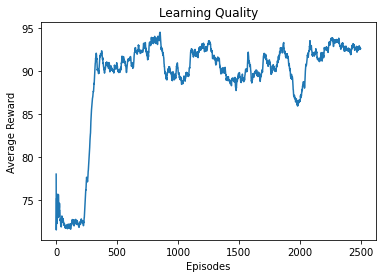

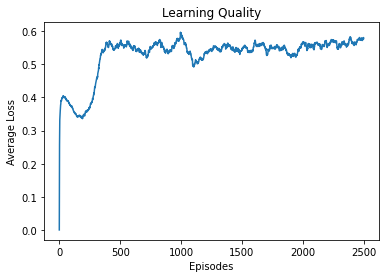

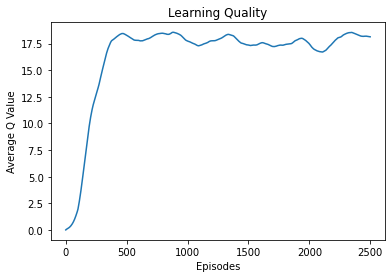

100%|██████████| 2500/2500 [04:59<00:00,  8.34it/s]


In [154]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()


agent = Agent(state_dim=(NB_OBSERVATION,1), action_dim=3)
logger = MetricLogger()
episodes = 2500

for e in tqdm(range(episodes)):

    state = env.reset(NB_STEPS_TRAIN)
    # Play the game!
    while True:
        # Run agent on the state
        action = agent.act(state)
        # Agent performs action
        next_state, reward, done, info = env.step(action, NB_STEPS_TRAIN)
        # Remember
        agent.cache(state, next_state, action, reward, done)
        # Learn
        q, loss = agent.learn()
        # Logging
        logger.log_step(reward, loss, q)
        # Update state
        state = next_state
        # Check if end of game
        if done:
            break

    logger.log_episode()
    logger.record(e, episodes)

In [155]:
# Output of tensorboard
#%tensorboard --logdir=runs

### Phase de test pour 1 Episode: 

In [156]:
"""
WITH RNN:
> Train it normally
> test it on last 100 days and the 101th should be the predicted price of RNN
> last action taken is what we should do to maximize reward
"""


env = StockPricesEnvironment()
agent.exploration_rate=0 # to exploit to the fullest in test
state = env.reset(NB_STEPS_TEST) 
reward_tot = 0

L_reward = []
L_state = []
L_action = []
L_next_state = []

# 1 test Episode of NB_STEPS_TEST days
while True:
  # Run agent on the state
  action = agent.act(state)
  # Agent performs action
  next_state, reward, done, info = env.step(action, NB_STEPS_TEST)
  # Update Lists
  L_state.append(float(state))
  L_reward.append(reward)
  L_action.append(action)
  L_next_state.append(float(next_state[-1]))
  # Remember
  # agent.cache(state, next_state, action, reward, done)
  # Learn
  # q, loss = agent.learn()
  # Update total Reward
  reward_tot += reward
  # Update state
  state = next_state
  # Check if end of game
  if done:
    break

print("Test on ",NB_STEPS_TEST, " days")
print("\nTotal Reward : ", reward_tot)
print("All Rewards : ", L_reward)
print("States : ", L_state)
print("Next States : ", L_next_state)
print("Taken Actions : ", L_action)
print("\nScore = ",int(reward_tot),"/",2*NB_STEPS_TEST, " = ", (reward_tot)/(2*NB_STEPS_TEST)*100,"/ 100")

[*********************100%***********************]  1 of 1 completed
Test on  10000  days

Total Reward :  9315
All Rewards :  [1, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 2, 2, 0, 1, 2, 0, 0, 0, 1, 1, 2, 2, 1, 0, 1, 1, 2, 0, 0, 1, 2, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0, 2,